<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
 This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2025-08-04 19:40:45.946392: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-04 19:40:45.983374: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-04 19:40:45.983420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-04 19:40:45.984674: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-04 19:40:45.991124: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-04 19:40:45.991820: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-08-04 19:40:46.980708: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2025-08-04 19:40:50.302163: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 109ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

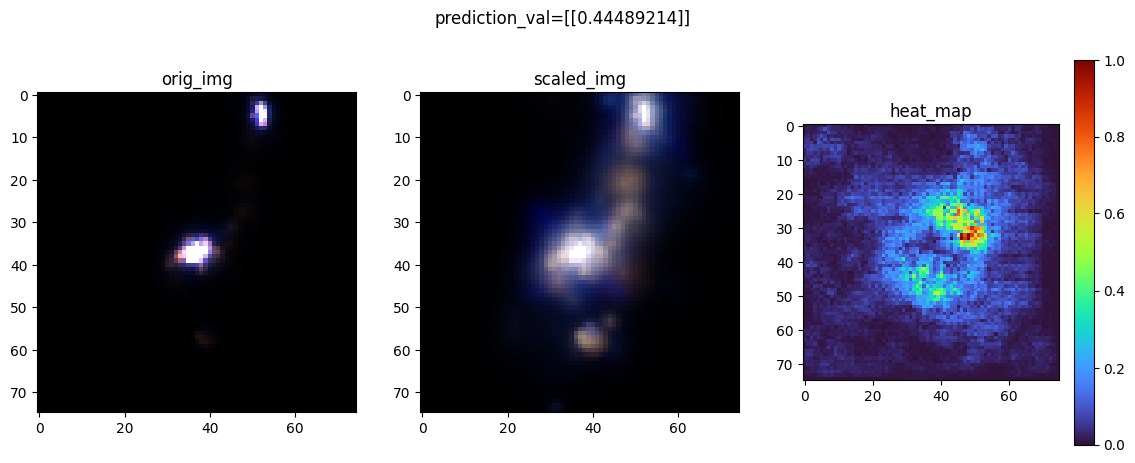

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

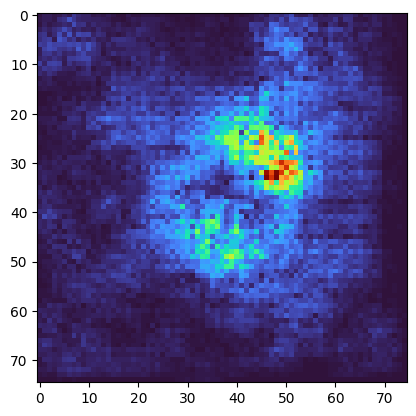

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

2025-08-04 19:40:54.201688: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-08-04 19:40:55.146492: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-08-04 19:40:55.244079: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-08-04 19:40:55.313731: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-08-04 19:40:57.223182: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

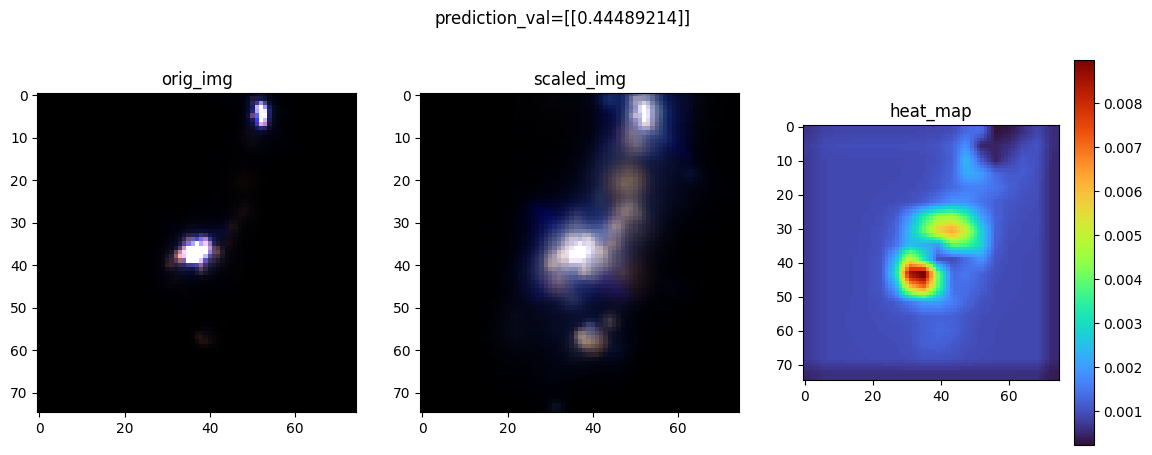

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 1s

 4/32 [==>...........................] - ETA: 0s

 7/32 [=====>........................] - ETA: 0s

10/32 [========>.....................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

19/32 [================>.............] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 1s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

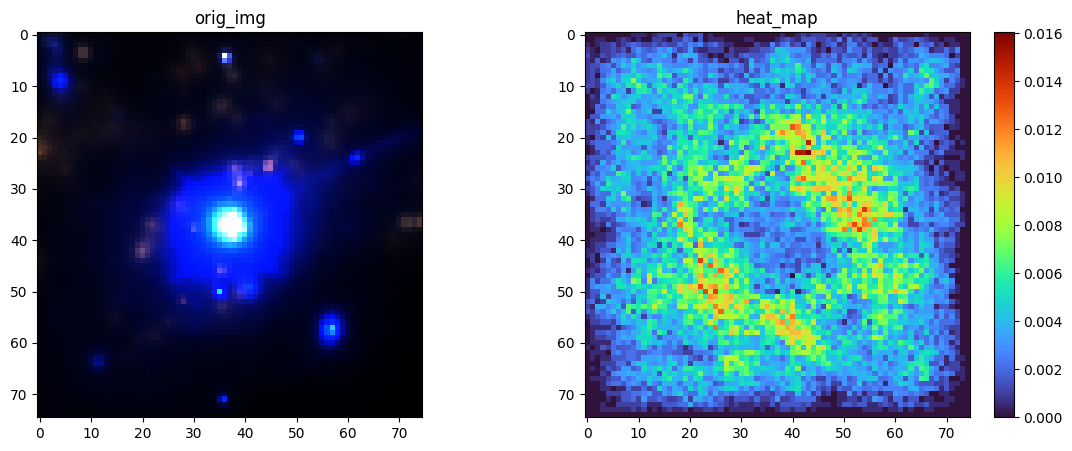

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


  1/338 [..............................] - ETA: 7:15 - loss: 0.7085 - accuracy: 0.5625

  2/338 [..............................] - ETA: 23s - loss: 0.7078 - accuracy: 0.5781 

  3/338 [..............................] - ETA: 23s - loss: 0.7090 - accuracy: 0.5312

  4/338 [..............................] - ETA: 24s - loss: 0.7094 - accuracy: 0.5078

  5/338 [..............................] - ETA: 23s - loss: 0.7093 - accuracy: 0.5000

  6/338 [..............................] - ETA: 23s - loss: 0.7087 - accuracy: 0.5104

  7/338 [..............................] - ETA: 23s - loss: 0.7077 - accuracy: 0.5357

  8/338 [..............................] - ETA: 23s - loss: 0.7073 - accuracy: 0.5391

  9/338 [..............................] - ETA: 23s - loss: 0.7069 - accuracy: 0.5417

 10/338 [..............................] - ETA: 23s - loss: 0.7068 - accuracy: 0.5375

 11/338 [..............................] - ETA: 23s - loss: 0.7062 - accuracy: 0.5455

 12/338 [>.............................] - ETA: 23s - loss: 0.7060 - accuracy: 0.5443

 13/338 [>.............................] - ETA: 23s - loss: 0.7060 - accuracy: 0.5385

 14/338 [>.............................] - ETA: 23s - loss: 0.7056 - accuracy: 0.5424

 15/338 [>.............................] - ETA: 22s - loss: 0.7050 - accuracy: 0.5500

 16/338 [>.............................] - ETA: 22s - loss: 0.7051 - accuracy: 0.5410

 17/338 [>.............................] - ETA: 22s - loss: 0.7050 - accuracy: 0.5386

 18/338 [>.............................] - ETA: 22s - loss: 0.7048 - accuracy: 0.5382

 19/338 [>.............................] - ETA: 22s - loss: 0.7045 - accuracy: 0.5395

 20/338 [>.............................] - ETA: 22s - loss: 0.7045 - accuracy: 0.5344

 21/338 [>.............................] - ETA: 22s - loss: 0.7043 - accuracy: 0.5327

 22/338 [>.............................] - ETA: 22s - loss: 0.7040 - accuracy: 0.5341

 23/338 [=>............................] - ETA: 22s - loss: 0.7039 - accuracy: 0.5312

 24/338 [=>............................] - ETA: 22s - loss: 0.7039 - accuracy: 0.5286

 25/338 [=>............................] - ETA: 21s - loss: 0.7040 - accuracy: 0.5213

 26/338 [=>............................] - ETA: 21s - loss: 0.7038 - accuracy: 0.5216

 27/338 [=>............................] - ETA: 21s - loss: 0.7038 - accuracy: 0.5174

 28/338 [=>............................] - ETA: 21s - loss: 0.7035 - accuracy: 0.5201

 29/338 [=>............................] - ETA: 21s - loss: 0.7032 - accuracy: 0.5226

 30/338 [=>............................] - ETA: 21s - loss: 0.7029 - accuracy: 0.5260

 31/338 [=>............................] - ETA: 21s - loss: 0.7028 - accuracy: 0.5242

 32/338 [=>............................] - ETA: 21s - loss: 0.7025 - accuracy: 0.5264

 33/338 [=>............................] - ETA: 21s - loss: 0.7024 - accuracy: 0.5246

 34/338 [==>...........................] - ETA: 21s - loss: 0.7023 - accuracy: 0.5248

 35/338 [==>...........................] - ETA: 21s - loss: 0.7021 - accuracy: 0.5250

 36/338 [==>...........................] - ETA: 21s - loss: 0.7020 - accuracy: 0.5252

 37/338 [==>...........................] - ETA: 21s - loss: 0.7019 - accuracy: 0.5245

 38/338 [==>...........................] - ETA: 21s - loss: 0.7016 - accuracy: 0.5271

 39/338 [==>...........................] - ETA: 20s - loss: 0.7013 - accuracy: 0.5312

 40/338 [==>...........................] - ETA: 20s - loss: 0.7012 - accuracy: 0.5312

 41/338 [==>...........................] - ETA: 20s - loss: 0.7013 - accuracy: 0.5274

 42/338 [==>...........................] - ETA: 20s - loss: 0.7011 - accuracy: 0.5275

 43/338 [==>...........................] - ETA: 20s - loss: 0.7009 - accuracy: 0.5298

 44/338 [==>...........................] - ETA: 20s - loss: 0.7009 - accuracy: 0.5277

 45/338 [==>...........................] - ETA: 20s - loss: 0.7009 - accuracy: 0.5257

 46/338 [===>..........................] - ETA: 20s - loss: 0.7007 - accuracy: 0.5272

 47/338 [===>..........................] - ETA: 20s - loss: 0.7006 - accuracy: 0.5266

 48/338 [===>..........................] - ETA: 20s - loss: 0.7006 - accuracy: 0.5247

 49/338 [===>..........................] - ETA: 20s - loss: 0.7004 - accuracy: 0.5261

 50/338 [===>..........................] - ETA: 20s - loss: 0.7003 - accuracy: 0.5263

 51/338 [===>..........................] - ETA: 20s - loss: 0.7003 - accuracy: 0.5251

 52/338 [===>..........................] - ETA: 19s - loss: 0.7002 - accuracy: 0.5258

 53/338 [===>..........................] - ETA: 19s - loss: 0.7001 - accuracy: 0.5248

 54/338 [===>..........................] - ETA: 19s - loss: 0.7001 - accuracy: 0.5231

 55/338 [===>..........................] - ETA: 19s - loss: 0.7001 - accuracy: 0.5216

 56/338 [===>..........................] - ETA: 19s - loss: 0.7000 - accuracy: 0.5223

 57/338 [====>.........................] - ETA: 19s - loss: 0.6998 - accuracy: 0.5247

 58/338 [====>.........................] - ETA: 19s - loss: 0.6997 - accuracy: 0.5253

 59/338 [====>.........................] - ETA: 19s - loss: 0.6997 - accuracy: 0.5244

 60/338 [====>.........................] - ETA: 19s - loss: 0.6995 - accuracy: 0.5250

 61/338 [====>.........................] - ETA: 19s - loss: 0.6994 - accuracy: 0.5261

 62/338 [====>.........................] - ETA: 19s - loss: 0.6993 - accuracy: 0.5262

 63/338 [====>.........................] - ETA: 19s - loss: 0.6993 - accuracy: 0.5253

 64/338 [====>.........................] - ETA: 19s - loss: 0.6991 - accuracy: 0.5278

 65/338 [====>.........................] - ETA: 19s - loss: 0.6990 - accuracy: 0.5279

 66/338 [====>.........................] - ETA: 18s - loss: 0.6990 - accuracy: 0.5275

 67/338 [====>.........................] - ETA: 18s - loss: 0.6988 - accuracy: 0.5289

 68/338 [=====>........................] - ETA: 18s - loss: 0.6988 - accuracy: 0.5285

 69/338 [=====>........................] - ETA: 18s - loss: 0.6986 - accuracy: 0.5308

 70/338 [=====>........................] - ETA: 18s - loss: 0.6984 - accuracy: 0.5321

 71/338 [=====>........................] - ETA: 18s - loss: 0.6985 - accuracy: 0.5304

 72/338 [=====>........................] - ETA: 18s - loss: 0.6985 - accuracy: 0.5291

 73/338 [=====>........................] - ETA: 18s - loss: 0.6984 - accuracy: 0.5291

 74/338 [=====>........................] - ETA: 18s - loss: 0.6982 - accuracy: 0.5308

 75/338 [=====>........................] - ETA: 18s - loss: 0.6982 - accuracy: 0.5304

 76/338 [=====>........................] - ETA: 18s - loss: 0.6983 - accuracy: 0.5292

 77/338 [=====>........................] - ETA: 18s - loss: 0.6980 - accuracy: 0.5317

 78/338 [=====>........................] - ETA: 18s - loss: 0.6981 - accuracy: 0.5300

 79/338 [======>.......................] - ETA: 18s - loss: 0.6981 - accuracy: 0.5293

 80/338 [======>.......................] - ETA: 17s - loss: 0.6980 - accuracy: 0.5293

 81/338 [======>.......................] - ETA: 17s - loss: 0.6980 - accuracy: 0.5293

 82/338 [======>.......................] - ETA: 17s - loss: 0.6980 - accuracy: 0.5286

 83/338 [======>.......................] - ETA: 17s - loss: 0.6978 - accuracy: 0.5297

 84/338 [======>.......................] - ETA: 17s - loss: 0.6978 - accuracy: 0.5301

 85/338 [======>.......................] - ETA: 17s - loss: 0.6976 - accuracy: 0.5312

 86/338 [======>.......................] - ETA: 17s - loss: 0.6976 - accuracy: 0.5309

 87/338 [======>.......................] - ETA: 17s - loss: 0.6977 - accuracy: 0.5295

 88/338 [======>.......................] - ETA: 17s - loss: 0.6976 - accuracy: 0.5291

 89/338 [======>.......................] - ETA: 17s - loss: 0.6975 - accuracy: 0.5298

 90/338 [======>.......................] - ETA: 17s - loss: 0.6976 - accuracy: 0.5285

 91/338 [=======>......................] - ETA: 17s - loss: 0.6976 - accuracy: 0.5278

 92/338 [=======>......................] - ETA: 17s - loss: 0.6975 - accuracy: 0.5285

 93/338 [=======>......................] - ETA: 16s - loss: 0.6974 - accuracy: 0.5286

 94/338 [=======>......................] - ETA: 16s - loss: 0.6975 - accuracy: 0.5279

 95/338 [=======>......................] - ETA: 16s - loss: 0.6974 - accuracy: 0.5280

 96/338 [=======>......................] - ETA: 16s - loss: 0.6973 - accuracy: 0.5286

 97/338 [=======>......................] - ETA: 16s - loss: 0.6974 - accuracy: 0.5267

 98/338 [=======>......................] - ETA: 16s - loss: 0.6974 - accuracy: 0.5261

 99/338 [=======>......................] - ETA: 16s - loss: 0.6974 - accuracy: 0.5259

100/338 [=======>......................] - ETA: 16s - loss: 0.6973 - accuracy: 0.5266

101/338 [=======>......................] - ETA: 16s - loss: 0.6973 - accuracy: 0.5254

102/338 [========>.....................] - ETA: 16s - loss: 0.6974 - accuracy: 0.5245

103/338 [========>.....................] - ETA: 16s - loss: 0.6973 - accuracy: 0.5246

104/338 [========>.....................] - ETA: 16s - loss: 0.6973 - accuracy: 0.5249

105/338 [========>.....................] - ETA: 16s - loss: 0.6972 - accuracy: 0.5247

106/338 [========>.....................] - ETA: 16s - loss: 0.6971 - accuracy: 0.5259

107/338 [========>.....................] - ETA: 15s - loss: 0.6971 - accuracy: 0.5254

108/338 [========>.....................] - ETA: 15s - loss: 0.6971 - accuracy: 0.5258

109/338 [========>.....................] - ETA: 15s - loss: 0.6970 - accuracy: 0.5267

110/338 [========>.....................] - ETA: 15s - loss: 0.6969 - accuracy: 0.5267

111/338 [========>.....................] - ETA: 15s - loss: 0.6969 - accuracy: 0.5267

112/338 [========>.....................] - ETA: 15s - loss: 0.6968 - accuracy: 0.5271

113/338 [=========>....................] - ETA: 15s - loss: 0.6967 - accuracy: 0.5277

114/338 [=========>....................] - ETA: 15s - loss: 0.6968 - accuracy: 0.5266

115/338 [=========>....................] - ETA: 15s - loss: 0.6967 - accuracy: 0.5266

116/338 [=========>....................] - ETA: 15s - loss: 0.6966 - accuracy: 0.5286

117/338 [=========>....................] - ETA: 15s - loss: 0.6966 - accuracy: 0.5275

118/338 [=========>....................] - ETA: 15s - loss: 0.6967 - accuracy: 0.5257

119/338 [=========>....................] - ETA: 15s - loss: 0.6967 - accuracy: 0.5260

120/338 [=========>....................] - ETA: 15s - loss: 0.6967 - accuracy: 0.5253

121/338 [=========>....................] - ETA: 15s - loss: 0.6966 - accuracy: 0.5256

122/338 [=========>....................] - ETA: 14s - loss: 0.6967 - accuracy: 0.5246

123/338 [=========>....................] - ETA: 14s - loss: 0.6967 - accuracy: 0.5241

124/338 [==========>...................] - ETA: 14s - loss: 0.6967 - accuracy: 0.5237

125/338 [==========>...................] - ETA: 14s - loss: 0.6966 - accuracy: 0.5240

126/338 [==========>...................] - ETA: 14s - loss: 0.6966 - accuracy: 0.5236

127/338 [==========>...................] - ETA: 14s - loss: 0.6967 - accuracy: 0.5229

128/338 [==========>...................] - ETA: 14s - loss: 0.6966 - accuracy: 0.5229

129/338 [==========>...................] - ETA: 14s - loss: 0.6965 - accuracy: 0.5237

130/338 [==========>...................] - ETA: 14s - loss: 0.6965 - accuracy: 0.5236

131/338 [==========>...................] - ETA: 14s - loss: 0.6965 - accuracy: 0.5231

132/338 [==========>...................] - ETA: 14s - loss: 0.6965 - accuracy: 0.5237

133/338 [==========>...................] - ETA: 14s - loss: 0.6964 - accuracy: 0.5237

134/338 [==========>...................] - ETA: 14s - loss: 0.6964 - accuracy: 0.5243

135/338 [==========>...................] - ETA: 14s - loss: 0.6963 - accuracy: 0.5248

136/338 [===========>..................] - ETA: 14s - loss: 0.6963 - accuracy: 0.5248

137/338 [===========>..................] - ETA: 13s - loss: 0.6962 - accuracy: 0.5253

138/338 [===========>..................] - ETA: 13s - loss: 0.6961 - accuracy: 0.5263

139/338 [===========>..................] - ETA: 13s - loss: 0.6960 - accuracy: 0.5268

140/338 [===========>..................] - ETA: 13s - loss: 0.6960 - accuracy: 0.5268

141/338 [===========>..................] - ETA: 13s - loss: 0.6960 - accuracy: 0.5273

142/338 [===========>..................] - ETA: 13s - loss: 0.6960 - accuracy: 0.5264

143/338 [===========>..................] - ETA: 13s - loss: 0.6961 - accuracy: 0.5253

144/338 [===========>..................] - ETA: 13s - loss: 0.6960 - accuracy: 0.5258

145/338 [===========>..................] - ETA: 13s - loss: 0.6960 - accuracy: 0.5261

146/338 [===========>..................] - ETA: 13s - loss: 0.6960 - accuracy: 0.5255

147/338 [============>.................] - ETA: 13s - loss: 0.6960 - accuracy: 0.5253

148/338 [============>.................] - ETA: 13s - loss: 0.6959 - accuracy: 0.5255

149/338 [============>.................] - ETA: 13s - loss: 0.6959 - accuracy: 0.5258

150/338 [============>.................] - ETA: 13s - loss: 0.6959 - accuracy: 0.5254

151/338 [============>.................] - ETA: 13s - loss: 0.6959 - accuracy: 0.5244

152/338 [============>.................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5238

153/338 [============>.................] - ETA: 12s - loss: 0.6960 - accuracy: 0.5235

154/338 [============>.................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5239

155/338 [============>.................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5238

156/338 [============>.................] - ETA: 12s - loss: 0.6960 - accuracy: 0.5220

157/338 [============>.................] - ETA: 12s - loss: 0.6960 - accuracy: 0.5225

158/338 [=============>................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5223

159/338 [=============>................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5220

160/338 [=============>................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5221

161/338 [=============>................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5219

162/338 [=============>................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5218

163/338 [=============>................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5222

164/338 [=============>................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5221

165/338 [=============>................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5225

166/338 [=============>................] - ETA: 11s - loss: 0.6957 - accuracy: 0.5233

167/338 [=============>................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5243

168/338 [=============>................] - ETA: 11s - loss: 0.6955 - accuracy: 0.5249

169/338 [==============>...............] - ETA: 11s - loss: 0.6956 - accuracy: 0.5246

170/338 [==============>...............] - ETA: 11s - loss: 0.6956 - accuracy: 0.5244

171/338 [==============>...............] - ETA: 11s - loss: 0.6955 - accuracy: 0.5249

172/338 [==============>...............] - ETA: 11s - loss: 0.6955 - accuracy: 0.5251

173/338 [==============>...............] - ETA: 11s - loss: 0.6955 - accuracy: 0.5246

174/338 [==============>...............] - ETA: 11s - loss: 0.6955 - accuracy: 0.5241

175/338 [==============>...............] - ETA: 11s - loss: 0.6954 - accuracy: 0.5245

176/338 [==============>...............] - ETA: 11s - loss: 0.6954 - accuracy: 0.5245

177/338 [==============>...............] - ETA: 11s - loss: 0.6954 - accuracy: 0.5242

178/338 [==============>...............] - ETA: 11s - loss: 0.6955 - accuracy: 0.5233

179/338 [==============>...............] - ETA: 11s - loss: 0.6954 - accuracy: 0.5241

180/338 [==============>...............] - ETA: 11s - loss: 0.6954 - accuracy: 0.5240

181/338 [===============>..............] - ETA: 10s - loss: 0.6954 - accuracy: 0.5238

182/338 [===============>..............] - ETA: 10s - loss: 0.6954 - accuracy: 0.5237

183/338 [===============>..............] - ETA: 10s - loss: 0.6953 - accuracy: 0.5236

184/338 [===============>..............] - ETA: 10s - loss: 0.6953 - accuracy: 0.5239

185/338 [===============>..............] - ETA: 10s - loss: 0.6953 - accuracy: 0.5238

186/338 [===============>..............] - ETA: 10s - loss: 0.6953 - accuracy: 0.5232

187/338 [===============>..............] - ETA: 10s - loss: 0.6953 - accuracy: 0.5236

188/338 [===============>..............] - ETA: 10s - loss: 0.6952 - accuracy: 0.5244

189/338 [===============>..............] - ETA: 10s - loss: 0.6952 - accuracy: 0.5240

190/338 [===============>..............] - ETA: 10s - loss: 0.6952 - accuracy: 0.5240

191/338 [===============>..............] - ETA: 10s - loss: 0.6952 - accuracy: 0.5244

192/338 [================>.............] - ETA: 10s - loss: 0.6951 - accuracy: 0.5244

193/338 [================>.............] - ETA: 10s - loss: 0.6951 - accuracy: 0.5244

194/338 [================>.............] - ETA: 10s - loss: 0.6951 - accuracy: 0.5250

195/338 [================>.............] - ETA: 10s - loss: 0.6951 - accuracy: 0.5244

196/338 [================>.............] - ETA: 9s - loss: 0.6951 - accuracy: 0.5241 

197/338 [================>.............] - ETA: 9s - loss: 0.6951 - accuracy: 0.5240

198/338 [================>.............] - ETA: 9s - loss: 0.6951 - accuracy: 0.5237

199/338 [================>.............] - ETA: 9s - loss: 0.6951 - accuracy: 0.5236

200/338 [================>.............] - ETA: 9s - loss: 0.6950 - accuracy: 0.5244

201/338 [================>.............] - ETA: 9s - loss: 0.6950 - accuracy: 0.5238

202/338 [================>.............] - ETA: 9s - loss: 0.6950 - accuracy: 0.5237

203/338 [=================>............] - ETA: 9s - loss: 0.6950 - accuracy: 0.5237

204/338 [=================>............] - ETA: 9s - loss: 0.6950 - accuracy: 0.5244

205/338 [=================>............] - ETA: 9s - loss: 0.6950 - accuracy: 0.5242

206/338 [=================>............] - ETA: 9s - loss: 0.6949 - accuracy: 0.5247

207/338 [=================>............] - ETA: 9s - loss: 0.6948 - accuracy: 0.5258

208/338 [=================>............] - ETA: 9s - loss: 0.6948 - accuracy: 0.5254

209/338 [=================>............] - ETA: 9s - loss: 0.6948 - accuracy: 0.5254

210/338 [=================>............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5256

211/338 [=================>............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5258

212/338 [=================>............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5258

213/338 [=================>............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5261

214/338 [=================>............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5257

215/338 [==================>...........] - ETA: 8s - loss: 0.6947 - accuracy: 0.5259

216/338 [==================>...........] - ETA: 8s - loss: 0.6947 - accuracy: 0.5255

217/338 [==================>...........] - ETA: 8s - loss: 0.6947 - accuracy: 0.5252

218/338 [==================>...........] - ETA: 8s - loss: 0.6947 - accuracy: 0.5252

219/338 [==================>...........] - ETA: 8s - loss: 0.6947 - accuracy: 0.5251

220/338 [==================>...........] - ETA: 8s - loss: 0.6948 - accuracy: 0.5243

221/338 [==================>...........] - ETA: 8s - loss: 0.6947 - accuracy: 0.5245

222/338 [==================>...........] - ETA: 8s - loss: 0.6948 - accuracy: 0.5239

223/338 [==================>...........] - ETA: 8s - loss: 0.6948 - accuracy: 0.5238

224/338 [==================>...........] - ETA: 7s - loss: 0.6948 - accuracy: 0.5230

225/338 [==================>...........] - ETA: 7s - loss: 0.6948 - accuracy: 0.5231

226/338 [===================>..........] - ETA: 7s - loss: 0.6948 - accuracy: 0.5230

227/338 [===================>..........] - ETA: 7s - loss: 0.6948 - accuracy: 0.5230

228/338 [===================>..........] - ETA: 7s - loss: 0.6948 - accuracy: 0.5234

229/338 [===================>..........] - ETA: 7s - loss: 0.6948 - accuracy: 0.5233

230/338 [===================>..........] - ETA: 7s - loss: 0.6948 - accuracy: 0.5228

231/338 [===================>..........] - ETA: 7s - loss: 0.6948 - accuracy: 0.5226

232/338 [===================>..........] - ETA: 7s - loss: 0.6947 - accuracy: 0.5233

233/338 [===================>..........] - ETA: 7s - loss: 0.6947 - accuracy: 0.5232

234/338 [===================>..........] - ETA: 7s - loss: 0.6947 - accuracy: 0.5232

235/338 [===================>..........] - ETA: 7s - loss: 0.6947 - accuracy: 0.5230

236/338 [===================>..........] - ETA: 7s - loss: 0.6948 - accuracy: 0.5224

237/338 [====================>.........] - ETA: 7s - loss: 0.6947 - accuracy: 0.5225

238/338 [====================>.........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5226

239/338 [====================>.........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5229

240/338 [====================>.........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5229

241/338 [====================>.........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5228

242/338 [====================>.........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5232

243/338 [====================>.........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5231

244/338 [====================>.........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5231

245/338 [====================>.........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5231

246/338 [====================>.........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5224

247/338 [====================>.........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5221

248/338 [=====================>........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5224

249/338 [=====================>........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5228

250/338 [=====================>........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5230

251/338 [=====================>........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5232

252/338 [=====================>........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5228

253/338 [=====================>........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5227

254/338 [=====================>........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5233

255/338 [=====================>........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5234

256/338 [=====================>........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5229

257/338 [=====================>........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5227

258/338 [=====================>........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5224

259/338 [=====================>........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5223

260/338 [======================>.......] - ETA: 5s - loss: 0.6944 - accuracy: 0.5224

261/338 [======================>.......] - ETA: 5s - loss: 0.6945 - accuracy: 0.5217

262/338 [======================>.......] - ETA: 5s - loss: 0.6945 - accuracy: 0.5218

263/338 [======================>.......] - ETA: 5s - loss: 0.6945 - accuracy: 0.5216

264/338 [======================>.......] - ETA: 5s - loss: 0.6944 - accuracy: 0.5221

265/338 [======================>.......] - ETA: 5s - loss: 0.6944 - accuracy: 0.5218

266/338 [======================>.......] - ETA: 5s - loss: 0.6945 - accuracy: 0.5214

267/338 [======================>.......] - ETA: 4s - loss: 0.6944 - accuracy: 0.5218

268/338 [======================>.......] - ETA: 4s - loss: 0.6944 - accuracy: 0.5220

269/338 [======================>.......] - ETA: 4s - loss: 0.6944 - accuracy: 0.5215

270/338 [======================>.......] - ETA: 4s - loss: 0.6944 - accuracy: 0.5214

271/338 [=======================>......] - ETA: 4s - loss: 0.6944 - accuracy: 0.5220

272/338 [=======================>......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5225

273/338 [=======================>......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5227

274/338 [=======================>......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5222

275/338 [=======================>......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5223

276/338 [=======================>......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5223

277/338 [=======================>......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5223

278/338 [=======================>......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5226

279/338 [=======================>......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5236

280/338 [=======================>......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5241

281/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5238

282/338 [========================>.....] - ETA: 3s - loss: 0.6941 - accuracy: 0.5238

283/338 [========================>.....] - ETA: 3s - loss: 0.6940 - accuracy: 0.5242

284/338 [========================>.....] - ETA: 3s - loss: 0.6940 - accuracy: 0.5244

285/338 [========================>.....] - ETA: 3s - loss: 0.6940 - accuracy: 0.5245

286/338 [========================>.....] - ETA: 3s - loss: 0.6939 - accuracy: 0.5250

287/338 [========================>.....] - ETA: 3s - loss: 0.6939 - accuracy: 0.5253

288/338 [========================>.....] - ETA: 3s - loss: 0.6939 - accuracy: 0.5250

289/338 [========================>.....] - ETA: 3s - loss: 0.6939 - accuracy: 0.5248

290/338 [========================>.....] - ETA: 3s - loss: 0.6939 - accuracy: 0.5247

291/338 [========================>.....] - ETA: 3s - loss: 0.6939 - accuracy: 0.5246

292/338 [========================>.....] - ETA: 3s - loss: 0.6939 - accuracy: 0.5246

293/338 [=========================>....] - ETA: 3s - loss: 0.6938 - accuracy: 0.5251

294/338 [=========================>....] - ETA: 3s - loss: 0.6939 - accuracy: 0.5246

295/338 [=========================>....] - ETA: 3s - loss: 0.6939 - accuracy: 0.5240

296/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5243

297/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5244

298/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5241

299/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5239

300/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5241

301/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5245

302/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5246

303/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5246

304/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5249

305/338 [==========================>...] - ETA: 2s - loss: 0.6937 - accuracy: 0.5253

306/338 [==========================>...] - ETA: 2s - loss: 0.6936 - accuracy: 0.5260

307/338 [==========================>...] - ETA: 2s - loss: 0.6936 - accuracy: 0.5260

308/338 [==========================>...] - ETA: 2s - loss: 0.6936 - accuracy: 0.5260

309/338 [==========================>...] - ETA: 2s - loss: 0.6936 - accuracy: 0.5260

310/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5263

311/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5265

312/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5268

313/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5266

314/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5267

315/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5267

316/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5266

317/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5270

318/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5267

319/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5267

320/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5269

321/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5268

322/338 [===========================>..] - ETA: 1s - loss: 0.6933 - accuracy: 0.5270

323/338 [===========================>..] - ETA: 1s - loss: 0.6933 - accuracy: 0.5269

324/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5271

325/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5270

326/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5271

327/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5273

328/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5272

329/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5273

330/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5274

331/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5276

332/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5273

333/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5271

334/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5269

335/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5271

336/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5273

337/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5272

338/338 [==============================] - 28s 79ms/step - loss: 0.6932 - accuracy: 0.5271 - val_loss: 0.6907 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 24s - loss: 0.6969 - accuracy: 0.4688

  2/338 [..............................] - ETA: 24s - loss: 0.6910 - accuracy: 0.5156

  3/338 [..............................] - ETA: 24s - loss: 0.6955 - accuracy: 0.4896

  4/338 [..............................] - ETA: 24s - loss: 0.6908 - accuracy: 0.5234

  5/338 [..............................] - ETA: 24s - loss: 0.6908 - accuracy: 0.5250

  6/338 [..............................] - ETA: 24s - loss: 0.6895 - accuracy: 0.5312

  7/338 [..............................] - ETA: 23s - loss: 0.6916 - accuracy: 0.5134

  8/338 [..............................] - ETA: 24s - loss: 0.6901 - accuracy: 0.5234

  9/338 [..............................] - ETA: 24s - loss: 0.6916 - accuracy: 0.5104

 10/338 [..............................] - ETA: 24s - loss: 0.6912 - accuracy: 0.5156

 11/338 [..............................] - ETA: 24s - loss: 0.6899 - accuracy: 0.5256

 12/338 [>.............................] - ETA: 24s - loss: 0.6888 - accuracy: 0.5339

 13/338 [>.............................] - ETA: 24s - loss: 0.6886 - accuracy: 0.5361

 14/338 [>.............................] - ETA: 23s - loss: 0.6888 - accuracy: 0.5335

 15/338 [>.............................] - ETA: 23s - loss: 0.6883 - accuracy: 0.5375

 16/338 [>.............................] - ETA: 23s - loss: 0.6892 - accuracy: 0.5293

 17/338 [>.............................] - ETA: 23s - loss: 0.6886 - accuracy: 0.5349

 18/338 [>.............................] - ETA: 23s - loss: 0.6886 - accuracy: 0.5347

 19/338 [>.............................] - ETA: 23s - loss: 0.6883 - accuracy: 0.5362

 20/338 [>.............................] - ETA: 22s - loss: 0.6887 - accuracy: 0.5328

 21/338 [>.............................] - ETA: 22s - loss: 0.6882 - accuracy: 0.5372

 22/338 [>.............................] - ETA: 22s - loss: 0.6886 - accuracy: 0.5355

 23/338 [=>............................] - ETA: 22s - loss: 0.6892 - accuracy: 0.5312

 24/338 [=>............................] - ETA: 22s - loss: 0.6904 - accuracy: 0.5221

 25/338 [=>............................] - ETA: 22s - loss: 0.6908 - accuracy: 0.5175

 26/338 [=>............................] - ETA: 22s - loss: 0.6908 - accuracy: 0.5168

 27/338 [=>............................] - ETA: 22s - loss: 0.6910 - accuracy: 0.5150

 28/338 [=>............................] - ETA: 22s - loss: 0.6918 - accuracy: 0.5078

 29/338 [=>............................] - ETA: 22s - loss: 0.6920 - accuracy: 0.5054

 30/338 [=>............................] - ETA: 22s - loss: 0.6921 - accuracy: 0.5063

 31/338 [=>............................] - ETA: 22s - loss: 0.6920 - accuracy: 0.5060

 32/338 [=>............................] - ETA: 22s - loss: 0.6925 - accuracy: 0.5010

 33/338 [=>............................] - ETA: 22s - loss: 0.6927 - accuracy: 0.5000

 34/338 [==>...........................] - ETA: 21s - loss: 0.6928 - accuracy: 0.4991

 35/338 [==>...........................] - ETA: 21s - loss: 0.6928 - accuracy: 0.4991

 36/338 [==>...........................] - ETA: 21s - loss: 0.6926 - accuracy: 0.5017

 37/338 [==>...........................] - ETA: 21s - loss: 0.6926 - accuracy: 0.5017

 38/338 [==>...........................] - ETA: 21s - loss: 0.6922 - accuracy: 0.5066

 39/338 [==>...........................] - ETA: 21s - loss: 0.6919 - accuracy: 0.5096

 40/338 [==>...........................] - ETA: 21s - loss: 0.6920 - accuracy: 0.5086

 41/338 [==>...........................] - ETA: 21s - loss: 0.6922 - accuracy: 0.5061

 42/338 [==>...........................] - ETA: 21s - loss: 0.6925 - accuracy: 0.5030

 43/338 [==>...........................] - ETA: 21s - loss: 0.6925 - accuracy: 0.5036

 44/338 [==>...........................] - ETA: 21s - loss: 0.6924 - accuracy: 0.5043

 45/338 [==>...........................] - ETA: 21s - loss: 0.6924 - accuracy: 0.5049

 46/338 [===>..........................] - ETA: 21s - loss: 0.6923 - accuracy: 0.5061

 47/338 [===>..........................] - ETA: 21s - loss: 0.6921 - accuracy: 0.5080

 48/338 [===>..........................] - ETA: 21s - loss: 0.6921 - accuracy: 0.5078

 49/338 [===>..........................] - ETA: 20s - loss: 0.6921 - accuracy: 0.5064

 50/338 [===>..........................] - ETA: 20s - loss: 0.6920 - accuracy: 0.5075

 51/338 [===>..........................] - ETA: 20s - loss: 0.6917 - accuracy: 0.5104

 52/338 [===>..........................] - ETA: 20s - loss: 0.6915 - accuracy: 0.5132

 53/338 [===>..........................] - ETA: 20s - loss: 0.6916 - accuracy: 0.5118

 54/338 [===>..........................] - ETA: 20s - loss: 0.6916 - accuracy: 0.5116

 55/338 [===>..........................] - ETA: 20s - loss: 0.6917 - accuracy: 0.5114

 56/338 [===>..........................] - ETA: 20s - loss: 0.6916 - accuracy: 0.5117

 57/338 [====>.........................] - ETA: 20s - loss: 0.6919 - accuracy: 0.5088

 58/338 [====>.........................] - ETA: 20s - loss: 0.6919 - accuracy: 0.5081

 59/338 [====>.........................] - ETA: 20s - loss: 0.6919 - accuracy: 0.5085

 60/338 [====>.........................] - ETA: 20s - loss: 0.6920 - accuracy: 0.5073

 61/338 [====>.........................] - ETA: 19s - loss: 0.6921 - accuracy: 0.5056

 62/338 [====>.........................] - ETA: 19s - loss: 0.6922 - accuracy: 0.5045

 63/338 [====>.........................] - ETA: 19s - loss: 0.6922 - accuracy: 0.5040

 64/338 [====>.........................] - ETA: 19s - loss: 0.6920 - accuracy: 0.5054

 65/338 [====>.........................] - ETA: 19s - loss: 0.6919 - accuracy: 0.5072

 66/338 [====>.........................] - ETA: 19s - loss: 0.6919 - accuracy: 0.5076

 67/338 [====>.........................] - ETA: 19s - loss: 0.6916 - accuracy: 0.5098

 68/338 [=====>........................] - ETA: 19s - loss: 0.6916 - accuracy: 0.5097

 69/338 [=====>........................] - ETA: 19s - loss: 0.6916 - accuracy: 0.5091

 70/338 [=====>........................] - ETA: 19s - loss: 0.6915 - accuracy: 0.5098

 71/338 [=====>........................] - ETA: 19s - loss: 0.6914 - accuracy: 0.5106

 72/338 [=====>........................] - ETA: 19s - loss: 0.6913 - accuracy: 0.5122

 73/338 [=====>........................] - ETA: 19s - loss: 0.6911 - accuracy: 0.5146

 74/338 [=====>........................] - ETA: 18s - loss: 0.6911 - accuracy: 0.5152

 75/338 [=====>........................] - ETA: 18s - loss: 0.6912 - accuracy: 0.5138

 76/338 [=====>........................] - ETA: 18s - loss: 0.6913 - accuracy: 0.5127

 77/338 [=====>........................] - ETA: 18s - loss: 0.6912 - accuracy: 0.5134

 78/338 [=====>........................] - ETA: 18s - loss: 0.6912 - accuracy: 0.5124

 79/338 [======>.......................] - ETA: 18s - loss: 0.6913 - accuracy: 0.5115

 80/338 [======>.......................] - ETA: 18s - loss: 0.6912 - accuracy: 0.5121

 81/338 [======>.......................] - ETA: 18s - loss: 0.6912 - accuracy: 0.5116

 82/338 [======>.......................] - ETA: 18s - loss: 0.6911 - accuracy: 0.5133

 83/338 [======>.......................] - ETA: 18s - loss: 0.6910 - accuracy: 0.5139

 84/338 [======>.......................] - ETA: 18s - loss: 0.6911 - accuracy: 0.5130

 85/338 [======>.......................] - ETA: 18s - loss: 0.6912 - accuracy: 0.5110

 86/338 [======>.......................] - ETA: 17s - loss: 0.6912 - accuracy: 0.5113

 87/338 [======>.......................] - ETA: 17s - loss: 0.6910 - accuracy: 0.5119

 88/338 [======>.......................] - ETA: 17s - loss: 0.6909 - accuracy: 0.5135

 89/338 [======>.......................] - ETA: 17s - loss: 0.6909 - accuracy: 0.5133

 90/338 [======>.......................] - ETA: 17s - loss: 0.6909 - accuracy: 0.5135

 91/338 [=======>......................] - ETA: 17s - loss: 0.6909 - accuracy: 0.5134

 92/338 [=======>......................] - ETA: 17s - loss: 0.6911 - accuracy: 0.5115

 93/338 [=======>......................] - ETA: 17s - loss: 0.6910 - accuracy: 0.5118

 94/338 [=======>......................] - ETA: 17s - loss: 0.6910 - accuracy: 0.5123

 95/338 [=======>......................] - ETA: 17s - loss: 0.6910 - accuracy: 0.5112

 96/338 [=======>......................] - ETA: 17s - loss: 0.6909 - accuracy: 0.5117

 97/338 [=======>......................] - ETA: 17s - loss: 0.6908 - accuracy: 0.5122

 98/338 [=======>......................] - ETA: 16s - loss: 0.6908 - accuracy: 0.5128

 99/338 [=======>......................] - ETA: 16s - loss: 0.6908 - accuracy: 0.5126

100/338 [=======>......................] - ETA: 16s - loss: 0.6907 - accuracy: 0.5128

101/338 [=======>......................] - ETA: 16s - loss: 0.6908 - accuracy: 0.5124

102/338 [========>.....................] - ETA: 16s - loss: 0.6907 - accuracy: 0.5132

103/338 [========>.....................] - ETA: 16s - loss: 0.6908 - accuracy: 0.5121

104/338 [========>.....................] - ETA: 16s - loss: 0.6908 - accuracy: 0.5123

105/338 [========>.....................] - ETA: 16s - loss: 0.6908 - accuracy: 0.5122

106/338 [========>.....................] - ETA: 16s - loss: 0.6907 - accuracy: 0.5130

107/338 [========>.....................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5134

108/338 [========>.....................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5130

109/338 [========>.....................] - ETA: 16s - loss: 0.6905 - accuracy: 0.5143

110/338 [========>.....................] - ETA: 16s - loss: 0.6903 - accuracy: 0.5165

111/338 [========>.....................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5177

112/338 [========>.....................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5184

113/338 [=========>....................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5171

114/338 [=========>....................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5178

115/338 [=========>....................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5171

116/338 [=========>....................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5170

117/338 [=========>....................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5158

118/338 [=========>....................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5164

119/338 [=========>....................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5150

120/338 [=========>....................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5156

121/338 [=========>....................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5163

122/338 [=========>....................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5154

123/338 [=========>....................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5147

124/338 [==========>...................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5141

125/338 [==========>...................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5135

126/338 [==========>...................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5144

127/338 [==========>...................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5138

128/338 [==========>...................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5134

129/338 [==========>...................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5126

130/338 [==========>...................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5130

131/338 [==========>...................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5129

132/338 [==========>...................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5130

133/338 [==========>...................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5127

134/338 [==========>...................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5131

135/338 [==========>...................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5118

136/338 [===========>..................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5117

137/338 [===========>..................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5116

138/338 [===========>..................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5113

139/338 [===========>..................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5110

140/338 [===========>..................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5121

141/338 [===========>..................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5117

142/338 [===========>..................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5114

143/338 [===========>..................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5109

144/338 [===========>..................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5119

145/338 [===========>..................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5119

146/338 [===========>..................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5133

147/338 [============>.................] - ETA: 13s - loss: 0.6903 - accuracy: 0.5119

148/338 [============>.................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5122

149/338 [============>.................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5124

150/338 [============>.................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5119

151/338 [============>.................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5118

152/338 [============>.................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5121

153/338 [============>.................] - ETA: 12s - loss: 0.6902 - accuracy: 0.5123

154/338 [============>.................] - ETA: 12s - loss: 0.6901 - accuracy: 0.5138

155/338 [============>.................] - ETA: 12s - loss: 0.6901 - accuracy: 0.5133

156/338 [============>.................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5134

157/338 [============>.................] - ETA: 12s - loss: 0.6901 - accuracy: 0.5129

158/338 [=============>................] - ETA: 12s - loss: 0.6901 - accuracy: 0.5136

159/338 [=============>................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5143

160/338 [=============>................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5156

161/338 [=============>................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5161

162/338 [=============>................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5170

163/338 [=============>................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5167

164/338 [=============>................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5170

165/338 [=============>................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5172

166/338 [=============>................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5173

167/338 [=============>................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5174

168/338 [=============>................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5180

169/338 [==============>...............] - ETA: 11s - loss: 0.6896 - accuracy: 0.5185

170/338 [==============>...............] - ETA: 11s - loss: 0.6897 - accuracy: 0.5180

171/338 [==============>...............] - ETA: 11s - loss: 0.6897 - accuracy: 0.5183

172/338 [==============>...............] - ETA: 11s - loss: 0.6896 - accuracy: 0.5193

173/338 [==============>...............] - ETA: 11s - loss: 0.6896 - accuracy: 0.5191

174/338 [==============>...............] - ETA: 11s - loss: 0.6896 - accuracy: 0.5196

175/338 [==============>...............] - ETA: 11s - loss: 0.6895 - accuracy: 0.5195

176/338 [==============>...............] - ETA: 11s - loss: 0.6895 - accuracy: 0.5190

177/338 [==============>...............] - ETA: 11s - loss: 0.6894 - accuracy: 0.5198

178/338 [==============>...............] - ETA: 11s - loss: 0.6894 - accuracy: 0.5200

179/338 [==============>...............] - ETA: 11s - loss: 0.6894 - accuracy: 0.5203

180/338 [==============>...............] - ETA: 11s - loss: 0.6893 - accuracy: 0.5208

181/338 [===============>..............] - ETA: 11s - loss: 0.6894 - accuracy: 0.5202

182/338 [===============>..............] - ETA: 10s - loss: 0.6893 - accuracy: 0.5206

183/338 [===============>..............] - ETA: 10s - loss: 0.6893 - accuracy: 0.5207

184/338 [===============>..............] - ETA: 10s - loss: 0.6893 - accuracy: 0.5206

185/338 [===============>..............] - ETA: 10s - loss: 0.6892 - accuracy: 0.5206

186/338 [===============>..............] - ETA: 10s - loss: 0.6892 - accuracy: 0.5205

187/338 [===============>..............] - ETA: 10s - loss: 0.6891 - accuracy: 0.5211

188/338 [===============>..............] - ETA: 10s - loss: 0.6891 - accuracy: 0.5206

189/338 [===============>..............] - ETA: 10s - loss: 0.6891 - accuracy: 0.5203

190/338 [===============>..............] - ETA: 10s - loss: 0.6891 - accuracy: 0.5207

191/338 [===============>..............] - ETA: 10s - loss: 0.6891 - accuracy: 0.5203

192/338 [================>.............] - ETA: 10s - loss: 0.6890 - accuracy: 0.5208

193/338 [================>.............] - ETA: 10s - loss: 0.6889 - accuracy: 0.5214

194/338 [================>.............] - ETA: 10s - loss: 0.6888 - accuracy: 0.5214

195/338 [================>.............] - ETA: 10s - loss: 0.6888 - accuracy: 0.5216

196/338 [================>.............] - ETA: 9s - loss: 0.6888 - accuracy: 0.5212 

197/338 [================>.............] - ETA: 9s - loss: 0.6888 - accuracy: 0.5214

198/338 [================>.............] - ETA: 9s - loss: 0.6887 - accuracy: 0.5221

199/338 [================>.............] - ETA: 9s - loss: 0.6886 - accuracy: 0.5226

200/338 [================>.............] - ETA: 9s - loss: 0.6886 - accuracy: 0.5225

201/338 [================>.............] - ETA: 9s - loss: 0.6885 - accuracy: 0.5224

202/338 [================>.............] - ETA: 9s - loss: 0.6885 - accuracy: 0.5223

203/338 [=================>............] - ETA: 9s - loss: 0.6885 - accuracy: 0.5223

204/338 [=================>............] - ETA: 9s - loss: 0.6885 - accuracy: 0.5219

205/338 [=================>............] - ETA: 9s - loss: 0.6886 - accuracy: 0.5213

206/338 [=================>............] - ETA: 9s - loss: 0.6886 - accuracy: 0.5208

207/338 [=================>............] - ETA: 9s - loss: 0.6886 - accuracy: 0.5214

208/338 [=================>............] - ETA: 9s - loss: 0.6886 - accuracy: 0.5218

209/338 [=================>............] - ETA: 9s - loss: 0.6886 - accuracy: 0.5215

210/338 [=================>............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5220

211/338 [=================>............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5224

212/338 [=================>............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5227

213/338 [=================>............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5227

214/338 [=================>............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5228

215/338 [==================>...........] - ETA: 8s - loss: 0.6887 - accuracy: 0.5222

216/338 [==================>...........] - ETA: 8s - loss: 0.6887 - accuracy: 0.5223

217/338 [==================>...........] - ETA: 8s - loss: 0.6887 - accuracy: 0.5225

218/338 [==================>...........] - ETA: 8s - loss: 0.6886 - accuracy: 0.5234

219/338 [==================>...........] - ETA: 8s - loss: 0.6886 - accuracy: 0.5228

220/338 [==================>...........] - ETA: 8s - loss: 0.6886 - accuracy: 0.5234

221/338 [==================>...........] - ETA: 8s - loss: 0.6886 - accuracy: 0.5240

222/338 [==================>...........] - ETA: 8s - loss: 0.6886 - accuracy: 0.5241

223/338 [==================>...........] - ETA: 8s - loss: 0.6885 - accuracy: 0.5252

224/338 [==================>...........] - ETA: 7s - loss: 0.6885 - accuracy: 0.5258

225/338 [==================>...........] - ETA: 7s - loss: 0.6885 - accuracy: 0.5263

226/338 [===================>..........] - ETA: 7s - loss: 0.6885 - accuracy: 0.5265

227/338 [===================>..........] - ETA: 7s - loss: 0.6885 - accuracy: 0.5266

228/338 [===================>..........] - ETA: 7s - loss: 0.6884 - accuracy: 0.5267

229/338 [===================>..........] - ETA: 7s - loss: 0.6884 - accuracy: 0.5273

230/338 [===================>..........] - ETA: 7s - loss: 0.6884 - accuracy: 0.5279

231/338 [===================>..........] - ETA: 7s - loss: 0.6883 - accuracy: 0.5284

232/338 [===================>..........] - ETA: 7s - loss: 0.6883 - accuracy: 0.5287

233/338 [===================>..........] - ETA: 7s - loss: 0.6883 - accuracy: 0.5287

234/338 [===================>..........] - ETA: 7s - loss: 0.6883 - accuracy: 0.5287

235/338 [===================>..........] - ETA: 7s - loss: 0.6883 - accuracy: 0.5287

236/338 [===================>..........] - ETA: 7s - loss: 0.6882 - accuracy: 0.5295

237/338 [====================>.........] - ETA: 7s - loss: 0.6882 - accuracy: 0.5301

238/338 [====================>.........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5306

239/338 [====================>.........] - ETA: 6s - loss: 0.6880 - accuracy: 0.5312

240/338 [====================>.........] - ETA: 6s - loss: 0.6880 - accuracy: 0.5316

241/338 [====================>.........] - ETA: 6s - loss: 0.6880 - accuracy: 0.5319

242/338 [====================>.........] - ETA: 6s - loss: 0.6879 - accuracy: 0.5329

243/338 [====================>.........] - ETA: 6s - loss: 0.6879 - accuracy: 0.5337

244/338 [====================>.........] - ETA: 6s - loss: 0.6879 - accuracy: 0.5339

245/338 [====================>.........] - ETA: 6s - loss: 0.6878 - accuracy: 0.5346

246/338 [====================>.........] - ETA: 6s - loss: 0.6878 - accuracy: 0.5346

247/338 [====================>.........] - ETA: 6s - loss: 0.6877 - accuracy: 0.5352

248/338 [=====================>........] - ETA: 6s - loss: 0.6876 - accuracy: 0.5355

249/338 [=====================>........] - ETA: 6s - loss: 0.6876 - accuracy: 0.5359

250/338 [=====================>........] - ETA: 6s - loss: 0.6876 - accuracy: 0.5357

251/338 [=====================>........] - ETA: 6s - loss: 0.6875 - accuracy: 0.5361

252/338 [=====================>........] - ETA: 6s - loss: 0.6875 - accuracy: 0.5363

253/338 [=====================>........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5361

254/338 [=====================>........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5354

255/338 [=====================>........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5358

256/338 [=====================>........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5356

257/338 [=====================>........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5364

258/338 [=====================>........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5367

259/338 [=====================>........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5369

260/338 [======================>.......] - ETA: 5s - loss: 0.6874 - accuracy: 0.5370

261/338 [======================>.......] - ETA: 5s - loss: 0.6873 - accuracy: 0.5381

262/338 [======================>.......] - ETA: 5s - loss: 0.6873 - accuracy: 0.5379

263/338 [======================>.......] - ETA: 5s - loss: 0.6874 - accuracy: 0.5377

264/338 [======================>.......] - ETA: 5s - loss: 0.6873 - accuracy: 0.5386

265/338 [======================>.......] - ETA: 5s - loss: 0.6872 - accuracy: 0.5390

266/338 [======================>.......] - ETA: 5s - loss: 0.6872 - accuracy: 0.5396

267/338 [======================>.......] - ETA: 4s - loss: 0.6871 - accuracy: 0.5405

268/338 [======================>.......] - ETA: 4s - loss: 0.6871 - accuracy: 0.5400

269/338 [======================>.......] - ETA: 4s - loss: 0.6871 - accuracy: 0.5402

270/338 [======================>.......] - ETA: 4s - loss: 0.6870 - accuracy: 0.5409

271/338 [=======================>......] - ETA: 4s - loss: 0.6870 - accuracy: 0.5415

272/338 [=======================>......] - ETA: 4s - loss: 0.6869 - accuracy: 0.5420

273/338 [=======================>......] - ETA: 4s - loss: 0.6869 - accuracy: 0.5424

274/338 [=======================>......] - ETA: 4s - loss: 0.6869 - accuracy: 0.5428

275/338 [=======================>......] - ETA: 4s - loss: 0.6868 - accuracy: 0.5435

276/338 [=======================>......] - ETA: 4s - loss: 0.6868 - accuracy: 0.5437

277/338 [=======================>......] - ETA: 4s - loss: 0.6868 - accuracy: 0.5435

278/338 [=======================>......] - ETA: 4s - loss: 0.6868 - accuracy: 0.5442

279/338 [=======================>......] - ETA: 4s - loss: 0.6868 - accuracy: 0.5442

280/338 [=======================>......] - ETA: 4s - loss: 0.6868 - accuracy: 0.5443

281/338 [=======================>......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5454

282/338 [========================>.....] - ETA: 3s - loss: 0.6866 - accuracy: 0.5458

283/338 [========================>.....] - ETA: 3s - loss: 0.6865 - accuracy: 0.5466

284/338 [========================>.....] - ETA: 3s - loss: 0.6865 - accuracy: 0.5464

285/338 [========================>.....] - ETA: 3s - loss: 0.6865 - accuracy: 0.5466

286/338 [========================>.....] - ETA: 3s - loss: 0.6865 - accuracy: 0.5469

287/338 [========================>.....] - ETA: 3s - loss: 0.6865 - accuracy: 0.5470

288/338 [========================>.....] - ETA: 3s - loss: 0.6864 - accuracy: 0.5479

289/338 [========================>.....] - ETA: 3s - loss: 0.6863 - accuracy: 0.5486

290/338 [========================>.....] - ETA: 3s - loss: 0.6863 - accuracy: 0.5488

291/338 [========================>.....] - ETA: 3s - loss: 0.6862 - accuracy: 0.5493

292/338 [========================>.....] - ETA: 3s - loss: 0.6861 - accuracy: 0.5501

293/338 [=========================>....] - ETA: 3s - loss: 0.6863 - accuracy: 0.5492

294/338 [=========================>....] - ETA: 3s - loss: 0.6861 - accuracy: 0.5497

295/338 [=========================>....] - ETA: 3s - loss: 0.6862 - accuracy: 0.5496

296/338 [=========================>....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5496

297/338 [=========================>....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5496

298/338 [=========================>....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5496

299/338 [=========================>....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5495

300/338 [=========================>....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5500

301/338 [=========================>....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5499

302/338 [=========================>....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5507

303/338 [=========================>....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5507

304/338 [=========================>....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5507

305/338 [==========================>...] - ETA: 2s - loss: 0.6860 - accuracy: 0.5506

306/338 [==========================>...] - ETA: 2s - loss: 0.6860 - accuracy: 0.5513

307/338 [==========================>...] - ETA: 2s - loss: 0.6860 - accuracy: 0.5517

308/338 [==========================>...] - ETA: 2s - loss: 0.6859 - accuracy: 0.5524

309/338 [==========================>...] - ETA: 2s - loss: 0.6860 - accuracy: 0.5523

310/338 [==========================>...] - ETA: 1s - loss: 0.6859 - accuracy: 0.5526

311/338 [==========================>...] - ETA: 1s - loss: 0.6859 - accuracy: 0.5532

312/338 [==========================>...] - ETA: 1s - loss: 0.6858 - accuracy: 0.5535

313/338 [==========================>...] - ETA: 1s - loss: 0.6857 - accuracy: 0.5542

314/338 [==========================>...] - ETA: 1s - loss: 0.6858 - accuracy: 0.5539

315/338 [==========================>...] - ETA: 1s - loss: 0.6858 - accuracy: 0.5543

316/338 [===========================>..] - ETA: 1s - loss: 0.6857 - accuracy: 0.5547

317/338 [===========================>..] - ETA: 1s - loss: 0.6857 - accuracy: 0.5548

318/338 [===========================>..] - ETA: 1s - loss: 0.6857 - accuracy: 0.5549

319/338 [===========================>..] - ETA: 1s - loss: 0.6857 - accuracy: 0.5552

320/338 [===========================>..] - ETA: 1s - loss: 0.6857 - accuracy: 0.5553

321/338 [===========================>..] - ETA: 1s - loss: 0.6857 - accuracy: 0.5556

322/338 [===========================>..] - ETA: 1s - loss: 0.6856 - accuracy: 0.5560

323/338 [===========================>..] - ETA: 1s - loss: 0.6856 - accuracy: 0.5563

324/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5571

325/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5571

326/338 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5579

327/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5581

328/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5584

329/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5588

330/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5590

331/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5596

332/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5597

333/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5599

334/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5597

335/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5596

336/338 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.5599

337/338 [============================>.] - ETA: 0s - loss: 0.6850 - accuracy: 0.5601

338/338 [==============================] - 25s 75ms/step - loss: 0.6850 - accuracy: 0.5603 - val_loss: 0.6931 - val_accuracy: 0.5057


Epoch 3/5


  1/338 [..............................] - ETA: 24s - loss: 0.6833 - accuracy: 0.6250

  2/338 [..............................] - ETA: 25s - loss: 0.6679 - accuracy: 0.6719

  3/338 [..............................] - ETA: 24s - loss: 0.6680 - accuracy: 0.6771

  4/338 [..............................] - ETA: 23s - loss: 0.6734 - accuracy: 0.6484

  5/338 [..............................] - ETA: 23s - loss: 0.6736 - accuracy: 0.6500

  6/338 [..............................] - ETA: 23s - loss: 0.6699 - accuracy: 0.6719

  7/338 [..............................] - ETA: 23s - loss: 0.6724 - accuracy: 0.6652

  8/338 [..............................] - ETA: 23s - loss: 0.6711 - accuracy: 0.6797

  9/338 [..............................] - ETA: 22s - loss: 0.6692 - accuracy: 0.6806

 10/338 [..............................] - ETA: 22s - loss: 0.6672 - accuracy: 0.6844

 11/338 [..............................] - ETA: 22s - loss: 0.6675 - accuracy: 0.6790

 12/338 [>.............................] - ETA: 22s - loss: 0.6688 - accuracy: 0.6745

 13/338 [>.............................] - ETA: 22s - loss: 0.6691 - accuracy: 0.6755

 14/338 [>.............................] - ETA: 22s - loss: 0.6706 - accuracy: 0.6674

 15/338 [>.............................] - ETA: 22s - loss: 0.6707 - accuracy: 0.6667

 16/338 [>.............................] - ETA: 22s - loss: 0.6685 - accuracy: 0.6738

 17/338 [>.............................] - ETA: 22s - loss: 0.6689 - accuracy: 0.6765

 18/338 [>.............................] - ETA: 22s - loss: 0.6693 - accuracy: 0.6736

 19/338 [>.............................] - ETA: 21s - loss: 0.6693 - accuracy: 0.6727

 20/338 [>.............................] - ETA: 21s - loss: 0.6691 - accuracy: 0.6719

 21/338 [>.............................] - ETA: 21s - loss: 0.6696 - accuracy: 0.6682

 22/338 [>.............................] - ETA: 21s - loss: 0.6699 - accuracy: 0.6690

 23/338 [=>............................] - ETA: 21s - loss: 0.6710 - accuracy: 0.6658

 24/338 [=>............................] - ETA: 21s - loss: 0.6728 - accuracy: 0.6576

 25/338 [=>............................] - ETA: 21s - loss: 0.6725 - accuracy: 0.6600

 26/338 [=>............................] - ETA: 21s - loss: 0.6740 - accuracy: 0.6538

 27/338 [=>............................] - ETA: 21s - loss: 0.6743 - accuracy: 0.6539

 28/338 [=>............................] - ETA: 21s - loss: 0.6723 - accuracy: 0.6618

 29/338 [=>............................] - ETA: 21s - loss: 0.6716 - accuracy: 0.6627

 30/338 [=>............................] - ETA: 21s - loss: 0.6726 - accuracy: 0.6594

 31/338 [=>............................] - ETA: 20s - loss: 0.6727 - accuracy: 0.6603

 32/338 [=>............................] - ETA: 20s - loss: 0.6734 - accuracy: 0.6582

 33/338 [=>............................] - ETA: 20s - loss: 0.6732 - accuracy: 0.6600

 34/338 [==>...........................] - ETA: 20s - loss: 0.6736 - accuracy: 0.6590

 35/338 [==>...........................] - ETA: 20s - loss: 0.6738 - accuracy: 0.6554

 36/338 [==>...........................] - ETA: 20s - loss: 0.6741 - accuracy: 0.6554

 37/338 [==>...........................] - ETA: 20s - loss: 0.6741 - accuracy: 0.6554

 38/338 [==>...........................] - ETA: 20s - loss: 0.6739 - accuracy: 0.6554

 39/338 [==>...........................] - ETA: 20s - loss: 0.6743 - accuracy: 0.6554

 40/338 [==>...........................] - ETA: 20s - loss: 0.6734 - accuracy: 0.6578

 41/338 [==>...........................] - ETA: 20s - loss: 0.6734 - accuracy: 0.6547

 42/338 [==>...........................] - ETA: 19s - loss: 0.6731 - accuracy: 0.6533

 43/338 [==>...........................] - ETA: 19s - loss: 0.6726 - accuracy: 0.6555

 44/338 [==>...........................] - ETA: 19s - loss: 0.6724 - accuracy: 0.6570

 45/338 [==>...........................] - ETA: 19s - loss: 0.6724 - accuracy: 0.6576

 46/338 [===>..........................] - ETA: 19s - loss: 0.6723 - accuracy: 0.6576

 47/338 [===>..........................] - ETA: 19s - loss: 0.6724 - accuracy: 0.6562

 48/338 [===>..........................] - ETA: 19s - loss: 0.6724 - accuracy: 0.6543

 49/338 [===>..........................] - ETA: 19s - loss: 0.6723 - accuracy: 0.6524

 50/338 [===>..........................] - ETA: 19s - loss: 0.6729 - accuracy: 0.6500

 51/338 [===>..........................] - ETA: 19s - loss: 0.6725 - accuracy: 0.6513

 52/338 [===>..........................] - ETA: 19s - loss: 0.6731 - accuracy: 0.6484

 53/338 [===>..........................] - ETA: 19s - loss: 0.6732 - accuracy: 0.6492

 54/338 [===>..........................] - ETA: 19s - loss: 0.6734 - accuracy: 0.6476

 55/338 [===>..........................] - ETA: 19s - loss: 0.6740 - accuracy: 0.6432

 56/338 [===>..........................] - ETA: 19s - loss: 0.6736 - accuracy: 0.6456

 57/338 [====>.........................] - ETA: 18s - loss: 0.6735 - accuracy: 0.6453

 58/338 [====>.........................] - ETA: 18s - loss: 0.6734 - accuracy: 0.6476

 59/338 [====>.........................] - ETA: 18s - loss: 0.6735 - accuracy: 0.6457

 60/338 [====>.........................] - ETA: 18s - loss: 0.6734 - accuracy: 0.6458

 61/338 [====>.........................] - ETA: 18s - loss: 0.6735 - accuracy: 0.6450

 62/338 [====>.........................] - ETA: 18s - loss: 0.6737 - accuracy: 0.6447

 63/338 [====>.........................] - ETA: 18s - loss: 0.6738 - accuracy: 0.6438

 64/338 [====>.........................] - ETA: 18s - loss: 0.6741 - accuracy: 0.6426

 65/338 [====>.........................] - ETA: 18s - loss: 0.6741 - accuracy: 0.6433

 66/338 [====>.........................] - ETA: 18s - loss: 0.6738 - accuracy: 0.6444

 67/338 [====>.........................] - ETA: 18s - loss: 0.6739 - accuracy: 0.6451

 68/338 [=====>........................] - ETA: 18s - loss: 0.6739 - accuracy: 0.6443

 69/338 [=====>........................] - ETA: 18s - loss: 0.6740 - accuracy: 0.6427

 70/338 [=====>........................] - ETA: 18s - loss: 0.6744 - accuracy: 0.6411

 71/338 [=====>........................] - ETA: 17s - loss: 0.6748 - accuracy: 0.6386

 72/338 [=====>........................] - ETA: 17s - loss: 0.6750 - accuracy: 0.6376

 73/338 [=====>........................] - ETA: 17s - loss: 0.6751 - accuracy: 0.6366

 74/338 [=====>........................] - ETA: 17s - loss: 0.6754 - accuracy: 0.6360

 75/338 [=====>........................] - ETA: 17s - loss: 0.6757 - accuracy: 0.6338

 76/338 [=====>........................] - ETA: 17s - loss: 0.6757 - accuracy: 0.6340

 77/338 [=====>........................] - ETA: 17s - loss: 0.6756 - accuracy: 0.6335

 78/338 [=====>........................] - ETA: 17s - loss: 0.6759 - accuracy: 0.6318

 79/338 [======>.......................] - ETA: 17s - loss: 0.6759 - accuracy: 0.6333

 80/338 [======>.......................] - ETA: 17s - loss: 0.6759 - accuracy: 0.6324

 81/338 [======>.......................] - ETA: 17s - loss: 0.6757 - accuracy: 0.6327

 82/338 [======>.......................] - ETA: 17s - loss: 0.6756 - accuracy: 0.6319

 83/338 [======>.......................] - ETA: 17s - loss: 0.6758 - accuracy: 0.6291

 84/338 [======>.......................] - ETA: 17s - loss: 0.6759 - accuracy: 0.6291

 85/338 [======>.......................] - ETA: 16s - loss: 0.6758 - accuracy: 0.6305

 86/338 [======>.......................] - ETA: 16s - loss: 0.6756 - accuracy: 0.6308

 87/338 [======>.......................] - ETA: 16s - loss: 0.6754 - accuracy: 0.6311

 88/338 [======>.......................] - ETA: 16s - loss: 0.6752 - accuracy: 0.6325

 89/338 [======>.......................] - ETA: 16s - loss: 0.6754 - accuracy: 0.6310

 90/338 [======>.......................] - ETA: 16s - loss: 0.6755 - accuracy: 0.6309

 91/338 [=======>......................] - ETA: 16s - loss: 0.6757 - accuracy: 0.6298

 92/338 [=======>......................] - ETA: 16s - loss: 0.6757 - accuracy: 0.6301

 93/338 [=======>......................] - ETA: 16s - loss: 0.6754 - accuracy: 0.6314

 94/338 [=======>......................] - ETA: 16s - loss: 0.6756 - accuracy: 0.6310

 95/338 [=======>......................] - ETA: 16s - loss: 0.6757 - accuracy: 0.6303

 96/338 [=======>......................] - ETA: 16s - loss: 0.6759 - accuracy: 0.6292

 97/338 [=======>......................] - ETA: 16s - loss: 0.6757 - accuracy: 0.6298

 98/338 [=======>......................] - ETA: 16s - loss: 0.6762 - accuracy: 0.6276

 99/338 [=======>......................] - ETA: 15s - loss: 0.6758 - accuracy: 0.6285

100/338 [=======>......................] - ETA: 15s - loss: 0.6758 - accuracy: 0.6275

101/338 [=======>......................] - ETA: 15s - loss: 0.6758 - accuracy: 0.6275

102/338 [========>.....................] - ETA: 15s - loss: 0.6761 - accuracy: 0.6265

103/338 [========>.....................] - ETA: 15s - loss: 0.6758 - accuracy: 0.6277

104/338 [========>.....................] - ETA: 15s - loss: 0.6757 - accuracy: 0.6277

105/338 [========>.....................] - ETA: 15s - loss: 0.6760 - accuracy: 0.6265

106/338 [========>.....................] - ETA: 15s - loss: 0.6761 - accuracy: 0.6262

107/338 [========>.....................] - ETA: 15s - loss: 0.6760 - accuracy: 0.6265

108/338 [========>.....................] - ETA: 15s - loss: 0.6758 - accuracy: 0.6279

109/338 [========>.....................] - ETA: 15s - loss: 0.6757 - accuracy: 0.6290

110/338 [========>.....................] - ETA: 15s - loss: 0.6759 - accuracy: 0.6273

111/338 [========>.....................] - ETA: 15s - loss: 0.6759 - accuracy: 0.6278

112/338 [========>.....................] - ETA: 15s - loss: 0.6759 - accuracy: 0.6275

113/338 [=========>....................] - ETA: 15s - loss: 0.6761 - accuracy: 0.6272

114/338 [=========>....................] - ETA: 14s - loss: 0.6761 - accuracy: 0.6275

115/338 [=========>....................] - ETA: 14s - loss: 0.6761 - accuracy: 0.6269

116/338 [=========>....................] - ETA: 14s - loss: 0.6762 - accuracy: 0.6272

117/338 [=========>....................] - ETA: 14s - loss: 0.6763 - accuracy: 0.6263

118/338 [=========>....................] - ETA: 14s - loss: 0.6762 - accuracy: 0.6263

119/338 [=========>....................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6255

120/338 [=========>....................] - ETA: 14s - loss: 0.6765 - accuracy: 0.6253

121/338 [=========>....................] - ETA: 14s - loss: 0.6765 - accuracy: 0.6245

122/338 [=========>....................] - ETA: 14s - loss: 0.6768 - accuracy: 0.6232

123/338 [=========>....................] - ETA: 14s - loss: 0.6767 - accuracy: 0.6237

124/338 [==========>...................] - ETA: 14s - loss: 0.6765 - accuracy: 0.6242

125/338 [==========>...................] - ETA: 14s - loss: 0.6763 - accuracy: 0.6252

126/338 [==========>...................] - ETA: 14s - loss: 0.6761 - accuracy: 0.6260

127/338 [==========>...................] - ETA: 14s - loss: 0.6762 - accuracy: 0.6257

128/338 [==========>...................] - ETA: 14s - loss: 0.6765 - accuracy: 0.6250

129/338 [==========>...................] - ETA: 13s - loss: 0.6763 - accuracy: 0.6255

130/338 [==========>...................] - ETA: 13s - loss: 0.6761 - accuracy: 0.6255

131/338 [==========>...................] - ETA: 13s - loss: 0.6760 - accuracy: 0.6262

132/338 [==========>...................] - ETA: 13s - loss: 0.6758 - accuracy: 0.6274

133/338 [==========>...................] - ETA: 13s - loss: 0.6754 - accuracy: 0.6288

134/338 [==========>...................] - ETA: 13s - loss: 0.6755 - accuracy: 0.6280

135/338 [==========>...................] - ETA: 13s - loss: 0.6756 - accuracy: 0.6280

136/338 [===========>..................] - ETA: 13s - loss: 0.6752 - accuracy: 0.6296

137/338 [===========>..................] - ETA: 13s - loss: 0.6753 - accuracy: 0.6296

138/338 [===========>..................] - ETA: 13s - loss: 0.6757 - accuracy: 0.6284

139/338 [===========>..................] - ETA: 13s - loss: 0.6756 - accuracy: 0.6286

140/338 [===========>..................] - ETA: 13s - loss: 0.6755 - accuracy: 0.6292

141/338 [===========>..................] - ETA: 13s - loss: 0.6752 - accuracy: 0.6301

142/338 [===========>..................] - ETA: 13s - loss: 0.6753 - accuracy: 0.6301

143/338 [===========>..................] - ETA: 13s - loss: 0.6754 - accuracy: 0.6298

144/338 [===========>..................] - ETA: 13s - loss: 0.6753 - accuracy: 0.6302

145/338 [===========>..................] - ETA: 12s - loss: 0.6752 - accuracy: 0.6304

146/338 [===========>..................] - ETA: 12s - loss: 0.6753 - accuracy: 0.6304

147/338 [============>.................] - ETA: 12s - loss: 0.6754 - accuracy: 0.6299

148/338 [============>.................] - ETA: 12s - loss: 0.6755 - accuracy: 0.6292

149/338 [============>.................] - ETA: 12s - loss: 0.6754 - accuracy: 0.6292

150/338 [============>.................] - ETA: 12s - loss: 0.6754 - accuracy: 0.6296

151/338 [============>.................] - ETA: 12s - loss: 0.6755 - accuracy: 0.6293

152/338 [============>.................] - ETA: 12s - loss: 0.6755 - accuracy: 0.6293

153/338 [============>.................] - ETA: 12s - loss: 0.6755 - accuracy: 0.6291

154/338 [============>.................] - ETA: 12s - loss: 0.6755 - accuracy: 0.6293

155/338 [============>.................] - ETA: 12s - loss: 0.6753 - accuracy: 0.6294

156/338 [============>.................] - ETA: 12s - loss: 0.6754 - accuracy: 0.6290

157/338 [============>.................] - ETA: 12s - loss: 0.6751 - accuracy: 0.6300

158/338 [=============>................] - ETA: 12s - loss: 0.6751 - accuracy: 0.6299

159/338 [=============>................] - ETA: 11s - loss: 0.6752 - accuracy: 0.6297

160/338 [=============>................] - ETA: 11s - loss: 0.6750 - accuracy: 0.6305

161/338 [=============>................] - ETA: 11s - loss: 0.6748 - accuracy: 0.6308

162/338 [=============>................] - ETA: 11s - loss: 0.6746 - accuracy: 0.6314

163/338 [=============>................] - ETA: 11s - loss: 0.6745 - accuracy: 0.6321

164/338 [=============>................] - ETA: 11s - loss: 0.6745 - accuracy: 0.6319

165/338 [=============>................] - ETA: 11s - loss: 0.6745 - accuracy: 0.6320

166/338 [=============>................] - ETA: 11s - loss: 0.6744 - accuracy: 0.6325

167/338 [=============>................] - ETA: 11s - loss: 0.6744 - accuracy: 0.6327

168/338 [=============>................] - ETA: 11s - loss: 0.6747 - accuracy: 0.6311

169/338 [==============>...............] - ETA: 11s - loss: 0.6747 - accuracy: 0.6311

170/338 [==============>...............] - ETA: 11s - loss: 0.6746 - accuracy: 0.6314

171/338 [==============>...............] - ETA: 11s - loss: 0.6744 - accuracy: 0.6316

172/338 [==============>...............] - ETA: 11s - loss: 0.6746 - accuracy: 0.6310

173/338 [==============>...............] - ETA: 11s - loss: 0.6746 - accuracy: 0.6311

174/338 [==============>...............] - ETA: 10s - loss: 0.6744 - accuracy: 0.6318

175/338 [==============>...............] - ETA: 10s - loss: 0.6742 - accuracy: 0.6321

176/338 [==============>...............] - ETA: 10s - loss: 0.6741 - accuracy: 0.6325

177/338 [==============>...............] - ETA: 10s - loss: 0.6742 - accuracy: 0.6321

178/338 [==============>...............] - ETA: 10s - loss: 0.6743 - accuracy: 0.6320

179/338 [==============>...............] - ETA: 10s - loss: 0.6741 - accuracy: 0.6327

180/338 [==============>...............] - ETA: 10s - loss: 0.6741 - accuracy: 0.6321

181/338 [===============>..............] - ETA: 10s - loss: 0.6740 - accuracy: 0.6326

182/338 [===============>..............] - ETA: 10s - loss: 0.6740 - accuracy: 0.6326

183/338 [===============>..............] - ETA: 10s - loss: 0.6741 - accuracy: 0.6317

184/338 [===============>..............] - ETA: 10s - loss: 0.6740 - accuracy: 0.6321

185/338 [===============>..............] - ETA: 10s - loss: 0.6739 - accuracy: 0.6328

186/338 [===============>..............] - ETA: 10s - loss: 0.6738 - accuracy: 0.6332

187/338 [===============>..............] - ETA: 10s - loss: 0.6738 - accuracy: 0.6334

188/338 [===============>..............] - ETA: 10s - loss: 0.6738 - accuracy: 0.6330

189/338 [===============>..............] - ETA: 9s - loss: 0.6739 - accuracy: 0.6324 

190/338 [===============>..............] - ETA: 9s - loss: 0.6740 - accuracy: 0.6321

191/338 [===============>..............] - ETA: 9s - loss: 0.6739 - accuracy: 0.6324

192/338 [================>.............] - ETA: 9s - loss: 0.6740 - accuracy: 0.6320

193/338 [================>.............] - ETA: 9s - loss: 0.6741 - accuracy: 0.6318

194/338 [================>.............] - ETA: 9s - loss: 0.6740 - accuracy: 0.6318

195/338 [================>.............] - ETA: 9s - loss: 0.6741 - accuracy: 0.6316

196/338 [================>.............] - ETA: 9s - loss: 0.6740 - accuracy: 0.6317

197/338 [================>.............] - ETA: 9s - loss: 0.6740 - accuracy: 0.6320

198/338 [================>.............] - ETA: 9s - loss: 0.6740 - accuracy: 0.6319

199/338 [================>.............] - ETA: 9s - loss: 0.6739 - accuracy: 0.6318

200/338 [================>.............] - ETA: 9s - loss: 0.6738 - accuracy: 0.6320

201/338 [================>.............] - ETA: 9s - loss: 0.6738 - accuracy: 0.6318

202/338 [================>.............] - ETA: 9s - loss: 0.6738 - accuracy: 0.6318

203/338 [=================>............] - ETA: 9s - loss: 0.6738 - accuracy: 0.6318

204/338 [=================>............] - ETA: 8s - loss: 0.6737 - accuracy: 0.6320

205/338 [=================>............] - ETA: 8s - loss: 0.6738 - accuracy: 0.6317

206/338 [=================>............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6326

207/338 [=================>............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6321

208/338 [=================>............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6322

209/338 [=================>............] - ETA: 8s - loss: 0.6735 - accuracy: 0.6326

210/338 [=================>............] - ETA: 8s - loss: 0.6734 - accuracy: 0.6329

211/338 [=================>............] - ETA: 8s - loss: 0.6733 - accuracy: 0.6331

212/338 [=================>............] - ETA: 8s - loss: 0.6734 - accuracy: 0.6328

213/338 [=================>............] - ETA: 8s - loss: 0.6735 - accuracy: 0.6326

214/338 [=================>............] - ETA: 8s - loss: 0.6733 - accuracy: 0.6333

215/338 [==================>...........] - ETA: 8s - loss: 0.6733 - accuracy: 0.6331

216/338 [==================>...........] - ETA: 8s - loss: 0.6734 - accuracy: 0.6328

217/338 [==================>...........] - ETA: 8s - loss: 0.6733 - accuracy: 0.6332

218/338 [==================>...........] - ETA: 7s - loss: 0.6734 - accuracy: 0.6327

219/338 [==================>...........] - ETA: 7s - loss: 0.6733 - accuracy: 0.6334

220/338 [==================>...........] - ETA: 7s - loss: 0.6733 - accuracy: 0.6331

221/338 [==================>...........] - ETA: 7s - loss: 0.6732 - accuracy: 0.6336

222/338 [==================>...........] - ETA: 7s - loss: 0.6733 - accuracy: 0.6332

223/338 [==================>...........] - ETA: 7s - loss: 0.6734 - accuracy: 0.6328

224/338 [==================>...........] - ETA: 7s - loss: 0.6732 - accuracy: 0.6335

225/338 [==================>...........] - ETA: 7s - loss: 0.6733 - accuracy: 0.6332

226/338 [===================>..........] - ETA: 7s - loss: 0.6733 - accuracy: 0.6333

227/338 [===================>..........] - ETA: 7s - loss: 0.6732 - accuracy: 0.6333

228/338 [===================>..........] - ETA: 7s - loss: 0.6732 - accuracy: 0.6329

229/338 [===================>..........] - ETA: 7s - loss: 0.6732 - accuracy: 0.6326

230/338 [===================>..........] - ETA: 7s - loss: 0.6733 - accuracy: 0.6325

231/338 [===================>..........] - ETA: 7s - loss: 0.6732 - accuracy: 0.6326

232/338 [===================>..........] - ETA: 7s - loss: 0.6733 - accuracy: 0.6323

233/338 [===================>..........] - ETA: 7s - loss: 0.6733 - accuracy: 0.6322

234/338 [===================>..........] - ETA: 6s - loss: 0.6732 - accuracy: 0.6323

235/338 [===================>..........] - ETA: 6s - loss: 0.6734 - accuracy: 0.6316

236/338 [===================>..........] - ETA: 6s - loss: 0.6734 - accuracy: 0.6315

237/338 [====================>.........] - ETA: 6s - loss: 0.6733 - accuracy: 0.6319

238/338 [====================>.........] - ETA: 6s - loss: 0.6732 - accuracy: 0.6321

239/338 [====================>.........] - ETA: 6s - loss: 0.6731 - accuracy: 0.6323

240/338 [====================>.........] - ETA: 6s - loss: 0.6732 - accuracy: 0.6319

241/338 [====================>.........] - ETA: 6s - loss: 0.6731 - accuracy: 0.6321

242/338 [====================>.........] - ETA: 6s - loss: 0.6731 - accuracy: 0.6322

243/338 [====================>.........] - ETA: 6s - loss: 0.6729 - accuracy: 0.6327

244/338 [====================>.........] - ETA: 6s - loss: 0.6728 - accuracy: 0.6332

245/338 [====================>.........] - ETA: 6s - loss: 0.6729 - accuracy: 0.6327

246/338 [====================>.........] - ETA: 6s - loss: 0.6730 - accuracy: 0.6322

247/338 [====================>.........] - ETA: 6s - loss: 0.6731 - accuracy: 0.6320

248/338 [=====================>........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6314

249/338 [=====================>........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6315

250/338 [=====================>........] - ETA: 5s - loss: 0.6731 - accuracy: 0.6316

251/338 [=====================>........] - ETA: 5s - loss: 0.6730 - accuracy: 0.6317

252/338 [=====================>........] - ETA: 5s - loss: 0.6730 - accuracy: 0.6316

253/338 [=====================>........] - ETA: 5s - loss: 0.6730 - accuracy: 0.6317

254/338 [=====================>........] - ETA: 5s - loss: 0.6731 - accuracy: 0.6315

255/338 [=====================>........] - ETA: 5s - loss: 0.6731 - accuracy: 0.6315

256/338 [=====================>........] - ETA: 5s - loss: 0.6730 - accuracy: 0.6320

257/338 [=====================>........] - ETA: 5s - loss: 0.6729 - accuracy: 0.6324

258/338 [=====================>........] - ETA: 5s - loss: 0.6729 - accuracy: 0.6324

259/338 [=====================>........] - ETA: 5s - loss: 0.6728 - accuracy: 0.6326

260/338 [======================>.......] - ETA: 5s - loss: 0.6727 - accuracy: 0.6332

261/338 [======================>.......] - ETA: 5s - loss: 0.6727 - accuracy: 0.6334

262/338 [======================>.......] - ETA: 5s - loss: 0.6727 - accuracy: 0.6333

263/338 [======================>.......] - ETA: 4s - loss: 0.6727 - accuracy: 0.6333

264/338 [======================>.......] - ETA: 4s - loss: 0.6727 - accuracy: 0.6335

265/338 [======================>.......] - ETA: 4s - loss: 0.6726 - accuracy: 0.6338

266/338 [======================>.......] - ETA: 4s - loss: 0.6726 - accuracy: 0.6336

267/338 [======================>.......] - ETA: 4s - loss: 0.6725 - accuracy: 0.6338

268/338 [======================>.......] - ETA: 4s - loss: 0.6723 - accuracy: 0.6342

269/338 [======================>.......] - ETA: 4s - loss: 0.6721 - accuracy: 0.6350

270/338 [======================>.......] - ETA: 4s - loss: 0.6721 - accuracy: 0.6353

271/338 [=======================>......] - ETA: 4s - loss: 0.6721 - accuracy: 0.6351

272/338 [=======================>......] - ETA: 4s - loss: 0.6721 - accuracy: 0.6353

273/338 [=======================>......] - ETA: 4s - loss: 0.6720 - accuracy: 0.6355

274/338 [=======================>......] - ETA: 4s - loss: 0.6720 - accuracy: 0.6355

275/338 [=======================>......] - ETA: 4s - loss: 0.6720 - accuracy: 0.6355

276/338 [=======================>......] - ETA: 4s - loss: 0.6719 - accuracy: 0.6359

277/338 [=======================>......] - ETA: 4s - loss: 0.6717 - accuracy: 0.6364

278/338 [=======================>......] - ETA: 3s - loss: 0.6717 - accuracy: 0.6365

279/338 [=======================>......] - ETA: 3s - loss: 0.6716 - accuracy: 0.6368

280/338 [=======================>......] - ETA: 3s - loss: 0.6715 - accuracy: 0.6367

281/338 [=======================>......] - ETA: 3s - loss: 0.6717 - accuracy: 0.6363

282/338 [========================>.....] - ETA: 3s - loss: 0.6716 - accuracy: 0.6367

283/338 [========================>.....] - ETA: 3s - loss: 0.6714 - accuracy: 0.6371

284/338 [========================>.....] - ETA: 3s - loss: 0.6713 - accuracy: 0.6377

285/338 [========================>.....] - ETA: 3s - loss: 0.6713 - accuracy: 0.6375

286/338 [========================>.....] - ETA: 3s - loss: 0.6713 - accuracy: 0.6372

287/338 [========================>.....] - ETA: 3s - loss: 0.6713 - accuracy: 0.6371

288/338 [========================>.....] - ETA: 3s - loss: 0.6714 - accuracy: 0.6368

289/338 [========================>.....] - ETA: 3s - loss: 0.6714 - accuracy: 0.6367

290/338 [========================>.....] - ETA: 3s - loss: 0.6715 - accuracy: 0.6361

291/338 [========================>.....] - ETA: 3s - loss: 0.6714 - accuracy: 0.6364

292/338 [========================>.....] - ETA: 3s - loss: 0.6714 - accuracy: 0.6365

293/338 [=========================>....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6365

294/338 [=========================>....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6364

295/338 [=========================>....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6367

296/338 [=========================>....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6364

297/338 [=========================>....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6360

298/338 [=========================>....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6362

299/338 [=========================>....] - ETA: 2s - loss: 0.6715 - accuracy: 0.6361

300/338 [=========================>....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6364

301/338 [=========================>....] - ETA: 2s - loss: 0.6716 - accuracy: 0.6355

302/338 [=========================>....] - ETA: 2s - loss: 0.6716 - accuracy: 0.6353

303/338 [=========================>....] - ETA: 2s - loss: 0.6715 - accuracy: 0.6356

304/338 [=========================>....] - ETA: 2s - loss: 0.6716 - accuracy: 0.6353

305/338 [==========================>...] - ETA: 2s - loss: 0.6715 - accuracy: 0.6358

306/338 [==========================>...] - ETA: 2s - loss: 0.6714 - accuracy: 0.6360

307/338 [==========================>...] - ETA: 2s - loss: 0.6714 - accuracy: 0.6362

308/338 [==========================>...] - ETA: 1s - loss: 0.6713 - accuracy: 0.6365

309/338 [==========================>...] - ETA: 1s - loss: 0.6712 - accuracy: 0.6365

310/338 [==========================>...] - ETA: 1s - loss: 0.6710 - accuracy: 0.6370

311/338 [==========================>...] - ETA: 1s - loss: 0.6711 - accuracy: 0.6368

312/338 [==========================>...] - ETA: 1s - loss: 0.6710 - accuracy: 0.6371

313/338 [==========================>...] - ETA: 1s - loss: 0.6710 - accuracy: 0.6373

314/338 [==========================>...] - ETA: 1s - loss: 0.6709 - accuracy: 0.6377

315/338 [==========================>...] - ETA: 1s - loss: 0.6709 - accuracy: 0.6376

316/338 [===========================>..] - ETA: 1s - loss: 0.6709 - accuracy: 0.6377

317/338 [===========================>..] - ETA: 1s - loss: 0.6709 - accuracy: 0.6379

318/338 [===========================>..] - ETA: 1s - loss: 0.6708 - accuracy: 0.6380

319/338 [===========================>..] - ETA: 1s - loss: 0.6709 - accuracy: 0.6377

320/338 [===========================>..] - ETA: 1s - loss: 0.6708 - accuracy: 0.6382

321/338 [===========================>..] - ETA: 1s - loss: 0.6707 - accuracy: 0.6384

322/338 [===========================>..] - ETA: 1s - loss: 0.6707 - accuracy: 0.6384

323/338 [===========================>..] - ETA: 0s - loss: 0.6707 - accuracy: 0.6381

324/338 [===========================>..] - ETA: 0s - loss: 0.6706 - accuracy: 0.6382

325/338 [===========================>..] - ETA: 0s - loss: 0.6706 - accuracy: 0.6382

326/338 [===========================>..] - ETA: 0s - loss: 0.6706 - accuracy: 0.6383

327/338 [============================>.] - ETA: 0s - loss: 0.6705 - accuracy: 0.6384

328/338 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.6384

329/338 [============================>.] - ETA: 0s - loss: 0.6705 - accuracy: 0.6381

330/338 [============================>.] - ETA: 0s - loss: 0.6706 - accuracy: 0.6377

331/338 [============================>.] - ETA: 0s - loss: 0.6707 - accuracy: 0.6376

332/338 [============================>.] - ETA: 0s - loss: 0.6706 - accuracy: 0.6378

333/338 [============================>.] - ETA: 0s - loss: 0.6705 - accuracy: 0.6379

334/338 [============================>.] - ETA: 0s - loss: 0.6705 - accuracy: 0.6376

335/338 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.6380

336/338 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.6380

337/338 [============================>.] - ETA: 0s - loss: 0.6705 - accuracy: 0.6376

338/338 [==============================] - 25s 74ms/step - loss: 0.6705 - accuracy: 0.6376 - val_loss: 0.6848 - val_accuracy: 0.5595


Epoch 4/5


  1/338 [..............................] - ETA: 22s - loss: 0.6678 - accuracy: 0.5938

  2/338 [..............................] - ETA: 23s - loss: 0.6617 - accuracy: 0.6250

  3/338 [..............................] - ETA: 23s - loss: 0.6652 - accuracy: 0.6250

  4/338 [..............................] - ETA: 22s - loss: 0.6627 - accuracy: 0.6328

  5/338 [..............................] - ETA: 22s - loss: 0.6560 - accuracy: 0.6562

  6/338 [..............................] - ETA: 21s - loss: 0.6577 - accuracy: 0.6458

  7/338 [..............................] - ETA: 22s - loss: 0.6534 - accuracy: 0.6652

  8/338 [..............................] - ETA: 22s - loss: 0.6558 - accuracy: 0.6641

  9/338 [..............................] - ETA: 21s - loss: 0.6573 - accuracy: 0.6562

 10/338 [..............................] - ETA: 21s - loss: 0.6561 - accuracy: 0.6594

 11/338 [..............................] - ETA: 21s - loss: 0.6562 - accuracy: 0.6619

 12/338 [>.............................] - ETA: 21s - loss: 0.6607 - accuracy: 0.6432

 13/338 [>.............................] - ETA: 21s - loss: 0.6588 - accuracy: 0.6514

 14/338 [>.............................] - ETA: 21s - loss: 0.6591 - accuracy: 0.6518

 15/338 [>.............................] - ETA: 21s - loss: 0.6573 - accuracy: 0.6583

 16/338 [>.............................] - ETA: 21s - loss: 0.6572 - accuracy: 0.6562

 17/338 [>.............................] - ETA: 21s - loss: 0.6580 - accuracy: 0.6544

 18/338 [>.............................] - ETA: 21s - loss: 0.6569 - accuracy: 0.6580

 19/338 [>.............................] - ETA: 21s - loss: 0.6608 - accuracy: 0.6464

 20/338 [>.............................] - ETA: 21s - loss: 0.6615 - accuracy: 0.6453

 21/338 [>.............................] - ETA: 20s - loss: 0.6610 - accuracy: 0.6473

 22/338 [>.............................] - ETA: 20s - loss: 0.6627 - accuracy: 0.6420

 23/338 [=>............................] - ETA: 20s - loss: 0.6632 - accuracy: 0.6413

 24/338 [=>............................] - ETA: 20s - loss: 0.6626 - accuracy: 0.6445

 25/338 [=>............................] - ETA: 20s - loss: 0.6632 - accuracy: 0.6438

 26/338 [=>............................] - ETA: 20s - loss: 0.6644 - accuracy: 0.6382

 27/338 [=>............................] - ETA: 20s - loss: 0.6638 - accuracy: 0.6400

 28/338 [=>............................] - ETA: 20s - loss: 0.6648 - accuracy: 0.6350

 29/338 [=>............................] - ETA: 20s - loss: 0.6660 - accuracy: 0.6325

 30/338 [=>............................] - ETA: 20s - loss: 0.6679 - accuracy: 0.6271

 31/338 [=>............................] - ETA: 20s - loss: 0.6682 - accuracy: 0.6260

 32/338 [=>............................] - ETA: 20s - loss: 0.6686 - accuracy: 0.6230

 33/338 [=>............................] - ETA: 20s - loss: 0.6682 - accuracy: 0.6231

 34/338 [==>...........................] - ETA: 20s - loss: 0.6681 - accuracy: 0.6232

 35/338 [==>...........................] - ETA: 20s - loss: 0.6675 - accuracy: 0.6259

 36/338 [==>...........................] - ETA: 20s - loss: 0.6664 - accuracy: 0.6293

 37/338 [==>...........................] - ETA: 20s - loss: 0.6663 - accuracy: 0.6301

 38/338 [==>...........................] - ETA: 20s - loss: 0.6660 - accuracy: 0.6316

 39/338 [==>...........................] - ETA: 20s - loss: 0.6672 - accuracy: 0.6274

 40/338 [==>...........................] - ETA: 20s - loss: 0.6674 - accuracy: 0.6258

 41/338 [==>...........................] - ETA: 20s - loss: 0.6671 - accuracy: 0.6250

 42/338 [==>...........................] - ETA: 19s - loss: 0.6667 - accuracy: 0.6257

 43/338 [==>...........................] - ETA: 19s - loss: 0.6664 - accuracy: 0.6272

 44/338 [==>...........................] - ETA: 19s - loss: 0.6656 - accuracy: 0.6300

 45/338 [==>...........................] - ETA: 19s - loss: 0.6655 - accuracy: 0.6292

 46/338 [===>..........................] - ETA: 19s - loss: 0.6649 - accuracy: 0.6311

 47/338 [===>..........................] - ETA: 19s - loss: 0.6647 - accuracy: 0.6310

 48/338 [===>..........................] - ETA: 19s - loss: 0.6646 - accuracy: 0.6315

 49/338 [===>..........................] - ETA: 19s - loss: 0.6648 - accuracy: 0.6301

 50/338 [===>..........................] - ETA: 19s - loss: 0.6645 - accuracy: 0.6313

 51/338 [===>..........................] - ETA: 19s - loss: 0.6664 - accuracy: 0.6268

 52/338 [===>..........................] - ETA: 19s - loss: 0.6659 - accuracy: 0.6286

 53/338 [===>..........................] - ETA: 19s - loss: 0.6661 - accuracy: 0.6285

 54/338 [===>..........................] - ETA: 18s - loss: 0.6671 - accuracy: 0.6256

 55/338 [===>..........................] - ETA: 18s - loss: 0.6682 - accuracy: 0.6233

 56/338 [===>..........................] - ETA: 18s - loss: 0.6691 - accuracy: 0.6211

 57/338 [====>.........................] - ETA: 18s - loss: 0.6691 - accuracy: 0.6206

 58/338 [====>.........................] - ETA: 18s - loss: 0.6689 - accuracy: 0.6212

 59/338 [====>.........................] - ETA: 18s - loss: 0.6691 - accuracy: 0.6208

 60/338 [====>.........................] - ETA: 18s - loss: 0.6682 - accuracy: 0.6240

 61/338 [====>.........................] - ETA: 18s - loss: 0.6682 - accuracy: 0.6245

 62/338 [====>.........................] - ETA: 18s - loss: 0.6684 - accuracy: 0.6240

 63/338 [====>.........................] - ETA: 18s - loss: 0.6674 - accuracy: 0.6260

 64/338 [====>.........................] - ETA: 18s - loss: 0.6666 - accuracy: 0.6279

 65/338 [====>.........................] - ETA: 18s - loss: 0.6669 - accuracy: 0.6269

 66/338 [====>.........................] - ETA: 18s - loss: 0.6671 - accuracy: 0.6264

 67/338 [====>.........................] - ETA: 18s - loss: 0.6668 - accuracy: 0.6278

 68/338 [=====>........................] - ETA: 18s - loss: 0.6660 - accuracy: 0.6301

 69/338 [=====>........................] - ETA: 18s - loss: 0.6664 - accuracy: 0.6286

 70/338 [=====>........................] - ETA: 17s - loss: 0.6664 - accuracy: 0.6286

 71/338 [=====>........................] - ETA: 17s - loss: 0.6667 - accuracy: 0.6281

 72/338 [=====>........................] - ETA: 17s - loss: 0.6670 - accuracy: 0.6272

 73/338 [=====>........................] - ETA: 17s - loss: 0.6665 - accuracy: 0.6289

 74/338 [=====>........................] - ETA: 17s - loss: 0.6664 - accuracy: 0.6292

 75/338 [=====>........................] - ETA: 17s - loss: 0.6661 - accuracy: 0.6300

 76/338 [=====>........................] - ETA: 17s - loss: 0.6661 - accuracy: 0.6299

 77/338 [=====>........................] - ETA: 17s - loss: 0.6663 - accuracy: 0.6299

 78/338 [=====>........................] - ETA: 17s - loss: 0.6658 - accuracy: 0.6310

 79/338 [======>.......................] - ETA: 17s - loss: 0.6655 - accuracy: 0.6313

 80/338 [======>.......................] - ETA: 17s - loss: 0.6661 - accuracy: 0.6301

 81/338 [======>.......................] - ETA: 17s - loss: 0.6659 - accuracy: 0.6308

 82/338 [======>.......................] - ETA: 17s - loss: 0.6658 - accuracy: 0.6319

 83/338 [======>.......................] - ETA: 17s - loss: 0.6655 - accuracy: 0.6322

 84/338 [======>.......................] - ETA: 17s - loss: 0.6651 - accuracy: 0.6339

 85/338 [======>.......................] - ETA: 17s - loss: 0.6650 - accuracy: 0.6338

 86/338 [======>.......................] - ETA: 16s - loss: 0.6656 - accuracy: 0.6319

 87/338 [======>.......................] - ETA: 16s - loss: 0.6653 - accuracy: 0.6325

 88/338 [======>.......................] - ETA: 16s - loss: 0.6656 - accuracy: 0.6321

 89/338 [======>.......................] - ETA: 16s - loss: 0.6657 - accuracy: 0.6317

 90/338 [======>.......................] - ETA: 16s - loss: 0.6655 - accuracy: 0.6319

 91/338 [=======>......................] - ETA: 16s - loss: 0.6656 - accuracy: 0.6319

 92/338 [=======>......................] - ETA: 16s - loss: 0.6659 - accuracy: 0.6315

 93/338 [=======>......................] - ETA: 16s - loss: 0.6655 - accuracy: 0.6327

 94/338 [=======>......................] - ETA: 16s - loss: 0.6656 - accuracy: 0.6326

 95/338 [=======>......................] - ETA: 16s - loss: 0.6659 - accuracy: 0.6319

 96/338 [=======>......................] - ETA: 16s - loss: 0.6655 - accuracy: 0.6328

 97/338 [=======>......................] - ETA: 16s - loss: 0.6659 - accuracy: 0.6324

 98/338 [=======>......................] - ETA: 16s - loss: 0.6658 - accuracy: 0.6323

 99/338 [=======>......................] - ETA: 16s - loss: 0.6655 - accuracy: 0.6335

100/338 [=======>......................] - ETA: 16s - loss: 0.6656 - accuracy: 0.6328

101/338 [=======>......................] - ETA: 16s - loss: 0.6652 - accuracy: 0.6337

102/338 [========>.....................] - ETA: 15s - loss: 0.6651 - accuracy: 0.6339

103/338 [========>.....................] - ETA: 15s - loss: 0.6653 - accuracy: 0.6338

104/338 [========>.....................] - ETA: 15s - loss: 0.6657 - accuracy: 0.6322

105/338 [========>.....................] - ETA: 15s - loss: 0.6658 - accuracy: 0.6321

106/338 [========>.....................] - ETA: 15s - loss: 0.6658 - accuracy: 0.6330

107/338 [========>.....................] - ETA: 15s - loss: 0.6657 - accuracy: 0.6329

108/338 [========>.....................] - ETA: 15s - loss: 0.6655 - accuracy: 0.6340

109/338 [========>.....................] - ETA: 15s - loss: 0.6650 - accuracy: 0.6347

110/338 [========>.....................] - ETA: 15s - loss: 0.6648 - accuracy: 0.6355

111/338 [========>.....................] - ETA: 15s - loss: 0.6645 - accuracy: 0.6363

112/338 [========>.....................] - ETA: 15s - loss: 0.6648 - accuracy: 0.6350

113/338 [=========>....................] - ETA: 15s - loss: 0.6645 - accuracy: 0.6361

114/338 [=========>....................] - ETA: 15s - loss: 0.6647 - accuracy: 0.6354

115/338 [=========>....................] - ETA: 15s - loss: 0.6646 - accuracy: 0.6353

116/338 [=========>....................] - ETA: 15s - loss: 0.6648 - accuracy: 0.6350

117/338 [=========>....................] - ETA: 14s - loss: 0.6649 - accuracy: 0.6349

118/338 [=========>....................] - ETA: 14s - loss: 0.6653 - accuracy: 0.6332

119/338 [=========>....................] - ETA: 14s - loss: 0.6652 - accuracy: 0.6334

120/338 [=========>....................] - ETA: 14s - loss: 0.6651 - accuracy: 0.6339

121/338 [=========>....................] - ETA: 14s - loss: 0.6652 - accuracy: 0.6335

122/338 [=========>....................] - ETA: 14s - loss: 0.6648 - accuracy: 0.6345

123/338 [=========>....................] - ETA: 14s - loss: 0.6648 - accuracy: 0.6341

124/338 [==========>...................] - ETA: 14s - loss: 0.6650 - accuracy: 0.6336

125/338 [==========>...................] - ETA: 14s - loss: 0.6644 - accuracy: 0.6357

126/338 [==========>...................] - ETA: 14s - loss: 0.6643 - accuracy: 0.6362

127/338 [==========>...................] - ETA: 14s - loss: 0.6645 - accuracy: 0.6351

128/338 [==========>...................] - ETA: 14s - loss: 0.6646 - accuracy: 0.6343

129/338 [==========>...................] - ETA: 14s - loss: 0.6643 - accuracy: 0.6347

130/338 [==========>...................] - ETA: 14s - loss: 0.6645 - accuracy: 0.6341

131/338 [==========>...................] - ETA: 13s - loss: 0.6643 - accuracy: 0.6348

132/338 [==========>...................] - ETA: 13s - loss: 0.6639 - accuracy: 0.6364

133/338 [==========>...................] - ETA: 13s - loss: 0.6640 - accuracy: 0.6360

134/338 [==========>...................] - ETA: 13s - loss: 0.6641 - accuracy: 0.6353

135/338 [==========>...................] - ETA: 13s - loss: 0.6641 - accuracy: 0.6352

136/338 [===========>..................] - ETA: 13s - loss: 0.6639 - accuracy: 0.6356

137/338 [===========>..................] - ETA: 13s - loss: 0.6640 - accuracy: 0.6350

138/338 [===========>..................] - ETA: 13s - loss: 0.6640 - accuracy: 0.6352

139/338 [===========>..................] - ETA: 13s - loss: 0.6645 - accuracy: 0.6342

140/338 [===========>..................] - ETA: 13s - loss: 0.6646 - accuracy: 0.6337

141/338 [===========>..................] - ETA: 13s - loss: 0.6647 - accuracy: 0.6332

142/338 [===========>..................] - ETA: 13s - loss: 0.6645 - accuracy: 0.6338

143/338 [===========>..................] - ETA: 13s - loss: 0.6646 - accuracy: 0.6337

144/338 [===========>..................] - ETA: 13s - loss: 0.6646 - accuracy: 0.6341

145/338 [===========>..................] - ETA: 13s - loss: 0.6646 - accuracy: 0.6343

146/338 [===========>..................] - ETA: 12s - loss: 0.6642 - accuracy: 0.6351

147/338 [============>.................] - ETA: 12s - loss: 0.6644 - accuracy: 0.6346

148/338 [============>.................] - ETA: 12s - loss: 0.6642 - accuracy: 0.6349

149/338 [============>.................] - ETA: 12s - loss: 0.6647 - accuracy: 0.6336

150/338 [============>.................] - ETA: 12s - loss: 0.6644 - accuracy: 0.6342

151/338 [============>.................] - ETA: 12s - loss: 0.6643 - accuracy: 0.6343

152/338 [============>.................] - ETA: 12s - loss: 0.6644 - accuracy: 0.6340

153/338 [============>.................] - ETA: 12s - loss: 0.6643 - accuracy: 0.6340

154/338 [============>.................] - ETA: 12s - loss: 0.6645 - accuracy: 0.6333

155/338 [============>.................] - ETA: 12s - loss: 0.6645 - accuracy: 0.6335

156/338 [============>.................] - ETA: 12s - loss: 0.6644 - accuracy: 0.6336

157/338 [============>.................] - ETA: 12s - loss: 0.6644 - accuracy: 0.6334

158/338 [=============>................] - ETA: 12s - loss: 0.6642 - accuracy: 0.6339

159/338 [=============>................] - ETA: 12s - loss: 0.6637 - accuracy: 0.6354

160/338 [=============>................] - ETA: 12s - loss: 0.6636 - accuracy: 0.6355

161/338 [=============>................] - ETA: 11s - loss: 0.6636 - accuracy: 0.6359

162/338 [=============>................] - ETA: 11s - loss: 0.6635 - accuracy: 0.6360

163/338 [=============>................] - ETA: 11s - loss: 0.6636 - accuracy: 0.6359

164/338 [=============>................] - ETA: 11s - loss: 0.6636 - accuracy: 0.6361

165/338 [=============>................] - ETA: 11s - loss: 0.6638 - accuracy: 0.6358

166/338 [=============>................] - ETA: 11s - loss: 0.6635 - accuracy: 0.6367

167/338 [=============>................] - ETA: 11s - loss: 0.6640 - accuracy: 0.6355

168/338 [=============>................] - ETA: 11s - loss: 0.6640 - accuracy: 0.6354

169/338 [==============>...............] - ETA: 11s - loss: 0.6643 - accuracy: 0.6344

170/338 [==============>...............] - ETA: 11s - loss: 0.6642 - accuracy: 0.6346

171/338 [==============>...............] - ETA: 11s - loss: 0.6640 - accuracy: 0.6349

172/338 [==============>...............] - ETA: 11s - loss: 0.6639 - accuracy: 0.6352

173/338 [==============>...............] - ETA: 11s - loss: 0.6638 - accuracy: 0.6351

174/338 [==============>...............] - ETA: 11s - loss: 0.6636 - accuracy: 0.6354

175/338 [==============>...............] - ETA: 11s - loss: 0.6638 - accuracy: 0.6350

176/338 [==============>...............] - ETA: 10s - loss: 0.6639 - accuracy: 0.6351

177/338 [==============>...............] - ETA: 10s - loss: 0.6639 - accuracy: 0.6351

178/338 [==============>...............] - ETA: 10s - loss: 0.6637 - accuracy: 0.6354

179/338 [==============>...............] - ETA: 10s - loss: 0.6635 - accuracy: 0.6356

180/338 [==============>...............] - ETA: 10s - loss: 0.6635 - accuracy: 0.6359

181/338 [===============>..............] - ETA: 10s - loss: 0.6634 - accuracy: 0.6359

182/338 [===============>..............] - ETA: 10s - loss: 0.6632 - accuracy: 0.6363

183/338 [===============>..............] - ETA: 10s - loss: 0.6635 - accuracy: 0.6356

184/338 [===============>..............] - ETA: 10s - loss: 0.6631 - accuracy: 0.6369

185/338 [===============>..............] - ETA: 10s - loss: 0.6629 - accuracy: 0.6372

186/338 [===============>..............] - ETA: 10s - loss: 0.6629 - accuracy: 0.6369

187/338 [===============>..............] - ETA: 10s - loss: 0.6629 - accuracy: 0.6370

188/338 [===============>..............] - ETA: 10s - loss: 0.6631 - accuracy: 0.6368

189/338 [===============>..............] - ETA: 10s - loss: 0.6629 - accuracy: 0.6372

190/338 [===============>..............] - ETA: 10s - loss: 0.6628 - accuracy: 0.6377

191/338 [===============>..............] - ETA: 9s - loss: 0.6628 - accuracy: 0.6373 

192/338 [================>.............] - ETA: 9s - loss: 0.6626 - accuracy: 0.6375

193/338 [================>.............] - ETA: 9s - loss: 0.6624 - accuracy: 0.6381

194/338 [================>.............] - ETA: 9s - loss: 0.6623 - accuracy: 0.6387

195/338 [================>.............] - ETA: 9s - loss: 0.6622 - accuracy: 0.6388

196/338 [================>.............] - ETA: 9s - loss: 0.6623 - accuracy: 0.6386

197/338 [================>.............] - ETA: 9s - loss: 0.6623 - accuracy: 0.6383

198/338 [================>.............] - ETA: 9s - loss: 0.6625 - accuracy: 0.6378

199/338 [================>.............] - ETA: 9s - loss: 0.6625 - accuracy: 0.6379

200/338 [================>.............] - ETA: 9s - loss: 0.6625 - accuracy: 0.6380

201/338 [================>.............] - ETA: 9s - loss: 0.6626 - accuracy: 0.6376

202/338 [================>.............] - ETA: 9s - loss: 0.6626 - accuracy: 0.6374

203/338 [=================>............] - ETA: 9s - loss: 0.6624 - accuracy: 0.6378

204/338 [=================>............] - ETA: 9s - loss: 0.6627 - accuracy: 0.6369

205/338 [=================>............] - ETA: 9s - loss: 0.6628 - accuracy: 0.6364

206/338 [=================>............] - ETA: 8s - loss: 0.6629 - accuracy: 0.6365

207/338 [=================>............] - ETA: 8s - loss: 0.6630 - accuracy: 0.6360

208/338 [=================>............] - ETA: 8s - loss: 0.6633 - accuracy: 0.6351

209/338 [=================>............] - ETA: 8s - loss: 0.6633 - accuracy: 0.6352

210/338 [=================>............] - ETA: 8s - loss: 0.6629 - accuracy: 0.6362

211/338 [=================>............] - ETA: 8s - loss: 0.6630 - accuracy: 0.6357

212/338 [=================>............] - ETA: 8s - loss: 0.6630 - accuracy: 0.6358

213/338 [=================>............] - ETA: 8s - loss: 0.6629 - accuracy: 0.6362

214/338 [=================>............] - ETA: 8s - loss: 0.6629 - accuracy: 0.6358

215/338 [==================>...........] - ETA: 8s - loss: 0.6629 - accuracy: 0.6358

216/338 [==================>...........] - ETA: 8s - loss: 0.6629 - accuracy: 0.6357

217/338 [==================>...........] - ETA: 8s - loss: 0.6631 - accuracy: 0.6351

218/338 [==================>...........] - ETA: 8s - loss: 0.6629 - accuracy: 0.6355

219/338 [==================>...........] - ETA: 8s - loss: 0.6629 - accuracy: 0.6357

220/338 [==================>...........] - ETA: 8s - loss: 0.6630 - accuracy: 0.6355

221/338 [==================>...........] - ETA: 7s - loss: 0.6631 - accuracy: 0.6353

222/338 [==================>...........] - ETA: 7s - loss: 0.6632 - accuracy: 0.6350

223/338 [==================>...........] - ETA: 7s - loss: 0.6631 - accuracy: 0.6352

224/338 [==================>...........] - ETA: 7s - loss: 0.6629 - accuracy: 0.6357

225/338 [==================>...........] - ETA: 7s - loss: 0.6628 - accuracy: 0.6361

226/338 [===================>..........] - ETA: 7s - loss: 0.6626 - accuracy: 0.6366

227/338 [===================>..........] - ETA: 7s - loss: 0.6627 - accuracy: 0.6367

228/338 [===================>..........] - ETA: 7s - loss: 0.6626 - accuracy: 0.6371

229/338 [===================>..........] - ETA: 7s - loss: 0.6624 - accuracy: 0.6373

230/338 [===================>..........] - ETA: 7s - loss: 0.6623 - accuracy: 0.6374

231/338 [===================>..........] - ETA: 7s - loss: 0.6625 - accuracy: 0.6372

232/338 [===================>..........] - ETA: 7s - loss: 0.6624 - accuracy: 0.6375

233/338 [===================>..........] - ETA: 7s - loss: 0.6623 - accuracy: 0.6379

234/338 [===================>..........] - ETA: 7s - loss: 0.6620 - accuracy: 0.6385

235/338 [===================>..........] - ETA: 6s - loss: 0.6622 - accuracy: 0.6382

236/338 [===================>..........] - ETA: 6s - loss: 0.6622 - accuracy: 0.6382

237/338 [====================>.........] - ETA: 6s - loss: 0.6622 - accuracy: 0.6381

238/338 [====================>.........] - ETA: 6s - loss: 0.6622 - accuracy: 0.6380

239/338 [====================>.........] - ETA: 6s - loss: 0.6622 - accuracy: 0.6378

240/338 [====================>.........] - ETA: 6s - loss: 0.6623 - accuracy: 0.6375

241/338 [====================>.........] - ETA: 6s - loss: 0.6624 - accuracy: 0.6373

242/338 [====================>.........] - ETA: 6s - loss: 0.6625 - accuracy: 0.6371

243/338 [====================>.........] - ETA: 6s - loss: 0.6626 - accuracy: 0.6371

244/338 [====================>.........] - ETA: 6s - loss: 0.6627 - accuracy: 0.6367

245/338 [====================>.........] - ETA: 6s - loss: 0.6627 - accuracy: 0.6366

246/338 [====================>.........] - ETA: 6s - loss: 0.6624 - accuracy: 0.6373

247/338 [====================>.........] - ETA: 6s - loss: 0.6625 - accuracy: 0.6370

248/338 [=====================>........] - ETA: 6s - loss: 0.6627 - accuracy: 0.6367

249/338 [=====================>........] - ETA: 6s - loss: 0.6626 - accuracy: 0.6369

250/338 [=====================>........] - ETA: 5s - loss: 0.6628 - accuracy: 0.6365

251/338 [=====================>........] - ETA: 5s - loss: 0.6628 - accuracy: 0.6367

252/338 [=====================>........] - ETA: 5s - loss: 0.6629 - accuracy: 0.6364

253/338 [=====================>........] - ETA: 5s - loss: 0.6628 - accuracy: 0.6366

254/338 [=====================>........] - ETA: 5s - loss: 0.6629 - accuracy: 0.6366

255/338 [=====================>........] - ETA: 5s - loss: 0.6629 - accuracy: 0.6365

256/338 [=====================>........] - ETA: 5s - loss: 0.6630 - accuracy: 0.6361

257/338 [=====================>........] - ETA: 5s - loss: 0.6630 - accuracy: 0.6361

258/338 [=====================>........] - ETA: 5s - loss: 0.6630 - accuracy: 0.6360

259/338 [=====================>........] - ETA: 5s - loss: 0.6628 - accuracy: 0.6362

260/338 [======================>.......] - ETA: 5s - loss: 0.6627 - accuracy: 0.6365

261/338 [======================>.......] - ETA: 5s - loss: 0.6627 - accuracy: 0.6365

262/338 [======================>.......] - ETA: 5s - loss: 0.6624 - accuracy: 0.6372

263/338 [======================>.......] - ETA: 5s - loss: 0.6622 - accuracy: 0.6377

264/338 [======================>.......] - ETA: 5s - loss: 0.6623 - accuracy: 0.6374

265/338 [======================>.......] - ETA: 4s - loss: 0.6622 - accuracy: 0.6376

266/338 [======================>.......] - ETA: 4s - loss: 0.6621 - accuracy: 0.6378

267/338 [======================>.......] - ETA: 4s - loss: 0.6620 - accuracy: 0.6380

268/338 [======================>.......] - ETA: 4s - loss: 0.6620 - accuracy: 0.6378

269/338 [======================>.......] - ETA: 4s - loss: 0.6621 - accuracy: 0.6375

270/338 [======================>.......] - ETA: 4s - loss: 0.6620 - accuracy: 0.6376

271/338 [=======================>......] - ETA: 4s - loss: 0.6622 - accuracy: 0.6373

272/338 [=======================>......] - ETA: 4s - loss: 0.6621 - accuracy: 0.6375

273/338 [=======================>......] - ETA: 4s - loss: 0.6620 - accuracy: 0.6377

274/338 [=======================>......] - ETA: 4s - loss: 0.6621 - accuracy: 0.6374

275/338 [=======================>......] - ETA: 4s - loss: 0.6621 - accuracy: 0.6376

276/338 [=======================>......] - ETA: 4s - loss: 0.6621 - accuracy: 0.6375

277/338 [=======================>......] - ETA: 4s - loss: 0.6621 - accuracy: 0.6374

278/338 [=======================>......] - ETA: 4s - loss: 0.6620 - accuracy: 0.6376

279/338 [=======================>......] - ETA: 4s - loss: 0.6620 - accuracy: 0.6377

280/338 [=======================>......] - ETA: 3s - loss: 0.6620 - accuracy: 0.6375

281/338 [=======================>......] - ETA: 3s - loss: 0.6619 - accuracy: 0.6378

282/338 [========================>.....] - ETA: 3s - loss: 0.6616 - accuracy: 0.6383

283/338 [========================>.....] - ETA: 3s - loss: 0.6618 - accuracy: 0.6380

284/338 [========================>.....] - ETA: 3s - loss: 0.6620 - accuracy: 0.6375

285/338 [========================>.....] - ETA: 3s - loss: 0.6620 - accuracy: 0.6377

286/338 [========================>.....] - ETA: 3s - loss: 0.6621 - accuracy: 0.6375

287/338 [========================>.....] - ETA: 3s - loss: 0.6620 - accuracy: 0.6377

288/338 [========================>.....] - ETA: 3s - loss: 0.6618 - accuracy: 0.6381

289/338 [========================>.....] - ETA: 3s - loss: 0.6619 - accuracy: 0.6379

290/338 [========================>.....] - ETA: 3s - loss: 0.6622 - accuracy: 0.6373

291/338 [========================>.....] - ETA: 3s - loss: 0.6621 - accuracy: 0.6373

292/338 [========================>.....] - ETA: 3s - loss: 0.6622 - accuracy: 0.6371

293/338 [=========================>....] - ETA: 3s - loss: 0.6619 - accuracy: 0.6375

294/338 [=========================>....] - ETA: 2s - loss: 0.6618 - accuracy: 0.6378

295/338 [=========================>....] - ETA: 2s - loss: 0.6618 - accuracy: 0.6377

296/338 [=========================>....] - ETA: 2s - loss: 0.6618 - accuracy: 0.6379

297/338 [=========================>....] - ETA: 2s - loss: 0.6616 - accuracy: 0.6382

298/338 [=========================>....] - ETA: 2s - loss: 0.6615 - accuracy: 0.6385

299/338 [=========================>....] - ETA: 2s - loss: 0.6615 - accuracy: 0.6385

300/338 [=========================>....] - ETA: 2s - loss: 0.6616 - accuracy: 0.6381

301/338 [=========================>....] - ETA: 2s - loss: 0.6615 - accuracy: 0.6385

302/338 [=========================>....] - ETA: 2s - loss: 0.6612 - accuracy: 0.6391

303/338 [=========================>....] - ETA: 2s - loss: 0.6611 - accuracy: 0.6392

304/338 [=========================>....] - ETA: 2s - loss: 0.6612 - accuracy: 0.6392

305/338 [==========================>...] - ETA: 2s - loss: 0.6612 - accuracy: 0.6390

306/338 [==========================>...] - ETA: 2s - loss: 0.6614 - accuracy: 0.6385

307/338 [==========================>...] - ETA: 2s - loss: 0.6612 - accuracy: 0.6389

308/338 [==========================>...] - ETA: 2s - loss: 0.6611 - accuracy: 0.6391

309/338 [==========================>...] - ETA: 1s - loss: 0.6610 - accuracy: 0.6391

310/338 [==========================>...] - ETA: 1s - loss: 0.6610 - accuracy: 0.6392

311/338 [==========================>...] - ETA: 1s - loss: 0.6610 - accuracy: 0.6392

312/338 [==========================>...] - ETA: 1s - loss: 0.6608 - accuracy: 0.6396

313/338 [==========================>...] - ETA: 1s - loss: 0.6608 - accuracy: 0.6396

314/338 [==========================>...] - ETA: 1s - loss: 0.6609 - accuracy: 0.6395

315/338 [==========================>...] - ETA: 1s - loss: 0.6607 - accuracy: 0.6401

316/338 [===========================>..] - ETA: 1s - loss: 0.6607 - accuracy: 0.6399

317/338 [===========================>..] - ETA: 1s - loss: 0.6604 - accuracy: 0.6407

318/338 [===========================>..] - ETA: 1s - loss: 0.6605 - accuracy: 0.6405

319/338 [===========================>..] - ETA: 1s - loss: 0.6603 - accuracy: 0.6408

320/338 [===========================>..] - ETA: 1s - loss: 0.6604 - accuracy: 0.6406

321/338 [===========================>..] - ETA: 1s - loss: 0.6603 - accuracy: 0.6409

322/338 [===========================>..] - ETA: 1s - loss: 0.6603 - accuracy: 0.6408

323/338 [===========================>..] - ETA: 1s - loss: 0.6603 - accuracy: 0.6409

324/338 [===========================>..] - ETA: 0s - loss: 0.6603 - accuracy: 0.6408

325/338 [===========================>..] - ETA: 0s - loss: 0.6603 - accuracy: 0.6407

326/338 [===========================>..] - ETA: 0s - loss: 0.6603 - accuracy: 0.6406

327/338 [============================>.] - ETA: 0s - loss: 0.6604 - accuracy: 0.6403

328/338 [============================>.] - ETA: 0s - loss: 0.6604 - accuracy: 0.6402

329/338 [============================>.] - ETA: 0s - loss: 0.6603 - accuracy: 0.6405

330/338 [============================>.] - ETA: 0s - loss: 0.6605 - accuracy: 0.6402

331/338 [============================>.] - ETA: 0s - loss: 0.6605 - accuracy: 0.6401

332/338 [============================>.] - ETA: 0s - loss: 0.6604 - accuracy: 0.6402

333/338 [============================>.] - ETA: 0s - loss: 0.6603 - accuracy: 0.6402

334/338 [============================>.] - ETA: 0s - loss: 0.6604 - accuracy: 0.6402

335/338 [============================>.] - ETA: 0s - loss: 0.6603 - accuracy: 0.6403

336/338 [============================>.] - ETA: 0s - loss: 0.6602 - accuracy: 0.6406

337/338 [============================>.] - ETA: 0s - loss: 0.6601 - accuracy: 0.6408

338/338 [==============================] - 25s 74ms/step - loss: 0.6602 - accuracy: 0.6406 - val_loss: 0.6675 - val_accuracy: 0.6127


Epoch 5/5


  1/338 [..............................] - ETA: 23s - loss: 0.6466 - accuracy: 0.6562

  2/338 [..............................] - ETA: 23s - loss: 0.6169 - accuracy: 0.7344

  3/338 [..............................] - ETA: 22s - loss: 0.6405 - accuracy: 0.6875

  4/338 [..............................] - ETA: 22s - loss: 0.6282 - accuracy: 0.7109

  5/338 [..............................] - ETA: 22s - loss: 0.6292 - accuracy: 0.7063

  6/338 [..............................] - ETA: 22s - loss: 0.6337 - accuracy: 0.6979

  7/338 [..............................] - ETA: 22s - loss: 0.6344 - accuracy: 0.6964

  8/338 [..............................] - ETA: 22s - loss: 0.6388 - accuracy: 0.6836

  9/338 [..............................] - ETA: 22s - loss: 0.6466 - accuracy: 0.6701

 10/338 [..............................] - ETA: 22s - loss: 0.6498 - accuracy: 0.6562

 11/338 [..............................] - ETA: 22s - loss: 0.6514 - accuracy: 0.6506

 12/338 [>.............................] - ETA: 21s - loss: 0.6518 - accuracy: 0.6484

 13/338 [>.............................] - ETA: 21s - loss: 0.6505 - accuracy: 0.6538

 14/338 [>.............................] - ETA: 21s - loss: 0.6509 - accuracy: 0.6518

 15/338 [>.............................] - ETA: 21s - loss: 0.6511 - accuracy: 0.6521

 16/338 [>.............................] - ETA: 21s - loss: 0.6549 - accuracy: 0.6445

 17/338 [>.............................] - ETA: 21s - loss: 0.6587 - accuracy: 0.6360

 18/338 [>.............................] - ETA: 22s - loss: 0.6562 - accuracy: 0.6424

 19/338 [>.............................] - ETA: 22s - loss: 0.6518 - accuracy: 0.6513

 20/338 [>.............................] - ETA: 22s - loss: 0.6503 - accuracy: 0.6547

 21/338 [>.............................] - ETA: 21s - loss: 0.6503 - accuracy: 0.6562

 22/338 [>.............................] - ETA: 21s - loss: 0.6513 - accuracy: 0.6520

 23/338 [=>............................] - ETA: 22s - loss: 0.6527 - accuracy: 0.6481

 24/338 [=>............................] - ETA: 21s - loss: 0.6533 - accuracy: 0.6458

 25/338 [=>............................] - ETA: 21s - loss: 0.6548 - accuracy: 0.6425

 26/338 [=>............................] - ETA: 21s - loss: 0.6564 - accuracy: 0.6406

 27/338 [=>............................] - ETA: 21s - loss: 0.6573 - accuracy: 0.6377

 28/338 [=>............................] - ETA: 21s - loss: 0.6549 - accuracy: 0.6429

 29/338 [=>............................] - ETA: 21s - loss: 0.6527 - accuracy: 0.6476

 30/338 [=>............................] - ETA: 21s - loss: 0.6524 - accuracy: 0.6490

 31/338 [=>............................] - ETA: 21s - loss: 0.6524 - accuracy: 0.6492

 32/338 [=>............................] - ETA: 21s - loss: 0.6513 - accuracy: 0.6523

 33/338 [=>............................] - ETA: 21s - loss: 0.6520 - accuracy: 0.6506

 34/338 [==>...........................] - ETA: 21s - loss: 0.6519 - accuracy: 0.6507

 35/338 [==>...........................] - ETA: 21s - loss: 0.6514 - accuracy: 0.6518

 36/338 [==>...........................] - ETA: 21s - loss: 0.6533 - accuracy: 0.6476

 37/338 [==>...........................] - ETA: 21s - loss: 0.6524 - accuracy: 0.6495

 38/338 [==>...........................] - ETA: 21s - loss: 0.6527 - accuracy: 0.6480

 39/338 [==>...........................] - ETA: 21s - loss: 0.6531 - accuracy: 0.6474

 40/338 [==>...........................] - ETA: 21s - loss: 0.6536 - accuracy: 0.6461

 41/338 [==>...........................] - ETA: 21s - loss: 0.6542 - accuracy: 0.6441

 42/338 [==>...........................] - ETA: 21s - loss: 0.6538 - accuracy: 0.6436

 43/338 [==>...........................] - ETA: 20s - loss: 0.6541 - accuracy: 0.6424

 44/338 [==>...........................] - ETA: 20s - loss: 0.6536 - accuracy: 0.6428

 45/338 [==>...........................] - ETA: 20s - loss: 0.6541 - accuracy: 0.6410

 46/338 [===>..........................] - ETA: 20s - loss: 0.6544 - accuracy: 0.6413

 47/338 [===>..........................] - ETA: 20s - loss: 0.6530 - accuracy: 0.6449

 48/338 [===>..........................] - ETA: 20s - loss: 0.6527 - accuracy: 0.6458

 49/338 [===>..........................] - ETA: 20s - loss: 0.6533 - accuracy: 0.6454

 50/338 [===>..........................] - ETA: 20s - loss: 0.6536 - accuracy: 0.6444

 51/338 [===>..........................] - ETA: 20s - loss: 0.6541 - accuracy: 0.6434

 52/338 [===>..........................] - ETA: 20s - loss: 0.6533 - accuracy: 0.6454

 53/338 [===>..........................] - ETA: 20s - loss: 0.6533 - accuracy: 0.6450

 54/338 [===>..........................] - ETA: 20s - loss: 0.6529 - accuracy: 0.6453

 55/338 [===>..........................] - ETA: 19s - loss: 0.6520 - accuracy: 0.6472

 56/338 [===>..........................] - ETA: 19s - loss: 0.6518 - accuracy: 0.6479

 57/338 [====>.........................] - ETA: 19s - loss: 0.6528 - accuracy: 0.6453

 58/338 [====>.........................] - ETA: 19s - loss: 0.6537 - accuracy: 0.6439

 59/338 [====>.........................] - ETA: 19s - loss: 0.6543 - accuracy: 0.6425

 60/338 [====>.........................] - ETA: 19s - loss: 0.6551 - accuracy: 0.6406

 61/338 [====>.........................] - ETA: 19s - loss: 0.6564 - accuracy: 0.6378

 62/338 [====>.........................] - ETA: 19s - loss: 0.6557 - accuracy: 0.6396

 63/338 [====>.........................] - ETA: 19s - loss: 0.6559 - accuracy: 0.6389

 64/338 [====>.........................] - ETA: 19s - loss: 0.6568 - accuracy: 0.6372

 65/338 [====>.........................] - ETA: 19s - loss: 0.6563 - accuracy: 0.6385

 66/338 [====>.........................] - ETA: 18s - loss: 0.6558 - accuracy: 0.6392

 67/338 [====>.........................] - ETA: 18s - loss: 0.6554 - accuracy: 0.6409

 68/338 [=====>........................] - ETA: 18s - loss: 0.6551 - accuracy: 0.6415

 69/338 [=====>........................] - ETA: 18s - loss: 0.6551 - accuracy: 0.6418

 70/338 [=====>........................] - ETA: 18s - loss: 0.6546 - accuracy: 0.6424

 71/338 [=====>........................] - ETA: 18s - loss: 0.6542 - accuracy: 0.6435

 72/338 [=====>........................] - ETA: 18s - loss: 0.6545 - accuracy: 0.6432

 73/338 [=====>........................] - ETA: 18s - loss: 0.6546 - accuracy: 0.6430

 74/338 [=====>........................] - ETA: 18s - loss: 0.6544 - accuracy: 0.6436

 75/338 [=====>........................] - ETA: 18s - loss: 0.6555 - accuracy: 0.6413

 76/338 [=====>........................] - ETA: 18s - loss: 0.6553 - accuracy: 0.6423

 77/338 [=====>........................] - ETA: 18s - loss: 0.6548 - accuracy: 0.6429

 78/338 [=====>........................] - ETA: 17s - loss: 0.6539 - accuracy: 0.6442

 79/338 [======>.......................] - ETA: 17s - loss: 0.6546 - accuracy: 0.6432

 80/338 [======>.......................] - ETA: 17s - loss: 0.6548 - accuracy: 0.6434

 81/338 [======>.......................] - ETA: 17s - loss: 0.6545 - accuracy: 0.6443

 82/338 [======>.......................] - ETA: 17s - loss: 0.6549 - accuracy: 0.6437

 83/338 [======>.......................] - ETA: 17s - loss: 0.6549 - accuracy: 0.6442

 84/338 [======>.......................] - ETA: 17s - loss: 0.6549 - accuracy: 0.6443

 85/338 [======>.......................] - ETA: 17s - loss: 0.6551 - accuracy: 0.6441

 86/338 [======>.......................] - ETA: 17s - loss: 0.6543 - accuracy: 0.6453

 87/338 [======>.......................] - ETA: 17s - loss: 0.6535 - accuracy: 0.6476

 88/338 [======>.......................] - ETA: 17s - loss: 0.6537 - accuracy: 0.6467

 89/338 [======>.......................] - ETA: 17s - loss: 0.6531 - accuracy: 0.6482

 90/338 [======>.......................] - ETA: 17s - loss: 0.6534 - accuracy: 0.6479

 91/338 [=======>......................] - ETA: 17s - loss: 0.6538 - accuracy: 0.6466

 92/338 [=======>......................] - ETA: 16s - loss: 0.6539 - accuracy: 0.6464

 93/338 [=======>......................] - ETA: 16s - loss: 0.6539 - accuracy: 0.6458

 94/338 [=======>......................] - ETA: 16s - loss: 0.6536 - accuracy: 0.6469

 95/338 [=======>......................] - ETA: 16s - loss: 0.6522 - accuracy: 0.6500

 96/338 [=======>......................] - ETA: 16s - loss: 0.6528 - accuracy: 0.6488

 97/338 [=======>......................] - ETA: 16s - loss: 0.6527 - accuracy: 0.6492

 98/338 [=======>......................] - ETA: 16s - loss: 0.6525 - accuracy: 0.6492

 99/338 [=======>......................] - ETA: 16s - loss: 0.6523 - accuracy: 0.6496

100/338 [=======>......................] - ETA: 16s - loss: 0.6520 - accuracy: 0.6503

101/338 [=======>......................] - ETA: 16s - loss: 0.6520 - accuracy: 0.6501

102/338 [========>.....................] - ETA: 16s - loss: 0.6519 - accuracy: 0.6501

103/338 [========>.....................] - ETA: 16s - loss: 0.6516 - accuracy: 0.6505

104/338 [========>.....................] - ETA: 16s - loss: 0.6517 - accuracy: 0.6502

105/338 [========>.....................] - ETA: 16s - loss: 0.6518 - accuracy: 0.6500

106/338 [========>.....................] - ETA: 16s - loss: 0.6516 - accuracy: 0.6504

107/338 [========>.....................] - ETA: 16s - loss: 0.6514 - accuracy: 0.6504

108/338 [========>.....................] - ETA: 15s - loss: 0.6512 - accuracy: 0.6505

109/338 [========>.....................] - ETA: 15s - loss: 0.6504 - accuracy: 0.6525

110/338 [========>.....................] - ETA: 15s - loss: 0.6501 - accuracy: 0.6534

111/338 [========>.....................] - ETA: 15s - loss: 0.6498 - accuracy: 0.6543

112/338 [========>.....................] - ETA: 15s - loss: 0.6493 - accuracy: 0.6554

113/338 [=========>....................] - ETA: 15s - loss: 0.6489 - accuracy: 0.6562

114/338 [=========>....................] - ETA: 15s - loss: 0.6488 - accuracy: 0.6562

115/338 [=========>....................] - ETA: 15s - loss: 0.6488 - accuracy: 0.6562

116/338 [=========>....................] - ETA: 15s - loss: 0.6486 - accuracy: 0.6565

117/338 [=========>....................] - ETA: 15s - loss: 0.6482 - accuracy: 0.6576

118/338 [=========>....................] - ETA: 15s - loss: 0.6480 - accuracy: 0.6576

119/338 [=========>....................] - ETA: 15s - loss: 0.6478 - accuracy: 0.6576

120/338 [=========>....................] - ETA: 15s - loss: 0.6484 - accuracy: 0.6565

121/338 [=========>....................] - ETA: 15s - loss: 0.6481 - accuracy: 0.6570

122/338 [=========>....................] - ETA: 14s - loss: 0.6489 - accuracy: 0.6557

123/338 [=========>....................] - ETA: 14s - loss: 0.6485 - accuracy: 0.6562

124/338 [==========>...................] - ETA: 14s - loss: 0.6479 - accuracy: 0.6575

125/338 [==========>...................] - ETA: 14s - loss: 0.6474 - accuracy: 0.6585

126/338 [==========>...................] - ETA: 14s - loss: 0.6470 - accuracy: 0.6592

127/338 [==========>...................] - ETA: 14s - loss: 0.6464 - accuracy: 0.6604

128/338 [==========>...................] - ETA: 14s - loss: 0.6467 - accuracy: 0.6599

129/338 [==========>...................] - ETA: 14s - loss: 0.6468 - accuracy: 0.6596

130/338 [==========>...................] - ETA: 14s - loss: 0.6462 - accuracy: 0.6608

131/338 [==========>...................] - ETA: 14s - loss: 0.6461 - accuracy: 0.6613

132/338 [==========>...................] - ETA: 14s - loss: 0.6466 - accuracy: 0.6605

133/338 [==========>...................] - ETA: 14s - loss: 0.6470 - accuracy: 0.6598

134/338 [==========>...................] - ETA: 14s - loss: 0.6474 - accuracy: 0.6588

135/338 [==========>...................] - ETA: 14s - loss: 0.6470 - accuracy: 0.6593

136/338 [===========>..................] - ETA: 14s - loss: 0.6469 - accuracy: 0.6595

137/338 [===========>..................] - ETA: 13s - loss: 0.6469 - accuracy: 0.6597

138/338 [===========>..................] - ETA: 13s - loss: 0.6467 - accuracy: 0.6601

139/338 [===========>..................] - ETA: 13s - loss: 0.6471 - accuracy: 0.6592

140/338 [===========>..................] - ETA: 13s - loss: 0.6475 - accuracy: 0.6585

141/338 [===========>..................] - ETA: 13s - loss: 0.6473 - accuracy: 0.6589

142/338 [===========>..................] - ETA: 13s - loss: 0.6471 - accuracy: 0.6593

143/338 [===========>..................] - ETA: 13s - loss: 0.6471 - accuracy: 0.6595

144/338 [===========>..................] - ETA: 13s - loss: 0.6471 - accuracy: 0.6593

145/338 [===========>..................] - ETA: 13s - loss: 0.6472 - accuracy: 0.6593

146/338 [===========>..................] - ETA: 13s - loss: 0.6474 - accuracy: 0.6592

147/338 [============>.................] - ETA: 13s - loss: 0.6472 - accuracy: 0.6594

148/338 [============>.................] - ETA: 13s - loss: 0.6471 - accuracy: 0.6598

149/338 [============>.................] - ETA: 13s - loss: 0.6472 - accuracy: 0.6596

150/338 [============>.................] - ETA: 13s - loss: 0.6471 - accuracy: 0.6596

151/338 [============>.................] - ETA: 12s - loss: 0.6464 - accuracy: 0.6608

152/338 [============>.................] - ETA: 12s - loss: 0.6465 - accuracy: 0.6608

153/338 [============>.................] - ETA: 12s - loss: 0.6464 - accuracy: 0.6607

154/338 [============>.................] - ETA: 12s - loss: 0.6465 - accuracy: 0.6605

155/338 [============>.................] - ETA: 12s - loss: 0.6467 - accuracy: 0.6603

156/338 [============>.................] - ETA: 12s - loss: 0.6467 - accuracy: 0.6603

157/338 [============>.................] - ETA: 12s - loss: 0.6469 - accuracy: 0.6600

158/338 [=============>................] - ETA: 12s - loss: 0.6467 - accuracy: 0.6604

159/338 [=============>................] - ETA: 12s - loss: 0.6467 - accuracy: 0.6602

160/338 [=============>................] - ETA: 12s - loss: 0.6467 - accuracy: 0.6600

161/338 [=============>................] - ETA: 12s - loss: 0.6465 - accuracy: 0.6601

162/338 [=============>................] - ETA: 12s - loss: 0.6465 - accuracy: 0.6601

163/338 [=============>................] - ETA: 12s - loss: 0.6468 - accuracy: 0.6597

164/338 [=============>................] - ETA: 12s - loss: 0.6469 - accuracy: 0.6595

165/338 [=============>................] - ETA: 11s - loss: 0.6465 - accuracy: 0.6600

166/338 [=============>................] - ETA: 11s - loss: 0.6460 - accuracy: 0.6610

167/338 [=============>................] - ETA: 11s - loss: 0.6461 - accuracy: 0.6607

168/338 [=============>................] - ETA: 11s - loss: 0.6464 - accuracy: 0.6602

169/338 [==============>...............] - ETA: 11s - loss: 0.6469 - accuracy: 0.6592

170/338 [==============>...............] - ETA: 11s - loss: 0.6467 - accuracy: 0.6599

171/338 [==============>...............] - ETA: 11s - loss: 0.6471 - accuracy: 0.6592

172/338 [==============>...............] - ETA: 11s - loss: 0.6469 - accuracy: 0.6595

173/338 [==============>...............] - ETA: 11s - loss: 0.6473 - accuracy: 0.6588

174/338 [==============>...............] - ETA: 11s - loss: 0.6473 - accuracy: 0.6586

175/338 [==============>...............] - ETA: 11s - loss: 0.6471 - accuracy: 0.6589

176/338 [==============>...............] - ETA: 11s - loss: 0.6473 - accuracy: 0.6584

177/338 [==============>...............] - ETA: 11s - loss: 0.6473 - accuracy: 0.6584

178/338 [==============>...............] - ETA: 11s - loss: 0.6470 - accuracy: 0.6589

179/338 [==============>...............] - ETA: 10s - loss: 0.6472 - accuracy: 0.6585

180/338 [==============>...............] - ETA: 10s - loss: 0.6471 - accuracy: 0.6589

181/338 [===============>..............] - ETA: 10s - loss: 0.6472 - accuracy: 0.6587

182/338 [===============>..............] - ETA: 10s - loss: 0.6475 - accuracy: 0.6580

183/338 [===============>..............] - ETA: 10s - loss: 0.6477 - accuracy: 0.6574

184/338 [===============>..............] - ETA: 10s - loss: 0.6476 - accuracy: 0.6574

185/338 [===============>..............] - ETA: 10s - loss: 0.6474 - accuracy: 0.6578

186/338 [===============>..............] - ETA: 10s - loss: 0.6476 - accuracy: 0.6573

187/338 [===============>..............] - ETA: 10s - loss: 0.6479 - accuracy: 0.6566

188/338 [===============>..............] - ETA: 10s - loss: 0.6481 - accuracy: 0.6561

189/338 [===============>..............] - ETA: 10s - loss: 0.6484 - accuracy: 0.6556

190/338 [===============>..............] - ETA: 10s - loss: 0.6486 - accuracy: 0.6553

191/338 [===============>..............] - ETA: 10s - loss: 0.6482 - accuracy: 0.6559

192/338 [================>.............] - ETA: 10s - loss: 0.6481 - accuracy: 0.6562

193/338 [================>.............] - ETA: 9s - loss: 0.6483 - accuracy: 0.6559 

194/338 [================>.............] - ETA: 9s - loss: 0.6485 - accuracy: 0.6556

195/338 [================>.............] - ETA: 9s - loss: 0.6482 - accuracy: 0.6561

196/338 [================>.............] - ETA: 9s - loss: 0.6486 - accuracy: 0.6553

197/338 [================>.............] - ETA: 9s - loss: 0.6484 - accuracy: 0.6556

198/338 [================>.............] - ETA: 9s - loss: 0.6481 - accuracy: 0.6561

199/338 [================>.............] - ETA: 9s - loss: 0.6481 - accuracy: 0.6562

200/338 [================>.............] - ETA: 9s - loss: 0.6482 - accuracy: 0.6562

201/338 [================>.............] - ETA: 9s - loss: 0.6481 - accuracy: 0.6564

202/338 [================>.............] - ETA: 9s - loss: 0.6484 - accuracy: 0.6558

203/338 [=================>............] - ETA: 9s - loss: 0.6486 - accuracy: 0.6555

204/338 [=================>............] - ETA: 9s - loss: 0.6486 - accuracy: 0.6555

205/338 [=================>............] - ETA: 9s - loss: 0.6485 - accuracy: 0.6555

206/338 [=================>............] - ETA: 9s - loss: 0.6483 - accuracy: 0.6561

207/338 [=================>............] - ETA: 9s - loss: 0.6484 - accuracy: 0.6558

208/338 [=================>............] - ETA: 8s - loss: 0.6484 - accuracy: 0.6558

209/338 [=================>............] - ETA: 8s - loss: 0.6481 - accuracy: 0.6564

210/338 [=================>............] - ETA: 8s - loss: 0.6481 - accuracy: 0.6565

211/338 [=================>............] - ETA: 8s - loss: 0.6484 - accuracy: 0.6558

212/338 [=================>............] - ETA: 8s - loss: 0.6484 - accuracy: 0.6555

213/338 [=================>............] - ETA: 8s - loss: 0.6483 - accuracy: 0.6558

214/338 [=================>............] - ETA: 8s - loss: 0.6485 - accuracy: 0.6555

215/338 [==================>...........] - ETA: 8s - loss: 0.6484 - accuracy: 0.6557

216/338 [==================>...........] - ETA: 8s - loss: 0.6485 - accuracy: 0.6554

217/338 [==================>...........] - ETA: 8s - loss: 0.6484 - accuracy: 0.6555

218/338 [==================>...........] - ETA: 8s - loss: 0.6484 - accuracy: 0.6555

219/338 [==================>...........] - ETA: 8s - loss: 0.6485 - accuracy: 0.6554

220/338 [==================>...........] - ETA: 8s - loss: 0.6483 - accuracy: 0.6558

221/338 [==================>...........] - ETA: 8s - loss: 0.6483 - accuracy: 0.6560

222/338 [==================>...........] - ETA: 7s - loss: 0.6485 - accuracy: 0.6557

223/338 [==================>...........] - ETA: 7s - loss: 0.6486 - accuracy: 0.6554

224/338 [==================>...........] - ETA: 7s - loss: 0.6486 - accuracy: 0.6554

225/338 [==================>...........] - ETA: 7s - loss: 0.6483 - accuracy: 0.6558

226/338 [===================>..........] - ETA: 7s - loss: 0.6481 - accuracy: 0.6561

227/338 [===================>..........] - ETA: 7s - loss: 0.6480 - accuracy: 0.6564

228/338 [===================>..........] - ETA: 7s - loss: 0.6479 - accuracy: 0.6564

229/338 [===================>..........] - ETA: 7s - loss: 0.6480 - accuracy: 0.6562

230/338 [===================>..........] - ETA: 7s - loss: 0.6478 - accuracy: 0.6568

231/338 [===================>..........] - ETA: 7s - loss: 0.6477 - accuracy: 0.6572

232/338 [===================>..........] - ETA: 7s - loss: 0.6476 - accuracy: 0.6575

233/338 [===================>..........] - ETA: 7s - loss: 0.6478 - accuracy: 0.6572

234/338 [===================>..........] - ETA: 7s - loss: 0.6479 - accuracy: 0.6571

235/338 [===================>..........] - ETA: 7s - loss: 0.6478 - accuracy: 0.6570

236/338 [===================>..........] - ETA: 7s - loss: 0.6473 - accuracy: 0.6580

237/338 [====================>.........] - ETA: 6s - loss: 0.6474 - accuracy: 0.6577

238/338 [====================>.........] - ETA: 6s - loss: 0.6475 - accuracy: 0.6574

239/338 [====================>.........] - ETA: 6s - loss: 0.6473 - accuracy: 0.6577

240/338 [====================>.........] - ETA: 6s - loss: 0.6475 - accuracy: 0.6574

241/338 [====================>.........] - ETA: 6s - loss: 0.6474 - accuracy: 0.6577

242/338 [====================>.........] - ETA: 6s - loss: 0.6475 - accuracy: 0.6575

243/338 [====================>.........] - ETA: 6s - loss: 0.6476 - accuracy: 0.6573

244/338 [====================>.........] - ETA: 6s - loss: 0.6474 - accuracy: 0.6575

245/338 [====================>.........] - ETA: 6s - loss: 0.6475 - accuracy: 0.6574

246/338 [====================>.........] - ETA: 6s - loss: 0.6474 - accuracy: 0.6575

247/338 [====================>.........] - ETA: 6s - loss: 0.6475 - accuracy: 0.6573

248/338 [=====================>........] - ETA: 6s - loss: 0.6477 - accuracy: 0.6570

249/338 [=====================>........] - ETA: 6s - loss: 0.6475 - accuracy: 0.6575

250/338 [=====================>........] - ETA: 6s - loss: 0.6474 - accuracy: 0.6578

251/338 [=====================>........] - ETA: 5s - loss: 0.6473 - accuracy: 0.6580

252/338 [=====================>........] - ETA: 5s - loss: 0.6475 - accuracy: 0.6575

253/338 [=====================>........] - ETA: 5s - loss: 0.6473 - accuracy: 0.6576

254/338 [=====================>........] - ETA: 5s - loss: 0.6472 - accuracy: 0.6581

255/338 [=====================>........] - ETA: 5s - loss: 0.6468 - accuracy: 0.6588

256/338 [=====================>........] - ETA: 5s - loss: 0.6469 - accuracy: 0.6589

257/338 [=====================>........] - ETA: 5s - loss: 0.6470 - accuracy: 0.6587

258/338 [=====================>........] - ETA: 5s - loss: 0.6471 - accuracy: 0.6584

259/338 [=====================>........] - ETA: 5s - loss: 0.6471 - accuracy: 0.6584

260/338 [======================>.......] - ETA: 5s - loss: 0.6473 - accuracy: 0.6579

261/338 [======================>.......] - ETA: 5s - loss: 0.6474 - accuracy: 0.6578

262/338 [======================>.......] - ETA: 5s - loss: 0.6474 - accuracy: 0.6578

263/338 [======================>.......] - ETA: 5s - loss: 0.6473 - accuracy: 0.6580

264/338 [======================>.......] - ETA: 5s - loss: 0.6475 - accuracy: 0.6577

265/338 [======================>.......] - ETA: 5s - loss: 0.6475 - accuracy: 0.6575

266/338 [======================>.......] - ETA: 4s - loss: 0.6475 - accuracy: 0.6577

267/338 [======================>.......] - ETA: 4s - loss: 0.6475 - accuracy: 0.6577

268/338 [======================>.......] - ETA: 4s - loss: 0.6471 - accuracy: 0.6583

269/338 [======================>.......] - ETA: 4s - loss: 0.6471 - accuracy: 0.6585

270/338 [======================>.......] - ETA: 4s - loss: 0.6471 - accuracy: 0.6583

271/338 [=======================>......] - ETA: 4s - loss: 0.6470 - accuracy: 0.6586

272/338 [=======================>......] - ETA: 4s - loss: 0.6469 - accuracy: 0.6588

273/338 [=======================>......] - ETA: 4s - loss: 0.6469 - accuracy: 0.6587

274/338 [=======================>......] - ETA: 4s - loss: 0.6469 - accuracy: 0.6586

275/338 [=======================>......] - ETA: 4s - loss: 0.6467 - accuracy: 0.6591

276/338 [=======================>......] - ETA: 4s - loss: 0.6467 - accuracy: 0.6592

277/338 [=======================>......] - ETA: 4s - loss: 0.6469 - accuracy: 0.6588

278/338 [=======================>......] - ETA: 4s - loss: 0.6468 - accuracy: 0.6592

279/338 [=======================>......] - ETA: 4s - loss: 0.6468 - accuracy: 0.6593

280/338 [=======================>......] - ETA: 3s - loss: 0.6467 - accuracy: 0.6592

281/338 [=======================>......] - ETA: 3s - loss: 0.6466 - accuracy: 0.6594

282/338 [========================>.....] - ETA: 3s - loss: 0.6467 - accuracy: 0.6592

283/338 [========================>.....] - ETA: 3s - loss: 0.6467 - accuracy: 0.6591

284/338 [========================>.....] - ETA: 3s - loss: 0.6466 - accuracy: 0.6592

285/338 [========================>.....] - ETA: 3s - loss: 0.6468 - accuracy: 0.6589

286/338 [========================>.....] - ETA: 3s - loss: 0.6467 - accuracy: 0.6590

287/338 [========================>.....] - ETA: 3s - loss: 0.6467 - accuracy: 0.6590

288/338 [========================>.....] - ETA: 3s - loss: 0.6470 - accuracy: 0.6585

289/338 [========================>.....] - ETA: 3s - loss: 0.6470 - accuracy: 0.6583

290/338 [========================>.....] - ETA: 3s - loss: 0.6473 - accuracy: 0.6578

291/338 [========================>.....] - ETA: 3s - loss: 0.6475 - accuracy: 0.6575

292/338 [========================>.....] - ETA: 3s - loss: 0.6472 - accuracy: 0.6579

293/338 [=========================>....] - ETA: 3s - loss: 0.6473 - accuracy: 0.6580

294/338 [=========================>....] - ETA: 3s - loss: 0.6470 - accuracy: 0.6583

295/338 [=========================>....] - ETA: 2s - loss: 0.6473 - accuracy: 0.6578

296/338 [=========================>....] - ETA: 2s - loss: 0.6473 - accuracy: 0.6576

297/338 [=========================>....] - ETA: 2s - loss: 0.6474 - accuracy: 0.6575

298/338 [=========================>....] - ETA: 2s - loss: 0.6473 - accuracy: 0.6578

299/338 [=========================>....] - ETA: 2s - loss: 0.6475 - accuracy: 0.6575

300/338 [=========================>....] - ETA: 2s - loss: 0.6475 - accuracy: 0.6575

301/338 [=========================>....] - ETA: 2s - loss: 0.6477 - accuracy: 0.6572

302/338 [=========================>....] - ETA: 2s - loss: 0.6476 - accuracy: 0.6575

303/338 [=========================>....] - ETA: 2s - loss: 0.6474 - accuracy: 0.6578

304/338 [=========================>....] - ETA: 2s - loss: 0.6474 - accuracy: 0.6580

305/338 [==========================>...] - ETA: 2s - loss: 0.6475 - accuracy: 0.6579

306/338 [==========================>...] - ETA: 2s - loss: 0.6472 - accuracy: 0.6584

307/338 [==========================>...] - ETA: 2s - loss: 0.6472 - accuracy: 0.6584

308/338 [==========================>...] - ETA: 2s - loss: 0.6473 - accuracy: 0.6582

309/338 [==========================>...] - ETA: 1s - loss: 0.6472 - accuracy: 0.6583

310/338 [==========================>...] - ETA: 1s - loss: 0.6472 - accuracy: 0.6586

311/338 [==========================>...] - ETA: 1s - loss: 0.6470 - accuracy: 0.6588

312/338 [==========================>...] - ETA: 1s - loss: 0.6470 - accuracy: 0.6590

313/338 [==========================>...] - ETA: 1s - loss: 0.6470 - accuracy: 0.6590

314/338 [==========================>...] - ETA: 1s - loss: 0.6468 - accuracy: 0.6593

315/338 [==========================>...] - ETA: 1s - loss: 0.6467 - accuracy: 0.6594

316/338 [===========================>..] - ETA: 1s - loss: 0.6468 - accuracy: 0.6594

317/338 [===========================>..] - ETA: 1s - loss: 0.6467 - accuracy: 0.6597

318/338 [===========================>..] - ETA: 1s - loss: 0.6469 - accuracy: 0.6594

319/338 [===========================>..] - ETA: 1s - loss: 0.6468 - accuracy: 0.6596

320/338 [===========================>..] - ETA: 1s - loss: 0.6467 - accuracy: 0.6599

321/338 [===========================>..] - ETA: 1s - loss: 0.6468 - accuracy: 0.6597

322/338 [===========================>..] - ETA: 1s - loss: 0.6468 - accuracy: 0.6595

323/338 [===========================>..] - ETA: 1s - loss: 0.6467 - accuracy: 0.6597

324/338 [===========================>..] - ETA: 0s - loss: 0.6468 - accuracy: 0.6595

325/338 [===========================>..] - ETA: 0s - loss: 0.6467 - accuracy: 0.6596

326/338 [===========================>..] - ETA: 0s - loss: 0.6467 - accuracy: 0.6597

327/338 [============================>.] - ETA: 0s - loss: 0.6466 - accuracy: 0.6598

328/338 [============================>.] - ETA: 0s - loss: 0.6469 - accuracy: 0.6593

329/338 [============================>.] - ETA: 0s - loss: 0.6469 - accuracy: 0.6593

330/338 [============================>.] - ETA: 0s - loss: 0.6469 - accuracy: 0.6593

331/338 [============================>.] - ETA: 0s - loss: 0.6469 - accuracy: 0.6594

332/338 [============================>.] - ETA: 0s - loss: 0.6468 - accuracy: 0.6594

333/338 [============================>.] - ETA: 0s - loss: 0.6470 - accuracy: 0.6591

334/338 [============================>.] - ETA: 0s - loss: 0.6470 - accuracy: 0.6590

335/338 [============================>.] - ETA: 0s - loss: 0.6470 - accuracy: 0.6591

336/338 [============================>.] - ETA: 0s - loss: 0.6470 - accuracy: 0.6590

337/338 [============================>.] - ETA: 0s - loss: 0.6469 - accuracy: 0.6592

338/338 [==============================] - 25s 74ms/step - loss: 0.6470 - accuracy: 0.6591 - val_loss: 0.6569 - val_accuracy: 0.6400


 1/97 [..............................] - ETA: 3s - loss: 0.6291 - accuracy: 0.6875

 4/97 [>.............................] - ETA: 1s - loss: 0.6635 - accuracy: 0.6250

 7/97 [=>............................] - ETA: 1s - loss: 0.6791 - accuracy: 0.5982

10/97 [==>...........................] - ETA: 1s - loss: 0.6817 - accuracy: 0.5938

13/97 [===>..........................] - ETA: 1s - loss: 0.6686 - accuracy: 0.6178

16/97 [===>..........................] - ETA: 1s - loss: 0.6658 - accuracy: 0.6270

19/97 [====>.........................] - ETA: 1s - loss: 0.6653 - accuracy: 0.6266

22/97 [=====>........................] - ETA: 1s - loss: 0.6659 - accuracy: 0.6236

25/97 [======>.......................] - ETA: 1s - loss: 0.6641 - accuracy: 0.6288

28/97 [=======>......................] - ETA: 1s - loss: 0.6650 - accuracy: 0.6261

31/97 [========>.....................] - ETA: 1s - loss: 0.6619 - accuracy: 0.6310

34/97 [=========>....................] - ETA: 1s - loss: 0.6623 - accuracy: 0.6287

37/97 [==========>...................] - ETA: 1s - loss: 0.6589 - accuracy: 0.6343

40/97 [===========>..................] - ETA: 1s - loss: 0.6602 - accuracy: 0.6313

43/97 [============>.................] - ETA: 0s - loss: 0.6619 - accuracy: 0.6286

46/97 [=============>................] - ETA: 0s - loss: 0.6631 - accuracy: 0.6250

49/97 [==============>...............] - ETA: 0s - loss: 0.6622 - accuracy: 0.6276

52/97 [===============>..............] - ETA: 0s - loss: 0.6605 - accuracy: 0.6304

55/97 [================>.............] - ETA: 0s - loss: 0.6597 - accuracy: 0.6318

58/97 [================>.............] - ETA: 0s - loss: 0.6612 - accuracy: 0.6288

61/97 [=================>............] - ETA: 0s - loss: 0.6630 - accuracy: 0.6255

64/97 [==================>...........] - ETA: 0s - loss: 0.6640 - accuracy: 0.6240

67/97 [===================>..........] - ETA: 0s - loss: 0.6635 - accuracy: 0.6250

70/97 [====================>.........] - ETA: 0s - loss: 0.6630 - accuracy: 0.6268

73/97 [=====================>........] - ETA: 0s - loss: 0.6621 - accuracy: 0.6293

76/97 [======================>.......] - ETA: 0s - loss: 0.6614 - accuracy: 0.6303

79/97 [=======================>......] - ETA: 0s - loss: 0.6601 - accuracy: 0.6333

82/97 [========================>.....] - ETA: 0s - loss: 0.6600 - accuracy: 0.6341

85/97 [=========================>....] - ETA: 0s - loss: 0.6598 - accuracy: 0.6338

88/97 [==========================>...] - ETA: 0s - loss: 0.6601 - accuracy: 0.6335

91/97 [===========================>..] - ETA: 0s - loss: 0.6594 - accuracy: 0.6350

94/97 [============================>.] - ETA: 0s - loss: 0.6583 - accuracy: 0.6373

97/97 [==============================] - 2s 19ms/step - loss: 0.6569 - accuracy: 0.6400


Epoch 1/5


  1/338 [..............................] - ETA: 6:19 - loss: 0.7084 - accuracy: 0.5625

  3/338 [..............................] - ETA: 14s - loss: 0.7085 - accuracy: 0.5312 

  5/338 [..............................] - ETA: 13s - loss: 0.7084 - accuracy: 0.5188

  7/338 [..............................] - ETA: 13s - loss: 0.7076 - accuracy: 0.5268

  9/338 [..............................] - ETA: 13s - loss: 0.7064 - accuracy: 0.5451

 11/338 [..............................] - ETA: 13s - loss: 0.7057 - accuracy: 0.5511

 13/338 [>.............................] - ETA: 13s - loss: 0.7045 - accuracy: 0.5697

 15/338 [>.............................] - ETA: 13s - loss: 0.7040 - accuracy: 0.5667

 17/338 [>.............................] - ETA: 12s - loss: 0.7040 - accuracy: 0.5551

 19/338 [>.............................] - ETA: 12s - loss: 0.7036 - accuracy: 0.5526

 21/338 [>.............................] - ETA: 12s - loss: 0.7034 - accuracy: 0.5461

 23/338 [=>............................] - ETA: 12s - loss: 0.7028 - accuracy: 0.5489

 25/338 [=>............................] - ETA: 12s - loss: 0.7026 - accuracy: 0.5450

 27/338 [=>............................] - ETA: 12s - loss: 0.7023 - accuracy: 0.5440

 29/338 [=>............................] - ETA: 12s - loss: 0.7023 - accuracy: 0.5377

 31/338 [=>............................] - ETA: 12s - loss: 0.7023 - accuracy: 0.5312

 33/338 [=>............................] - ETA: 12s - loss: 0.7019 - accuracy: 0.5322

 35/338 [==>...........................] - ETA: 12s - loss: 0.7017 - accuracy: 0.5295

 37/338 [==>...........................] - ETA: 11s - loss: 0.7015 - accuracy: 0.5279

 39/338 [==>...........................] - ETA: 11s - loss: 0.7010 - accuracy: 0.5321

 41/338 [==>...........................] - ETA: 11s - loss: 0.7008 - accuracy: 0.5320

 43/338 [==>...........................] - ETA: 11s - loss: 0.7007 - accuracy: 0.5298

 45/338 [==>...........................] - ETA: 11s - loss: 0.7005 - accuracy: 0.5285

 47/338 [===>..........................] - ETA: 11s - loss: 0.7003 - accuracy: 0.5279

 49/338 [===>..........................] - ETA: 11s - loss: 0.7001 - accuracy: 0.5274

 51/338 [===>..........................] - ETA: 11s - loss: 0.7001 - accuracy: 0.5251

 53/338 [===>..........................] - ETA: 11s - loss: 0.6998 - accuracy: 0.5259

 55/338 [===>..........................] - ETA: 11s - loss: 0.6996 - accuracy: 0.5273

 57/338 [====>.........................] - ETA: 11s - loss: 0.6994 - accuracy: 0.5280

 59/338 [====>.........................] - ETA: 11s - loss: 0.6992 - accuracy: 0.5286

 61/338 [====>.........................] - ETA: 11s - loss: 0.6990 - accuracy: 0.5297

 63/338 [====>.........................] - ETA: 10s - loss: 0.6988 - accuracy: 0.5293

 65/338 [====>.........................] - ETA: 10s - loss: 0.6987 - accuracy: 0.5288

 67/338 [====>.........................] - ETA: 10s - loss: 0.6986 - accuracy: 0.5289

 69/338 [=====>........................] - ETA: 10s - loss: 0.6985 - accuracy: 0.5285

 71/338 [=====>........................] - ETA: 10s - loss: 0.6983 - accuracy: 0.5295

 73/338 [=====>........................] - ETA: 10s - loss: 0.6982 - accuracy: 0.5300

 75/338 [=====>........................] - ETA: 10s - loss: 0.6983 - accuracy: 0.5271

 77/338 [=====>........................] - ETA: 10s - loss: 0.6982 - accuracy: 0.5256

 79/338 [======>.......................] - ETA: 10s - loss: 0.6983 - accuracy: 0.5237

 81/338 [======>.......................] - ETA: 10s - loss: 0.6982 - accuracy: 0.5235

 83/338 [======>.......................] - ETA: 10s - loss: 0.6981 - accuracy: 0.5237

 85/338 [======>.......................] - ETA: 10s - loss: 0.6979 - accuracy: 0.5246

 87/338 [======>.......................] - ETA: 9s - loss: 0.6976 - accuracy: 0.5277 

 89/338 [======>.......................] - ETA: 9s - loss: 0.6975 - accuracy: 0.5284

 91/338 [=======>......................] - ETA: 9s - loss: 0.6975 - accuracy: 0.5268

 93/338 [=======>......................] - ETA: 9s - loss: 0.6974 - accuracy: 0.5272

 95/338 [=======>......................] - ETA: 9s - loss: 0.6973 - accuracy: 0.5270

 97/338 [=======>......................] - ETA: 9s - loss: 0.6972 - accuracy: 0.5277

 99/338 [=======>......................] - ETA: 9s - loss: 0.6970 - accuracy: 0.5287

101/338 [=======>......................] - ETA: 9s - loss: 0.6968 - accuracy: 0.5303

103/338 [========>.....................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5312

105/338 [========>.....................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5312

107/338 [========>.....................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5312

109/338 [========>.....................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5315

111/338 [========>.....................] - ETA: 8s - loss: 0.6962 - accuracy: 0.5327

113/338 [=========>....................] - ETA: 8s - loss: 0.6962 - accuracy: 0.5318

115/338 [=========>....................] - ETA: 8s - loss: 0.6961 - accuracy: 0.5323

117/338 [=========>....................] - ETA: 8s - loss: 0.6961 - accuracy: 0.5318

119/338 [=========>....................] - ETA: 8s - loss: 0.6960 - accuracy: 0.5318

121/338 [=========>....................] - ETA: 8s - loss: 0.6961 - accuracy: 0.5307

123/338 [=========>....................] - ETA: 8s - loss: 0.6960 - accuracy: 0.5307

125/338 [==========>...................] - ETA: 8s - loss: 0.6959 - accuracy: 0.5307

127/338 [==========>...................] - ETA: 8s - loss: 0.6958 - accuracy: 0.5312

129/338 [==========>...................] - ETA: 8s - loss: 0.6958 - accuracy: 0.5310

131/338 [==========>...................] - ETA: 8s - loss: 0.6957 - accuracy: 0.5310

133/338 [==========>...................] - ETA: 8s - loss: 0.6956 - accuracy: 0.5312

135/338 [==========>...................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5317

137/338 [===========>..................] - ETA: 7s - loss: 0.6955 - accuracy: 0.5315

139/338 [===========>..................] - ETA: 7s - loss: 0.6954 - accuracy: 0.5317

141/338 [===========>..................] - ETA: 7s - loss: 0.6953 - accuracy: 0.5324

143/338 [===========>..................] - ETA: 7s - loss: 0.6952 - accuracy: 0.5328

145/338 [===========>..................] - ETA: 7s - loss: 0.6951 - accuracy: 0.5328

147/338 [============>.................] - ETA: 7s - loss: 0.6951 - accuracy: 0.5323

149/338 [============>.................] - ETA: 7s - loss: 0.6951 - accuracy: 0.5321

151/338 [============>.................] - ETA: 7s - loss: 0.6951 - accuracy: 0.5321

153/338 [============>.................] - ETA: 7s - loss: 0.6951 - accuracy: 0.5315

155/338 [============>.................] - ETA: 7s - loss: 0.6950 - accuracy: 0.5312

157/338 [============>.................] - ETA: 7s - loss: 0.6950 - accuracy: 0.5309

159/338 [=============>................] - ETA: 7s - loss: 0.6948 - accuracy: 0.5320

161/338 [=============>................] - ETA: 7s - loss: 0.6947 - accuracy: 0.5326

163/338 [=============>................] - ETA: 6s - loss: 0.6947 - accuracy: 0.5328

165/338 [=============>................] - ETA: 6s - loss: 0.6946 - accuracy: 0.5326

167/338 [=============>................] - ETA: 6s - loss: 0.6947 - accuracy: 0.5316

169/338 [==============>...............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5301

171/338 [==============>...............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5303

173/338 [==============>...............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5302

175/338 [==============>...............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5302

177/338 [==============>...............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5304

179/338 [==============>...............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5300

181/338 [===============>..............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5311

183/338 [===============>..............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5304

185/338 [===============>..............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5302

187/338 [===============>..............] - ETA: 5s - loss: 0.6945 - accuracy: 0.5302

189/338 [===============>..............] - ETA: 5s - loss: 0.6944 - accuracy: 0.5306

191/338 [===============>..............] - ETA: 5s - loss: 0.6943 - accuracy: 0.5311

193/338 [================>.............] - ETA: 5s - loss: 0.6943 - accuracy: 0.5308

195/338 [================>.............] - ETA: 5s - loss: 0.6944 - accuracy: 0.5293

197/338 [================>.............] - ETA: 5s - loss: 0.6944 - accuracy: 0.5293

199/338 [================>.............] - ETA: 5s - loss: 0.6943 - accuracy: 0.5300

201/338 [================>.............] - ETA: 5s - loss: 0.6943 - accuracy: 0.5294

203/338 [=================>............] - ETA: 5s - loss: 0.6943 - accuracy: 0.5294

205/338 [=================>............] - ETA: 5s - loss: 0.6943 - accuracy: 0.5290

207/338 [=================>............] - ETA: 5s - loss: 0.6942 - accuracy: 0.5297

209/338 [=================>............] - ETA: 5s - loss: 0.6942 - accuracy: 0.5295

211/338 [=================>............] - ETA: 5s - loss: 0.6941 - accuracy: 0.5301

213/338 [=================>............] - ETA: 4s - loss: 0.6940 - accuracy: 0.5307

215/338 [==================>...........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5312

217/338 [==================>...........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5317

219/338 [==================>...........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5311

221/338 [==================>...........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5317

223/338 [==================>...........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5318

225/338 [==================>...........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5319

227/338 [===================>..........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5317

229/338 [===================>..........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5321

231/338 [===================>..........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5310

233/338 [===================>..........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5307

235/338 [===================>..........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5309

237/338 [====================>.........] - ETA: 3s - loss: 0.6938 - accuracy: 0.5303

239/338 [====================>.........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5294

241/338 [====================>.........] - ETA: 3s - loss: 0.6938 - accuracy: 0.5302

243/338 [====================>.........] - ETA: 3s - loss: 0.6938 - accuracy: 0.5294

245/338 [====================>.........] - ETA: 3s - loss: 0.6938 - accuracy: 0.5297

247/338 [====================>.........] - ETA: 3s - loss: 0.6938 - accuracy: 0.5297

249/338 [=====================>........] - ETA: 3s - loss: 0.6937 - accuracy: 0.5299

251/338 [=====================>........] - ETA: 3s - loss: 0.6937 - accuracy: 0.5299

253/338 [=====================>........] - ETA: 3s - loss: 0.6937 - accuracy: 0.5298

255/338 [=====================>........] - ETA: 3s - loss: 0.6936 - accuracy: 0.5300

257/338 [=====================>........] - ETA: 3s - loss: 0.6936 - accuracy: 0.5299

259/338 [=====================>........] - ETA: 3s - loss: 0.6935 - accuracy: 0.5306

261/338 [======================>.......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5305

263/338 [======================>.......] - ETA: 2s - loss: 0.6934 - accuracy: 0.5307

265/338 [======================>.......] - ETA: 2s - loss: 0.6934 - accuracy: 0.5308

267/338 [======================>.......] - ETA: 2s - loss: 0.6934 - accuracy: 0.5302

269/338 [======================>.......] - ETA: 2s - loss: 0.6934 - accuracy: 0.5303

271/338 [=======================>......] - ETA: 2s - loss: 0.6933 - accuracy: 0.5306

273/338 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.5307

275/338 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.5307

277/338 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.5299

279/338 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.5292

281/338 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.5292

283/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5292

285/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5294

287/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5287

289/338 [========================>.....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5291

291/338 [========================>.....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5289

293/338 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.5279

295/338 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5276

297/338 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.5284

299/338 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.5284

301/338 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.5282

303/338 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.5278

305/338 [==========================>...] - ETA: 1s - loss: 0.6929 - accuracy: 0.5279

307/338 [==========================>...] - ETA: 1s - loss: 0.6929 - accuracy: 0.5275

309/338 [==========================>...] - ETA: 1s - loss: 0.6929 - accuracy: 0.5274

311/338 [==========================>...] - ETA: 1s - loss: 0.6928 - accuracy: 0.5282

313/338 [==========================>...] - ETA: 0s - loss: 0.6929 - accuracy: 0.5279

315/338 [==========================>...] - ETA: 0s - loss: 0.6929 - accuracy: 0.5276

317/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5273

319/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5272

321/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5271

323/338 [===========================>..] - ETA: 0s - loss: 0.6927 - accuracy: 0.5279

325/338 [===========================>..] - ETA: 0s - loss: 0.6927 - accuracy: 0.5279

327/338 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5276

329/338 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5276

331/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5271

333/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5271

335/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5271

337/338 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5271

338/338 [==============================] - 16s 43ms/step - loss: 0.6927 - accuracy: 0.5271 - val_loss: 0.6901 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 13s - loss: 0.6773 - accuracy: 0.6562

  3/338 [..............................] - ETA: 13s - loss: 0.6820 - accuracy: 0.5833

  5/338 [..............................] - ETA: 13s - loss: 0.6842 - accuracy: 0.5500

  7/338 [..............................] - ETA: 13s - loss: 0.6845 - accuracy: 0.5446

  9/338 [..............................] - ETA: 13s - loss: 0.6854 - accuracy: 0.5382

 11/338 [..............................] - ETA: 13s - loss: 0.6875 - accuracy: 0.5227

 13/338 [>.............................] - ETA: 12s - loss: 0.6873 - accuracy: 0.5312

 15/338 [>.............................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5208

 17/338 [>.............................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5110

 19/338 [>.............................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5132

 21/338 [>.............................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5134

 23/338 [=>............................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5109

 25/338 [=>............................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5163

 27/338 [=>............................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5150

 29/338 [=>............................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5205

 31/338 [=>............................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5181

 33/338 [=>............................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5227

 35/338 [==>...........................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5286

 37/338 [==>...........................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5279

 39/338 [==>...........................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5256

 41/338 [==>...........................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5267

 43/338 [==>...........................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5305

 45/338 [==>...........................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5299

 47/338 [===>..........................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5259

 49/338 [===>..........................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5274

 51/338 [===>..........................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5263

 53/338 [===>..........................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5248

 55/338 [===>..........................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5239

 57/338 [====>.........................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5225

 59/338 [====>.........................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5180

 61/338 [====>.........................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5179

 63/338 [====>.........................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5208

 65/338 [====>.........................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5202

 67/338 [====>.........................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5243

 69/338 [=====>........................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5245

 71/338 [=====>........................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5233

 73/338 [=====>........................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5227

 75/338 [=====>........................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5238

 77/338 [=====>........................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5239

 79/338 [======>.......................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5225

 81/338 [======>.......................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5243

 83/338 [======>.......................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5241

 85/338 [======>.......................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5254

 87/338 [======>.......................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5244 

 89/338 [======>.......................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5246

 91/338 [=======>......................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5264

 93/338 [=======>......................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5265

 95/338 [=======>......................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5283

 97/338 [=======>......................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5290

 99/338 [=======>......................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5303

101/338 [=======>......................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5300

103/338 [========>.....................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5285

105/338 [========>.....................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5301

107/338 [========>.....................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5315

109/338 [========>.....................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5315

111/338 [========>.....................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5312

113/338 [=========>....................] - ETA: 8s - loss: 0.6891 - accuracy: 0.5315

115/338 [=========>....................] - ETA: 8s - loss: 0.6891 - accuracy: 0.5310

117/338 [=========>....................] - ETA: 8s - loss: 0.6891 - accuracy: 0.5299

119/338 [=========>....................] - ETA: 8s - loss: 0.6888 - accuracy: 0.5318

121/338 [=========>....................] - ETA: 8s - loss: 0.6886 - accuracy: 0.5331

123/338 [=========>....................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5325

125/338 [==========>...................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5322

127/338 [==========>...................] - ETA: 8s - loss: 0.6886 - accuracy: 0.5327

129/338 [==========>...................] - ETA: 8s - loss: 0.6886 - accuracy: 0.5329

131/338 [==========>...................] - ETA: 8s - loss: 0.6884 - accuracy: 0.5344

133/338 [==========>...................] - ETA: 8s - loss: 0.6885 - accuracy: 0.5338

135/338 [==========>...................] - ETA: 8s - loss: 0.6884 - accuracy: 0.5340

137/338 [===========>..................] - ETA: 8s - loss: 0.6883 - accuracy: 0.5351

139/338 [===========>..................] - ETA: 7s - loss: 0.6883 - accuracy: 0.5346

141/338 [===========>..................] - ETA: 7s - loss: 0.6884 - accuracy: 0.5337

143/338 [===========>..................] - ETA: 7s - loss: 0.6881 - accuracy: 0.5356

145/338 [===========>..................] - ETA: 7s - loss: 0.6879 - accuracy: 0.5369

147/338 [============>.................] - ETA: 7s - loss: 0.6880 - accuracy: 0.5359

149/338 [============>.................] - ETA: 7s - loss: 0.6879 - accuracy: 0.5359

151/338 [============>.................] - ETA: 7s - loss: 0.6880 - accuracy: 0.5354

153/338 [============>.................] - ETA: 7s - loss: 0.6881 - accuracy: 0.5347

155/338 [============>.................] - ETA: 7s - loss: 0.6879 - accuracy: 0.5353

157/338 [============>.................] - ETA: 7s - loss: 0.6882 - accuracy: 0.5338

159/338 [=============>................] - ETA: 7s - loss: 0.6882 - accuracy: 0.5334

161/338 [=============>................] - ETA: 7s - loss: 0.6881 - accuracy: 0.5336

163/338 [=============>................] - ETA: 6s - loss: 0.6880 - accuracy: 0.5336

165/338 [=============>................] - ETA: 6s - loss: 0.6880 - accuracy: 0.5333

167/338 [=============>................] - ETA: 6s - loss: 0.6881 - accuracy: 0.5333

169/338 [==============>...............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5329

171/338 [==============>...............] - ETA: 6s - loss: 0.6882 - accuracy: 0.5325

173/338 [==============>...............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5329

175/338 [==============>...............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5329

177/338 [==============>...............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5328

179/338 [==============>...............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5339

181/338 [===============>..............] - ETA: 6s - loss: 0.6879 - accuracy: 0.5338

183/338 [===============>..............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5338

185/338 [===============>..............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5333

187/338 [===============>..............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5324

189/338 [===============>..............] - ETA: 5s - loss: 0.6881 - accuracy: 0.5316

191/338 [===============>..............] - ETA: 5s - loss: 0.6881 - accuracy: 0.5312

193/338 [================>.............] - ETA: 5s - loss: 0.6881 - accuracy: 0.5317

195/338 [================>.............] - ETA: 5s - loss: 0.6881 - accuracy: 0.5314

197/338 [================>.............] - ETA: 5s - loss: 0.6879 - accuracy: 0.5328

199/338 [================>.............] - ETA: 5s - loss: 0.6879 - accuracy: 0.5322

201/338 [================>.............] - ETA: 5s - loss: 0.6879 - accuracy: 0.5319

203/338 [=================>............] - ETA: 5s - loss: 0.6880 - accuracy: 0.5316

205/338 [=================>............] - ETA: 5s - loss: 0.6880 - accuracy: 0.5309

207/338 [=================>............] - ETA: 5s - loss: 0.6879 - accuracy: 0.5323

209/338 [=================>............] - ETA: 5s - loss: 0.6879 - accuracy: 0.5317

211/338 [=================>............] - ETA: 5s - loss: 0.6877 - accuracy: 0.5324

213/338 [=================>............] - ETA: 4s - loss: 0.6877 - accuracy: 0.5324

215/338 [==================>...........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5327

217/338 [==================>...........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5330

219/338 [==================>...........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5324

221/338 [==================>...........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5321

223/338 [==================>...........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5318

225/338 [==================>...........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5314

227/338 [===================>..........] - ETA: 4s - loss: 0.6879 - accuracy: 0.5315

229/338 [===================>..........] - ETA: 4s - loss: 0.6879 - accuracy: 0.5314

231/338 [===================>..........] - ETA: 4s - loss: 0.6879 - accuracy: 0.5314

233/338 [===================>..........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5319

235/338 [===================>..........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5328

237/338 [====================>.........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5319

239/338 [====================>.........] - ETA: 3s - loss: 0.6878 - accuracy: 0.5318

241/338 [====================>.........] - ETA: 3s - loss: 0.6879 - accuracy: 0.5312

243/338 [====================>.........] - ETA: 3s - loss: 0.6878 - accuracy: 0.5315

245/338 [====================>.........] - ETA: 3s - loss: 0.6878 - accuracy: 0.5323

247/338 [====================>.........] - ETA: 3s - loss: 0.6877 - accuracy: 0.5320

249/338 [=====================>........] - ETA: 3s - loss: 0.6878 - accuracy: 0.5311

251/338 [=====================>........] - ETA: 3s - loss: 0.6879 - accuracy: 0.5299

253/338 [=====================>........] - ETA: 3s - loss: 0.6879 - accuracy: 0.5293

255/338 [=====================>........] - ETA: 3s - loss: 0.6878 - accuracy: 0.5293

257/338 [=====================>........] - ETA: 3s - loss: 0.6878 - accuracy: 0.5297

259/338 [=====================>........] - ETA: 3s - loss: 0.6878 - accuracy: 0.5300

261/338 [======================>.......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5301

263/338 [======================>.......] - ETA: 2s - loss: 0.6878 - accuracy: 0.5308

265/338 [======================>.......] - ETA: 2s - loss: 0.6877 - accuracy: 0.5309

267/338 [======================>.......] - ETA: 2s - loss: 0.6877 - accuracy: 0.5309

269/338 [======================>.......] - ETA: 2s - loss: 0.6877 - accuracy: 0.5301

271/338 [=======================>......] - ETA: 2s - loss: 0.6877 - accuracy: 0.5300

273/338 [=======================>......] - ETA: 2s - loss: 0.6877 - accuracy: 0.5300

275/338 [=======================>......] - ETA: 2s - loss: 0.6877 - accuracy: 0.5307

277/338 [=======================>......] - ETA: 2s - loss: 0.6876 - accuracy: 0.5311

279/338 [=======================>......] - ETA: 2s - loss: 0.6876 - accuracy: 0.5305

281/338 [=======================>......] - ETA: 2s - loss: 0.6877 - accuracy: 0.5296

283/338 [========================>.....] - ETA: 2s - loss: 0.6877 - accuracy: 0.5295

285/338 [========================>.....] - ETA: 2s - loss: 0.6877 - accuracy: 0.5295

287/338 [========================>.....] - ETA: 2s - loss: 0.6877 - accuracy: 0.5296

289/338 [========================>.....] - ETA: 1s - loss: 0.6876 - accuracy: 0.5296

291/338 [========================>.....] - ETA: 1s - loss: 0.6877 - accuracy: 0.5292

293/338 [=========================>....] - ETA: 1s - loss: 0.6877 - accuracy: 0.5290

295/338 [=========================>....] - ETA: 1s - loss: 0.6877 - accuracy: 0.5291

297/338 [=========================>....] - ETA: 1s - loss: 0.6876 - accuracy: 0.5295

299/338 [=========================>....] - ETA: 1s - loss: 0.6876 - accuracy: 0.5298

301/338 [=========================>....] - ETA: 1s - loss: 0.6875 - accuracy: 0.5301

303/338 [=========================>....] - ETA: 1s - loss: 0.6875 - accuracy: 0.5298

305/338 [==========================>...] - ETA: 1s - loss: 0.6874 - accuracy: 0.5296

307/338 [==========================>...] - ETA: 1s - loss: 0.6873 - accuracy: 0.5301

309/338 [==========================>...] - ETA: 1s - loss: 0.6874 - accuracy: 0.5299

311/338 [==========================>...] - ETA: 1s - loss: 0.6874 - accuracy: 0.5299

313/338 [==========================>...] - ETA: 0s - loss: 0.6875 - accuracy: 0.5297

315/338 [==========================>...] - ETA: 0s - loss: 0.6875 - accuracy: 0.5292

317/338 [===========================>..] - ETA: 0s - loss: 0.6875 - accuracy: 0.5287

319/338 [===========================>..] - ETA: 0s - loss: 0.6875 - accuracy: 0.5284

321/338 [===========================>..] - ETA: 0s - loss: 0.6875 - accuracy: 0.5285

323/338 [===========================>..] - ETA: 0s - loss: 0.6875 - accuracy: 0.5286

325/338 [===========================>..] - ETA: 0s - loss: 0.6875 - accuracy: 0.5290

327/338 [============================>.] - ETA: 0s - loss: 0.6876 - accuracy: 0.5289

329/338 [============================>.] - ETA: 0s - loss: 0.6875 - accuracy: 0.5302

331/338 [============================>.] - ETA: 0s - loss: 0.6875 - accuracy: 0.5305

333/338 [============================>.] - ETA: 0s - loss: 0.6875 - accuracy: 0.5306

335/338 [============================>.] - ETA: 0s - loss: 0.6874 - accuracy: 0.5313

337/338 [============================>.] - ETA: 0s - loss: 0.6874 - accuracy: 0.5313

338/338 [==============================] - 14s 42ms/step - loss: 0.6874 - accuracy: 0.5316 - val_loss: 0.6904 - val_accuracy: 0.5287


Epoch 3/5


  1/338 [..............................] - ETA: 13s - loss: 0.6837 - accuracy: 0.5625

  3/338 [..............................] - ETA: 13s - loss: 0.6922 - accuracy: 0.5938

  5/338 [..............................] - ETA: 13s - loss: 0.6870 - accuracy: 0.6313

  7/338 [..............................] - ETA: 13s - loss: 0.6907 - accuracy: 0.6161

  9/338 [..............................] - ETA: 13s - loss: 0.6897 - accuracy: 0.6042

 11/338 [..............................] - ETA: 13s - loss: 0.6888 - accuracy: 0.6023

 13/338 [>.............................] - ETA: 12s - loss: 0.6863 - accuracy: 0.6034

 15/338 [>.............................] - ETA: 12s - loss: 0.6864 - accuracy: 0.5958

 17/338 [>.............................] - ETA: 12s - loss: 0.6857 - accuracy: 0.6029

 19/338 [>.............................] - ETA: 12s - loss: 0.6858 - accuracy: 0.5970

 21/338 [>.............................] - ETA: 12s - loss: 0.6861 - accuracy: 0.5923

 23/338 [=>............................] - ETA: 12s - loss: 0.6855 - accuracy: 0.5951

 25/338 [=>............................] - ETA: 12s - loss: 0.6847 - accuracy: 0.5987

 27/338 [=>............................] - ETA: 12s - loss: 0.6849 - accuracy: 0.5972

 29/338 [=>............................] - ETA: 12s - loss: 0.6853 - accuracy: 0.5991

 31/338 [=>............................] - ETA: 12s - loss: 0.6851 - accuracy: 0.5978

 33/338 [=>............................] - ETA: 12s - loss: 0.6855 - accuracy: 0.5966

 35/338 [==>...........................] - ETA: 12s - loss: 0.6862 - accuracy: 0.5938

 37/338 [==>...........................] - ETA: 12s - loss: 0.6867 - accuracy: 0.5887

 39/338 [==>...........................] - ETA: 11s - loss: 0.6875 - accuracy: 0.5873

 41/338 [==>...........................] - ETA: 11s - loss: 0.6873 - accuracy: 0.5899

 43/338 [==>...........................] - ETA: 11s - loss: 0.6875 - accuracy: 0.5865

 45/338 [==>...........................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5903

 47/338 [===>..........................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5971

 49/338 [===>..........................] - ETA: 11s - loss: 0.6863 - accuracy: 0.6001

 51/338 [===>..........................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5999

 53/338 [===>..........................] - ETA: 11s - loss: 0.6862 - accuracy: 0.6020

 55/338 [===>..........................] - ETA: 11s - loss: 0.6863 - accuracy: 0.6006

 57/338 [====>.........................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5981

 59/338 [====>.........................] - ETA: 11s - loss: 0.6865 - accuracy: 0.5948

 61/338 [====>.........................] - ETA: 11s - loss: 0.6867 - accuracy: 0.5912

 63/338 [====>.........................] - ETA: 10s - loss: 0.6867 - accuracy: 0.5903

 65/338 [====>.........................] - ETA: 10s - loss: 0.6866 - accuracy: 0.5918

 67/338 [====>.........................] - ETA: 10s - loss: 0.6865 - accuracy: 0.5914

 69/338 [=====>........................] - ETA: 10s - loss: 0.6861 - accuracy: 0.5942

 71/338 [=====>........................] - ETA: 10s - loss: 0.6860 - accuracy: 0.5946

 73/338 [=====>........................] - ETA: 10s - loss: 0.6861 - accuracy: 0.5933

 75/338 [=====>........................] - ETA: 10s - loss: 0.6863 - accuracy: 0.5942

 77/338 [=====>........................] - ETA: 10s - loss: 0.6864 - accuracy: 0.5946

 79/338 [======>.......................] - ETA: 10s - loss: 0.6860 - accuracy: 0.5961

 81/338 [======>.......................] - ETA: 10s - loss: 0.6862 - accuracy: 0.5953

 83/338 [======>.......................] - ETA: 10s - loss: 0.6861 - accuracy: 0.5953

 85/338 [======>.......................] - ETA: 10s - loss: 0.6860 - accuracy: 0.5938

 87/338 [======>.......................] - ETA: 10s - loss: 0.6862 - accuracy: 0.5920

 89/338 [======>.......................] - ETA: 9s - loss: 0.6863 - accuracy: 0.5909 

 91/338 [=======>......................] - ETA: 9s - loss: 0.6862 - accuracy: 0.5917

 93/338 [=======>......................] - ETA: 9s - loss: 0.6863 - accuracy: 0.5907

 95/338 [=======>......................] - ETA: 9s - loss: 0.6862 - accuracy: 0.5911

 97/338 [=======>......................] - ETA: 9s - loss: 0.6861 - accuracy: 0.5905

 99/338 [=======>......................] - ETA: 9s - loss: 0.6858 - accuracy: 0.5906

101/338 [=======>......................] - ETA: 9s - loss: 0.6858 - accuracy: 0.5903

103/338 [========>.....................] - ETA: 9s - loss: 0.6857 - accuracy: 0.5919

105/338 [========>.....................] - ETA: 9s - loss: 0.6856 - accuracy: 0.5932

107/338 [========>.....................] - ETA: 9s - loss: 0.6857 - accuracy: 0.5926

109/338 [========>.....................] - ETA: 9s - loss: 0.6854 - accuracy: 0.5940

111/338 [========>.....................] - ETA: 9s - loss: 0.6852 - accuracy: 0.5940

113/338 [=========>....................] - ETA: 9s - loss: 0.6852 - accuracy: 0.5946

115/338 [=========>....................] - ETA: 8s - loss: 0.6849 - accuracy: 0.5954

117/338 [=========>....................] - ETA: 8s - loss: 0.6846 - accuracy: 0.5967

119/338 [=========>....................] - ETA: 8s - loss: 0.6843 - accuracy: 0.5977

121/338 [=========>....................] - ETA: 8s - loss: 0.6842 - accuracy: 0.5976

123/338 [=========>....................] - ETA: 8s - loss: 0.6837 - accuracy: 0.5983

125/338 [==========>...................] - ETA: 8s - loss: 0.6838 - accuracy: 0.5978

127/338 [==========>...................] - ETA: 8s - loss: 0.6835 - accuracy: 0.5982

129/338 [==========>...................] - ETA: 8s - loss: 0.6833 - accuracy: 0.5981

131/338 [==========>...................] - ETA: 8s - loss: 0.6835 - accuracy: 0.5969

133/338 [==========>...................] - ETA: 8s - loss: 0.6833 - accuracy: 0.5968

135/338 [==========>...................] - ETA: 8s - loss: 0.6831 - accuracy: 0.5981

137/338 [===========>..................] - ETA: 8s - loss: 0.6832 - accuracy: 0.5972

139/338 [===========>..................] - ETA: 8s - loss: 0.6828 - accuracy: 0.5978

141/338 [===========>..................] - ETA: 7s - loss: 0.6829 - accuracy: 0.5980

143/338 [===========>..................] - ETA: 7s - loss: 0.6831 - accuracy: 0.5970

145/338 [===========>..................] - ETA: 7s - loss: 0.6829 - accuracy: 0.5972

147/338 [============>.................] - ETA: 7s - loss: 0.6829 - accuracy: 0.5969

149/338 [============>.................] - ETA: 7s - loss: 0.6830 - accuracy: 0.5961

151/338 [============>.................] - ETA: 7s - loss: 0.6827 - accuracy: 0.5966

153/338 [============>.................] - ETA: 7s - loss: 0.6829 - accuracy: 0.5954

155/338 [============>.................] - ETA: 7s - loss: 0.6826 - accuracy: 0.5976

157/338 [============>.................] - ETA: 7s - loss: 0.6823 - accuracy: 0.5979

159/338 [=============>................] - ETA: 7s - loss: 0.6821 - accuracy: 0.5987

161/338 [=============>................] - ETA: 7s - loss: 0.6820 - accuracy: 0.5998

163/338 [=============>................] - ETA: 7s - loss: 0.6821 - accuracy: 0.5995

165/338 [=============>................] - ETA: 7s - loss: 0.6819 - accuracy: 0.5992

167/338 [=============>................] - ETA: 6s - loss: 0.6817 - accuracy: 0.6003

169/338 [==============>...............] - ETA: 6s - loss: 0.6813 - accuracy: 0.6011

171/338 [==============>...............] - ETA: 6s - loss: 0.6813 - accuracy: 0.6014

173/338 [==============>...............] - ETA: 6s - loss: 0.6814 - accuracy: 0.6008

175/338 [==============>...............] - ETA: 6s - loss: 0.6812 - accuracy: 0.6005

177/338 [==============>...............] - ETA: 6s - loss: 0.6813 - accuracy: 0.5999

179/338 [==============>...............] - ETA: 6s - loss: 0.6812 - accuracy: 0.6002

181/338 [===============>..............] - ETA: 6s - loss: 0.6813 - accuracy: 0.5998

183/338 [===============>..............] - ETA: 6s - loss: 0.6811 - accuracy: 0.6002

185/338 [===============>..............] - ETA: 6s - loss: 0.6811 - accuracy: 0.5995

187/338 [===============>..............] - ETA: 6s - loss: 0.6812 - accuracy: 0.5991

189/338 [===============>..............] - ETA: 6s - loss: 0.6813 - accuracy: 0.5989

191/338 [===============>..............] - ETA: 5s - loss: 0.6815 - accuracy: 0.5983

193/338 [================>.............] - ETA: 5s - loss: 0.6816 - accuracy: 0.5983

195/338 [================>.............] - ETA: 5s - loss: 0.6817 - accuracy: 0.5978

197/338 [================>.............] - ETA: 5s - loss: 0.6817 - accuracy: 0.5977

199/338 [================>.............] - ETA: 5s - loss: 0.6816 - accuracy: 0.5974

201/338 [================>.............] - ETA: 5s - loss: 0.6817 - accuracy: 0.5976

203/338 [=================>............] - ETA: 5s - loss: 0.6817 - accuracy: 0.5971

205/338 [=================>............] - ETA: 5s - loss: 0.6819 - accuracy: 0.5965

207/338 [=================>............] - ETA: 5s - loss: 0.6820 - accuracy: 0.5962

209/338 [=================>............] - ETA: 5s - loss: 0.6819 - accuracy: 0.5970

211/338 [=================>............] - ETA: 5s - loss: 0.6816 - accuracy: 0.5983

213/338 [=================>............] - ETA: 5s - loss: 0.6817 - accuracy: 0.5980

215/338 [==================>...........] - ETA: 4s - loss: 0.6818 - accuracy: 0.5980

217/338 [==================>...........] - ETA: 4s - loss: 0.6817 - accuracy: 0.5986

219/338 [==================>...........] - ETA: 4s - loss: 0.6816 - accuracy: 0.5986

221/338 [==================>...........] - ETA: 4s - loss: 0.6815 - accuracy: 0.5988

223/338 [==================>...........] - ETA: 4s - loss: 0.6816 - accuracy: 0.5985

225/338 [==================>...........] - ETA: 4s - loss: 0.6817 - accuracy: 0.5978

227/338 [===================>..........] - ETA: 4s - loss: 0.6817 - accuracy: 0.5979

229/338 [===================>..........] - ETA: 4s - loss: 0.6818 - accuracy: 0.5977

231/338 [===================>..........] - ETA: 4s - loss: 0.6820 - accuracy: 0.5970

233/338 [===================>..........] - ETA: 4s - loss: 0.6822 - accuracy: 0.5959

235/338 [===================>..........] - ETA: 4s - loss: 0.6820 - accuracy: 0.5964

237/338 [====================>.........] - ETA: 4s - loss: 0.6820 - accuracy: 0.5968

239/338 [====================>.........] - ETA: 3s - loss: 0.6822 - accuracy: 0.5954

241/338 [====================>.........] - ETA: 3s - loss: 0.6822 - accuracy: 0.5950

243/338 [====================>.........] - ETA: 3s - loss: 0.6823 - accuracy: 0.5943

245/338 [====================>.........] - ETA: 3s - loss: 0.6823 - accuracy: 0.5945

247/338 [====================>.........] - ETA: 3s - loss: 0.6823 - accuracy: 0.5939

249/338 [=====================>........] - ETA: 3s - loss: 0.6824 - accuracy: 0.5931

251/338 [=====================>........] - ETA: 3s - loss: 0.6823 - accuracy: 0.5941

253/338 [=====================>........] - ETA: 3s - loss: 0.6822 - accuracy: 0.5949

255/338 [=====================>........] - ETA: 3s - loss: 0.6823 - accuracy: 0.5942

257/338 [=====================>........] - ETA: 3s - loss: 0.6822 - accuracy: 0.5941

259/338 [=====================>........] - ETA: 3s - loss: 0.6823 - accuracy: 0.5935

261/338 [======================>.......] - ETA: 3s - loss: 0.6824 - accuracy: 0.5933

263/338 [======================>.......] - ETA: 3s - loss: 0.6825 - accuracy: 0.5926

265/338 [======================>.......] - ETA: 2s - loss: 0.6825 - accuracy: 0.5926

267/338 [======================>.......] - ETA: 2s - loss: 0.6825 - accuracy: 0.5925

269/338 [======================>.......] - ETA: 2s - loss: 0.6824 - accuracy: 0.5925

271/338 [=======================>......] - ETA: 2s - loss: 0.6823 - accuracy: 0.5929

273/338 [=======================>......] - ETA: 2s - loss: 0.6822 - accuracy: 0.5934

275/338 [=======================>......] - ETA: 2s - loss: 0.6824 - accuracy: 0.5930

277/338 [=======================>......] - ETA: 2s - loss: 0.6824 - accuracy: 0.5928

279/338 [=======================>......] - ETA: 2s - loss: 0.6825 - accuracy: 0.5923

281/338 [=======================>......] - ETA: 2s - loss: 0.6824 - accuracy: 0.5924

283/338 [========================>.....] - ETA: 2s - loss: 0.6825 - accuracy: 0.5915

285/338 [========================>.....] - ETA: 2s - loss: 0.6825 - accuracy: 0.5916

287/338 [========================>.....] - ETA: 2s - loss: 0.6825 - accuracy: 0.5919

289/338 [========================>.....] - ETA: 1s - loss: 0.6825 - accuracy: 0.5917

291/338 [========================>.....] - ETA: 1s - loss: 0.6826 - accuracy: 0.5912

293/338 [=========================>....] - ETA: 1s - loss: 0.6826 - accuracy: 0.5916

295/338 [=========================>....] - ETA: 1s - loss: 0.6825 - accuracy: 0.5914

297/338 [=========================>....] - ETA: 1s - loss: 0.6826 - accuracy: 0.5913

299/338 [=========================>....] - ETA: 1s - loss: 0.6825 - accuracy: 0.5919

301/338 [=========================>....] - ETA: 1s - loss: 0.6825 - accuracy: 0.5920

303/338 [=========================>....] - ETA: 1s - loss: 0.6824 - accuracy: 0.5921

305/338 [==========================>...] - ETA: 1s - loss: 0.6823 - accuracy: 0.5928

307/338 [==========================>...] - ETA: 1s - loss: 0.6824 - accuracy: 0.5924

309/338 [==========================>...] - ETA: 1s - loss: 0.6824 - accuracy: 0.5924

311/338 [==========================>...] - ETA: 1s - loss: 0.6824 - accuracy: 0.5927

313/338 [==========================>...] - ETA: 1s - loss: 0.6824 - accuracy: 0.5925

315/338 [==========================>...] - ETA: 0s - loss: 0.6824 - accuracy: 0.5929

317/338 [===========================>..] - ETA: 0s - loss: 0.6824 - accuracy: 0.5929

319/338 [===========================>..] - ETA: 0s - loss: 0.6823 - accuracy: 0.5932

321/338 [===========================>..] - ETA: 0s - loss: 0.6824 - accuracy: 0.5923

323/338 [===========================>..] - ETA: 0s - loss: 0.6824 - accuracy: 0.5928

325/338 [===========================>..] - ETA: 0s - loss: 0.6823 - accuracy: 0.5935

327/338 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.5941

329/338 [============================>.] - ETA: 0s - loss: 0.6820 - accuracy: 0.5948

331/338 [============================>.] - ETA: 0s - loss: 0.6819 - accuracy: 0.5952

333/338 [============================>.] - ETA: 0s - loss: 0.6819 - accuracy: 0.5953

335/338 [============================>.] - ETA: 0s - loss: 0.6818 - accuracy: 0.5953

337/338 [============================>.] - ETA: 0s - loss: 0.6817 - accuracy: 0.5957

338/338 [==============================] - 14s 43ms/step - loss: 0.6818 - accuracy: 0.5955 - val_loss: 0.6836 - val_accuracy: 0.5670


Epoch 4/5


  1/338 [..............................] - ETA: 13s - loss: 0.6693 - accuracy: 0.6562

  3/338 [..............................] - ETA: 13s - loss: 0.6544 - accuracy: 0.7396

  5/338 [..............................] - ETA: 13s - loss: 0.6590 - accuracy: 0.7063

  7/338 [..............................] - ETA: 13s - loss: 0.6617 - accuracy: 0.6830

  9/338 [..............................] - ETA: 13s - loss: 0.6663 - accuracy: 0.6528

 11/338 [..............................] - ETA: 13s - loss: 0.6684 - accuracy: 0.6364

 13/338 [>.............................] - ETA: 13s - loss: 0.6732 - accuracy: 0.6154

 15/338 [>.............................] - ETA: 13s - loss: 0.6742 - accuracy: 0.6125

 17/338 [>.............................] - ETA: 13s - loss: 0.6751 - accuracy: 0.6085

 19/338 [>.............................] - ETA: 12s - loss: 0.6740 - accuracy: 0.6151

 21/338 [>.............................] - ETA: 12s - loss: 0.6720 - accuracy: 0.6280

 23/338 [=>............................] - ETA: 12s - loss: 0.6732 - accuracy: 0.6223

 25/338 [=>............................] - ETA: 12s - loss: 0.6733 - accuracy: 0.6225

 27/338 [=>............................] - ETA: 12s - loss: 0.6740 - accuracy: 0.6215

 29/338 [=>............................] - ETA: 12s - loss: 0.6730 - accuracy: 0.6272

 31/338 [=>............................] - ETA: 12s - loss: 0.6731 - accuracy: 0.6280

 33/338 [=>............................] - ETA: 12s - loss: 0.6725 - accuracy: 0.6288

 35/338 [==>...........................] - ETA: 12s - loss: 0.6734 - accuracy: 0.6232

 37/338 [==>...........................] - ETA: 12s - loss: 0.6728 - accuracy: 0.6225

 39/338 [==>...........................] - ETA: 12s - loss: 0.6739 - accuracy: 0.6186

 41/338 [==>...........................] - ETA: 11s - loss: 0.6734 - accuracy: 0.6204

 43/338 [==>...........................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6206

 45/338 [==>...........................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6174

 47/338 [===>..........................] - ETA: 11s - loss: 0.6745 - accuracy: 0.6150

 49/338 [===>..........................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6167

 51/338 [===>..........................] - ETA: 11s - loss: 0.6736 - accuracy: 0.6189

 53/338 [===>..........................] - ETA: 11s - loss: 0.6734 - accuracy: 0.6203

 55/338 [===>..........................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6182

 57/338 [====>.........................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6173

 59/338 [====>.........................] - ETA: 11s - loss: 0.6741 - accuracy: 0.6176

 61/338 [====>.........................] - ETA: 11s - loss: 0.6748 - accuracy: 0.6142

 63/338 [====>.........................] - ETA: 11s - loss: 0.6748 - accuracy: 0.6146

 65/338 [====>.........................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6106

 67/338 [====>.........................] - ETA: 10s - loss: 0.6757 - accuracy: 0.6101

 69/338 [=====>........................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6101

 71/338 [=====>........................] - ETA: 10s - loss: 0.6756 - accuracy: 0.6105

 73/338 [=====>........................] - ETA: 10s - loss: 0.6753 - accuracy: 0.6117

 75/338 [=====>........................] - ETA: 10s - loss: 0.6749 - accuracy: 0.6137

 77/338 [=====>........................] - ETA: 10s - loss: 0.6748 - accuracy: 0.6144

 79/338 [======>.......................] - ETA: 10s - loss: 0.6750 - accuracy: 0.6143

 81/338 [======>.......................] - ETA: 10s - loss: 0.6746 - accuracy: 0.6157

 83/338 [======>.......................] - ETA: 10s - loss: 0.6743 - accuracy: 0.6156

 85/338 [======>.......................] - ETA: 10s - loss: 0.6743 - accuracy: 0.6158

 87/338 [======>.......................] - ETA: 10s - loss: 0.6747 - accuracy: 0.6139

 89/338 [======>.......................] - ETA: 9s - loss: 0.6744 - accuracy: 0.6152 

 91/338 [=======>......................] - ETA: 9s - loss: 0.6745 - accuracy: 0.6147

 93/338 [=======>......................] - ETA: 9s - loss: 0.6748 - accuracy: 0.6132

 95/338 [=======>......................] - ETA: 9s - loss: 0.6746 - accuracy: 0.6138

 97/338 [=======>......................] - ETA: 9s - loss: 0.6747 - accuracy: 0.6134

 99/338 [=======>......................] - ETA: 9s - loss: 0.6750 - accuracy: 0.6124

101/338 [=======>......................] - ETA: 9s - loss: 0.6749 - accuracy: 0.6126

103/338 [========>.....................] - ETA: 9s - loss: 0.6747 - accuracy: 0.6138

105/338 [========>.....................] - ETA: 9s - loss: 0.6747 - accuracy: 0.6143

107/338 [========>.....................] - ETA: 9s - loss: 0.6744 - accuracy: 0.6159

109/338 [========>.....................] - ETA: 9s - loss: 0.6741 - accuracy: 0.6167

111/338 [========>.....................] - ETA: 9s - loss: 0.6738 - accuracy: 0.6180

113/338 [=========>....................] - ETA: 8s - loss: 0.6740 - accuracy: 0.6170

115/338 [=========>....................] - ETA: 8s - loss: 0.6737 - accuracy: 0.6182

117/338 [=========>....................] - ETA: 8s - loss: 0.6737 - accuracy: 0.6181

119/338 [=========>....................] - ETA: 8s - loss: 0.6737 - accuracy: 0.6179

121/338 [=========>....................] - ETA: 8s - loss: 0.6735 - accuracy: 0.6188

123/338 [=========>....................] - ETA: 8s - loss: 0.6739 - accuracy: 0.6176

125/338 [==========>...................] - ETA: 8s - loss: 0.6740 - accuracy: 0.6177

127/338 [==========>...................] - ETA: 8s - loss: 0.6736 - accuracy: 0.6181

129/338 [==========>...................] - ETA: 8s - loss: 0.6731 - accuracy: 0.6197

131/338 [==========>...................] - ETA: 8s - loss: 0.6732 - accuracy: 0.6195

133/338 [==========>...................] - ETA: 8s - loss: 0.6727 - accuracy: 0.6215

135/338 [==========>...................] - ETA: 8s - loss: 0.6728 - accuracy: 0.6213

137/338 [===========>..................] - ETA: 7s - loss: 0.6724 - accuracy: 0.6227

139/338 [===========>..................] - ETA: 7s - loss: 0.6727 - accuracy: 0.6219

141/338 [===========>..................] - ETA: 7s - loss: 0.6724 - accuracy: 0.6230

143/338 [===========>..................] - ETA: 7s - loss: 0.6722 - accuracy: 0.6237

145/338 [===========>..................] - ETA: 7s - loss: 0.6724 - accuracy: 0.6226

147/338 [============>.................] - ETA: 7s - loss: 0.6722 - accuracy: 0.6235

149/338 [============>.................] - ETA: 7s - loss: 0.6720 - accuracy: 0.6237

151/338 [============>.................] - ETA: 7s - loss: 0.6718 - accuracy: 0.6244

153/338 [============>.................] - ETA: 7s - loss: 0.6720 - accuracy: 0.6236

155/338 [============>.................] - ETA: 7s - loss: 0.6722 - accuracy: 0.6230

157/338 [============>.................] - ETA: 7s - loss: 0.6720 - accuracy: 0.6236

159/338 [=============>................] - ETA: 7s - loss: 0.6718 - accuracy: 0.6246

161/338 [=============>................] - ETA: 7s - loss: 0.6718 - accuracy: 0.6246

163/338 [=============>................] - ETA: 6s - loss: 0.6718 - accuracy: 0.6248

165/338 [=============>................] - ETA: 6s - loss: 0.6715 - accuracy: 0.6256

167/338 [=============>................] - ETA: 6s - loss: 0.6714 - accuracy: 0.6259

169/338 [==============>...............] - ETA: 6s - loss: 0.6715 - accuracy: 0.6257

171/338 [==============>...............] - ETA: 6s - loss: 0.6711 - accuracy: 0.6272

173/338 [==============>...............] - ETA: 6s - loss: 0.6705 - accuracy: 0.6292

175/338 [==============>...............] - ETA: 6s - loss: 0.6707 - accuracy: 0.6288

177/338 [==============>...............] - ETA: 6s - loss: 0.6706 - accuracy: 0.6287

179/338 [==============>...............] - ETA: 6s - loss: 0.6706 - accuracy: 0.6288

181/338 [===============>..............] - ETA: 6s - loss: 0.6704 - accuracy: 0.6291

183/338 [===============>..............] - ETA: 6s - loss: 0.6701 - accuracy: 0.6301

185/338 [===============>..............] - ETA: 6s - loss: 0.6701 - accuracy: 0.6299

187/338 [===============>..............] - ETA: 6s - loss: 0.6703 - accuracy: 0.6293

189/338 [===============>..............] - ETA: 5s - loss: 0.6704 - accuracy: 0.6290

191/338 [===============>..............] - ETA: 5s - loss: 0.6704 - accuracy: 0.6289

193/338 [================>.............] - ETA: 5s - loss: 0.6704 - accuracy: 0.6289

195/338 [================>.............] - ETA: 5s - loss: 0.6705 - accuracy: 0.6285

197/338 [================>.............] - ETA: 5s - loss: 0.6704 - accuracy: 0.6288

199/338 [================>.............] - ETA: 5s - loss: 0.6704 - accuracy: 0.6288

201/338 [================>.............] - ETA: 5s - loss: 0.6705 - accuracy: 0.6286

203/338 [=================>............] - ETA: 5s - loss: 0.6705 - accuracy: 0.6282

205/338 [=================>............] - ETA: 5s - loss: 0.6707 - accuracy: 0.6277

207/338 [=================>............] - ETA: 5s - loss: 0.6708 - accuracy: 0.6276

209/338 [=================>............] - ETA: 5s - loss: 0.6706 - accuracy: 0.6281

211/338 [=================>............] - ETA: 5s - loss: 0.6706 - accuracy: 0.6278

213/338 [=================>............] - ETA: 4s - loss: 0.6704 - accuracy: 0.6285

215/338 [==================>...........] - ETA: 4s - loss: 0.6700 - accuracy: 0.6297

217/338 [==================>...........] - ETA: 4s - loss: 0.6699 - accuracy: 0.6298

219/338 [==================>...........] - ETA: 4s - loss: 0.6700 - accuracy: 0.6297

221/338 [==================>...........] - ETA: 4s - loss: 0.6702 - accuracy: 0.6288

223/338 [==================>...........] - ETA: 4s - loss: 0.6704 - accuracy: 0.6285

225/338 [==================>...........] - ETA: 4s - loss: 0.6709 - accuracy: 0.6267

227/338 [===================>..........] - ETA: 4s - loss: 0.6710 - accuracy: 0.6264

229/338 [===================>..........] - ETA: 4s - loss: 0.6708 - accuracy: 0.6270

231/338 [===================>..........] - ETA: 4s - loss: 0.6707 - accuracy: 0.6273

233/338 [===================>..........] - ETA: 4s - loss: 0.6705 - accuracy: 0.6281

235/338 [===================>..........] - ETA: 4s - loss: 0.6704 - accuracy: 0.6283

237/338 [====================>.........] - ETA: 4s - loss: 0.6704 - accuracy: 0.6284

239/338 [====================>.........] - ETA: 3s - loss: 0.6701 - accuracy: 0.6287

241/338 [====================>.........] - ETA: 3s - loss: 0.6703 - accuracy: 0.6281

243/338 [====================>.........] - ETA: 3s - loss: 0.6701 - accuracy: 0.6285

245/338 [====================>.........] - ETA: 3s - loss: 0.6701 - accuracy: 0.6283

247/338 [====================>.........] - ETA: 3s - loss: 0.6700 - accuracy: 0.6285

249/338 [=====================>........] - ETA: 3s - loss: 0.6697 - accuracy: 0.6294

251/338 [=====================>........] - ETA: 3s - loss: 0.6696 - accuracy: 0.6297

253/338 [=====================>........] - ETA: 3s - loss: 0.6696 - accuracy: 0.6297

255/338 [=====================>........] - ETA: 3s - loss: 0.6694 - accuracy: 0.6301

257/338 [=====================>........] - ETA: 3s - loss: 0.6692 - accuracy: 0.6307

259/338 [=====================>........] - ETA: 3s - loss: 0.6693 - accuracy: 0.6301

261/338 [======================>.......] - ETA: 3s - loss: 0.6693 - accuracy: 0.6298

263/338 [======================>.......] - ETA: 2s - loss: 0.6692 - accuracy: 0.6300

265/338 [======================>.......] - ETA: 2s - loss: 0.6693 - accuracy: 0.6297

267/338 [======================>.......] - ETA: 2s - loss: 0.6694 - accuracy: 0.6294

269/338 [======================>.......] - ETA: 2s - loss: 0.6692 - accuracy: 0.6298

271/338 [=======================>......] - ETA: 2s - loss: 0.6693 - accuracy: 0.6294

273/338 [=======================>......] - ETA: 2s - loss: 0.6693 - accuracy: 0.6295

275/338 [=======================>......] - ETA: 2s - loss: 0.6693 - accuracy: 0.6295

277/338 [=======================>......] - ETA: 2s - loss: 0.6692 - accuracy: 0.6300

279/338 [=======================>......] - ETA: 2s - loss: 0.6690 - accuracy: 0.6306

281/338 [=======================>......] - ETA: 2s - loss: 0.6689 - accuracy: 0.6308

283/338 [========================>.....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6307

285/338 [========================>.....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6308

287/338 [========================>.....] - ETA: 2s - loss: 0.6692 - accuracy: 0.6297

289/338 [========================>.....] - ETA: 1s - loss: 0.6691 - accuracy: 0.6300

291/338 [========================>.....] - ETA: 1s - loss: 0.6692 - accuracy: 0.6296

293/338 [=========================>....] - ETA: 1s - loss: 0.6692 - accuracy: 0.6296

295/338 [=========================>....] - ETA: 1s - loss: 0.6691 - accuracy: 0.6299

297/338 [=========================>....] - ETA: 1s - loss: 0.6689 - accuracy: 0.6304

299/338 [=========================>....] - ETA: 1s - loss: 0.6691 - accuracy: 0.6298

301/338 [=========================>....] - ETA: 1s - loss: 0.6692 - accuracy: 0.6294

303/338 [=========================>....] - ETA: 1s - loss: 0.6693 - accuracy: 0.6292

305/338 [==========================>...] - ETA: 1s - loss: 0.6692 - accuracy: 0.6294

307/338 [==========================>...] - ETA: 1s - loss: 0.6691 - accuracy: 0.6296

309/338 [==========================>...] - ETA: 1s - loss: 0.6690 - accuracy: 0.6299

311/338 [==========================>...] - ETA: 1s - loss: 0.6691 - accuracy: 0.6295

313/338 [==========================>...] - ETA: 0s - loss: 0.6691 - accuracy: 0.6293

315/338 [==========================>...] - ETA: 0s - loss: 0.6693 - accuracy: 0.6286

317/338 [===========================>..] - ETA: 0s - loss: 0.6693 - accuracy: 0.6285

319/338 [===========================>..] - ETA: 0s - loss: 0.6693 - accuracy: 0.6286

321/338 [===========================>..] - ETA: 0s - loss: 0.6694 - accuracy: 0.6285

323/338 [===========================>..] - ETA: 0s - loss: 0.6694 - accuracy: 0.6286

325/338 [===========================>..] - ETA: 0s - loss: 0.6693 - accuracy: 0.6288

327/338 [============================>.] - ETA: 0s - loss: 0.6694 - accuracy: 0.6285

329/338 [============================>.] - ETA: 0s - loss: 0.6694 - accuracy: 0.6286

331/338 [============================>.] - ETA: 0s - loss: 0.6694 - accuracy: 0.6287

333/338 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.6288

335/338 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.6288

337/338 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.6292

338/338 [==============================] - 14s 42ms/step - loss: 0.6693 - accuracy: 0.6291 - val_loss: 0.6644 - val_accuracy: 0.6328


Epoch 5/5


  1/338 [..............................] - ETA: 13s - loss: 0.6914 - accuracy: 0.5312

  3/338 [..............................] - ETA: 13s - loss: 0.6729 - accuracy: 0.6042

  5/338 [..............................] - ETA: 13s - loss: 0.6781 - accuracy: 0.6000

  7/338 [..............................] - ETA: 13s - loss: 0.6746 - accuracy: 0.6116

  9/338 [..............................] - ETA: 13s - loss: 0.6692 - accuracy: 0.6215

 11/338 [..............................] - ETA: 13s - loss: 0.6643 - accuracy: 0.6335

 13/338 [>.............................] - ETA: 13s - loss: 0.6698 - accuracy: 0.6178

 15/338 [>.............................] - ETA: 13s - loss: 0.6746 - accuracy: 0.6042

 17/338 [>.............................] - ETA: 12s - loss: 0.6714 - accuracy: 0.6121

 19/338 [>.............................] - ETA: 12s - loss: 0.6686 - accuracy: 0.6184

 21/338 [>.............................] - ETA: 12s - loss: 0.6718 - accuracy: 0.6116

 23/338 [=>............................] - ETA: 12s - loss: 0.6677 - accuracy: 0.6250

 25/338 [=>............................] - ETA: 12s - loss: 0.6688 - accuracy: 0.6225

 27/338 [=>............................] - ETA: 12s - loss: 0.6655 - accuracy: 0.6308

 29/338 [=>............................] - ETA: 12s - loss: 0.6665 - accuracy: 0.6293

 31/338 [=>............................] - ETA: 12s - loss: 0.6638 - accuracy: 0.6371

 33/338 [=>............................] - ETA: 12s - loss: 0.6653 - accuracy: 0.6335

 35/338 [==>...........................] - ETA: 12s - loss: 0.6645 - accuracy: 0.6357

 37/338 [==>...........................] - ETA: 12s - loss: 0.6663 - accuracy: 0.6309

 39/338 [==>...........................] - ETA: 12s - loss: 0.6656 - accuracy: 0.6330

 41/338 [==>...........................] - ETA: 11s - loss: 0.6654 - accuracy: 0.6326

 43/338 [==>...........................] - ETA: 11s - loss: 0.6639 - accuracy: 0.6366

 45/338 [==>...........................] - ETA: 11s - loss: 0.6627 - accuracy: 0.6410

 47/338 [===>..........................] - ETA: 11s - loss: 0.6622 - accuracy: 0.6416

 49/338 [===>..........................] - ETA: 11s - loss: 0.6633 - accuracy: 0.6390

 51/338 [===>..........................] - ETA: 11s - loss: 0.6628 - accuracy: 0.6409

 53/338 [===>..........................] - ETA: 11s - loss: 0.6640 - accuracy: 0.6392

 55/338 [===>..........................] - ETA: 11s - loss: 0.6635 - accuracy: 0.6392

 57/338 [====>.........................] - ETA: 11s - loss: 0.6635 - accuracy: 0.6393

 59/338 [====>.........................] - ETA: 11s - loss: 0.6619 - accuracy: 0.6446

 61/338 [====>.........................] - ETA: 11s - loss: 0.6621 - accuracy: 0.6434

 63/338 [====>.........................] - ETA: 11s - loss: 0.6638 - accuracy: 0.6384

 65/338 [====>.........................] - ETA: 10s - loss: 0.6633 - accuracy: 0.6399

 67/338 [====>.........................] - ETA: 10s - loss: 0.6644 - accuracy: 0.6367

 69/338 [=====>........................] - ETA: 10s - loss: 0.6635 - accuracy: 0.6390

 71/338 [=====>........................] - ETA: 10s - loss: 0.6627 - accuracy: 0.6408

 73/338 [=====>........................] - ETA: 10s - loss: 0.6628 - accuracy: 0.6404

 75/338 [=====>........................] - ETA: 10s - loss: 0.6618 - accuracy: 0.6429

 77/338 [=====>........................] - ETA: 10s - loss: 0.6617 - accuracy: 0.6437

 79/338 [======>.......................] - ETA: 10s - loss: 0.6622 - accuracy: 0.6420

 81/338 [======>.......................] - ETA: 10s - loss: 0.6620 - accuracy: 0.6416

 83/338 [======>.......................] - ETA: 10s - loss: 0.6614 - accuracy: 0.6423

 85/338 [======>.......................] - ETA: 10s - loss: 0.6613 - accuracy: 0.6426

 87/338 [======>.......................] - ETA: 10s - loss: 0.6623 - accuracy: 0.6404

 89/338 [======>.......................] - ETA: 10s - loss: 0.6615 - accuracy: 0.6419

 91/338 [=======>......................] - ETA: 9s - loss: 0.6617 - accuracy: 0.6415 

 93/338 [=======>......................] - ETA: 9s - loss: 0.6613 - accuracy: 0.6425

 95/338 [=======>......................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6418

 97/338 [=======>......................] - ETA: 9s - loss: 0.6622 - accuracy: 0.6408

 99/338 [=======>......................] - ETA: 9s - loss: 0.6623 - accuracy: 0.6405

101/338 [=======>......................] - ETA: 9s - loss: 0.6626 - accuracy: 0.6392

103/338 [========>.....................] - ETA: 9s - loss: 0.6620 - accuracy: 0.6408

105/338 [========>.....................] - ETA: 9s - loss: 0.6622 - accuracy: 0.6405

107/338 [========>.....................] - ETA: 9s - loss: 0.6619 - accuracy: 0.6414

109/338 [========>.....................] - ETA: 9s - loss: 0.6627 - accuracy: 0.6393

111/338 [========>.....................] - ETA: 9s - loss: 0.6623 - accuracy: 0.6405

113/338 [=========>....................] - ETA: 9s - loss: 0.6621 - accuracy: 0.6410

115/338 [=========>....................] - ETA: 9s - loss: 0.6619 - accuracy: 0.6410

117/338 [=========>....................] - ETA: 8s - loss: 0.6623 - accuracy: 0.6405

119/338 [=========>....................] - ETA: 8s - loss: 0.6621 - accuracy: 0.6408

121/338 [=========>....................] - ETA: 8s - loss: 0.6625 - accuracy: 0.6395

123/338 [=========>....................] - ETA: 8s - loss: 0.6623 - accuracy: 0.6402

125/338 [==========>...................] - ETA: 8s - loss: 0.6624 - accuracy: 0.6398

127/338 [==========>...................] - ETA: 8s - loss: 0.6627 - accuracy: 0.6393

129/338 [==========>...................] - ETA: 8s - loss: 0.6633 - accuracy: 0.6376

131/338 [==========>...................] - ETA: 8s - loss: 0.6633 - accuracy: 0.6374

133/338 [==========>...................] - ETA: 8s - loss: 0.6635 - accuracy: 0.6370

135/338 [==========>...................] - ETA: 8s - loss: 0.6633 - accuracy: 0.6370

137/338 [===========>..................] - ETA: 8s - loss: 0.6637 - accuracy: 0.6362

139/338 [===========>..................] - ETA: 8s - loss: 0.6635 - accuracy: 0.6365

141/338 [===========>..................] - ETA: 7s - loss: 0.6633 - accuracy: 0.6370

143/338 [===========>..................] - ETA: 7s - loss: 0.6634 - accuracy: 0.6364

145/338 [===========>..................] - ETA: 7s - loss: 0.6636 - accuracy: 0.6358

147/338 [============>.................] - ETA: 7s - loss: 0.6637 - accuracy: 0.6354

149/338 [============>.................] - ETA: 7s - loss: 0.6639 - accuracy: 0.6349

151/338 [============>.................] - ETA: 7s - loss: 0.6634 - accuracy: 0.6358

153/338 [============>.................] - ETA: 7s - loss: 0.6630 - accuracy: 0.6371

155/338 [============>.................] - ETA: 7s - loss: 0.6636 - accuracy: 0.6353

157/338 [============>.................] - ETA: 7s - loss: 0.6636 - accuracy: 0.6352

159/338 [=============>................] - ETA: 7s - loss: 0.6633 - accuracy: 0.6360

161/338 [=============>................] - ETA: 7s - loss: 0.6636 - accuracy: 0.6353

163/338 [=============>................] - ETA: 7s - loss: 0.6637 - accuracy: 0.6352

165/338 [=============>................] - ETA: 7s - loss: 0.6639 - accuracy: 0.6345

167/338 [=============>................] - ETA: 6s - loss: 0.6640 - accuracy: 0.6345

169/338 [==============>...............] - ETA: 6s - loss: 0.6639 - accuracy: 0.6344

171/338 [==============>...............] - ETA: 6s - loss: 0.6642 - accuracy: 0.6340

173/338 [==============>...............] - ETA: 6s - loss: 0.6639 - accuracy: 0.6346

175/338 [==============>...............] - ETA: 6s - loss: 0.6636 - accuracy: 0.6354

177/338 [==============>...............] - ETA: 6s - loss: 0.6632 - accuracy: 0.6363

179/338 [==============>...............] - ETA: 6s - loss: 0.6632 - accuracy: 0.6360

181/338 [===============>..............] - ETA: 6s - loss: 0.6638 - accuracy: 0.6345

183/338 [===============>..............] - ETA: 6s - loss: 0.6639 - accuracy: 0.6344

185/338 [===============>..............] - ETA: 6s - loss: 0.6639 - accuracy: 0.6343

187/338 [===============>..............] - ETA: 6s - loss: 0.6636 - accuracy: 0.6350

189/338 [===============>..............] - ETA: 6s - loss: 0.6637 - accuracy: 0.6349

191/338 [===============>..............] - ETA: 5s - loss: 0.6632 - accuracy: 0.6361

193/338 [================>.............] - ETA: 5s - loss: 0.6633 - accuracy: 0.6358

195/338 [================>.............] - ETA: 5s - loss: 0.6635 - accuracy: 0.6354

197/338 [================>.............] - ETA: 5s - loss: 0.6635 - accuracy: 0.6355

199/338 [================>.............] - ETA: 5s - loss: 0.6629 - accuracy: 0.6371

201/338 [================>.............] - ETA: 5s - loss: 0.6627 - accuracy: 0.6373

203/338 [=================>............] - ETA: 5s - loss: 0.6630 - accuracy: 0.6367

205/338 [=================>............] - ETA: 5s - loss: 0.6627 - accuracy: 0.6373

207/338 [=================>............] - ETA: 5s - loss: 0.6627 - accuracy: 0.6375

209/338 [=================>............] - ETA: 5s - loss: 0.6626 - accuracy: 0.6377

211/338 [=================>............] - ETA: 5s - loss: 0.6623 - accuracy: 0.6383

213/338 [=================>............] - ETA: 5s - loss: 0.6623 - accuracy: 0.6384

215/338 [==================>...........] - ETA: 5s - loss: 0.6622 - accuracy: 0.6387

217/338 [==================>...........] - ETA: 4s - loss: 0.6621 - accuracy: 0.6388

219/338 [==================>...........] - ETA: 4s - loss: 0.6621 - accuracy: 0.6387

221/338 [==================>...........] - ETA: 4s - loss: 0.6621 - accuracy: 0.6384

223/338 [==================>...........] - ETA: 4s - loss: 0.6619 - accuracy: 0.6390

225/338 [==================>...........] - ETA: 4s - loss: 0.6619 - accuracy: 0.6390

227/338 [===================>..........] - ETA: 4s - loss: 0.6622 - accuracy: 0.6382

229/338 [===================>..........] - ETA: 4s - loss: 0.6621 - accuracy: 0.6382

231/338 [===================>..........] - ETA: 4s - loss: 0.6626 - accuracy: 0.6372

233/338 [===================>..........] - ETA: 4s - loss: 0.6628 - accuracy: 0.6365

235/338 [===================>..........] - ETA: 4s - loss: 0.6628 - accuracy: 0.6366

237/338 [====================>.........] - ETA: 4s - loss: 0.6630 - accuracy: 0.6361

239/338 [====================>.........] - ETA: 4s - loss: 0.6631 - accuracy: 0.6359

241/338 [====================>.........] - ETA: 3s - loss: 0.6630 - accuracy: 0.6363

243/338 [====================>.........] - ETA: 3s - loss: 0.6628 - accuracy: 0.6367

245/338 [====================>.........] - ETA: 3s - loss: 0.6630 - accuracy: 0.6361

247/338 [====================>.........] - ETA: 3s - loss: 0.6628 - accuracy: 0.6365

249/338 [=====================>........] - ETA: 3s - loss: 0.6628 - accuracy: 0.6365

251/338 [=====================>........] - ETA: 3s - loss: 0.6629 - accuracy: 0.6366

253/338 [=====================>........] - ETA: 3s - loss: 0.6629 - accuracy: 0.6364

255/338 [=====================>........] - ETA: 3s - loss: 0.6628 - accuracy: 0.6368

257/338 [=====================>........] - ETA: 3s - loss: 0.6630 - accuracy: 0.6362

259/338 [=====================>........] - ETA: 3s - loss: 0.6631 - accuracy: 0.6360

261/338 [======================>.......] - ETA: 3s - loss: 0.6633 - accuracy: 0.6354

263/338 [======================>.......] - ETA: 3s - loss: 0.6633 - accuracy: 0.6355

265/338 [======================>.......] - ETA: 2s - loss: 0.6634 - accuracy: 0.6353

267/338 [======================>.......] - ETA: 2s - loss: 0.6632 - accuracy: 0.6357

269/338 [======================>.......] - ETA: 2s - loss: 0.6633 - accuracy: 0.6353

271/338 [=======================>......] - ETA: 2s - loss: 0.6634 - accuracy: 0.6354

273/338 [=======================>......] - ETA: 2s - loss: 0.6634 - accuracy: 0.6352

275/338 [=======================>......] - ETA: 2s - loss: 0.6634 - accuracy: 0.6352

277/338 [=======================>......] - ETA: 2s - loss: 0.6633 - accuracy: 0.6356

279/338 [=======================>......] - ETA: 2s - loss: 0.6632 - accuracy: 0.6359

281/338 [=======================>......] - ETA: 2s - loss: 0.6630 - accuracy: 0.6365

283/338 [========================>.....] - ETA: 2s - loss: 0.6631 - accuracy: 0.6360

285/338 [========================>.....] - ETA: 2s - loss: 0.6630 - accuracy: 0.6365

287/338 [========================>.....] - ETA: 2s - loss: 0.6631 - accuracy: 0.6362

289/338 [========================>.....] - ETA: 1s - loss: 0.6632 - accuracy: 0.6359

291/338 [========================>.....] - ETA: 1s - loss: 0.6633 - accuracy: 0.6356

293/338 [=========================>....] - ETA: 1s - loss: 0.6636 - accuracy: 0.6352

295/338 [=========================>....] - ETA: 1s - loss: 0.6634 - accuracy: 0.6356

297/338 [=========================>....] - ETA: 1s - loss: 0.6631 - accuracy: 0.6363

299/338 [=========================>....] - ETA: 1s - loss: 0.6630 - accuracy: 0.6365

301/338 [=========================>....] - ETA: 1s - loss: 0.6627 - accuracy: 0.6370

303/338 [=========================>....] - ETA: 1s - loss: 0.6625 - accuracy: 0.6377

305/338 [==========================>...] - ETA: 1s - loss: 0.6624 - accuracy: 0.6379

307/338 [==========================>...] - ETA: 1s - loss: 0.6624 - accuracy: 0.6378

309/338 [==========================>...] - ETA: 1s - loss: 0.6622 - accuracy: 0.6382

311/338 [==========================>...] - ETA: 1s - loss: 0.6621 - accuracy: 0.6383

313/338 [==========================>...] - ETA: 1s - loss: 0.6621 - accuracy: 0.6384

315/338 [==========================>...] - ETA: 0s - loss: 0.6621 - accuracy: 0.6384

317/338 [===========================>..] - ETA: 0s - loss: 0.6621 - accuracy: 0.6383

319/338 [===========================>..] - ETA: 0s - loss: 0.6621 - accuracy: 0.6382

321/338 [===========================>..] - ETA: 0s - loss: 0.6622 - accuracy: 0.6381

323/338 [===========================>..] - ETA: 0s - loss: 0.6622 - accuracy: 0.6380

325/338 [===========================>..] - ETA: 0s - loss: 0.6621 - accuracy: 0.6384

327/338 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.6385

329/338 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.6383

331/338 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.6383

333/338 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.6380

335/338 [============================>.] - ETA: 0s - loss: 0.6619 - accuracy: 0.6387

337/338 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.6383

338/338 [==============================] - 15s 43ms/step - loss: 0.6622 - accuracy: 0.6378 - val_loss: 0.6596 - val_accuracy: 0.6406


 1/97 [..............................] - ETA: 2s - loss: 0.6234 - accuracy: 0.7188

 7/97 [=>............................] - ETA: 0s - loss: 0.6971 - accuracy: 0.5536

13/97 [===>..........................] - ETA: 0s - loss: 0.6749 - accuracy: 0.6058

19/97 [====>.........................] - ETA: 0s - loss: 0.6730 - accuracy: 0.6102

25/97 [======>.......................] - ETA: 0s - loss: 0.6670 - accuracy: 0.6237

31/97 [========>.....................] - ETA: 0s - loss: 0.6659 - accuracy: 0.6280

37/97 [==========>...................] - ETA: 0s - loss: 0.6653 - accuracy: 0.6292

43/97 [============>.................] - ETA: 0s - loss: 0.6667 - accuracy: 0.6265

49/97 [==============>...............] - ETA: 0s - loss: 0.6650 - accuracy: 0.6307

55/97 [================>.............] - ETA: 0s - loss: 0.6623 - accuracy: 0.6358

61/97 [=================>............] - ETA: 0s - loss: 0.6629 - accuracy: 0.6337

67/97 [===================>..........] - ETA: 0s - loss: 0.6625 - accuracy: 0.6343

73/97 [=====================>........] - ETA: 0s - loss: 0.6613 - accuracy: 0.6374

79/97 [=======================>......] - ETA: 0s - loss: 0.6611 - accuracy: 0.6377

85/97 [=========================>....] - ETA: 0s - loss: 0.6603 - accuracy: 0.6393

91/97 [===========================>..] - ETA: 0s - loss: 0.6612 - accuracy: 0.6370

97/97 [==============================] - ETA: 0s - loss: 0.6596 - accuracy: 0.6406

97/97 [==============================] - 1s 9ms/step - loss: 0.6596 - accuracy: 0.6406


Performance drop after ablating c0: -0.0006487369537353516


Epoch 1/5


  1/338 [..............................] - ETA: 6:52 - loss: 0.7100 - accuracy: 0.5312

  2/338 [..............................] - ETA: 22s - loss: 0.7096 - accuracy: 0.5312 

  3/338 [..............................] - ETA: 23s - loss: 0.7095 - accuracy: 0.4896

  4/338 [..............................] - ETA: 22s - loss: 0.7093 - accuracy: 0.4922

  5/338 [..............................] - ETA: 23s - loss: 0.7092 - accuracy: 0.4563

  6/338 [..............................] - ETA: 22s - loss: 0.7089 - accuracy: 0.4635

  7/338 [..............................] - ETA: 22s - loss: 0.7086 - accuracy: 0.4732

  8/338 [..............................] - ETA: 22s - loss: 0.7083 - accuracy: 0.4844

  9/338 [..............................] - ETA: 22s - loss: 0.7080 - accuracy: 0.4931

 10/338 [..............................] - ETA: 22s - loss: 0.7077 - accuracy: 0.4969

 11/338 [..............................] - ETA: 22s - loss: 0.7074 - accuracy: 0.5028

 12/338 [>.............................] - ETA: 21s - loss: 0.7071 - accuracy: 0.5104

 13/338 [>.............................] - ETA: 21s - loss: 0.7068 - accuracy: 0.5120

 14/338 [>.............................] - ETA: 21s - loss: 0.7066 - accuracy: 0.5112

 15/338 [>.............................] - ETA: 21s - loss: 0.7063 - accuracy: 0.5104

 16/338 [>.............................] - ETA: 21s - loss: 0.7060 - accuracy: 0.5117

 17/338 [>.............................] - ETA: 21s - loss: 0.7057 - accuracy: 0.5147

 18/338 [>.............................] - ETA: 21s - loss: 0.7056 - accuracy: 0.5139

 19/338 [>.............................] - ETA: 21s - loss: 0.7052 - accuracy: 0.5181

 20/338 [>.............................] - ETA: 21s - loss: 0.7050 - accuracy: 0.5188

 21/338 [>.............................] - ETA: 21s - loss: 0.7049 - accuracy: 0.5134

 22/338 [>.............................] - ETA: 21s - loss: 0.7047 - accuracy: 0.5114

 23/338 [=>............................] - ETA: 20s - loss: 0.7043 - accuracy: 0.5190

 24/338 [=>............................] - ETA: 20s - loss: 0.7040 - accuracy: 0.5221

 25/338 [=>............................] - ETA: 20s - loss: 0.7038 - accuracy: 0.5238

 26/338 [=>............................] - ETA: 20s - loss: 0.7036 - accuracy: 0.5228

 27/338 [=>............................] - ETA: 20s - loss: 0.7035 - accuracy: 0.5220

 28/338 [=>............................] - ETA: 20s - loss: 0.7034 - accuracy: 0.5201

 29/338 [=>............................] - ETA: 20s - loss: 0.7031 - accuracy: 0.5216

 30/338 [=>............................] - ETA: 20s - loss: 0.7031 - accuracy: 0.5167

 31/338 [=>............................] - ETA: 20s - loss: 0.7030 - accuracy: 0.5161

 32/338 [=>............................] - ETA: 19s - loss: 0.7028 - accuracy: 0.5156

 33/338 [=>............................] - ETA: 19s - loss: 0.7026 - accuracy: 0.5170

 34/338 [==>...........................] - ETA: 19s - loss: 0.7024 - accuracy: 0.5193

 35/338 [==>...........................] - ETA: 19s - loss: 0.7023 - accuracy: 0.5188

 36/338 [==>...........................] - ETA: 19s - loss: 0.7021 - accuracy: 0.5200

 37/338 [==>...........................] - ETA: 19s - loss: 0.7018 - accuracy: 0.5228

 38/338 [==>...........................] - ETA: 19s - loss: 0.7015 - accuracy: 0.5255

 39/338 [==>...........................] - ETA: 19s - loss: 0.7014 - accuracy: 0.5264

 40/338 [==>...........................] - ETA: 19s - loss: 0.7013 - accuracy: 0.5258

 41/338 [==>...........................] - ETA: 19s - loss: 0.7010 - accuracy: 0.5297

 42/338 [==>...........................] - ETA: 18s - loss: 0.7007 - accuracy: 0.5327

 43/338 [==>...........................] - ETA: 18s - loss: 0.7006 - accuracy: 0.5320

 44/338 [==>...........................] - ETA: 18s - loss: 0.7006 - accuracy: 0.5298

 45/338 [==>...........................] - ETA: 18s - loss: 0.7009 - accuracy: 0.5229

 46/338 [===>..........................] - ETA: 18s - loss: 0.7007 - accuracy: 0.5238

 47/338 [===>..........................] - ETA: 18s - loss: 0.7007 - accuracy: 0.5219

 48/338 [===>..........................] - ETA: 18s - loss: 0.7005 - accuracy: 0.5247

 49/338 [===>..........................] - ETA: 18s - loss: 0.7003 - accuracy: 0.5255

 50/338 [===>..........................] - ETA: 18s - loss: 0.7002 - accuracy: 0.5269

 51/338 [===>..........................] - ETA: 18s - loss: 0.7001 - accuracy: 0.5263

 52/338 [===>..........................] - ETA: 18s - loss: 0.7001 - accuracy: 0.5252

 53/338 [===>..........................] - ETA: 18s - loss: 0.6999 - accuracy: 0.5259

 54/338 [===>..........................] - ETA: 18s - loss: 0.6999 - accuracy: 0.5249

 55/338 [===>..........................] - ETA: 18s - loss: 0.6999 - accuracy: 0.5227

 56/338 [===>..........................] - ETA: 18s - loss: 0.6996 - accuracy: 0.5268

 57/338 [====>.........................] - ETA: 17s - loss: 0.6995 - accuracy: 0.5258

 58/338 [====>.........................] - ETA: 17s - loss: 0.6994 - accuracy: 0.5269

 59/338 [====>.........................] - ETA: 17s - loss: 0.6993 - accuracy: 0.5281

 60/338 [====>.........................] - ETA: 17s - loss: 0.6991 - accuracy: 0.5297

 61/338 [====>.........................] - ETA: 17s - loss: 0.6988 - accuracy: 0.5323

 62/338 [====>.........................] - ETA: 17s - loss: 0.6987 - accuracy: 0.5338

 63/338 [====>.........................] - ETA: 17s - loss: 0.6985 - accuracy: 0.5342

 64/338 [====>.........................] - ETA: 17s - loss: 0.6986 - accuracy: 0.5327

 65/338 [====>.........................] - ETA: 17s - loss: 0.6986 - accuracy: 0.5308

 66/338 [====>.........................] - ETA: 17s - loss: 0.6986 - accuracy: 0.5303

 67/338 [====>.........................] - ETA: 17s - loss: 0.6986 - accuracy: 0.5289

 68/338 [=====>........................] - ETA: 17s - loss: 0.6986 - accuracy: 0.5276

 69/338 [=====>........................] - ETA: 17s - loss: 0.6984 - accuracy: 0.5294

 70/338 [=====>........................] - ETA: 17s - loss: 0.6983 - accuracy: 0.5299

 71/338 [=====>........................] - ETA: 16s - loss: 0.6983 - accuracy: 0.5295

 72/338 [=====>........................] - ETA: 16s - loss: 0.6983 - accuracy: 0.5286

 73/338 [=====>........................] - ETA: 16s - loss: 0.6982 - accuracy: 0.5283

 74/338 [=====>........................] - ETA: 16s - loss: 0.6981 - accuracy: 0.5291

 75/338 [=====>........................] - ETA: 16s - loss: 0.6980 - accuracy: 0.5296

 76/338 [=====>........................] - ETA: 16s - loss: 0.6980 - accuracy: 0.5296

 77/338 [=====>........................] - ETA: 16s - loss: 0.6979 - accuracy: 0.5300

 78/338 [=====>........................] - ETA: 16s - loss: 0.6979 - accuracy: 0.5296

 79/338 [======>.......................] - ETA: 16s - loss: 0.6978 - accuracy: 0.5301

 80/338 [======>.......................] - ETA: 16s - loss: 0.6976 - accuracy: 0.5316

 81/338 [======>.......................] - ETA: 16s - loss: 0.6975 - accuracy: 0.5332

 82/338 [======>.......................] - ETA: 16s - loss: 0.6974 - accuracy: 0.5339

 83/338 [======>.......................] - ETA: 16s - loss: 0.6974 - accuracy: 0.5331

 84/338 [======>.......................] - ETA: 16s - loss: 0.6973 - accuracy: 0.5331

 85/338 [======>.......................] - ETA: 15s - loss: 0.6971 - accuracy: 0.5346

 86/338 [======>.......................] - ETA: 15s - loss: 0.6972 - accuracy: 0.5334

 87/338 [======>.......................] - ETA: 15s - loss: 0.6971 - accuracy: 0.5338

 88/338 [======>.......................] - ETA: 15s - loss: 0.6970 - accuracy: 0.5341

 89/338 [======>.......................] - ETA: 15s - loss: 0.6970 - accuracy: 0.5337

 90/338 [======>.......................] - ETA: 15s - loss: 0.6969 - accuracy: 0.5344

 91/338 [=======>......................] - ETA: 15s - loss: 0.6968 - accuracy: 0.5347

 92/338 [=======>......................] - ETA: 15s - loss: 0.6969 - accuracy: 0.5333

 93/338 [=======>......................] - ETA: 15s - loss: 0.6967 - accuracy: 0.5356

 94/338 [=======>......................] - ETA: 15s - loss: 0.6967 - accuracy: 0.5346

 95/338 [=======>......................] - ETA: 15s - loss: 0.6967 - accuracy: 0.5345

 96/338 [=======>......................] - ETA: 15s - loss: 0.6966 - accuracy: 0.5345

 97/338 [=======>......................] - ETA: 15s - loss: 0.6966 - accuracy: 0.5345

 98/338 [=======>......................] - ETA: 15s - loss: 0.6965 - accuracy: 0.5344

 99/338 [=======>......................] - ETA: 15s - loss: 0.6964 - accuracy: 0.5357

100/338 [=======>......................] - ETA: 15s - loss: 0.6963 - accuracy: 0.5359

101/338 [=======>......................] - ETA: 15s - loss: 0.6964 - accuracy: 0.5347

102/338 [========>.....................] - ETA: 14s - loss: 0.6963 - accuracy: 0.5349

103/338 [========>.....................] - ETA: 14s - loss: 0.6962 - accuracy: 0.5364

104/338 [========>.....................] - ETA: 14s - loss: 0.6961 - accuracy: 0.5367

105/338 [========>.....................] - ETA: 14s - loss: 0.6960 - accuracy: 0.5378

106/338 [========>.....................] - ETA: 14s - loss: 0.6958 - accuracy: 0.5389

107/338 [========>.....................] - ETA: 14s - loss: 0.6958 - accuracy: 0.5391

108/338 [========>.....................] - ETA: 14s - loss: 0.6958 - accuracy: 0.5388

109/338 [========>.....................] - ETA: 14s - loss: 0.6956 - accuracy: 0.5401

110/338 [========>.....................] - ETA: 14s - loss: 0.6955 - accuracy: 0.5401

111/338 [========>.....................] - ETA: 14s - loss: 0.6955 - accuracy: 0.5400

112/338 [========>.....................] - ETA: 14s - loss: 0.6955 - accuracy: 0.5399

113/338 [=========>....................] - ETA: 14s - loss: 0.6955 - accuracy: 0.5393

114/338 [=========>....................] - ETA: 14s - loss: 0.6954 - accuracy: 0.5400

115/338 [=========>....................] - ETA: 14s - loss: 0.6953 - accuracy: 0.5402

116/338 [=========>....................] - ETA: 14s - loss: 0.6953 - accuracy: 0.5401

117/338 [=========>....................] - ETA: 14s - loss: 0.6953 - accuracy: 0.5398

118/338 [=========>....................] - ETA: 13s - loss: 0.6952 - accuracy: 0.5400

119/338 [=========>....................] - ETA: 13s - loss: 0.6953 - accuracy: 0.5391

120/338 [=========>....................] - ETA: 13s - loss: 0.6953 - accuracy: 0.5393

121/338 [=========>....................] - ETA: 13s - loss: 0.6953 - accuracy: 0.5387

122/338 [=========>....................] - ETA: 13s - loss: 0.6952 - accuracy: 0.5389

123/338 [=========>....................] - ETA: 13s - loss: 0.6952 - accuracy: 0.5391

124/338 [==========>...................] - ETA: 13s - loss: 0.6952 - accuracy: 0.5383

125/338 [==========>...................] - ETA: 13s - loss: 0.6952 - accuracy: 0.5383

126/338 [==========>...................] - ETA: 13s - loss: 0.6951 - accuracy: 0.5384

127/338 [==========>...................] - ETA: 13s - loss: 0.6951 - accuracy: 0.5386

128/338 [==========>...................] - ETA: 13s - loss: 0.6951 - accuracy: 0.5381

129/338 [==========>...................] - ETA: 13s - loss: 0.6951 - accuracy: 0.5378

130/338 [==========>...................] - ETA: 13s - loss: 0.6950 - accuracy: 0.5387

131/338 [==========>...................] - ETA: 13s - loss: 0.6947 - accuracy: 0.5403

132/338 [==========>...................] - ETA: 13s - loss: 0.6947 - accuracy: 0.5400

133/338 [==========>...................] - ETA: 13s - loss: 0.6947 - accuracy: 0.5404

134/338 [==========>...................] - ETA: 12s - loss: 0.6945 - accuracy: 0.5413

135/338 [==========>...................] - ETA: 12s - loss: 0.6946 - accuracy: 0.5405

136/338 [===========>..................] - ETA: 12s - loss: 0.6947 - accuracy: 0.5398

137/338 [===========>..................] - ETA: 12s - loss: 0.6946 - accuracy: 0.5401

138/338 [===========>..................] - ETA: 12s - loss: 0.6946 - accuracy: 0.5401

139/338 [===========>..................] - ETA: 12s - loss: 0.6945 - accuracy: 0.5398

140/338 [===========>..................] - ETA: 12s - loss: 0.6945 - accuracy: 0.5397

141/338 [===========>..................] - ETA: 12s - loss: 0.6946 - accuracy: 0.5390

142/338 [===========>..................] - ETA: 12s - loss: 0.6945 - accuracy: 0.5392

143/338 [===========>..................] - ETA: 12s - loss: 0.6945 - accuracy: 0.5389

144/338 [===========>..................] - ETA: 12s - loss: 0.6945 - accuracy: 0.5393

145/338 [===========>..................] - ETA: 12s - loss: 0.6945 - accuracy: 0.5388

146/338 [===========>..................] - ETA: 12s - loss: 0.6946 - accuracy: 0.5379

147/338 [============>.................] - ETA: 12s - loss: 0.6947 - accuracy: 0.5364

148/338 [============>.................] - ETA: 12s - loss: 0.6948 - accuracy: 0.5355

149/338 [============>.................] - ETA: 12s - loss: 0.6949 - accuracy: 0.5350

150/338 [============>.................] - ETA: 12s - loss: 0.6949 - accuracy: 0.5344

151/338 [============>.................] - ETA: 11s - loss: 0.6949 - accuracy: 0.5346

152/338 [============>.................] - ETA: 11s - loss: 0.6948 - accuracy: 0.5345

153/338 [============>.................] - ETA: 11s - loss: 0.6948 - accuracy: 0.5347

154/338 [============>.................] - ETA: 11s - loss: 0.6947 - accuracy: 0.5349

155/338 [============>.................] - ETA: 11s - loss: 0.6946 - accuracy: 0.5357

156/338 [============>.................] - ETA: 11s - loss: 0.6947 - accuracy: 0.5349

157/338 [============>.................] - ETA: 11s - loss: 0.6947 - accuracy: 0.5344

158/338 [=============>................] - ETA: 11s - loss: 0.6947 - accuracy: 0.5344

159/338 [=============>................] - ETA: 11s - loss: 0.6948 - accuracy: 0.5336

160/338 [=============>................] - ETA: 11s - loss: 0.6948 - accuracy: 0.5336

161/338 [=============>................] - ETA: 11s - loss: 0.6947 - accuracy: 0.5340

162/338 [=============>................] - ETA: 11s - loss: 0.6947 - accuracy: 0.5334

163/338 [=============>................] - ETA: 11s - loss: 0.6947 - accuracy: 0.5336

164/338 [=============>................] - ETA: 11s - loss: 0.6947 - accuracy: 0.5332

165/338 [=============>................] - ETA: 11s - loss: 0.6947 - accuracy: 0.5330

166/338 [=============>................] - ETA: 11s - loss: 0.6948 - accuracy: 0.5320

167/338 [=============>................] - ETA: 10s - loss: 0.6948 - accuracy: 0.5316

168/338 [=============>................] - ETA: 10s - loss: 0.6948 - accuracy: 0.5316

169/338 [==============>...............] - ETA: 10s - loss: 0.6948 - accuracy: 0.5314

170/338 [==============>...............] - ETA: 10s - loss: 0.6947 - accuracy: 0.5318

171/338 [==============>...............] - ETA: 10s - loss: 0.6947 - accuracy: 0.5318

172/338 [==============>...............] - ETA: 10s - loss: 0.6947 - accuracy: 0.5314

173/338 [==============>...............] - ETA: 10s - loss: 0.6947 - accuracy: 0.5307

174/338 [==============>...............] - ETA: 10s - loss: 0.6948 - accuracy: 0.5298

175/338 [==============>...............] - ETA: 10s - loss: 0.6948 - accuracy: 0.5296

176/338 [==============>...............] - ETA: 10s - loss: 0.6947 - accuracy: 0.5300

177/338 [==============>...............] - ETA: 10s - loss: 0.6947 - accuracy: 0.5307

178/338 [==============>...............] - ETA: 10s - loss: 0.6946 - accuracy: 0.5305

179/338 [==============>...............] - ETA: 10s - loss: 0.6946 - accuracy: 0.5302

180/338 [==============>...............] - ETA: 10s - loss: 0.6946 - accuracy: 0.5300

181/338 [===============>..............] - ETA: 10s - loss: 0.6946 - accuracy: 0.5307

182/338 [===============>..............] - ETA: 10s - loss: 0.6945 - accuracy: 0.5311

183/338 [===============>..............] - ETA: 9s - loss: 0.6945 - accuracy: 0.5309 

184/338 [===============>..............] - ETA: 9s - loss: 0.6945 - accuracy: 0.5307

185/338 [===============>..............] - ETA: 9s - loss: 0.6946 - accuracy: 0.5299

186/338 [===============>..............] - ETA: 9s - loss: 0.6946 - accuracy: 0.5296

187/338 [===============>..............] - ETA: 9s - loss: 0.6945 - accuracy: 0.5299

188/338 [===============>..............] - ETA: 9s - loss: 0.6945 - accuracy: 0.5296

189/338 [===============>..............] - ETA: 9s - loss: 0.6945 - accuracy: 0.5299

190/338 [===============>..............] - ETA: 9s - loss: 0.6945 - accuracy: 0.5296

191/338 [===============>..............] - ETA: 9s - loss: 0.6945 - accuracy: 0.5293

192/338 [================>.............] - ETA: 9s - loss: 0.6945 - accuracy: 0.5288

193/338 [================>.............] - ETA: 9s - loss: 0.6946 - accuracy: 0.5282

194/338 [================>.............] - ETA: 9s - loss: 0.6946 - accuracy: 0.5275

195/338 [================>.............] - ETA: 9s - loss: 0.6946 - accuracy: 0.5276

196/338 [================>.............] - ETA: 9s - loss: 0.6946 - accuracy: 0.5271

197/338 [================>.............] - ETA: 9s - loss: 0.6946 - accuracy: 0.5274

198/338 [================>.............] - ETA: 9s - loss: 0.6946 - accuracy: 0.5267

199/338 [================>.............] - ETA: 8s - loss: 0.6946 - accuracy: 0.5262

200/338 [================>.............] - ETA: 8s - loss: 0.6946 - accuracy: 0.5259

201/338 [================>.............] - ETA: 8s - loss: 0.6946 - accuracy: 0.5263

202/338 [================>.............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5265

203/338 [=================>............] - ETA: 8s - loss: 0.6946 - accuracy: 0.5259

204/338 [=================>............] - ETA: 8s - loss: 0.6946 - accuracy: 0.5257

205/338 [=================>............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5264

206/338 [=================>............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5265

207/338 [=================>............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5269

208/338 [=================>............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5264

209/338 [=================>............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5263

210/338 [=================>............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5259

211/338 [=================>............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5252

212/338 [=================>............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5255

213/338 [=================>............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5257

214/338 [=================>............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5254

215/338 [==================>...........] - ETA: 7s - loss: 0.6944 - accuracy: 0.5260

216/338 [==================>...........] - ETA: 7s - loss: 0.6944 - accuracy: 0.5263

217/338 [==================>...........] - ETA: 7s - loss: 0.6944 - accuracy: 0.5266

218/338 [==================>...........] - ETA: 7s - loss: 0.6944 - accuracy: 0.5261

219/338 [==================>...........] - ETA: 7s - loss: 0.6944 - accuracy: 0.5258

220/338 [==================>...........] - ETA: 7s - loss: 0.6944 - accuracy: 0.5259

221/338 [==================>...........] - ETA: 7s - loss: 0.6943 - accuracy: 0.5260

222/338 [==================>...........] - ETA: 7s - loss: 0.6943 - accuracy: 0.5259

223/338 [==================>...........] - ETA: 7s - loss: 0.6943 - accuracy: 0.5255

224/338 [==================>...........] - ETA: 7s - loss: 0.6943 - accuracy: 0.5254

225/338 [==================>...........] - ETA: 7s - loss: 0.6943 - accuracy: 0.5250

226/338 [===================>..........] - ETA: 7s - loss: 0.6943 - accuracy: 0.5254

227/338 [===================>..........] - ETA: 7s - loss: 0.6943 - accuracy: 0.5255

228/338 [===================>..........] - ETA: 7s - loss: 0.6943 - accuracy: 0.5255

229/338 [===================>..........] - ETA: 7s - loss: 0.6943 - accuracy: 0.5255

230/338 [===================>..........] - ETA: 6s - loss: 0.6942 - accuracy: 0.5258

231/338 [===================>..........] - ETA: 6s - loss: 0.6942 - accuracy: 0.5257

232/338 [===================>..........] - ETA: 6s - loss: 0.6942 - accuracy: 0.5259

233/338 [===================>..........] - ETA: 6s - loss: 0.6942 - accuracy: 0.5255

234/338 [===================>..........] - ETA: 6s - loss: 0.6941 - accuracy: 0.5262

235/338 [===================>..........] - ETA: 6s - loss: 0.6941 - accuracy: 0.5263

236/338 [===================>..........] - ETA: 6s - loss: 0.6941 - accuracy: 0.5261

237/338 [====================>.........] - ETA: 6s - loss: 0.6941 - accuracy: 0.5260

238/338 [====================>.........] - ETA: 6s - loss: 0.6941 - accuracy: 0.5257

239/338 [====================>.........] - ETA: 6s - loss: 0.6941 - accuracy: 0.5260

240/338 [====================>.........] - ETA: 6s - loss: 0.6941 - accuracy: 0.5259

241/338 [====================>.........] - ETA: 6s - loss: 0.6941 - accuracy: 0.5258

242/338 [====================>.........] - ETA: 6s - loss: 0.6940 - accuracy: 0.5260

243/338 [====================>.........] - ETA: 6s - loss: 0.6940 - accuracy: 0.5257

244/338 [====================>.........] - ETA: 6s - loss: 0.6940 - accuracy: 0.5261

245/338 [====================>.........] - ETA: 6s - loss: 0.6939 - accuracy: 0.5265

246/338 [====================>.........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5265

247/338 [====================>.........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5263

248/338 [=====================>........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5260

249/338 [=====================>........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5261

250/338 [=====================>........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5264

251/338 [=====================>........] - ETA: 5s - loss: 0.6938 - accuracy: 0.5270

252/338 [=====================>........] - ETA: 5s - loss: 0.6938 - accuracy: 0.5270

253/338 [=====================>........] - ETA: 5s - loss: 0.6938 - accuracy: 0.5271

254/338 [=====================>........] - ETA: 5s - loss: 0.6938 - accuracy: 0.5265

255/338 [=====================>........] - ETA: 5s - loss: 0.6937 - accuracy: 0.5271

256/338 [=====================>........] - ETA: 5s - loss: 0.6937 - accuracy: 0.5270

257/338 [=====================>........] - ETA: 5s - loss: 0.6937 - accuracy: 0.5268

258/338 [=====================>........] - ETA: 5s - loss: 0.6937 - accuracy: 0.5266

259/338 [=====================>........] - ETA: 5s - loss: 0.6937 - accuracy: 0.5264

260/338 [======================>.......] - ETA: 5s - loss: 0.6937 - accuracy: 0.5262

261/338 [======================>.......] - ETA: 4s - loss: 0.6936 - accuracy: 0.5268

262/338 [======================>.......] - ETA: 4s - loss: 0.6936 - accuracy: 0.5268

263/338 [======================>.......] - ETA: 4s - loss: 0.6936 - accuracy: 0.5270

264/338 [======================>.......] - ETA: 4s - loss: 0.6936 - accuracy: 0.5273

265/338 [======================>.......] - ETA: 4s - loss: 0.6936 - accuracy: 0.5270

266/338 [======================>.......] - ETA: 4s - loss: 0.6935 - accuracy: 0.5273

267/338 [======================>.......] - ETA: 4s - loss: 0.6936 - accuracy: 0.5267

268/338 [======================>.......] - ETA: 4s - loss: 0.6935 - accuracy: 0.5269

269/338 [======================>.......] - ETA: 4s - loss: 0.6935 - accuracy: 0.5270

270/338 [======================>.......] - ETA: 4s - loss: 0.6935 - accuracy: 0.5265

271/338 [=======================>......] - ETA: 4s - loss: 0.6935 - accuracy: 0.5269

272/338 [=======================>......] - ETA: 4s - loss: 0.6935 - accuracy: 0.5272

273/338 [=======================>......] - ETA: 4s - loss: 0.6935 - accuracy: 0.5266

274/338 [=======================>......] - ETA: 4s - loss: 0.6935 - accuracy: 0.5266

275/338 [=======================>......] - ETA: 4s - loss: 0.6935 - accuracy: 0.5261

276/338 [=======================>......] - ETA: 4s - loss: 0.6935 - accuracy: 0.5259

277/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5259

278/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5257

279/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5262

280/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5259

281/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5259

282/338 [========================>.....] - ETA: 3s - loss: 0.6935 - accuracy: 0.5255

283/338 [========================>.....] - ETA: 3s - loss: 0.6934 - accuracy: 0.5258

284/338 [========================>.....] - ETA: 3s - loss: 0.6934 - accuracy: 0.5256

285/338 [========================>.....] - ETA: 3s - loss: 0.6934 - accuracy: 0.5257

286/338 [========================>.....] - ETA: 3s - loss: 0.6934 - accuracy: 0.5255

287/338 [========================>.....] - ETA: 3s - loss: 0.6934 - accuracy: 0.5250

288/338 [========================>.....] - ETA: 3s - loss: 0.6934 - accuracy: 0.5251

289/338 [========================>.....] - ETA: 3s - loss: 0.6934 - accuracy: 0.5249

290/338 [========================>.....] - ETA: 3s - loss: 0.6934 - accuracy: 0.5248

291/338 [========================>.....] - ETA: 3s - loss: 0.6933 - accuracy: 0.5250

292/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5253

293/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5261

294/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5257

295/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5257

296/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5254

297/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5258

298/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5256

299/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5253

300/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5255

301/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5250

302/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5251

303/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5251

304/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5246

305/338 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.5247

306/338 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.5245

307/338 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.5242

308/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5245

309/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5246

310/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5246

311/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5249

312/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5247

313/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5246

314/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5246

315/338 [==========================>...] - ETA: 1s - loss: 0.6930 - accuracy: 0.5250

316/338 [===========================>..] - ETA: 1s - loss: 0.6930 - accuracy: 0.5250

317/338 [===========================>..] - ETA: 1s - loss: 0.6930 - accuracy: 0.5245

318/338 [===========================>..] - ETA: 1s - loss: 0.6930 - accuracy: 0.5245

319/338 [===========================>..] - ETA: 1s - loss: 0.6930 - accuracy: 0.5249

320/338 [===========================>..] - ETA: 1s - loss: 0.6930 - accuracy: 0.5247

321/338 [===========================>..] - ETA: 1s - loss: 0.6930 - accuracy: 0.5249

322/338 [===========================>..] - ETA: 1s - loss: 0.6930 - accuracy: 0.5247

323/338 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5248

324/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5250

325/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5252

326/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5250

327/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5259

328/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5259

329/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5256

330/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5252

331/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5256

332/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5253

333/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5252

334/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5252

335/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5252

336/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5249

337/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5250

338/338 [==============================] - 25s 71ms/step - loss: 0.6928 - accuracy: 0.5251 - val_loss: 0.6895 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 24s - loss: 0.6756 - accuracy: 0.7188

  2/338 [..............................] - ETA: 20s - loss: 0.6815 - accuracy: 0.6250

  3/338 [..............................] - ETA: 20s - loss: 0.6826 - accuracy: 0.5833

  4/338 [..............................] - ETA: 21s - loss: 0.6831 - accuracy: 0.5781

  5/338 [..............................] - ETA: 21s - loss: 0.6863 - accuracy: 0.5500

  6/338 [..............................] - ETA: 22s - loss: 0.6872 - accuracy: 0.5365

  7/338 [..............................] - ETA: 22s - loss: 0.6881 - accuracy: 0.5223

  8/338 [..............................] - ETA: 21s - loss: 0.6885 - accuracy: 0.5156

  9/338 [..............................] - ETA: 22s - loss: 0.6877 - accuracy: 0.5278

 10/338 [..............................] - ETA: 21s - loss: 0.6878 - accuracy: 0.5250

 11/338 [..............................] - ETA: 21s - loss: 0.6881 - accuracy: 0.5227

 12/338 [>.............................] - ETA: 21s - loss: 0.6876 - accuracy: 0.5339

 13/338 [>.............................] - ETA: 21s - loss: 0.6881 - accuracy: 0.5288

 14/338 [>.............................] - ETA: 21s - loss: 0.6874 - accuracy: 0.5312

 15/338 [>.............................] - ETA: 21s - loss: 0.6879 - accuracy: 0.5229

 16/338 [>.............................] - ETA: 21s - loss: 0.6884 - accuracy: 0.5195

 17/338 [>.............................] - ETA: 21s - loss: 0.6889 - accuracy: 0.5165

 18/338 [>.............................] - ETA: 21s - loss: 0.6889 - accuracy: 0.5208

 19/338 [>.............................] - ETA: 21s - loss: 0.6885 - accuracy: 0.5247

 20/338 [>.............................] - ETA: 21s - loss: 0.6882 - accuracy: 0.5297

 21/338 [>.............................] - ETA: 21s - loss: 0.6889 - accuracy: 0.5238

 22/338 [>.............................] - ETA: 21s - loss: 0.6887 - accuracy: 0.5213

 23/338 [=>............................] - ETA: 20s - loss: 0.6886 - accuracy: 0.5217

 24/338 [=>............................] - ETA: 20s - loss: 0.6885 - accuracy: 0.5208

 25/338 [=>............................] - ETA: 20s - loss: 0.6884 - accuracy: 0.5225

 26/338 [=>............................] - ETA: 20s - loss: 0.6880 - accuracy: 0.5300

 27/338 [=>............................] - ETA: 20s - loss: 0.6877 - accuracy: 0.5324

 28/338 [=>............................] - ETA: 20s - loss: 0.6875 - accuracy: 0.5324

 29/338 [=>............................] - ETA: 20s - loss: 0.6874 - accuracy: 0.5334

 30/338 [=>............................] - ETA: 20s - loss: 0.6873 - accuracy: 0.5323

 31/338 [=>............................] - ETA: 20s - loss: 0.6878 - accuracy: 0.5282

 32/338 [=>............................] - ETA: 20s - loss: 0.6882 - accuracy: 0.5264

 33/338 [=>............................] - ETA: 20s - loss: 0.6884 - accuracy: 0.5237

 34/338 [==>...........................] - ETA: 20s - loss: 0.6881 - accuracy: 0.5248

 35/338 [==>...........................] - ETA: 20s - loss: 0.6880 - accuracy: 0.5268

 36/338 [==>...........................] - ETA: 20s - loss: 0.6882 - accuracy: 0.5226

 37/338 [==>...........................] - ETA: 20s - loss: 0.6882 - accuracy: 0.5228

 38/338 [==>...........................] - ETA: 20s - loss: 0.6880 - accuracy: 0.5230

 39/338 [==>...........................] - ETA: 19s - loss: 0.6883 - accuracy: 0.5192

 40/338 [==>...........................] - ETA: 19s - loss: 0.6883 - accuracy: 0.5203

 41/338 [==>...........................] - ETA: 19s - loss: 0.6882 - accuracy: 0.5206

 42/338 [==>...........................] - ETA: 19s - loss: 0.6881 - accuracy: 0.5201

 43/338 [==>...........................] - ETA: 19s - loss: 0.6880 - accuracy: 0.5233

 44/338 [==>...........................] - ETA: 19s - loss: 0.6879 - accuracy: 0.5234

 45/338 [==>...........................] - ETA: 19s - loss: 0.6878 - accuracy: 0.5243

 46/338 [===>..........................] - ETA: 19s - loss: 0.6876 - accuracy: 0.5251

 47/338 [===>..........................] - ETA: 19s - loss: 0.6878 - accuracy: 0.5226

 48/338 [===>..........................] - ETA: 19s - loss: 0.6877 - accuracy: 0.5254

 49/338 [===>..........................] - ETA: 19s - loss: 0.6875 - accuracy: 0.5268

 50/338 [===>..........................] - ETA: 19s - loss: 0.6877 - accuracy: 0.5269

 51/338 [===>..........................] - ETA: 19s - loss: 0.6877 - accuracy: 0.5257

 52/338 [===>..........................] - ETA: 19s - loss: 0.6878 - accuracy: 0.5258

 53/338 [===>..........................] - ETA: 18s - loss: 0.6878 - accuracy: 0.5283

 54/338 [===>..........................] - ETA: 18s - loss: 0.6877 - accuracy: 0.5289

 55/338 [===>..........................] - ETA: 18s - loss: 0.6876 - accuracy: 0.5295

 56/338 [===>..........................] - ETA: 18s - loss: 0.6874 - accuracy: 0.5329

 57/338 [====>.........................] - ETA: 18s - loss: 0.6872 - accuracy: 0.5351

 58/338 [====>.........................] - ETA: 18s - loss: 0.6871 - accuracy: 0.5366

 59/338 [====>.........................] - ETA: 18s - loss: 0.6871 - accuracy: 0.5381

 60/338 [====>.........................] - ETA: 18s - loss: 0.6869 - accuracy: 0.5385

 61/338 [====>.........................] - ETA: 18s - loss: 0.6868 - accuracy: 0.5389

 62/338 [====>.........................] - ETA: 18s - loss: 0.6870 - accuracy: 0.5363

 63/338 [====>.........................] - ETA: 18s - loss: 0.6869 - accuracy: 0.5372

 64/338 [====>.........................] - ETA: 18s - loss: 0.6865 - accuracy: 0.5400

 65/338 [====>.........................] - ETA: 18s - loss: 0.6865 - accuracy: 0.5409

 66/338 [====>.........................] - ETA: 17s - loss: 0.6866 - accuracy: 0.5393

 67/338 [====>.........................] - ETA: 17s - loss: 0.6867 - accuracy: 0.5387

 68/338 [=====>........................] - ETA: 17s - loss: 0.6868 - accuracy: 0.5377

 69/338 [=====>........................] - ETA: 17s - loss: 0.6869 - accuracy: 0.5367

 70/338 [=====>........................] - ETA: 17s - loss: 0.6868 - accuracy: 0.5375

 71/338 [=====>........................] - ETA: 17s - loss: 0.6867 - accuracy: 0.5374

 72/338 [=====>........................] - ETA: 17s - loss: 0.6866 - accuracy: 0.5386

 73/338 [=====>........................] - ETA: 17s - loss: 0.6866 - accuracy: 0.5377

 74/338 [=====>........................] - ETA: 17s - loss: 0.6867 - accuracy: 0.5367

 75/338 [=====>........................] - ETA: 17s - loss: 0.6868 - accuracy: 0.5358

 76/338 [=====>........................] - ETA: 17s - loss: 0.6868 - accuracy: 0.5354

 77/338 [=====>........................] - ETA: 17s - loss: 0.6867 - accuracy: 0.5361

 78/338 [=====>........................] - ETA: 17s - loss: 0.6868 - accuracy: 0.5353

 79/338 [======>.......................] - ETA: 17s - loss: 0.6866 - accuracy: 0.5364

 80/338 [======>.......................] - ETA: 17s - loss: 0.6869 - accuracy: 0.5340

 81/338 [======>.......................] - ETA: 16s - loss: 0.6868 - accuracy: 0.5351

 82/338 [======>.......................] - ETA: 16s - loss: 0.6868 - accuracy: 0.5347

 83/338 [======>.......................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5346

 84/338 [======>.......................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5350

 85/338 [======>.......................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5338

 86/338 [======>.......................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5345

 87/338 [======>.......................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5348

 88/338 [======>.......................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5337

 89/338 [======>.......................] - ETA: 16s - loss: 0.6869 - accuracy: 0.5316

 90/338 [======>.......................] - ETA: 16s - loss: 0.6868 - accuracy: 0.5319

 91/338 [=======>......................] - ETA: 16s - loss: 0.6869 - accuracy: 0.5319

 92/338 [=======>......................] - ETA: 16s - loss: 0.6868 - accuracy: 0.5323

 93/338 [=======>......................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5333

 94/338 [=======>......................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5329

 95/338 [=======>......................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5326

 96/338 [=======>......................] - ETA: 15s - loss: 0.6869 - accuracy: 0.5312

 97/338 [=======>......................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5303

 98/338 [=======>......................] - ETA: 15s - loss: 0.6869 - accuracy: 0.5300

 99/338 [=======>......................] - ETA: 15s - loss: 0.6869 - accuracy: 0.5306

100/338 [=======>......................] - ETA: 15s - loss: 0.6869 - accuracy: 0.5303

101/338 [=======>......................] - ETA: 15s - loss: 0.6868 - accuracy: 0.5306

102/338 [========>.....................] - ETA: 15s - loss: 0.6868 - accuracy: 0.5312

103/338 [========>.....................] - ETA: 15s - loss: 0.6868 - accuracy: 0.5303

104/338 [========>.....................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5312

105/338 [========>.....................] - ETA: 15s - loss: 0.6868 - accuracy: 0.5310

106/338 [========>.....................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5315

107/338 [========>.....................] - ETA: 15s - loss: 0.6866 - accuracy: 0.5318

108/338 [========>.....................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5318

109/338 [========>.....................] - ETA: 15s - loss: 0.6868 - accuracy: 0.5310

110/338 [========>.....................] - ETA: 15s - loss: 0.6868 - accuracy: 0.5307

111/338 [========>.....................] - ETA: 15s - loss: 0.6869 - accuracy: 0.5296

112/338 [========>.....................] - ETA: 14s - loss: 0.6870 - accuracy: 0.5287

113/338 [=========>....................] - ETA: 14s - loss: 0.6869 - accuracy: 0.5296

114/338 [=========>....................] - ETA: 14s - loss: 0.6868 - accuracy: 0.5307

115/338 [=========>....................] - ETA: 14s - loss: 0.6867 - accuracy: 0.5312

116/338 [=========>....................] - ETA: 14s - loss: 0.6868 - accuracy: 0.5302

117/338 [=========>....................] - ETA: 14s - loss: 0.6868 - accuracy: 0.5302

118/338 [=========>....................] - ETA: 14s - loss: 0.6868 - accuracy: 0.5302

119/338 [=========>....................] - ETA: 14s - loss: 0.6869 - accuracy: 0.5297

120/338 [=========>....................] - ETA: 14s - loss: 0.6866 - accuracy: 0.5315

121/338 [=========>....................] - ETA: 14s - loss: 0.6867 - accuracy: 0.5307

122/338 [=========>....................] - ETA: 14s - loss: 0.6867 - accuracy: 0.5315

123/338 [=========>....................] - ETA: 14s - loss: 0.6865 - accuracy: 0.5323

124/338 [==========>...................] - ETA: 14s - loss: 0.6866 - accuracy: 0.5320

125/338 [==========>...................] - ETA: 14s - loss: 0.6865 - accuracy: 0.5322

126/338 [==========>...................] - ETA: 13s - loss: 0.6865 - accuracy: 0.5320

127/338 [==========>...................] - ETA: 13s - loss: 0.6866 - accuracy: 0.5315

128/338 [==========>...................] - ETA: 13s - loss: 0.6865 - accuracy: 0.5325

129/338 [==========>...................] - ETA: 13s - loss: 0.6864 - accuracy: 0.5332

130/338 [==========>...................] - ETA: 13s - loss: 0.6865 - accuracy: 0.5327

131/338 [==========>...................] - ETA: 13s - loss: 0.6865 - accuracy: 0.5322

132/338 [==========>...................] - ETA: 13s - loss: 0.6864 - accuracy: 0.5331

133/338 [==========>...................] - ETA: 13s - loss: 0.6863 - accuracy: 0.5341

134/338 [==========>...................] - ETA: 13s - loss: 0.6863 - accuracy: 0.5338

135/338 [==========>...................] - ETA: 13s - loss: 0.6862 - accuracy: 0.5336

136/338 [===========>..................] - ETA: 13s - loss: 0.6862 - accuracy: 0.5333

137/338 [===========>..................] - ETA: 13s - loss: 0.6863 - accuracy: 0.5331

138/338 [===========>..................] - ETA: 13s - loss: 0.6862 - accuracy: 0.5337

139/338 [===========>..................] - ETA: 13s - loss: 0.6862 - accuracy: 0.5337

140/338 [===========>..................] - ETA: 13s - loss: 0.6862 - accuracy: 0.5344

141/338 [===========>..................] - ETA: 12s - loss: 0.6862 - accuracy: 0.5335

142/338 [===========>..................] - ETA: 12s - loss: 0.6862 - accuracy: 0.5330

143/338 [===========>..................] - ETA: 12s - loss: 0.6861 - accuracy: 0.5339

144/338 [===========>..................] - ETA: 12s - loss: 0.6861 - accuracy: 0.5332

145/338 [===========>..................] - ETA: 12s - loss: 0.6862 - accuracy: 0.5325

146/338 [===========>..................] - ETA: 12s - loss: 0.6862 - accuracy: 0.5325

147/338 [============>.................] - ETA: 12s - loss: 0.6862 - accuracy: 0.5342

148/338 [============>.................] - ETA: 12s - loss: 0.6864 - accuracy: 0.5329

149/338 [============>.................] - ETA: 12s - loss: 0.6865 - accuracy: 0.5319

150/338 [============>.................] - ETA: 12s - loss: 0.6866 - accuracy: 0.5310

151/338 [============>.................] - ETA: 12s - loss: 0.6865 - accuracy: 0.5310

152/338 [============>.................] - ETA: 12s - loss: 0.6865 - accuracy: 0.5310

153/338 [============>.................] - ETA: 12s - loss: 0.6865 - accuracy: 0.5306

154/338 [============>.................] - ETA: 12s - loss: 0.6866 - accuracy: 0.5302

155/338 [============>.................] - ETA: 12s - loss: 0.6865 - accuracy: 0.5300

156/338 [============>.................] - ETA: 11s - loss: 0.6865 - accuracy: 0.5298

157/338 [============>.................] - ETA: 11s - loss: 0.6865 - accuracy: 0.5301

158/338 [=============>................] - ETA: 11s - loss: 0.6865 - accuracy: 0.5303

159/338 [=============>................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5309

160/338 [=============>................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5307

161/338 [=============>................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5303

162/338 [=============>................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5309

163/338 [=============>................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5312

164/338 [=============>................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5312

165/338 [=============>................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5320

166/338 [=============>................] - ETA: 11s - loss: 0.6861 - accuracy: 0.5326

167/338 [=============>................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5324

168/338 [=============>................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5326

169/338 [==============>...............] - ETA: 11s - loss: 0.6861 - accuracy: 0.5333

170/338 [==============>...............] - ETA: 11s - loss: 0.6861 - accuracy: 0.5325

171/338 [==============>...............] - ETA: 10s - loss: 0.6861 - accuracy: 0.5323

172/338 [==============>...............] - ETA: 10s - loss: 0.6861 - accuracy: 0.5323

173/338 [==============>...............] - ETA: 10s - loss: 0.6860 - accuracy: 0.5327

174/338 [==============>...............] - ETA: 10s - loss: 0.6861 - accuracy: 0.5323

175/338 [==============>...............] - ETA: 10s - loss: 0.6863 - accuracy: 0.5314

176/338 [==============>...............] - ETA: 10s - loss: 0.6863 - accuracy: 0.5312

177/338 [==============>...............] - ETA: 10s - loss: 0.6864 - accuracy: 0.5302

178/338 [==============>...............] - ETA: 10s - loss: 0.6865 - accuracy: 0.5300

179/338 [==============>...............] - ETA: 10s - loss: 0.6864 - accuracy: 0.5306

180/338 [==============>...............] - ETA: 10s - loss: 0.6864 - accuracy: 0.5304

181/338 [===============>..............] - ETA: 10s - loss: 0.6863 - accuracy: 0.5312

182/338 [===============>..............] - ETA: 10s - loss: 0.6863 - accuracy: 0.5316

183/338 [===============>..............] - ETA: 10s - loss: 0.6863 - accuracy: 0.5311

184/338 [===============>..............] - ETA: 10s - loss: 0.6862 - accuracy: 0.5323

185/338 [===============>..............] - ETA: 10s - loss: 0.6863 - accuracy: 0.5318

186/338 [===============>..............] - ETA: 9s - loss: 0.6862 - accuracy: 0.5323 

187/338 [===============>..............] - ETA: 9s - loss: 0.6862 - accuracy: 0.5321

188/338 [===============>..............] - ETA: 9s - loss: 0.6860 - accuracy: 0.5329

189/338 [===============>..............] - ETA: 9s - loss: 0.6860 - accuracy: 0.5322

190/338 [===============>..............] - ETA: 9s - loss: 0.6861 - accuracy: 0.5316

191/338 [===============>..............] - ETA: 9s - loss: 0.6861 - accuracy: 0.5314

192/338 [================>.............] - ETA: 9s - loss: 0.6861 - accuracy: 0.5309

193/338 [================>.............] - ETA: 9s - loss: 0.6860 - accuracy: 0.5314

194/338 [================>.............] - ETA: 9s - loss: 0.6860 - accuracy: 0.5317

195/338 [================>.............] - ETA: 9s - loss: 0.6861 - accuracy: 0.5309

196/338 [================>.............] - ETA: 9s - loss: 0.6861 - accuracy: 0.5314

197/338 [================>.............] - ETA: 9s - loss: 0.6862 - accuracy: 0.5308

198/338 [================>.............] - ETA: 9s - loss: 0.6862 - accuracy: 0.5308

199/338 [================>.............] - ETA: 9s - loss: 0.6862 - accuracy: 0.5309

200/338 [================>.............] - ETA: 9s - loss: 0.6861 - accuracy: 0.5308

201/338 [================>.............] - ETA: 8s - loss: 0.6861 - accuracy: 0.5306

202/338 [================>.............] - ETA: 8s - loss: 0.6860 - accuracy: 0.5308

203/338 [=================>............] - ETA: 8s - loss: 0.6860 - accuracy: 0.5305

204/338 [=================>............] - ETA: 8s - loss: 0.6860 - accuracy: 0.5309

205/338 [=================>............] - ETA: 8s - loss: 0.6860 - accuracy: 0.5306

206/338 [=================>............] - ETA: 8s - loss: 0.6860 - accuracy: 0.5308

207/338 [=================>............] - ETA: 8s - loss: 0.6859 - accuracy: 0.5311

208/338 [=================>............] - ETA: 8s - loss: 0.6860 - accuracy: 0.5305

209/338 [=================>............] - ETA: 8s - loss: 0.6861 - accuracy: 0.5301

210/338 [=================>............] - ETA: 8s - loss: 0.6860 - accuracy: 0.5304

211/338 [=================>............] - ETA: 8s - loss: 0.6860 - accuracy: 0.5301

212/338 [=================>............] - ETA: 8s - loss: 0.6859 - accuracy: 0.5304

213/338 [=================>............] - ETA: 8s - loss: 0.6859 - accuracy: 0.5302

214/338 [=================>............] - ETA: 8s - loss: 0.6859 - accuracy: 0.5307

215/338 [==================>...........] - ETA: 8s - loss: 0.6859 - accuracy: 0.5310

216/338 [==================>...........] - ETA: 8s - loss: 0.6860 - accuracy: 0.5310

217/338 [==================>...........] - ETA: 7s - loss: 0.6860 - accuracy: 0.5312

218/338 [==================>...........] - ETA: 7s - loss: 0.6860 - accuracy: 0.5317

219/338 [==================>...........] - ETA: 7s - loss: 0.6860 - accuracy: 0.5315

220/338 [==================>...........] - ETA: 7s - loss: 0.6859 - accuracy: 0.5322

221/338 [==================>...........] - ETA: 7s - loss: 0.6859 - accuracy: 0.5328

222/338 [==================>...........] - ETA: 7s - loss: 0.6859 - accuracy: 0.5331

223/338 [==================>...........] - ETA: 7s - loss: 0.6859 - accuracy: 0.5339

224/338 [==================>...........] - ETA: 7s - loss: 0.6859 - accuracy: 0.5347

225/338 [==================>...........] - ETA: 7s - loss: 0.6859 - accuracy: 0.5347

226/338 [===================>..........] - ETA: 7s - loss: 0.6858 - accuracy: 0.5350

227/338 [===================>..........] - ETA: 7s - loss: 0.6858 - accuracy: 0.5352

228/338 [===================>..........] - ETA: 7s - loss: 0.6857 - accuracy: 0.5356

229/338 [===================>..........] - ETA: 7s - loss: 0.6857 - accuracy: 0.5359

230/338 [===================>..........] - ETA: 7s - loss: 0.6857 - accuracy: 0.5361

231/338 [===================>..........] - ETA: 7s - loss: 0.6858 - accuracy: 0.5358

232/338 [===================>..........] - ETA: 6s - loss: 0.6858 - accuracy: 0.5361

233/338 [===================>..........] - ETA: 6s - loss: 0.6857 - accuracy: 0.5367

234/338 [===================>..........] - ETA: 6s - loss: 0.6857 - accuracy: 0.5374

235/338 [===================>..........] - ETA: 6s - loss: 0.6857 - accuracy: 0.5376

236/338 [===================>..........] - ETA: 6s - loss: 0.6857 - accuracy: 0.5377

237/338 [====================>.........] - ETA: 6s - loss: 0.6857 - accuracy: 0.5378

238/338 [====================>.........] - ETA: 6s - loss: 0.6858 - accuracy: 0.5376

239/338 [====================>.........] - ETA: 6s - loss: 0.6856 - accuracy: 0.5383

240/338 [====================>.........] - ETA: 6s - loss: 0.6856 - accuracy: 0.5380

241/338 [====================>.........] - ETA: 6s - loss: 0.6856 - accuracy: 0.5380

242/338 [====================>.........] - ETA: 6s - loss: 0.6856 - accuracy: 0.5384

243/338 [====================>.........] - ETA: 6s - loss: 0.6856 - accuracy: 0.5385

244/338 [====================>.........] - ETA: 6s - loss: 0.6856 - accuracy: 0.5391

245/338 [====================>.........] - ETA: 6s - loss: 0.6856 - accuracy: 0.5392

246/338 [====================>.........] - ETA: 6s - loss: 0.6856 - accuracy: 0.5398

247/338 [====================>.........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5405

248/338 [=====================>........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5408

249/338 [=====================>........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5415

250/338 [=====================>........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5424

251/338 [=====================>........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5423

252/338 [=====================>........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5422

253/338 [=====================>........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5421

254/338 [=====================>........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5424

255/338 [=====================>........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5429

256/338 [=====================>........] - ETA: 5s - loss: 0.6857 - accuracy: 0.5422

257/338 [=====================>........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5423

258/338 [=====================>........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5434

259/338 [=====================>........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5428

260/338 [======================>.......] - ETA: 5s - loss: 0.6855 - accuracy: 0.5435

261/338 [======================>.......] - ETA: 5s - loss: 0.6856 - accuracy: 0.5437

262/338 [======================>.......] - ETA: 5s - loss: 0.6855 - accuracy: 0.5443

263/338 [======================>.......] - ETA: 4s - loss: 0.6855 - accuracy: 0.5444

264/338 [======================>.......] - ETA: 4s - loss: 0.6855 - accuracy: 0.5444

265/338 [======================>.......] - ETA: 4s - loss: 0.6855 - accuracy: 0.5449

266/338 [======================>.......] - ETA: 4s - loss: 0.6855 - accuracy: 0.5451

267/338 [======================>.......] - ETA: 4s - loss: 0.6855 - accuracy: 0.5454

268/338 [======================>.......] - ETA: 4s - loss: 0.6855 - accuracy: 0.5455

269/338 [======================>.......] - ETA: 4s - loss: 0.6856 - accuracy: 0.5452

270/338 [======================>.......] - ETA: 4s - loss: 0.6855 - accuracy: 0.5455

271/338 [=======================>......] - ETA: 4s - loss: 0.6854 - accuracy: 0.5461

272/338 [=======================>......] - ETA: 4s - loss: 0.6854 - accuracy: 0.5464

273/338 [=======================>......] - ETA: 4s - loss: 0.6854 - accuracy: 0.5468

274/338 [=======================>......] - ETA: 4s - loss: 0.6854 - accuracy: 0.5472

275/338 [=======================>......] - ETA: 4s - loss: 0.6854 - accuracy: 0.5474

276/338 [=======================>......] - ETA: 4s - loss: 0.6853 - accuracy: 0.5479

277/338 [=======================>......] - ETA: 4s - loss: 0.6852 - accuracy: 0.5483

278/338 [=======================>......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5484

279/338 [=======================>......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5491

280/338 [=======================>......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5493

281/338 [=======================>......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5498

282/338 [========================>.....] - ETA: 3s - loss: 0.6851 - accuracy: 0.5498

283/338 [========================>.....] - ETA: 3s - loss: 0.6851 - accuracy: 0.5501

284/338 [========================>.....] - ETA: 3s - loss: 0.6852 - accuracy: 0.5501

285/338 [========================>.....] - ETA: 3s - loss: 0.6851 - accuracy: 0.5504

286/338 [========================>.....] - ETA: 3s - loss: 0.6851 - accuracy: 0.5506

287/338 [========================>.....] - ETA: 3s - loss: 0.6851 - accuracy: 0.5507

288/338 [========================>.....] - ETA: 3s - loss: 0.6851 - accuracy: 0.5509

289/338 [========================>.....] - ETA: 3s - loss: 0.6850 - accuracy: 0.5511

290/338 [========================>.....] - ETA: 3s - loss: 0.6850 - accuracy: 0.5513

291/338 [========================>.....] - ETA: 3s - loss: 0.6850 - accuracy: 0.5511

292/338 [========================>.....] - ETA: 3s - loss: 0.6850 - accuracy: 0.5510

293/338 [=========================>....] - ETA: 2s - loss: 0.6850 - accuracy: 0.5510

294/338 [=========================>....] - ETA: 2s - loss: 0.6850 - accuracy: 0.5513

295/338 [=========================>....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5511

296/338 [=========================>....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5512

297/338 [=========================>....] - ETA: 2s - loss: 0.6850 - accuracy: 0.5513

298/338 [=========================>....] - ETA: 2s - loss: 0.6850 - accuracy: 0.5516

299/338 [=========================>....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5514

300/338 [=========================>....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5514

301/338 [=========================>....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5514

302/338 [=========================>....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5515

303/338 [=========================>....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5519

304/338 [=========================>....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5523

305/338 [==========================>...] - ETA: 2s - loss: 0.6852 - accuracy: 0.5522

306/338 [==========================>...] - ETA: 2s - loss: 0.6852 - accuracy: 0.5522

307/338 [==========================>...] - ETA: 2s - loss: 0.6851 - accuracy: 0.5528

308/338 [==========================>...] - ETA: 1s - loss: 0.6851 - accuracy: 0.5531

309/338 [==========================>...] - ETA: 1s - loss: 0.6851 - accuracy: 0.5533

310/338 [==========================>...] - ETA: 1s - loss: 0.6850 - accuracy: 0.5537

311/338 [==========================>...] - ETA: 1s - loss: 0.6850 - accuracy: 0.5535

312/338 [==========================>...] - ETA: 1s - loss: 0.6850 - accuracy: 0.5540

313/338 [==========================>...] - ETA: 1s - loss: 0.6850 - accuracy: 0.5540

314/338 [==========================>...] - ETA: 1s - loss: 0.6849 - accuracy: 0.5543

315/338 [==========================>...] - ETA: 1s - loss: 0.6850 - accuracy: 0.5543

316/338 [===========================>..] - ETA: 1s - loss: 0.6849 - accuracy: 0.5547

317/338 [===========================>..] - ETA: 1s - loss: 0.6849 - accuracy: 0.5548

318/338 [===========================>..] - ETA: 1s - loss: 0.6849 - accuracy: 0.5546

319/338 [===========================>..] - ETA: 1s - loss: 0.6849 - accuracy: 0.5544

320/338 [===========================>..] - ETA: 1s - loss: 0.6850 - accuracy: 0.5544

321/338 [===========================>..] - ETA: 1s - loss: 0.6849 - accuracy: 0.5549

322/338 [===========================>..] - ETA: 1s - loss: 0.6849 - accuracy: 0.5555

323/338 [===========================>..] - ETA: 0s - loss: 0.6849 - accuracy: 0.5555

324/338 [===========================>..] - ETA: 0s - loss: 0.6849 - accuracy: 0.5558

325/338 [===========================>..] - ETA: 0s - loss: 0.6848 - accuracy: 0.5565

326/338 [===========================>..] - ETA: 0s - loss: 0.6847 - accuracy: 0.5569

327/338 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5569

328/338 [============================>.] - ETA: 0s - loss: 0.6848 - accuracy: 0.5568

329/338 [============================>.] - ETA: 0s - loss: 0.6848 - accuracy: 0.5566

330/338 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5568

331/338 [============================>.] - ETA: 0s - loss: 0.6848 - accuracy: 0.5566

332/338 [============================>.] - ETA: 0s - loss: 0.6848 - accuracy: 0.5567

333/338 [============================>.] - ETA: 0s - loss: 0.6848 - accuracy: 0.5568

334/338 [============================>.] - ETA: 0s - loss: 0.6848 - accuracy: 0.5572

335/338 [============================>.] - ETA: 0s - loss: 0.6848 - accuracy: 0.5577

336/338 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5580

337/338 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5582

338/338 [==============================] - 24s 70ms/step - loss: 0.6846 - accuracy: 0.5584 - val_loss: 0.6835 - val_accuracy: 0.5877


Epoch 3/5


  1/338 [..............................] - ETA: 19s - loss: 0.6661 - accuracy: 0.7812

  2/338 [..............................] - ETA: 21s - loss: 0.6687 - accuracy: 0.6875

  3/338 [..............................] - ETA: 20s - loss: 0.6738 - accuracy: 0.6667

  4/338 [..............................] - ETA: 20s - loss: 0.6726 - accuracy: 0.6562

  5/338 [..............................] - ETA: 20s - loss: 0.6743 - accuracy: 0.6438

  6/338 [..............................] - ETA: 20s - loss: 0.6734 - accuracy: 0.6510

  7/338 [..............................] - ETA: 20s - loss: 0.6719 - accuracy: 0.6518

  8/338 [..............................] - ETA: 20s - loss: 0.6719 - accuracy: 0.6406

  9/338 [..............................] - ETA: 20s - loss: 0.6728 - accuracy: 0.6389

 10/338 [..............................] - ETA: 20s - loss: 0.6715 - accuracy: 0.6469

 11/338 [..............................] - ETA: 20s - loss: 0.6709 - accuracy: 0.6534

 12/338 [>.............................] - ETA: 20s - loss: 0.6716 - accuracy: 0.6458

 13/338 [>.............................] - ETA: 20s - loss: 0.6717 - accuracy: 0.6466

 14/338 [>.............................] - ETA: 20s - loss: 0.6714 - accuracy: 0.6429

 15/338 [>.............................] - ETA: 20s - loss: 0.6736 - accuracy: 0.6313

 16/338 [>.............................] - ETA: 20s - loss: 0.6757 - accuracy: 0.6230

 17/338 [>.............................] - ETA: 20s - loss: 0.6752 - accuracy: 0.6287

 18/338 [>.............................] - ETA: 20s - loss: 0.6750 - accuracy: 0.6319

 19/338 [>.............................] - ETA: 20s - loss: 0.6739 - accuracy: 0.6382

 20/338 [>.............................] - ETA: 20s - loss: 0.6741 - accuracy: 0.6375

 21/338 [>.............................] - ETA: 19s - loss: 0.6750 - accuracy: 0.6339

 22/338 [>.............................] - ETA: 19s - loss: 0.6755 - accuracy: 0.6321

 23/338 [=>............................] - ETA: 19s - loss: 0.6750 - accuracy: 0.6359

 24/338 [=>............................] - ETA: 19s - loss: 0.6745 - accuracy: 0.6393

 25/338 [=>............................] - ETA: 19s - loss: 0.6748 - accuracy: 0.6338

 26/338 [=>............................] - ETA: 19s - loss: 0.6750 - accuracy: 0.6334

 27/338 [=>............................] - ETA: 19s - loss: 0.6757 - accuracy: 0.6273

 28/338 [=>............................] - ETA: 19s - loss: 0.6748 - accuracy: 0.6317

 29/338 [=>............................] - ETA: 19s - loss: 0.6748 - accuracy: 0.6325

 30/338 [=>............................] - ETA: 19s - loss: 0.6747 - accuracy: 0.6333

 31/338 [=>............................] - ETA: 19s - loss: 0.6749 - accuracy: 0.6310

 32/338 [=>............................] - ETA: 19s - loss: 0.6752 - accuracy: 0.6299

 33/338 [=>............................] - ETA: 19s - loss: 0.6750 - accuracy: 0.6307

 34/338 [==>...........................] - ETA: 18s - loss: 0.6749 - accuracy: 0.6333

 35/338 [==>...........................] - ETA: 18s - loss: 0.6748 - accuracy: 0.6339

 36/338 [==>...........................] - ETA: 18s - loss: 0.6753 - accuracy: 0.6319

 37/338 [==>...........................] - ETA: 18s - loss: 0.6759 - accuracy: 0.6275

 38/338 [==>...........................] - ETA: 18s - loss: 0.6762 - accuracy: 0.6275

 39/338 [==>...........................] - ETA: 18s - loss: 0.6762 - accuracy: 0.6282

 40/338 [==>...........................] - ETA: 18s - loss: 0.6764 - accuracy: 0.6250

 41/338 [==>...........................] - ETA: 18s - loss: 0.6766 - accuracy: 0.6250

 42/338 [==>...........................] - ETA: 18s - loss: 0.6760 - accuracy: 0.6265

 43/338 [==>...........................] - ETA: 18s - loss: 0.6754 - accuracy: 0.6286

 44/338 [==>...........................] - ETA: 18s - loss: 0.6752 - accuracy: 0.6278

 45/338 [==>...........................] - ETA: 18s - loss: 0.6751 - accuracy: 0.6278

 46/338 [===>..........................] - ETA: 18s - loss: 0.6753 - accuracy: 0.6270

 47/338 [===>..........................] - ETA: 18s - loss: 0.6749 - accuracy: 0.6283

 48/338 [===>..........................] - ETA: 18s - loss: 0.6752 - accuracy: 0.6283

 49/338 [===>..........................] - ETA: 18s - loss: 0.6758 - accuracy: 0.6250

 50/338 [===>..........................] - ETA: 18s - loss: 0.6757 - accuracy: 0.6263

 51/338 [===>..........................] - ETA: 17s - loss: 0.6756 - accuracy: 0.6268

 52/338 [===>..........................] - ETA: 17s - loss: 0.6760 - accuracy: 0.6256

 53/338 [===>..........................] - ETA: 17s - loss: 0.6759 - accuracy: 0.6262

 54/338 [===>..........................] - ETA: 17s - loss: 0.6758 - accuracy: 0.6244

 55/338 [===>..........................] - ETA: 17s - loss: 0.6762 - accuracy: 0.6233

 56/338 [===>..........................] - ETA: 17s - loss: 0.6764 - accuracy: 0.6228

 57/338 [====>.........................] - ETA: 17s - loss: 0.6764 - accuracy: 0.6228

 58/338 [====>.........................] - ETA: 17s - loss: 0.6765 - accuracy: 0.6228

 59/338 [====>.........................] - ETA: 17s - loss: 0.6761 - accuracy: 0.6250

 60/338 [====>.........................] - ETA: 17s - loss: 0.6761 - accuracy: 0.6255

 61/338 [====>.........................] - ETA: 17s - loss: 0.6761 - accuracy: 0.6250

 62/338 [====>.........................] - ETA: 17s - loss: 0.6762 - accuracy: 0.6245

 63/338 [====>.........................] - ETA: 17s - loss: 0.6762 - accuracy: 0.6235

 64/338 [====>.........................] - ETA: 17s - loss: 0.6760 - accuracy: 0.6235

 65/338 [====>.........................] - ETA: 17s - loss: 0.6757 - accuracy: 0.6274

 66/338 [====>.........................] - ETA: 17s - loss: 0.6756 - accuracy: 0.6278

 67/338 [====>.........................] - ETA: 16s - loss: 0.6757 - accuracy: 0.6278

 68/338 [=====>........................] - ETA: 16s - loss: 0.6756 - accuracy: 0.6287

 69/338 [=====>........................] - ETA: 16s - loss: 0.6759 - accuracy: 0.6268

 70/338 [=====>........................] - ETA: 16s - loss: 0.6760 - accuracy: 0.6259

 71/338 [=====>........................] - ETA: 16s - loss: 0.6759 - accuracy: 0.6259

 72/338 [=====>........................] - ETA: 16s - loss: 0.6762 - accuracy: 0.6241

 73/338 [=====>........................] - ETA: 16s - loss: 0.6765 - accuracy: 0.6229

 74/338 [=====>........................] - ETA: 16s - loss: 0.6768 - accuracy: 0.6208

 75/338 [=====>........................] - ETA: 16s - loss: 0.6767 - accuracy: 0.6204

 76/338 [=====>........................] - ETA: 16s - loss: 0.6765 - accuracy: 0.6209

 77/338 [=====>........................] - ETA: 16s - loss: 0.6763 - accuracy: 0.6226

 78/338 [=====>........................] - ETA: 16s - loss: 0.6765 - accuracy: 0.6214

 79/338 [======>.......................] - ETA: 16s - loss: 0.6766 - accuracy: 0.6206

 80/338 [======>.......................] - ETA: 16s - loss: 0.6768 - accuracy: 0.6184

 81/338 [======>.......................] - ETA: 16s - loss: 0.6772 - accuracy: 0.6161

 82/338 [======>.......................] - ETA: 16s - loss: 0.6773 - accuracy: 0.6166

 83/338 [======>.......................] - ETA: 15s - loss: 0.6774 - accuracy: 0.6167

 84/338 [======>.......................] - ETA: 15s - loss: 0.6774 - accuracy: 0.6168

 85/338 [======>.......................] - ETA: 15s - loss: 0.6774 - accuracy: 0.6173

 86/338 [======>.......................] - ETA: 15s - loss: 0.6776 - accuracy: 0.6156

 87/338 [======>.......................] - ETA: 15s - loss: 0.6777 - accuracy: 0.6142

 88/338 [======>.......................] - ETA: 15s - loss: 0.6779 - accuracy: 0.6129

 89/338 [======>.......................] - ETA: 15s - loss: 0.6777 - accuracy: 0.6134

 90/338 [======>.......................] - ETA: 15s - loss: 0.6778 - accuracy: 0.6125

 91/338 [=======>......................] - ETA: 15s - loss: 0.6777 - accuracy: 0.6123

 92/338 [=======>......................] - ETA: 15s - loss: 0.6777 - accuracy: 0.6121

 93/338 [=======>......................] - ETA: 15s - loss: 0.6773 - accuracy: 0.6142

 94/338 [=======>......................] - ETA: 15s - loss: 0.6777 - accuracy: 0.6130

 95/338 [=======>......................] - ETA: 15s - loss: 0.6776 - accuracy: 0.6128

 96/338 [=======>......................] - ETA: 15s - loss: 0.6775 - accuracy: 0.6146

 97/338 [=======>......................] - ETA: 15s - loss: 0.6774 - accuracy: 0.6153

 98/338 [=======>......................] - ETA: 15s - loss: 0.6775 - accuracy: 0.6154

 99/338 [=======>......................] - ETA: 14s - loss: 0.6772 - accuracy: 0.6158

100/338 [=======>......................] - ETA: 14s - loss: 0.6774 - accuracy: 0.6153

101/338 [=======>......................] - ETA: 14s - loss: 0.6775 - accuracy: 0.6145

102/338 [========>.....................] - ETA: 14s - loss: 0.6773 - accuracy: 0.6149

103/338 [========>.....................] - ETA: 14s - loss: 0.6773 - accuracy: 0.6150

104/338 [========>.....................] - ETA: 14s - loss: 0.6775 - accuracy: 0.6139

105/338 [========>.....................] - ETA: 14s - loss: 0.6776 - accuracy: 0.6131

106/338 [========>.....................] - ETA: 14s - loss: 0.6773 - accuracy: 0.6147

107/338 [========>.....................] - ETA: 14s - loss: 0.6773 - accuracy: 0.6148

108/338 [========>.....................] - ETA: 14s - loss: 0.6771 - accuracy: 0.6155

109/338 [========>.....................] - ETA: 14s - loss: 0.6771 - accuracy: 0.6158

110/338 [========>.....................] - ETA: 14s - loss: 0.6772 - accuracy: 0.6153

111/338 [========>.....................] - ETA: 14s - loss: 0.6772 - accuracy: 0.6163

112/338 [========>.....................] - ETA: 14s - loss: 0.6772 - accuracy: 0.6164

113/338 [=========>....................] - ETA: 14s - loss: 0.6772 - accuracy: 0.6159

114/338 [=========>....................] - ETA: 14s - loss: 0.6769 - accuracy: 0.6171

115/338 [=========>....................] - ETA: 14s - loss: 0.6767 - accuracy: 0.6174

116/338 [=========>....................] - ETA: 14s - loss: 0.6767 - accuracy: 0.6177

117/338 [=========>....................] - ETA: 13s - loss: 0.6766 - accuracy: 0.6181

118/338 [=========>....................] - ETA: 13s - loss: 0.6768 - accuracy: 0.6165

119/338 [=========>....................] - ETA: 13s - loss: 0.6767 - accuracy: 0.6169

120/338 [=========>....................] - ETA: 13s - loss: 0.6766 - accuracy: 0.6169

121/338 [=========>....................] - ETA: 13s - loss: 0.6768 - accuracy: 0.6162

122/338 [=========>....................] - ETA: 13s - loss: 0.6765 - accuracy: 0.6173

123/338 [=========>....................] - ETA: 13s - loss: 0.6766 - accuracy: 0.6169

124/338 [==========>...................] - ETA: 13s - loss: 0.6765 - accuracy: 0.6169

125/338 [==========>...................] - ETA: 13s - loss: 0.6766 - accuracy: 0.6170

126/338 [==========>...................] - ETA: 13s - loss: 0.6767 - accuracy: 0.6158

127/338 [==========>...................] - ETA: 13s - loss: 0.6765 - accuracy: 0.6161

128/338 [==========>...................] - ETA: 13s - loss: 0.6765 - accuracy: 0.6160

129/338 [==========>...................] - ETA: 13s - loss: 0.6767 - accuracy: 0.6143

130/338 [==========>...................] - ETA: 13s - loss: 0.6766 - accuracy: 0.6154

131/338 [==========>...................] - ETA: 13s - loss: 0.6766 - accuracy: 0.6155

132/338 [==========>...................] - ETA: 13s - loss: 0.6765 - accuracy: 0.6158

133/338 [==========>...................] - ETA: 12s - loss: 0.6763 - accuracy: 0.6172

134/338 [==========>...................] - ETA: 12s - loss: 0.6760 - accuracy: 0.6187

135/338 [==========>...................] - ETA: 12s - loss: 0.6763 - accuracy: 0.6174

136/338 [===========>..................] - ETA: 12s - loss: 0.6763 - accuracy: 0.6174

137/338 [===========>..................] - ETA: 12s - loss: 0.6762 - accuracy: 0.6172

138/338 [===========>..................] - ETA: 12s - loss: 0.6762 - accuracy: 0.6178

139/338 [===========>..................] - ETA: 12s - loss: 0.6760 - accuracy: 0.6183

140/338 [===========>..................] - ETA: 12s - loss: 0.6761 - accuracy: 0.6174

141/338 [===========>..................] - ETA: 12s - loss: 0.6762 - accuracy: 0.6166

142/338 [===========>..................] - ETA: 12s - loss: 0.6762 - accuracy: 0.6162

143/338 [===========>..................] - ETA: 12s - loss: 0.6761 - accuracy: 0.6167

144/338 [===========>..................] - ETA: 12s - loss: 0.6759 - accuracy: 0.6176

145/338 [===========>..................] - ETA: 12s - loss: 0.6760 - accuracy: 0.6177

146/338 [===========>..................] - ETA: 12s - loss: 0.6759 - accuracy: 0.6184

147/338 [============>.................] - ETA: 12s - loss: 0.6760 - accuracy: 0.6171

148/338 [============>.................] - ETA: 12s - loss: 0.6759 - accuracy: 0.6178

149/338 [============>.................] - ETA: 12s - loss: 0.6761 - accuracy: 0.6174

150/338 [============>.................] - ETA: 11s - loss: 0.6761 - accuracy: 0.6175

151/338 [============>.................] - ETA: 11s - loss: 0.6761 - accuracy: 0.6178

152/338 [============>.................] - ETA: 11s - loss: 0.6763 - accuracy: 0.6174

153/338 [============>.................] - ETA: 11s - loss: 0.6764 - accuracy: 0.6168

154/338 [============>.................] - ETA: 11s - loss: 0.6765 - accuracy: 0.6159

155/338 [============>.................] - ETA: 11s - loss: 0.6765 - accuracy: 0.6161

156/338 [============>.................] - ETA: 11s - loss: 0.6763 - accuracy: 0.6164

157/338 [============>.................] - ETA: 11s - loss: 0.6764 - accuracy: 0.6168

158/338 [=============>................] - ETA: 11s - loss: 0.6765 - accuracy: 0.6163

159/338 [=============>................] - ETA: 11s - loss: 0.6764 - accuracy: 0.6165

160/338 [=============>................] - ETA: 11s - loss: 0.6765 - accuracy: 0.6164

161/338 [=============>................] - ETA: 11s - loss: 0.6764 - accuracy: 0.6163

162/338 [=============>................] - ETA: 11s - loss: 0.6765 - accuracy: 0.6157

163/338 [=============>................] - ETA: 11s - loss: 0.6765 - accuracy: 0.6156

164/338 [=============>................] - ETA: 11s - loss: 0.6767 - accuracy: 0.6149

165/338 [=============>................] - ETA: 11s - loss: 0.6767 - accuracy: 0.6140

166/338 [=============>................] - ETA: 10s - loss: 0.6768 - accuracy: 0.6139

167/338 [=============>................] - ETA: 10s - loss: 0.6767 - accuracy: 0.6141

168/338 [=============>................] - ETA: 10s - loss: 0.6766 - accuracy: 0.6148

169/338 [==============>...............] - ETA: 10s - loss: 0.6767 - accuracy: 0.6141

170/338 [==============>...............] - ETA: 10s - loss: 0.6765 - accuracy: 0.6145

171/338 [==============>...............] - ETA: 10s - loss: 0.6767 - accuracy: 0.6142

172/338 [==============>...............] - ETA: 10s - loss: 0.6768 - accuracy: 0.6137

173/338 [==============>...............] - ETA: 10s - loss: 0.6771 - accuracy: 0.6127

174/338 [==============>...............] - ETA: 10s - loss: 0.6771 - accuracy: 0.6126

175/338 [==============>...............] - ETA: 10s - loss: 0.6771 - accuracy: 0.6127

176/338 [==============>...............] - ETA: 10s - loss: 0.6771 - accuracy: 0.6133

177/338 [==============>...............] - ETA: 10s - loss: 0.6769 - accuracy: 0.6141

178/338 [==============>...............] - ETA: 10s - loss: 0.6770 - accuracy: 0.6141

179/338 [==============>...............] - ETA: 10s - loss: 0.6773 - accuracy: 0.6130

180/338 [==============>...............] - ETA: 10s - loss: 0.6776 - accuracy: 0.6118

181/338 [===============>..............] - ETA: 10s - loss: 0.6777 - accuracy: 0.6114

182/338 [===============>..............] - ETA: 9s - loss: 0.6778 - accuracy: 0.6107 

183/338 [===============>..............] - ETA: 9s - loss: 0.6779 - accuracy: 0.6103

184/338 [===============>..............] - ETA: 9s - loss: 0.6778 - accuracy: 0.6106

185/338 [===============>..............] - ETA: 9s - loss: 0.6776 - accuracy: 0.6113

186/338 [===============>..............] - ETA: 9s - loss: 0.6776 - accuracy: 0.6116

187/338 [===============>..............] - ETA: 9s - loss: 0.6778 - accuracy: 0.6108

188/338 [===============>..............] - ETA: 9s - loss: 0.6779 - accuracy: 0.6105

189/338 [===============>..............] - ETA: 9s - loss: 0.6779 - accuracy: 0.6106

190/338 [===============>..............] - ETA: 9s - loss: 0.6780 - accuracy: 0.6102

191/338 [===============>..............] - ETA: 9s - loss: 0.6782 - accuracy: 0.6098

192/338 [================>.............] - ETA: 9s - loss: 0.6780 - accuracy: 0.6107

193/338 [================>.............] - ETA: 9s - loss: 0.6780 - accuracy: 0.6103

194/338 [================>.............] - ETA: 9s - loss: 0.6781 - accuracy: 0.6099

195/338 [================>.............] - ETA: 9s - loss: 0.6780 - accuracy: 0.6101

196/338 [================>.............] - ETA: 9s - loss: 0.6780 - accuracy: 0.6099

197/338 [================>.............] - ETA: 9s - loss: 0.6779 - accuracy: 0.6104

198/338 [================>.............] - ETA: 8s - loss: 0.6780 - accuracy: 0.6098

199/338 [================>.............] - ETA: 8s - loss: 0.6780 - accuracy: 0.6096

200/338 [================>.............] - ETA: 8s - loss: 0.6780 - accuracy: 0.6095

201/338 [================>.............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6095

202/338 [================>.............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6095

203/338 [=================>............] - ETA: 8s - loss: 0.6780 - accuracy: 0.6093

204/338 [=================>............] - ETA: 8s - loss: 0.6781 - accuracy: 0.6089

205/338 [=================>............] - ETA: 8s - loss: 0.6781 - accuracy: 0.6087

206/338 [=================>............] - ETA: 8s - loss: 0.6781 - accuracy: 0.6088

207/338 [=================>............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6096

208/338 [=================>............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6094

209/338 [=================>............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6093

210/338 [=================>............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6098

211/338 [=================>............] - ETA: 8s - loss: 0.6780 - accuracy: 0.6093

212/338 [=================>............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6094

213/338 [=================>............] - ETA: 8s - loss: 0.6781 - accuracy: 0.6089

214/338 [=================>............] - ETA: 7s - loss: 0.6782 - accuracy: 0.6085

215/338 [==================>...........] - ETA: 7s - loss: 0.6784 - accuracy: 0.6077

216/338 [==================>...........] - ETA: 7s - loss: 0.6784 - accuracy: 0.6076

217/338 [==================>...........] - ETA: 7s - loss: 0.6786 - accuracy: 0.6067

218/338 [==================>...........] - ETA: 7s - loss: 0.6786 - accuracy: 0.6064

219/338 [==================>...........] - ETA: 7s - loss: 0.6785 - accuracy: 0.6067

220/338 [==================>...........] - ETA: 7s - loss: 0.6786 - accuracy: 0.6061

221/338 [==================>...........] - ETA: 7s - loss: 0.6785 - accuracy: 0.6062

222/338 [==================>...........] - ETA: 7s - loss: 0.6786 - accuracy: 0.6059

223/338 [==================>...........] - ETA: 7s - loss: 0.6785 - accuracy: 0.6062

224/338 [==================>...........] - ETA: 7s - loss: 0.6785 - accuracy: 0.6063

225/338 [==================>...........] - ETA: 7s - loss: 0.6785 - accuracy: 0.6064

226/338 [===================>..........] - ETA: 7s - loss: 0.6786 - accuracy: 0.6061

227/338 [===================>..........] - ETA: 7s - loss: 0.6785 - accuracy: 0.6066

228/338 [===================>..........] - ETA: 7s - loss: 0.6784 - accuracy: 0.6069

229/338 [===================>..........] - ETA: 6s - loss: 0.6784 - accuracy: 0.6066

230/338 [===================>..........] - ETA: 6s - loss: 0.6783 - accuracy: 0.6069

231/338 [===================>..........] - ETA: 6s - loss: 0.6783 - accuracy: 0.6066

232/338 [===================>..........] - ETA: 6s - loss: 0.6784 - accuracy: 0.6063

233/338 [===================>..........] - ETA: 6s - loss: 0.6784 - accuracy: 0.6062

234/338 [===================>..........] - ETA: 6s - loss: 0.6785 - accuracy: 0.6058

235/338 [===================>..........] - ETA: 6s - loss: 0.6785 - accuracy: 0.6057

236/338 [===================>..........] - ETA: 6s - loss: 0.6785 - accuracy: 0.6058

237/338 [====================>.........] - ETA: 6s - loss: 0.6786 - accuracy: 0.6051

238/338 [====================>.........] - ETA: 6s - loss: 0.6785 - accuracy: 0.6052

239/338 [====================>.........] - ETA: 6s - loss: 0.6784 - accuracy: 0.6055

240/338 [====================>.........] - ETA: 6s - loss: 0.6784 - accuracy: 0.6053

241/338 [====================>.........] - ETA: 6s - loss: 0.6784 - accuracy: 0.6059

242/338 [====================>.........] - ETA: 6s - loss: 0.6785 - accuracy: 0.6055

243/338 [====================>.........] - ETA: 6s - loss: 0.6783 - accuracy: 0.6062

244/338 [====================>.........] - ETA: 6s - loss: 0.6782 - accuracy: 0.6069

245/338 [====================>.........] - ETA: 5s - loss: 0.6783 - accuracy: 0.6066

246/338 [====================>.........] - ETA: 5s - loss: 0.6783 - accuracy: 0.6063

247/338 [====================>.........] - ETA: 5s - loss: 0.6784 - accuracy: 0.6061

248/338 [=====================>........] - ETA: 5s - loss: 0.6784 - accuracy: 0.6057

249/338 [=====================>........] - ETA: 5s - loss: 0.6785 - accuracy: 0.6055

250/338 [=====================>........] - ETA: 5s - loss: 0.6785 - accuracy: 0.6055

251/338 [=====================>........] - ETA: 5s - loss: 0.6784 - accuracy: 0.6058

252/338 [=====================>........] - ETA: 5s - loss: 0.6784 - accuracy: 0.6057

253/338 [=====================>........] - ETA: 5s - loss: 0.6784 - accuracy: 0.6057

254/338 [=====================>........] - ETA: 5s - loss: 0.6784 - accuracy: 0.6056

255/338 [=====================>........] - ETA: 5s - loss: 0.6783 - accuracy: 0.6059

256/338 [=====================>........] - ETA: 5s - loss: 0.6784 - accuracy: 0.6057

257/338 [=====================>........] - ETA: 5s - loss: 0.6784 - accuracy: 0.6057

258/338 [=====================>........] - ETA: 5s - loss: 0.6784 - accuracy: 0.6056

259/338 [=====================>........] - ETA: 5s - loss: 0.6783 - accuracy: 0.6063

260/338 [======================>.......] - ETA: 5s - loss: 0.6783 - accuracy: 0.6061

261/338 [======================>.......] - ETA: 4s - loss: 0.6783 - accuracy: 0.6062

262/338 [======================>.......] - ETA: 4s - loss: 0.6782 - accuracy: 0.6066

263/338 [======================>.......] - ETA: 4s - loss: 0.6782 - accuracy: 0.6067

264/338 [======================>.......] - ETA: 4s - loss: 0.6782 - accuracy: 0.6064

265/338 [======================>.......] - ETA: 4s - loss: 0.6782 - accuracy: 0.6065

266/338 [======================>.......] - ETA: 4s - loss: 0.6782 - accuracy: 0.6063

267/338 [======================>.......] - ETA: 4s - loss: 0.6782 - accuracy: 0.6065

268/338 [======================>.......] - ETA: 4s - loss: 0.6781 - accuracy: 0.6069

269/338 [======================>.......] - ETA: 4s - loss: 0.6780 - accuracy: 0.6073

270/338 [======================>.......] - ETA: 4s - loss: 0.6782 - accuracy: 0.6068

271/338 [=======================>......] - ETA: 4s - loss: 0.6781 - accuracy: 0.6072

272/338 [=======================>......] - ETA: 4s - loss: 0.6781 - accuracy: 0.6074

273/338 [=======================>......] - ETA: 4s - loss: 0.6779 - accuracy: 0.6081

274/338 [=======================>......] - ETA: 4s - loss: 0.6778 - accuracy: 0.6087

275/338 [=======================>......] - ETA: 4s - loss: 0.6775 - accuracy: 0.6097

276/338 [=======================>......] - ETA: 3s - loss: 0.6774 - accuracy: 0.6102

277/338 [=======================>......] - ETA: 3s - loss: 0.6775 - accuracy: 0.6097

278/338 [=======================>......] - ETA: 3s - loss: 0.6775 - accuracy: 0.6097

279/338 [=======================>......] - ETA: 3s - loss: 0.6775 - accuracy: 0.6098

280/338 [=======================>......] - ETA: 3s - loss: 0.6774 - accuracy: 0.6104

281/338 [=======================>......] - ETA: 3s - loss: 0.6773 - accuracy: 0.6107

282/338 [========================>.....] - ETA: 3s - loss: 0.6772 - accuracy: 0.6107

283/338 [========================>.....] - ETA: 3s - loss: 0.6772 - accuracy: 0.6106

284/338 [========================>.....] - ETA: 3s - loss: 0.6773 - accuracy: 0.6107

285/338 [========================>.....] - ETA: 3s - loss: 0.6773 - accuracy: 0.6106

286/338 [========================>.....] - ETA: 3s - loss: 0.6773 - accuracy: 0.6104

287/338 [========================>.....] - ETA: 3s - loss: 0.6773 - accuracy: 0.6103

288/338 [========================>.....] - ETA: 3s - loss: 0.6773 - accuracy: 0.6105

289/338 [========================>.....] - ETA: 3s - loss: 0.6773 - accuracy: 0.6101

290/338 [========================>.....] - ETA: 3s - loss: 0.6773 - accuracy: 0.6103

291/338 [========================>.....] - ETA: 3s - loss: 0.6773 - accuracy: 0.6102

292/338 [========================>.....] - ETA: 2s - loss: 0.6773 - accuracy: 0.6101

293/338 [=========================>....] - ETA: 2s - loss: 0.6773 - accuracy: 0.6104

294/338 [=========================>....] - ETA: 2s - loss: 0.6772 - accuracy: 0.6108

295/338 [=========================>....] - ETA: 2s - loss: 0.6772 - accuracy: 0.6109

296/338 [=========================>....] - ETA: 2s - loss: 0.6773 - accuracy: 0.6109

297/338 [=========================>....] - ETA: 2s - loss: 0.6773 - accuracy: 0.6104

298/338 [=========================>....] - ETA: 2s - loss: 0.6773 - accuracy: 0.6104

299/338 [=========================>....] - ETA: 2s - loss: 0.6774 - accuracy: 0.6104

300/338 [=========================>....] - ETA: 2s - loss: 0.6773 - accuracy: 0.6108

301/338 [=========================>....] - ETA: 2s - loss: 0.6773 - accuracy: 0.6108

302/338 [=========================>....] - ETA: 2s - loss: 0.6774 - accuracy: 0.6106

303/338 [=========================>....] - ETA: 2s - loss: 0.6773 - accuracy: 0.6109

304/338 [=========================>....] - ETA: 2s - loss: 0.6772 - accuracy: 0.6111

305/338 [==========================>...] - ETA: 2s - loss: 0.6773 - accuracy: 0.6107

306/338 [==========================>...] - ETA: 2s - loss: 0.6772 - accuracy: 0.6109

307/338 [==========================>...] - ETA: 1s - loss: 0.6772 - accuracy: 0.6110

308/338 [==========================>...] - ETA: 1s - loss: 0.6772 - accuracy: 0.6111

309/338 [==========================>...] - ETA: 1s - loss: 0.6772 - accuracy: 0.6112

310/338 [==========================>...] - ETA: 1s - loss: 0.6774 - accuracy: 0.6106

311/338 [==========================>...] - ETA: 1s - loss: 0.6774 - accuracy: 0.6106

312/338 [==========================>...] - ETA: 1s - loss: 0.6773 - accuracy: 0.6108

313/338 [==========================>...] - ETA: 1s - loss: 0.6776 - accuracy: 0.6099

314/338 [==========================>...] - ETA: 1s - loss: 0.6775 - accuracy: 0.6101

315/338 [==========================>...] - ETA: 1s - loss: 0.6775 - accuracy: 0.6100

316/338 [===========================>..] - ETA: 1s - loss: 0.6777 - accuracy: 0.6097

317/338 [===========================>..] - ETA: 1s - loss: 0.6779 - accuracy: 0.6090

318/338 [===========================>..] - ETA: 1s - loss: 0.6776 - accuracy: 0.6097

319/338 [===========================>..] - ETA: 1s - loss: 0.6777 - accuracy: 0.6094

320/338 [===========================>..] - ETA: 1s - loss: 0.6777 - accuracy: 0.6093

321/338 [===========================>..] - ETA: 1s - loss: 0.6778 - accuracy: 0.6091

322/338 [===========================>..] - ETA: 1s - loss: 0.6778 - accuracy: 0.6091

323/338 [===========================>..] - ETA: 0s - loss: 0.6777 - accuracy: 0.6096

324/338 [===========================>..] - ETA: 0s - loss: 0.6776 - accuracy: 0.6099

325/338 [===========================>..] - ETA: 0s - loss: 0.6776 - accuracy: 0.6096

326/338 [===========================>..] - ETA: 0s - loss: 0.6776 - accuracy: 0.6098

327/338 [============================>.] - ETA: 0s - loss: 0.6777 - accuracy: 0.6091

328/338 [============================>.] - ETA: 0s - loss: 0.6775 - accuracy: 0.6097

329/338 [============================>.] - ETA: 0s - loss: 0.6774 - accuracy: 0.6100

330/338 [============================>.] - ETA: 0s - loss: 0.6774 - accuracy: 0.6099

331/338 [============================>.] - ETA: 0s - loss: 0.6774 - accuracy: 0.6098

332/338 [============================>.] - ETA: 0s - loss: 0.6774 - accuracy: 0.6099

333/338 [============================>.] - ETA: 0s - loss: 0.6774 - accuracy: 0.6103

334/338 [============================>.] - ETA: 0s - loss: 0.6774 - accuracy: 0.6103

335/338 [============================>.] - ETA: 0s - loss: 0.6773 - accuracy: 0.6104

336/338 [============================>.] - ETA: 0s - loss: 0.6775 - accuracy: 0.6097

337/338 [============================>.] - ETA: 0s - loss: 0.6775 - accuracy: 0.6094

338/338 [==============================] - 23s 69ms/step - loss: 0.6775 - accuracy: 0.6093 - val_loss: 0.6839 - val_accuracy: 0.5657


Epoch 4/5


  1/338 [..............................] - ETA: 22s - loss: 0.6322 - accuracy: 0.8125

  2/338 [..............................] - ETA: 21s - loss: 0.6508 - accuracy: 0.7344

  3/338 [..............................] - ETA: 20s - loss: 0.6577 - accuracy: 0.6979

  4/338 [..............................] - ETA: 20s - loss: 0.6657 - accuracy: 0.6641

  5/338 [..............................] - ETA: 20s - loss: 0.6663 - accuracy: 0.6562

  6/338 [..............................] - ETA: 20s - loss: 0.6749 - accuracy: 0.6146

  7/338 [..............................] - ETA: 20s - loss: 0.6745 - accuracy: 0.6116

  8/338 [..............................] - ETA: 20s - loss: 0.6740 - accuracy: 0.6133

  9/338 [..............................] - ETA: 19s - loss: 0.6728 - accuracy: 0.6181

 10/338 [..............................] - ETA: 19s - loss: 0.6749 - accuracy: 0.6094

 11/338 [..............................] - ETA: 19s - loss: 0.6735 - accuracy: 0.6165

 12/338 [>.............................] - ETA: 19s - loss: 0.6740 - accuracy: 0.6146

 13/338 [>.............................] - ETA: 19s - loss: 0.6727 - accuracy: 0.6178

 14/338 [>.............................] - ETA: 19s - loss: 0.6727 - accuracy: 0.6161

 15/338 [>.............................] - ETA: 19s - loss: 0.6738 - accuracy: 0.6146

 16/338 [>.............................] - ETA: 19s - loss: 0.6742 - accuracy: 0.6113

 17/338 [>.............................] - ETA: 20s - loss: 0.6754 - accuracy: 0.6048

 18/338 [>.............................] - ETA: 20s - loss: 0.6763 - accuracy: 0.6024

 19/338 [>.............................] - ETA: 20s - loss: 0.6773 - accuracy: 0.5970

 20/338 [>.............................] - ETA: 19s - loss: 0.6784 - accuracy: 0.5906

 21/338 [>.............................] - ETA: 19s - loss: 0.6769 - accuracy: 0.5967

 22/338 [>.............................] - ETA: 19s - loss: 0.6765 - accuracy: 0.5980

 23/338 [=>............................] - ETA: 19s - loss: 0.6763 - accuracy: 0.5992

 24/338 [=>............................] - ETA: 19s - loss: 0.6765 - accuracy: 0.5977

 25/338 [=>............................] - ETA: 19s - loss: 0.6756 - accuracy: 0.6012

 26/338 [=>............................] - ETA: 19s - loss: 0.6757 - accuracy: 0.6010

 27/338 [=>............................] - ETA: 19s - loss: 0.6766 - accuracy: 0.5961

 28/338 [=>............................] - ETA: 19s - loss: 0.6767 - accuracy: 0.5960

 29/338 [=>............................] - ETA: 19s - loss: 0.6764 - accuracy: 0.5970

 30/338 [=>............................] - ETA: 19s - loss: 0.6776 - accuracy: 0.5917

 31/338 [=>............................] - ETA: 19s - loss: 0.6771 - accuracy: 0.5948

 32/338 [=>............................] - ETA: 19s - loss: 0.6774 - accuracy: 0.5928

 33/338 [=>............................] - ETA: 18s - loss: 0.6781 - accuracy: 0.5890

 34/338 [==>...........................] - ETA: 18s - loss: 0.6777 - accuracy: 0.5901

 35/338 [==>...........................] - ETA: 18s - loss: 0.6775 - accuracy: 0.5911

 36/338 [==>...........................] - ETA: 18s - loss: 0.6773 - accuracy: 0.5920

 37/338 [==>...........................] - ETA: 18s - loss: 0.6778 - accuracy: 0.5904

 38/338 [==>...........................] - ETA: 18s - loss: 0.6781 - accuracy: 0.5888

 39/338 [==>...........................] - ETA: 18s - loss: 0.6779 - accuracy: 0.5897

 40/338 [==>...........................] - ETA: 18s - loss: 0.6778 - accuracy: 0.5898

 41/338 [==>...........................] - ETA: 18s - loss: 0.6771 - accuracy: 0.5930

 42/338 [==>...........................] - ETA: 18s - loss: 0.6772 - accuracy: 0.5930

 43/338 [==>...........................] - ETA: 18s - loss: 0.6770 - accuracy: 0.5938

 44/338 [==>...........................] - ETA: 18s - loss: 0.6769 - accuracy: 0.5959

 45/338 [==>...........................] - ETA: 18s - loss: 0.6764 - accuracy: 0.5965

 46/338 [===>..........................] - ETA: 18s - loss: 0.6766 - accuracy: 0.5951

 47/338 [===>..........................] - ETA: 18s - loss: 0.6760 - accuracy: 0.5971

 48/338 [===>..........................] - ETA: 18s - loss: 0.6759 - accuracy: 0.5970

 49/338 [===>..........................] - ETA: 18s - loss: 0.6760 - accuracy: 0.5976

 50/338 [===>..........................] - ETA: 18s - loss: 0.6757 - accuracy: 0.5987

 51/338 [===>..........................] - ETA: 18s - loss: 0.6760 - accuracy: 0.5962

 52/338 [===>..........................] - ETA: 18s - loss: 0.6760 - accuracy: 0.5968

 53/338 [===>..........................] - ETA: 18s - loss: 0.6757 - accuracy: 0.5985

 54/338 [===>..........................] - ETA: 18s - loss: 0.6753 - accuracy: 0.5990

 55/338 [===>..........................] - ETA: 18s - loss: 0.6754 - accuracy: 0.5989

 56/338 [===>..........................] - ETA: 17s - loss: 0.6751 - accuracy: 0.5993

 57/338 [====>.........................] - ETA: 17s - loss: 0.6747 - accuracy: 0.6014

 58/338 [====>.........................] - ETA: 17s - loss: 0.6752 - accuracy: 0.5991

 59/338 [====>.........................] - ETA: 17s - loss: 0.6748 - accuracy: 0.6006

 60/338 [====>.........................] - ETA: 17s - loss: 0.6749 - accuracy: 0.6000

 61/338 [====>.........................] - ETA: 17s - loss: 0.6751 - accuracy: 0.5999

 62/338 [====>.........................] - ETA: 17s - loss: 0.6748 - accuracy: 0.6008

 63/338 [====>.........................] - ETA: 17s - loss: 0.6742 - accuracy: 0.6037

 64/338 [====>.........................] - ETA: 17s - loss: 0.6745 - accuracy: 0.6040

 65/338 [====>.........................] - ETA: 17s - loss: 0.6744 - accuracy: 0.6043

 66/338 [====>.........................] - ETA: 17s - loss: 0.6747 - accuracy: 0.6037

 67/338 [====>.........................] - ETA: 17s - loss: 0.6736 - accuracy: 0.6068

 68/338 [=====>........................] - ETA: 17s - loss: 0.6729 - accuracy: 0.6089

 69/338 [=====>........................] - ETA: 17s - loss: 0.6731 - accuracy: 0.6087

 70/338 [=====>........................] - ETA: 17s - loss: 0.6731 - accuracy: 0.6085

 71/338 [=====>........................] - ETA: 17s - loss: 0.6734 - accuracy: 0.6078

 72/338 [=====>........................] - ETA: 17s - loss: 0.6735 - accuracy: 0.6076

 73/338 [=====>........................] - ETA: 17s - loss: 0.6729 - accuracy: 0.6100

 74/338 [=====>........................] - ETA: 16s - loss: 0.6732 - accuracy: 0.6081

 75/338 [=====>........................] - ETA: 16s - loss: 0.6728 - accuracy: 0.6100

 76/338 [=====>........................] - ETA: 16s - loss: 0.6723 - accuracy: 0.6110

 77/338 [=====>........................] - ETA: 16s - loss: 0.6719 - accuracy: 0.6136

 78/338 [=====>........................] - ETA: 16s - loss: 0.6717 - accuracy: 0.6138

 79/338 [======>.......................] - ETA: 16s - loss: 0.6716 - accuracy: 0.6139

 80/338 [======>.......................] - ETA: 16s - loss: 0.6716 - accuracy: 0.6137

 81/338 [======>.......................] - ETA: 16s - loss: 0.6715 - accuracy: 0.6134

 82/338 [======>.......................] - ETA: 16s - loss: 0.6719 - accuracy: 0.6128

 83/338 [======>.......................] - ETA: 16s - loss: 0.6718 - accuracy: 0.6126

 84/338 [======>.......................] - ETA: 16s - loss: 0.6722 - accuracy: 0.6112

 85/338 [======>.......................] - ETA: 16s - loss: 0.6718 - accuracy: 0.6129

 86/338 [======>.......................] - ETA: 16s - loss: 0.6718 - accuracy: 0.6126

 87/338 [======>.......................] - ETA: 16s - loss: 0.6719 - accuracy: 0.6121

 88/338 [======>.......................] - ETA: 15s - loss: 0.6720 - accuracy: 0.6122

 89/338 [======>.......................] - ETA: 15s - loss: 0.6719 - accuracy: 0.6124

 90/338 [======>.......................] - ETA: 15s - loss: 0.6719 - accuracy: 0.6128

 91/338 [=======>......................] - ETA: 15s - loss: 0.6717 - accuracy: 0.6144

 92/338 [=======>......................] - ETA: 15s - loss: 0.6719 - accuracy: 0.6135

 93/338 [=======>......................] - ETA: 15s - loss: 0.6719 - accuracy: 0.6136

 94/338 [=======>......................] - ETA: 15s - loss: 0.6719 - accuracy: 0.6134

 95/338 [=======>......................] - ETA: 15s - loss: 0.6719 - accuracy: 0.6135

 96/338 [=======>......................] - ETA: 15s - loss: 0.6719 - accuracy: 0.6143

 97/338 [=======>......................] - ETA: 15s - loss: 0.6719 - accuracy: 0.6140

 98/338 [=======>......................] - ETA: 15s - loss: 0.6720 - accuracy: 0.6132

 99/338 [=======>......................] - ETA: 15s - loss: 0.6718 - accuracy: 0.6140

100/338 [=======>......................] - ETA: 15s - loss: 0.6717 - accuracy: 0.6141

101/338 [=======>......................] - ETA: 15s - loss: 0.6717 - accuracy: 0.6142

102/338 [========>.....................] - ETA: 15s - loss: 0.6714 - accuracy: 0.6155

103/338 [========>.....................] - ETA: 15s - loss: 0.6715 - accuracy: 0.6156

104/338 [========>.....................] - ETA: 15s - loss: 0.6716 - accuracy: 0.6151

105/338 [========>.....................] - ETA: 14s - loss: 0.6715 - accuracy: 0.6155

106/338 [========>.....................] - ETA: 14s - loss: 0.6713 - accuracy: 0.6162

107/338 [========>.....................] - ETA: 14s - loss: 0.6714 - accuracy: 0.6162

108/338 [========>.....................] - ETA: 14s - loss: 0.6714 - accuracy: 0.6163

109/338 [========>.....................] - ETA: 14s - loss: 0.6711 - accuracy: 0.6173

110/338 [========>.....................] - ETA: 14s - loss: 0.6707 - accuracy: 0.6185

111/338 [========>.....................] - ETA: 14s - loss: 0.6709 - accuracy: 0.6180

112/338 [========>.....................] - ETA: 14s - loss: 0.6710 - accuracy: 0.6175

113/338 [=========>....................] - ETA: 14s - loss: 0.6707 - accuracy: 0.6189

114/338 [=========>....................] - ETA: 14s - loss: 0.6707 - accuracy: 0.6187

115/338 [=========>....................] - ETA: 14s - loss: 0.6707 - accuracy: 0.6182

116/338 [=========>....................] - ETA: 14s - loss: 0.6708 - accuracy: 0.6180

117/338 [=========>....................] - ETA: 14s - loss: 0.6705 - accuracy: 0.6186

118/338 [=========>....................] - ETA: 14s - loss: 0.6707 - accuracy: 0.6186

119/338 [=========>....................] - ETA: 14s - loss: 0.6709 - accuracy: 0.6174

120/338 [=========>....................] - ETA: 14s - loss: 0.6709 - accuracy: 0.6174

121/338 [=========>....................] - ETA: 13s - loss: 0.6709 - accuracy: 0.6175

122/338 [=========>....................] - ETA: 13s - loss: 0.6709 - accuracy: 0.6171

123/338 [=========>....................] - ETA: 13s - loss: 0.6706 - accuracy: 0.6179

124/338 [==========>...................] - ETA: 13s - loss: 0.6704 - accuracy: 0.6187

125/338 [==========>...................] - ETA: 13s - loss: 0.6703 - accuracy: 0.6190

126/338 [==========>...................] - ETA: 13s - loss: 0.6702 - accuracy: 0.6200

127/338 [==========>...................] - ETA: 13s - loss: 0.6700 - accuracy: 0.6211

128/338 [==========>...................] - ETA: 13s - loss: 0.6700 - accuracy: 0.6216

129/338 [==========>...................] - ETA: 13s - loss: 0.6700 - accuracy: 0.6214

130/338 [==========>...................] - ETA: 13s - loss: 0.6699 - accuracy: 0.6216

131/338 [==========>...................] - ETA: 13s - loss: 0.6698 - accuracy: 0.6221

132/338 [==========>...................] - ETA: 13s - loss: 0.6696 - accuracy: 0.6222

133/338 [==========>...................] - ETA: 13s - loss: 0.6696 - accuracy: 0.6227

134/338 [==========>...................] - ETA: 13s - loss: 0.6697 - accuracy: 0.6220

135/338 [==========>...................] - ETA: 13s - loss: 0.6697 - accuracy: 0.6218

136/338 [===========>..................] - ETA: 13s - loss: 0.6697 - accuracy: 0.6216

137/338 [===========>..................] - ETA: 12s - loss: 0.6696 - accuracy: 0.6220

138/338 [===========>..................] - ETA: 12s - loss: 0.6697 - accuracy: 0.6216

139/338 [===========>..................] - ETA: 12s - loss: 0.6699 - accuracy: 0.6214

140/338 [===========>..................] - ETA: 12s - loss: 0.6698 - accuracy: 0.6217

141/338 [===========>..................] - ETA: 12s - loss: 0.6701 - accuracy: 0.6210

142/338 [===========>..................] - ETA: 12s - loss: 0.6702 - accuracy: 0.6206

143/338 [===========>..................] - ETA: 12s - loss: 0.6703 - accuracy: 0.6204

144/338 [===========>..................] - ETA: 12s - loss: 0.6701 - accuracy: 0.6204

145/338 [===========>..................] - ETA: 12s - loss: 0.6702 - accuracy: 0.6203

146/338 [===========>..................] - ETA: 12s - loss: 0.6701 - accuracy: 0.6203

147/338 [============>.................] - ETA: 12s - loss: 0.6700 - accuracy: 0.6207

148/338 [============>.................] - ETA: 12s - loss: 0.6697 - accuracy: 0.6216

149/338 [============>.................] - ETA: 12s - loss: 0.6696 - accuracy: 0.6219

150/338 [============>.................] - ETA: 12s - loss: 0.6696 - accuracy: 0.6217

151/338 [============>.................] - ETA: 12s - loss: 0.6697 - accuracy: 0.6213

152/338 [============>.................] - ETA: 11s - loss: 0.6697 - accuracy: 0.6211

153/338 [============>.................] - ETA: 11s - loss: 0.6697 - accuracy: 0.6211

154/338 [============>.................] - ETA: 11s - loss: 0.6696 - accuracy: 0.6211

155/338 [============>.................] - ETA: 11s - loss: 0.6696 - accuracy: 0.6212

156/338 [============>.................] - ETA: 11s - loss: 0.6696 - accuracy: 0.6210

157/338 [============>.................] - ETA: 11s - loss: 0.6693 - accuracy: 0.6220

158/338 [=============>................] - ETA: 11s - loss: 0.6693 - accuracy: 0.6218

159/338 [=============>................] - ETA: 11s - loss: 0.6692 - accuracy: 0.6221

160/338 [=============>................] - ETA: 11s - loss: 0.6695 - accuracy: 0.6213

161/338 [=============>................] - ETA: 11s - loss: 0.6696 - accuracy: 0.6209

162/338 [=============>................] - ETA: 11s - loss: 0.6694 - accuracy: 0.6217

163/338 [=============>................] - ETA: 11s - loss: 0.6694 - accuracy: 0.6219

164/338 [=============>................] - ETA: 11s - loss: 0.6693 - accuracy: 0.6223

165/338 [=============>................] - ETA: 11s - loss: 0.6693 - accuracy: 0.6222

166/338 [=============>................] - ETA: 11s - loss: 0.6695 - accuracy: 0.6220

167/338 [=============>................] - ETA: 10s - loss: 0.6698 - accuracy: 0.6209

168/338 [=============>................] - ETA: 10s - loss: 0.6695 - accuracy: 0.6215

169/338 [==============>...............] - ETA: 10s - loss: 0.6694 - accuracy: 0.6219

170/338 [==============>...............] - ETA: 10s - loss: 0.6695 - accuracy: 0.6215

171/338 [==============>...............] - ETA: 10s - loss: 0.6694 - accuracy: 0.6219

172/338 [==============>...............] - ETA: 10s - loss: 0.6693 - accuracy: 0.6219

173/338 [==============>...............] - ETA: 10s - loss: 0.6692 - accuracy: 0.6223

174/338 [==============>...............] - ETA: 10s - loss: 0.6691 - accuracy: 0.6227

175/338 [==============>...............] - ETA: 10s - loss: 0.6693 - accuracy: 0.6221

176/338 [==============>...............] - ETA: 10s - loss: 0.6692 - accuracy: 0.6229

177/338 [==============>...............] - ETA: 10s - loss: 0.6687 - accuracy: 0.6241

178/338 [==============>...............] - ETA: 10s - loss: 0.6687 - accuracy: 0.6243

179/338 [==============>...............] - ETA: 10s - loss: 0.6688 - accuracy: 0.6240

180/338 [==============>...............] - ETA: 10s - loss: 0.6690 - accuracy: 0.6233

181/338 [===============>..............] - ETA: 10s - loss: 0.6688 - accuracy: 0.6238

182/338 [===============>..............] - ETA: 10s - loss: 0.6689 - accuracy: 0.6236

183/338 [===============>..............] - ETA: 9s - loss: 0.6690 - accuracy: 0.6233 

184/338 [===============>..............] - ETA: 9s - loss: 0.6689 - accuracy: 0.6236

185/338 [===============>..............] - ETA: 9s - loss: 0.6688 - accuracy: 0.6238

186/338 [===============>..............] - ETA: 9s - loss: 0.6687 - accuracy: 0.6235

187/338 [===============>..............] - ETA: 9s - loss: 0.6689 - accuracy: 0.6228

188/338 [===============>..............] - ETA: 9s - loss: 0.6689 - accuracy: 0.6227

189/338 [===============>..............] - ETA: 9s - loss: 0.6689 - accuracy: 0.6224

190/338 [===============>..............] - ETA: 9s - loss: 0.6689 - accuracy: 0.6224

191/338 [===============>..............] - ETA: 9s - loss: 0.6691 - accuracy: 0.6221

192/338 [================>.............] - ETA: 9s - loss: 0.6689 - accuracy: 0.6224

193/338 [================>.............] - ETA: 9s - loss: 0.6688 - accuracy: 0.6232

194/338 [================>.............] - ETA: 9s - loss: 0.6687 - accuracy: 0.6234

195/338 [================>.............] - ETA: 9s - loss: 0.6688 - accuracy: 0.6231

196/338 [================>.............] - ETA: 9s - loss: 0.6685 - accuracy: 0.6242

197/338 [================>.............] - ETA: 9s - loss: 0.6683 - accuracy: 0.6247

198/338 [================>.............] - ETA: 8s - loss: 0.6682 - accuracy: 0.6252

199/338 [================>.............] - ETA: 8s - loss: 0.6682 - accuracy: 0.6252

200/338 [================>.............] - ETA: 8s - loss: 0.6680 - accuracy: 0.6253

201/338 [================>.............] - ETA: 8s - loss: 0.6681 - accuracy: 0.6255

202/338 [================>.............] - ETA: 8s - loss: 0.6682 - accuracy: 0.6252

203/338 [=================>............] - ETA: 8s - loss: 0.6680 - accuracy: 0.6259

204/338 [=================>............] - ETA: 8s - loss: 0.6679 - accuracy: 0.6261

205/338 [=================>............] - ETA: 8s - loss: 0.6681 - accuracy: 0.6256

206/338 [=================>............] - ETA: 8s - loss: 0.6681 - accuracy: 0.6255

207/338 [=================>............] - ETA: 8s - loss: 0.6680 - accuracy: 0.6255

208/338 [=================>............] - ETA: 8s - loss: 0.6683 - accuracy: 0.6250

209/338 [=================>............] - ETA: 8s - loss: 0.6682 - accuracy: 0.6251

210/338 [=================>............] - ETA: 8s - loss: 0.6682 - accuracy: 0.6251

211/338 [=================>............] - ETA: 8s - loss: 0.6682 - accuracy: 0.6251

212/338 [=================>............] - ETA: 8s - loss: 0.6684 - accuracy: 0.6246

213/338 [=================>............] - ETA: 8s - loss: 0.6684 - accuracy: 0.6244

214/338 [=================>............] - ETA: 7s - loss: 0.6686 - accuracy: 0.6240

215/338 [==================>...........] - ETA: 7s - loss: 0.6687 - accuracy: 0.6237

216/338 [==================>...........] - ETA: 7s - loss: 0.6690 - accuracy: 0.6231

217/338 [==================>...........] - ETA: 7s - loss: 0.6690 - accuracy: 0.6230

218/338 [==================>...........] - ETA: 7s - loss: 0.6690 - accuracy: 0.6230

219/338 [==================>...........] - ETA: 7s - loss: 0.6692 - accuracy: 0.6227

220/338 [==================>...........] - ETA: 7s - loss: 0.6691 - accuracy: 0.6230

221/338 [==================>...........] - ETA: 7s - loss: 0.6691 - accuracy: 0.6227

222/338 [==================>...........] - ETA: 7s - loss: 0.6691 - accuracy: 0.6225

223/338 [==================>...........] - ETA: 7s - loss: 0.6690 - accuracy: 0.6226

224/338 [==================>...........] - ETA: 7s - loss: 0.6689 - accuracy: 0.6229

225/338 [==================>...........] - ETA: 7s - loss: 0.6689 - accuracy: 0.6231

226/338 [===================>..........] - ETA: 7s - loss: 0.6687 - accuracy: 0.6235

227/338 [===================>..........] - ETA: 7s - loss: 0.6688 - accuracy: 0.6232

228/338 [===================>..........] - ETA: 7s - loss: 0.6688 - accuracy: 0.6229

229/338 [===================>..........] - ETA: 7s - loss: 0.6690 - accuracy: 0.6221

230/338 [===================>..........] - ETA: 6s - loss: 0.6692 - accuracy: 0.6212

231/338 [===================>..........] - ETA: 6s - loss: 0.6692 - accuracy: 0.6212

232/338 [===================>..........] - ETA: 6s - loss: 0.6692 - accuracy: 0.6214

233/338 [===================>..........] - ETA: 6s - loss: 0.6692 - accuracy: 0.6212

234/338 [===================>..........] - ETA: 6s - loss: 0.6693 - accuracy: 0.6210

235/338 [===================>..........] - ETA: 6s - loss: 0.6692 - accuracy: 0.6213

236/338 [===================>..........] - ETA: 6s - loss: 0.6693 - accuracy: 0.6210

237/338 [====================>.........] - ETA: 6s - loss: 0.6692 - accuracy: 0.6210

238/338 [====================>.........] - ETA: 6s - loss: 0.6692 - accuracy: 0.6209

239/338 [====================>.........] - ETA: 6s - loss: 0.6691 - accuracy: 0.6213

240/338 [====================>.........] - ETA: 6s - loss: 0.6692 - accuracy: 0.6210

241/338 [====================>.........] - ETA: 6s - loss: 0.6691 - accuracy: 0.6211

242/338 [====================>.........] - ETA: 6s - loss: 0.6689 - accuracy: 0.6216

243/338 [====================>.........] - ETA: 6s - loss: 0.6687 - accuracy: 0.6222

244/338 [====================>.........] - ETA: 6s - loss: 0.6686 - accuracy: 0.6223

245/338 [====================>.........] - ETA: 5s - loss: 0.6684 - accuracy: 0.6231

246/338 [====================>.........] - ETA: 5s - loss: 0.6684 - accuracy: 0.6232

247/338 [====================>.........] - ETA: 5s - loss: 0.6683 - accuracy: 0.6236

248/338 [=====================>........] - ETA: 5s - loss: 0.6683 - accuracy: 0.6234

249/338 [=====================>........] - ETA: 5s - loss: 0.6683 - accuracy: 0.6235

250/338 [=====================>........] - ETA: 5s - loss: 0.6682 - accuracy: 0.6237

251/338 [=====================>........] - ETA: 5s - loss: 0.6680 - accuracy: 0.6243

252/338 [=====================>........] - ETA: 5s - loss: 0.6679 - accuracy: 0.6246

253/338 [=====================>........] - ETA: 5s - loss: 0.6680 - accuracy: 0.6244

254/338 [=====================>........] - ETA: 5s - loss: 0.6679 - accuracy: 0.6246

255/338 [=====================>........] - ETA: 5s - loss: 0.6679 - accuracy: 0.6246

256/338 [=====================>........] - ETA: 5s - loss: 0.6680 - accuracy: 0.6243

257/338 [=====================>........] - ETA: 5s - loss: 0.6678 - accuracy: 0.6249

258/338 [=====================>........] - ETA: 5s - loss: 0.6680 - accuracy: 0.6244

259/338 [=====================>........] - ETA: 5s - loss: 0.6679 - accuracy: 0.6246

260/338 [======================>.......] - ETA: 5s - loss: 0.6679 - accuracy: 0.6246

261/338 [======================>.......] - ETA: 4s - loss: 0.6677 - accuracy: 0.6254

262/338 [======================>.......] - ETA: 4s - loss: 0.6675 - accuracy: 0.6260

263/338 [======================>.......] - ETA: 4s - loss: 0.6676 - accuracy: 0.6256

264/338 [======================>.......] - ETA: 4s - loss: 0.6675 - accuracy: 0.6259

265/338 [======================>.......] - ETA: 4s - loss: 0.6675 - accuracy: 0.6261

266/338 [======================>.......] - ETA: 4s - loss: 0.6673 - accuracy: 0.6264

267/338 [======================>.......] - ETA: 4s - loss: 0.6672 - accuracy: 0.6269

268/338 [======================>.......] - ETA: 4s - loss: 0.6669 - accuracy: 0.6277

269/338 [======================>.......] - ETA: 4s - loss: 0.6668 - accuracy: 0.6281

270/338 [======================>.......] - ETA: 4s - loss: 0.6665 - accuracy: 0.6289

271/338 [=======================>......] - ETA: 4s - loss: 0.6664 - accuracy: 0.6293

272/338 [=======================>......] - ETA: 4s - loss: 0.6664 - accuracy: 0.6290

273/338 [=======================>......] - ETA: 4s - loss: 0.6665 - accuracy: 0.6287

274/338 [=======================>......] - ETA: 4s - loss: 0.6666 - accuracy: 0.6284

275/338 [=======================>......] - ETA: 4s - loss: 0.6664 - accuracy: 0.6288

276/338 [=======================>......] - ETA: 3s - loss: 0.6666 - accuracy: 0.6283

277/338 [=======================>......] - ETA: 3s - loss: 0.6666 - accuracy: 0.6280

278/338 [=======================>......] - ETA: 3s - loss: 0.6668 - accuracy: 0.6276

279/338 [=======================>......] - ETA: 3s - loss: 0.6669 - accuracy: 0.6274

280/338 [=======================>......] - ETA: 3s - loss: 0.6671 - accuracy: 0.6267

281/338 [=======================>......] - ETA: 3s - loss: 0.6670 - accuracy: 0.6269

282/338 [========================>.....] - ETA: 3s - loss: 0.6670 - accuracy: 0.6267

283/338 [========================>.....] - ETA: 3s - loss: 0.6671 - accuracy: 0.6265

284/338 [========================>.....] - ETA: 3s - loss: 0.6671 - accuracy: 0.6264

285/338 [========================>.....] - ETA: 3s - loss: 0.6671 - accuracy: 0.6266

286/338 [========================>.....] - ETA: 3s - loss: 0.6671 - accuracy: 0.6265

287/338 [========================>.....] - ETA: 3s - loss: 0.6671 - accuracy: 0.6265

288/338 [========================>.....] - ETA: 3s - loss: 0.6670 - accuracy: 0.6268

289/338 [========================>.....] - ETA: 3s - loss: 0.6671 - accuracy: 0.6265

290/338 [========================>.....] - ETA: 3s - loss: 0.6672 - accuracy: 0.6264

291/338 [========================>.....] - ETA: 3s - loss: 0.6672 - accuracy: 0.6264

292/338 [========================>.....] - ETA: 2s - loss: 0.6672 - accuracy: 0.6264

293/338 [=========================>....] - ETA: 2s - loss: 0.6671 - accuracy: 0.6267

294/338 [=========================>....] - ETA: 2s - loss: 0.6671 - accuracy: 0.6266

295/338 [=========================>....] - ETA: 2s - loss: 0.6671 - accuracy: 0.6267

296/338 [=========================>....] - ETA: 2s - loss: 0.6671 - accuracy: 0.6266

297/338 [=========================>....] - ETA: 2s - loss: 0.6672 - accuracy: 0.6263

298/338 [=========================>....] - ETA: 2s - loss: 0.6673 - accuracy: 0.6262

299/338 [=========================>....] - ETA: 2s - loss: 0.6674 - accuracy: 0.6257

300/338 [=========================>....] - ETA: 2s - loss: 0.6673 - accuracy: 0.6258

301/338 [=========================>....] - ETA: 2s - loss: 0.6673 - accuracy: 0.6259

302/338 [=========================>....] - ETA: 2s - loss: 0.6673 - accuracy: 0.6258

303/338 [=========================>....] - ETA: 2s - loss: 0.6674 - accuracy: 0.6255

304/338 [=========================>....] - ETA: 2s - loss: 0.6674 - accuracy: 0.6253

305/338 [==========================>...] - ETA: 2s - loss: 0.6674 - accuracy: 0.6256

306/338 [==========================>...] - ETA: 2s - loss: 0.6673 - accuracy: 0.6256

307/338 [==========================>...] - ETA: 1s - loss: 0.6673 - accuracy: 0.6258

308/338 [==========================>...] - ETA: 1s - loss: 0.6672 - accuracy: 0.6260

309/338 [==========================>...] - ETA: 1s - loss: 0.6671 - accuracy: 0.6261

310/338 [==========================>...] - ETA: 1s - loss: 0.6671 - accuracy: 0.6262

311/338 [==========================>...] - ETA: 1s - loss: 0.6669 - accuracy: 0.6264

312/338 [==========================>...] - ETA: 1s - loss: 0.6670 - accuracy: 0.6262

313/338 [==========================>...] - ETA: 1s - loss: 0.6670 - accuracy: 0.6263

314/338 [==========================>...] - ETA: 1s - loss: 0.6668 - accuracy: 0.6266

315/338 [==========================>...] - ETA: 1s - loss: 0.6669 - accuracy: 0.6266

316/338 [===========================>..] - ETA: 1s - loss: 0.6668 - accuracy: 0.6269

317/338 [===========================>..] - ETA: 1s - loss: 0.6667 - accuracy: 0.6270

318/338 [===========================>..] - ETA: 1s - loss: 0.6666 - accuracy: 0.6272

319/338 [===========================>..] - ETA: 1s - loss: 0.6665 - accuracy: 0.6274

320/338 [===========================>..] - ETA: 1s - loss: 0.6665 - accuracy: 0.6274

321/338 [===========================>..] - ETA: 1s - loss: 0.6665 - accuracy: 0.6275

322/338 [===========================>..] - ETA: 1s - loss: 0.6665 - accuracy: 0.6275

323/338 [===========================>..] - ETA: 0s - loss: 0.6666 - accuracy: 0.6273

324/338 [===========================>..] - ETA: 0s - loss: 0.6665 - accuracy: 0.6275

325/338 [===========================>..] - ETA: 0s - loss: 0.6664 - accuracy: 0.6278

326/338 [===========================>..] - ETA: 0s - loss: 0.6664 - accuracy: 0.6277

327/338 [============================>.] - ETA: 0s - loss: 0.6666 - accuracy: 0.6272

328/338 [============================>.] - ETA: 0s - loss: 0.6667 - accuracy: 0.6270

329/338 [============================>.] - ETA: 0s - loss: 0.6666 - accuracy: 0.6271

330/338 [============================>.] - ETA: 0s - loss: 0.6666 - accuracy: 0.6271

331/338 [============================>.] - ETA: 0s - loss: 0.6665 - accuracy: 0.6275

332/338 [============================>.] - ETA: 0s - loss: 0.6664 - accuracy: 0.6277

333/338 [============================>.] - ETA: 0s - loss: 0.6663 - accuracy: 0.6280

334/338 [============================>.] - ETA: 0s - loss: 0.6664 - accuracy: 0.6278

335/338 [============================>.] - ETA: 0s - loss: 0.6666 - accuracy: 0.6271

336/338 [============================>.] - ETA: 0s - loss: 0.6667 - accuracy: 0.6271

337/338 [============================>.] - ETA: 0s - loss: 0.6667 - accuracy: 0.6271

338/338 [==============================] - 23s 69ms/step - loss: 0.6667 - accuracy: 0.6270 - val_loss: 0.6582 - val_accuracy: 0.6487


Epoch 5/5


  1/338 [..............................] - ETA: 21s - loss: 0.6889 - accuracy: 0.5938

  2/338 [..............................] - ETA: 20s - loss: 0.6554 - accuracy: 0.6562

  3/338 [..............................] - ETA: 20s - loss: 0.6666 - accuracy: 0.6250

  4/338 [..............................] - ETA: 20s - loss: 0.6763 - accuracy: 0.6016

  5/338 [..............................] - ETA: 20s - loss: 0.6678 - accuracy: 0.6187

  6/338 [..............................] - ETA: 20s - loss: 0.6730 - accuracy: 0.6042

  7/338 [..............................] - ETA: 20s - loss: 0.6681 - accuracy: 0.6161

  8/338 [..............................] - ETA: 20s - loss: 0.6671 - accuracy: 0.6211

  9/338 [..............................] - ETA: 20s - loss: 0.6631 - accuracy: 0.6319

 10/338 [..............................] - ETA: 20s - loss: 0.6633 - accuracy: 0.6313

 11/338 [..............................] - ETA: 20s - loss: 0.6608 - accuracy: 0.6364

 12/338 [>.............................] - ETA: 20s - loss: 0.6628 - accuracy: 0.6302

 13/338 [>.............................] - ETA: 20s - loss: 0.6670 - accuracy: 0.6178

 14/338 [>.............................] - ETA: 20s - loss: 0.6678 - accuracy: 0.6138

 15/338 [>.............................] - ETA: 20s - loss: 0.6679 - accuracy: 0.6146

 16/338 [>.............................] - ETA: 20s - loss: 0.6675 - accuracy: 0.6172

 17/338 [>.............................] - ETA: 20s - loss: 0.6675 - accuracy: 0.6176

 18/338 [>.............................] - ETA: 20s - loss: 0.6725 - accuracy: 0.6024

 19/338 [>.............................] - ETA: 20s - loss: 0.6715 - accuracy: 0.6053

 20/338 [>.............................] - ETA: 20s - loss: 0.6721 - accuracy: 0.6031

 21/338 [>.............................] - ETA: 20s - loss: 0.6744 - accuracy: 0.5967

 22/338 [>.............................] - ETA: 19s - loss: 0.6727 - accuracy: 0.6009

 23/338 [=>............................] - ETA: 19s - loss: 0.6717 - accuracy: 0.6046

 24/338 [=>............................] - ETA: 19s - loss: 0.6713 - accuracy: 0.6068

 25/338 [=>............................] - ETA: 19s - loss: 0.6707 - accuracy: 0.6087

 26/338 [=>............................] - ETA: 19s - loss: 0.6701 - accuracy: 0.6106

 27/338 [=>............................] - ETA: 19s - loss: 0.6686 - accuracy: 0.6146

 28/338 [=>............................] - ETA: 19s - loss: 0.6700 - accuracy: 0.6116

 29/338 [=>............................] - ETA: 19s - loss: 0.6694 - accuracy: 0.6131

 30/338 [=>............................] - ETA: 19s - loss: 0.6683 - accuracy: 0.6167

 31/338 [=>............................] - ETA: 19s - loss: 0.6692 - accuracy: 0.6149

 32/338 [=>............................] - ETA: 19s - loss: 0.6686 - accuracy: 0.6172

 33/338 [=>............................] - ETA: 19s - loss: 0.6678 - accuracy: 0.6193

 34/338 [==>...........................] - ETA: 19s - loss: 0.6691 - accuracy: 0.6158

 35/338 [==>...........................] - ETA: 19s - loss: 0.6683 - accuracy: 0.6170

 36/338 [==>...........................] - ETA: 19s - loss: 0.6677 - accuracy: 0.6198

 37/338 [==>...........................] - ETA: 19s - loss: 0.6681 - accuracy: 0.6182

 38/338 [==>...........................] - ETA: 19s - loss: 0.6683 - accuracy: 0.6176

 39/338 [==>...........................] - ETA: 18s - loss: 0.6692 - accuracy: 0.6162

 40/338 [==>...........................] - ETA: 18s - loss: 0.6694 - accuracy: 0.6156

 41/338 [==>...........................] - ETA: 18s - loss: 0.6689 - accuracy: 0.6166

 42/338 [==>...........................] - ETA: 18s - loss: 0.6687 - accuracy: 0.6168

 43/338 [==>...........................] - ETA: 18s - loss: 0.6695 - accuracy: 0.6148

 44/338 [==>...........................] - ETA: 18s - loss: 0.6692 - accuracy: 0.6158

 45/338 [==>...........................] - ETA: 18s - loss: 0.6680 - accuracy: 0.6201

 46/338 [===>..........................] - ETA: 18s - loss: 0.6681 - accuracy: 0.6196

 47/338 [===>..........................] - ETA: 18s - loss: 0.6670 - accuracy: 0.6223

 48/338 [===>..........................] - ETA: 18s - loss: 0.6662 - accuracy: 0.6250

 49/338 [===>..........................] - ETA: 18s - loss: 0.6647 - accuracy: 0.6288

 50/338 [===>..........................] - ETA: 18s - loss: 0.6638 - accuracy: 0.6319

 51/338 [===>..........................] - ETA: 18s - loss: 0.6631 - accuracy: 0.6336

 52/338 [===>..........................] - ETA: 18s - loss: 0.6632 - accuracy: 0.6334

 53/338 [===>..........................] - ETA: 18s - loss: 0.6637 - accuracy: 0.6315

 54/338 [===>..........................] - ETA: 18s - loss: 0.6645 - accuracy: 0.6291

 55/338 [===>..........................] - ETA: 18s - loss: 0.6641 - accuracy: 0.6313

 56/338 [===>..........................] - ETA: 18s - loss: 0.6647 - accuracy: 0.6300

 57/338 [====>.........................] - ETA: 17s - loss: 0.6642 - accuracy: 0.6305

 58/338 [====>.........................] - ETA: 17s - loss: 0.6638 - accuracy: 0.6309

 59/338 [====>.........................] - ETA: 17s - loss: 0.6633 - accuracy: 0.6324

 60/338 [====>.........................] - ETA: 17s - loss: 0.6635 - accuracy: 0.6313

 61/338 [====>.........................] - ETA: 17s - loss: 0.6630 - accuracy: 0.6327

 62/338 [====>.........................] - ETA: 17s - loss: 0.6634 - accuracy: 0.6316

 63/338 [====>.........................] - ETA: 17s - loss: 0.6632 - accuracy: 0.6319

 64/338 [====>.........................] - ETA: 17s - loss: 0.6637 - accuracy: 0.6299

 65/338 [====>.........................] - ETA: 17s - loss: 0.6633 - accuracy: 0.6303

 66/338 [====>.........................] - ETA: 17s - loss: 0.6619 - accuracy: 0.6340

 67/338 [====>.........................] - ETA: 17s - loss: 0.6625 - accuracy: 0.6325

 68/338 [=====>........................] - ETA: 17s - loss: 0.6619 - accuracy: 0.6337

 69/338 [=====>........................] - ETA: 17s - loss: 0.6620 - accuracy: 0.6336

 70/338 [=====>........................] - ETA: 17s - loss: 0.6621 - accuracy: 0.6326

 71/338 [=====>........................] - ETA: 17s - loss: 0.6609 - accuracy: 0.6356

 72/338 [=====>........................] - ETA: 16s - loss: 0.6610 - accuracy: 0.6350

 73/338 [=====>........................] - ETA: 16s - loss: 0.6612 - accuracy: 0.6344

 74/338 [=====>........................] - ETA: 16s - loss: 0.6609 - accuracy: 0.6351

 75/338 [=====>........................] - ETA: 16s - loss: 0.6609 - accuracy: 0.6350

 76/338 [=====>........................] - ETA: 16s - loss: 0.6610 - accuracy: 0.6345

 77/338 [=====>........................] - ETA: 16s - loss: 0.6607 - accuracy: 0.6351

 78/338 [=====>........................] - ETA: 16s - loss: 0.6606 - accuracy: 0.6362

 79/338 [======>.......................] - ETA: 16s - loss: 0.6606 - accuracy: 0.6357

 80/338 [======>.......................] - ETA: 16s - loss: 0.6601 - accuracy: 0.6363

 81/338 [======>.......................] - ETA: 16s - loss: 0.6596 - accuracy: 0.6381

 82/338 [======>.......................] - ETA: 16s - loss: 0.6595 - accuracy: 0.6376

 83/338 [======>.......................] - ETA: 16s - loss: 0.6596 - accuracy: 0.6378

 84/338 [======>.......................] - ETA: 16s - loss: 0.6591 - accuracy: 0.6391

 85/338 [======>.......................] - ETA: 16s - loss: 0.6596 - accuracy: 0.6379

 86/338 [======>.......................] - ETA: 16s - loss: 0.6600 - accuracy: 0.6374

 87/338 [======>.......................] - ETA: 16s - loss: 0.6601 - accuracy: 0.6372

 88/338 [======>.......................] - ETA: 15s - loss: 0.6603 - accuracy: 0.6371

 89/338 [======>.......................] - ETA: 15s - loss: 0.6601 - accuracy: 0.6376

 90/338 [======>.......................] - ETA: 15s - loss: 0.6604 - accuracy: 0.6365

 91/338 [=======>......................] - ETA: 15s - loss: 0.6603 - accuracy: 0.6370

 92/338 [=======>......................] - ETA: 15s - loss: 0.6601 - accuracy: 0.6376

 93/338 [=======>......................] - ETA: 15s - loss: 0.6607 - accuracy: 0.6361

 94/338 [=======>......................] - ETA: 15s - loss: 0.6602 - accuracy: 0.6373

 95/338 [=======>......................] - ETA: 15s - loss: 0.6607 - accuracy: 0.6359

 96/338 [=======>......................] - ETA: 15s - loss: 0.6614 - accuracy: 0.6344

 97/338 [=======>......................] - ETA: 15s - loss: 0.6618 - accuracy: 0.6331

 98/338 [=======>......................] - ETA: 15s - loss: 0.6617 - accuracy: 0.6333

 99/338 [=======>......................] - ETA: 15s - loss: 0.6620 - accuracy: 0.6329

100/338 [=======>......................] - ETA: 15s - loss: 0.6624 - accuracy: 0.6319

101/338 [=======>......................] - ETA: 15s - loss: 0.6621 - accuracy: 0.6321

102/338 [========>.....................] - ETA: 15s - loss: 0.6619 - accuracy: 0.6324

103/338 [========>.....................] - ETA: 14s - loss: 0.6620 - accuracy: 0.6323

104/338 [========>.....................] - ETA: 14s - loss: 0.6616 - accuracy: 0.6334

105/338 [========>.....................] - ETA: 14s - loss: 0.6614 - accuracy: 0.6336

106/338 [========>.....................] - ETA: 14s - loss: 0.6609 - accuracy: 0.6350

107/338 [========>.....................] - ETA: 14s - loss: 0.6608 - accuracy: 0.6355

108/338 [========>.....................] - ETA: 14s - loss: 0.6612 - accuracy: 0.6343

109/338 [========>.....................] - ETA: 14s - loss: 0.6607 - accuracy: 0.6362

110/338 [========>.....................] - ETA: 14s - loss: 0.6607 - accuracy: 0.6364

111/338 [========>.....................] - ETA: 14s - loss: 0.6607 - accuracy: 0.6365

112/338 [========>.....................] - ETA: 14s - loss: 0.6606 - accuracy: 0.6362

113/338 [=========>....................] - ETA: 14s - loss: 0.6609 - accuracy: 0.6352

114/338 [=========>....................] - ETA: 14s - loss: 0.6602 - accuracy: 0.6368

115/338 [=========>....................] - ETA: 14s - loss: 0.6609 - accuracy: 0.6348

116/338 [=========>....................] - ETA: 14s - loss: 0.6609 - accuracy: 0.6347

117/338 [=========>....................] - ETA: 14s - loss: 0.6608 - accuracy: 0.6349

118/338 [=========>....................] - ETA: 14s - loss: 0.6610 - accuracy: 0.6343

119/338 [=========>....................] - ETA: 13s - loss: 0.6605 - accuracy: 0.6352

120/338 [=========>....................] - ETA: 13s - loss: 0.6601 - accuracy: 0.6365

121/338 [=========>....................] - ETA: 13s - loss: 0.6600 - accuracy: 0.6369

122/338 [=========>....................] - ETA: 13s - loss: 0.6602 - accuracy: 0.6363

123/338 [=========>....................] - ETA: 13s - loss: 0.6607 - accuracy: 0.6354

124/338 [==========>...................] - ETA: 13s - loss: 0.6609 - accuracy: 0.6348

125/338 [==========>...................] - ETA: 13s - loss: 0.6610 - accuracy: 0.6342

126/338 [==========>...................] - ETA: 13s - loss: 0.6607 - accuracy: 0.6347

127/338 [==========>...................] - ETA: 13s - loss: 0.6606 - accuracy: 0.6348

128/338 [==========>...................] - ETA: 13s - loss: 0.6608 - accuracy: 0.6345

129/338 [==========>...................] - ETA: 13s - loss: 0.6606 - accuracy: 0.6349

130/338 [==========>...................] - ETA: 13s - loss: 0.6606 - accuracy: 0.6356

131/338 [==========>...................] - ETA: 13s - loss: 0.6604 - accuracy: 0.6362

132/338 [==========>...................] - ETA: 13s - loss: 0.6608 - accuracy: 0.6357

133/338 [==========>...................] - ETA: 13s - loss: 0.6606 - accuracy: 0.6363

134/338 [==========>...................] - ETA: 12s - loss: 0.6613 - accuracy: 0.6348

135/338 [==========>...................] - ETA: 12s - loss: 0.6614 - accuracy: 0.6347

136/338 [===========>..................] - ETA: 12s - loss: 0.6618 - accuracy: 0.6337

137/338 [===========>..................] - ETA: 12s - loss: 0.6616 - accuracy: 0.6341

138/338 [===========>..................] - ETA: 12s - loss: 0.6613 - accuracy: 0.6350

139/338 [===========>..................] - ETA: 12s - loss: 0.6613 - accuracy: 0.6349

140/338 [===========>..................] - ETA: 12s - loss: 0.6612 - accuracy: 0.6350

141/338 [===========>..................] - ETA: 12s - loss: 0.6612 - accuracy: 0.6350

142/338 [===========>..................] - ETA: 12s - loss: 0.6608 - accuracy: 0.6356

143/338 [===========>..................] - ETA: 12s - loss: 0.6610 - accuracy: 0.6355

144/338 [===========>..................] - ETA: 12s - loss: 0.6609 - accuracy: 0.6356

145/338 [===========>..................] - ETA: 12s - loss: 0.6606 - accuracy: 0.6360

146/338 [===========>..................] - ETA: 12s - loss: 0.6606 - accuracy: 0.6361

147/338 [============>.................] - ETA: 12s - loss: 0.6604 - accuracy: 0.6371

148/338 [============>.................] - ETA: 12s - loss: 0.6604 - accuracy: 0.6368

149/338 [============>.................] - ETA: 11s - loss: 0.6604 - accuracy: 0.6367

150/338 [============>.................] - ETA: 11s - loss: 0.6606 - accuracy: 0.6363

151/338 [============>.................] - ETA: 11s - loss: 0.6608 - accuracy: 0.6358

152/338 [============>.................] - ETA: 11s - loss: 0.6606 - accuracy: 0.6363

153/338 [============>.................] - ETA: 11s - loss: 0.6602 - accuracy: 0.6377

154/338 [============>.................] - ETA: 11s - loss: 0.6601 - accuracy: 0.6378

155/338 [============>.................] - ETA: 11s - loss: 0.6599 - accuracy: 0.6383

156/338 [============>.................] - ETA: 11s - loss: 0.6598 - accuracy: 0.6386

157/338 [============>.................] - ETA: 11s - loss: 0.6600 - accuracy: 0.6381

158/338 [=============>................] - ETA: 11s - loss: 0.6598 - accuracy: 0.6386

159/338 [=============>................] - ETA: 11s - loss: 0.6599 - accuracy: 0.6386

160/338 [=============>................] - ETA: 11s - loss: 0.6597 - accuracy: 0.6389

161/338 [=============>................] - ETA: 11s - loss: 0.6596 - accuracy: 0.6390

162/338 [=============>................] - ETA: 11s - loss: 0.6595 - accuracy: 0.6393

163/338 [=============>................] - ETA: 11s - loss: 0.6591 - accuracy: 0.6403

164/338 [=============>................] - ETA: 10s - loss: 0.6589 - accuracy: 0.6406

165/338 [=============>................] - ETA: 10s - loss: 0.6588 - accuracy: 0.6409

166/338 [=============>................] - ETA: 10s - loss: 0.6589 - accuracy: 0.6408

167/338 [=============>................] - ETA: 10s - loss: 0.6587 - accuracy: 0.6415

168/338 [=============>................] - ETA: 10s - loss: 0.6585 - accuracy: 0.6421

169/338 [==============>...............] - ETA: 10s - loss: 0.6583 - accuracy: 0.6426

170/338 [==============>...............] - ETA: 10s - loss: 0.6582 - accuracy: 0.6426

171/338 [==============>...............] - ETA: 10s - loss: 0.6580 - accuracy: 0.6433

172/338 [==============>...............] - ETA: 10s - loss: 0.6582 - accuracy: 0.6428

173/338 [==============>...............] - ETA: 10s - loss: 0.6585 - accuracy: 0.6422

174/338 [==============>...............] - ETA: 10s - loss: 0.6585 - accuracy: 0.6422

175/338 [==============>...............] - ETA: 10s - loss: 0.6583 - accuracy: 0.6425

176/338 [==============>...............] - ETA: 10s - loss: 0.6584 - accuracy: 0.6422

177/338 [==============>...............] - ETA: 10s - loss: 0.6583 - accuracy: 0.6425

178/338 [==============>...............] - ETA: 10s - loss: 0.6581 - accuracy: 0.6429

179/338 [==============>...............] - ETA: 10s - loss: 0.6582 - accuracy: 0.6426

180/338 [==============>...............] - ETA: 9s - loss: 0.6583 - accuracy: 0.6424 

181/338 [===============>..............] - ETA: 9s - loss: 0.6583 - accuracy: 0.6423

182/338 [===============>..............] - ETA: 9s - loss: 0.6586 - accuracy: 0.6418

183/338 [===============>..............] - ETA: 9s - loss: 0.6582 - accuracy: 0.6428

184/338 [===============>..............] - ETA: 9s - loss: 0.6583 - accuracy: 0.6427

185/338 [===============>..............] - ETA: 9s - loss: 0.6585 - accuracy: 0.6422

186/338 [===============>..............] - ETA: 9s - loss: 0.6584 - accuracy: 0.6425

187/338 [===============>..............] - ETA: 9s - loss: 0.6582 - accuracy: 0.6429

188/338 [===============>..............] - ETA: 9s - loss: 0.6580 - accuracy: 0.6435

189/338 [===============>..............] - ETA: 9s - loss: 0.6580 - accuracy: 0.6435

190/338 [===============>..............] - ETA: 9s - loss: 0.6578 - accuracy: 0.6439

191/338 [===============>..............] - ETA: 9s - loss: 0.6576 - accuracy: 0.6445

192/338 [================>.............] - ETA: 9s - loss: 0.6575 - accuracy: 0.6449

193/338 [================>.............] - ETA: 9s - loss: 0.6573 - accuracy: 0.6452

194/338 [================>.............] - ETA: 9s - loss: 0.6573 - accuracy: 0.6453

195/338 [================>.............] - ETA: 9s - loss: 0.6575 - accuracy: 0.6450

196/338 [================>.............] - ETA: 8s - loss: 0.6575 - accuracy: 0.6448

197/338 [================>.............] - ETA: 8s - loss: 0.6574 - accuracy: 0.6451

198/338 [================>.............] - ETA: 8s - loss: 0.6573 - accuracy: 0.6454

199/338 [================>.............] - ETA: 8s - loss: 0.6575 - accuracy: 0.6446

200/338 [================>.............] - ETA: 8s - loss: 0.6572 - accuracy: 0.6455

201/338 [================>.............] - ETA: 8s - loss: 0.6574 - accuracy: 0.6451

202/338 [================>.............] - ETA: 8s - loss: 0.6577 - accuracy: 0.6445

203/338 [=================>............] - ETA: 8s - loss: 0.6578 - accuracy: 0.6444

204/338 [=================>............] - ETA: 8s - loss: 0.6579 - accuracy: 0.6440

205/338 [=================>............] - ETA: 8s - loss: 0.6578 - accuracy: 0.6442

206/338 [=================>............] - ETA: 8s - loss: 0.6578 - accuracy: 0.6443

207/338 [=================>............] - ETA: 8s - loss: 0.6580 - accuracy: 0.6440

208/338 [=================>............] - ETA: 8s - loss: 0.6578 - accuracy: 0.6441

209/338 [=================>............] - ETA: 8s - loss: 0.6579 - accuracy: 0.6437

210/338 [=================>............] - ETA: 8s - loss: 0.6579 - accuracy: 0.6436

211/338 [=================>............] - ETA: 8s - loss: 0.6577 - accuracy: 0.6441

212/338 [=================>............] - ETA: 7s - loss: 0.6578 - accuracy: 0.6437

213/338 [=================>............] - ETA: 7s - loss: 0.6575 - accuracy: 0.6444

214/338 [=================>............] - ETA: 7s - loss: 0.6572 - accuracy: 0.6452

215/338 [==================>...........] - ETA: 7s - loss: 0.6573 - accuracy: 0.6449

216/338 [==================>...........] - ETA: 7s - loss: 0.6575 - accuracy: 0.6442

217/338 [==================>...........] - ETA: 7s - loss: 0.6575 - accuracy: 0.6443

218/338 [==================>...........] - ETA: 7s - loss: 0.6576 - accuracy: 0.6439

219/338 [==================>...........] - ETA: 7s - loss: 0.6577 - accuracy: 0.6437

220/338 [==================>...........] - ETA: 7s - loss: 0.6576 - accuracy: 0.6442

221/338 [==================>...........] - ETA: 7s - loss: 0.6575 - accuracy: 0.6444

222/338 [==================>...........] - ETA: 7s - loss: 0.6574 - accuracy: 0.6446

223/338 [==================>...........] - ETA: 7s - loss: 0.6573 - accuracy: 0.6448

224/338 [==================>...........] - ETA: 7s - loss: 0.6573 - accuracy: 0.6447

225/338 [==================>...........] - ETA: 7s - loss: 0.6573 - accuracy: 0.6449

226/338 [===================>..........] - ETA: 7s - loss: 0.6573 - accuracy: 0.6450

227/338 [===================>..........] - ETA: 7s - loss: 0.6571 - accuracy: 0.6454

228/338 [===================>..........] - ETA: 6s - loss: 0.6571 - accuracy: 0.6453

229/338 [===================>..........] - ETA: 6s - loss: 0.6573 - accuracy: 0.6449

230/338 [===================>..........] - ETA: 6s - loss: 0.6572 - accuracy: 0.6450

231/338 [===================>..........] - ETA: 6s - loss: 0.6571 - accuracy: 0.6453

232/338 [===================>..........] - ETA: 6s - loss: 0.6569 - accuracy: 0.6456

233/338 [===================>..........] - ETA: 6s - loss: 0.6569 - accuracy: 0.6458

234/338 [===================>..........] - ETA: 6s - loss: 0.6568 - accuracy: 0.6460

235/338 [===================>..........] - ETA: 6s - loss: 0.6568 - accuracy: 0.6459

236/338 [===================>..........] - ETA: 6s - loss: 0.6567 - accuracy: 0.6461

237/338 [====================>.........] - ETA: 6s - loss: 0.6568 - accuracy: 0.6457

238/338 [====================>.........] - ETA: 6s - loss: 0.6568 - accuracy: 0.6457

239/338 [====================>.........] - ETA: 6s - loss: 0.6566 - accuracy: 0.6461

240/338 [====================>.........] - ETA: 6s - loss: 0.6565 - accuracy: 0.6462

241/338 [====================>.........] - ETA: 6s - loss: 0.6565 - accuracy: 0.6461

242/338 [====================>.........] - ETA: 6s - loss: 0.6571 - accuracy: 0.6451

243/338 [====================>.........] - ETA: 6s - loss: 0.6570 - accuracy: 0.6452

244/338 [====================>.........] - ETA: 5s - loss: 0.6570 - accuracy: 0.6450

245/338 [====================>.........] - ETA: 5s - loss: 0.6571 - accuracy: 0.6446

246/338 [====================>.........] - ETA: 5s - loss: 0.6570 - accuracy: 0.6448

247/338 [====================>.........] - ETA: 5s - loss: 0.6569 - accuracy: 0.6450

248/338 [=====================>........] - ETA: 5s - loss: 0.6570 - accuracy: 0.6447

249/338 [=====================>........] - ETA: 5s - loss: 0.6569 - accuracy: 0.6448

250/338 [=====================>........] - ETA: 5s - loss: 0.6569 - accuracy: 0.6447

251/338 [=====================>........] - ETA: 5s - loss: 0.6569 - accuracy: 0.6448

252/338 [=====================>........] - ETA: 5s - loss: 0.6568 - accuracy: 0.6451

253/338 [=====================>........] - ETA: 5s - loss: 0.6568 - accuracy: 0.6450

254/338 [=====================>........] - ETA: 5s - loss: 0.6568 - accuracy: 0.6449

255/338 [=====================>........] - ETA: 5s - loss: 0.6567 - accuracy: 0.6449

256/338 [=====================>........] - ETA: 5s - loss: 0.6566 - accuracy: 0.6453

257/338 [=====================>........] - ETA: 5s - loss: 0.6565 - accuracy: 0.6458

258/338 [=====================>........] - ETA: 5s - loss: 0.6566 - accuracy: 0.6458

259/338 [=====================>........] - ETA: 4s - loss: 0.6565 - accuracy: 0.6462

260/338 [======================>.......] - ETA: 4s - loss: 0.6566 - accuracy: 0.6459

261/338 [======================>.......] - ETA: 4s - loss: 0.6567 - accuracy: 0.6458

262/338 [======================>.......] - ETA: 4s - loss: 0.6566 - accuracy: 0.6459

263/338 [======================>.......] - ETA: 4s - loss: 0.6566 - accuracy: 0.6458

264/338 [======================>.......] - ETA: 4s - loss: 0.6566 - accuracy: 0.6456

265/338 [======================>.......] - ETA: 4s - loss: 0.6566 - accuracy: 0.6455

266/338 [======================>.......] - ETA: 4s - loss: 0.6567 - accuracy: 0.6452

267/338 [======================>.......] - ETA: 4s - loss: 0.6567 - accuracy: 0.6455

268/338 [======================>.......] - ETA: 4s - loss: 0.6568 - accuracy: 0.6452

269/338 [======================>.......] - ETA: 4s - loss: 0.6569 - accuracy: 0.6450

270/338 [======================>.......] - ETA: 4s - loss: 0.6569 - accuracy: 0.6449

271/338 [=======================>......] - ETA: 4s - loss: 0.6570 - accuracy: 0.6445

272/338 [=======================>......] - ETA: 4s - loss: 0.6569 - accuracy: 0.6448

273/338 [=======================>......] - ETA: 4s - loss: 0.6569 - accuracy: 0.6447

274/338 [=======================>......] - ETA: 4s - loss: 0.6569 - accuracy: 0.6447

275/338 [=======================>......] - ETA: 3s - loss: 0.6569 - accuracy: 0.6448

276/338 [=======================>......] - ETA: 3s - loss: 0.6567 - accuracy: 0.6452

277/338 [=======================>......] - ETA: 3s - loss: 0.6569 - accuracy: 0.6447

278/338 [=======================>......] - ETA: 3s - loss: 0.6567 - accuracy: 0.6455

279/338 [=======================>......] - ETA: 3s - loss: 0.6567 - accuracy: 0.6455

280/338 [=======================>......] - ETA: 3s - loss: 0.6565 - accuracy: 0.6460

281/338 [=======================>......] - ETA: 3s - loss: 0.6566 - accuracy: 0.6459

282/338 [========================>.....] - ETA: 3s - loss: 0.6566 - accuracy: 0.6461

283/338 [========================>.....] - ETA: 3s - loss: 0.6565 - accuracy: 0.6460

284/338 [========================>.....] - ETA: 3s - loss: 0.6566 - accuracy: 0.6458

285/338 [========================>.....] - ETA: 3s - loss: 0.6568 - accuracy: 0.6454

286/338 [========================>.....] - ETA: 3s - loss: 0.6567 - accuracy: 0.6455

287/338 [========================>.....] - ETA: 3s - loss: 0.6566 - accuracy: 0.6459

288/338 [========================>.....] - ETA: 3s - loss: 0.6565 - accuracy: 0.6461

289/338 [========================>.....] - ETA: 3s - loss: 0.6562 - accuracy: 0.6466

290/338 [========================>.....] - ETA: 3s - loss: 0.6561 - accuracy: 0.6470

291/338 [========================>.....] - ETA: 2s - loss: 0.6562 - accuracy: 0.6468

292/338 [========================>.....] - ETA: 2s - loss: 0.6560 - accuracy: 0.6470

293/338 [=========================>....] - ETA: 2s - loss: 0.6559 - accuracy: 0.6473

294/338 [=========================>....] - ETA: 2s - loss: 0.6557 - accuracy: 0.6477

295/338 [=========================>....] - ETA: 2s - loss: 0.6557 - accuracy: 0.6479

296/338 [=========================>....] - ETA: 2s - loss: 0.6557 - accuracy: 0.6479

297/338 [=========================>....] - ETA: 2s - loss: 0.6557 - accuracy: 0.6477

298/338 [=========================>....] - ETA: 2s - loss: 0.6559 - accuracy: 0.6473

299/338 [=========================>....] - ETA: 2s - loss: 0.6560 - accuracy: 0.6472

300/338 [=========================>....] - ETA: 2s - loss: 0.6560 - accuracy: 0.6475

301/338 [=========================>....] - ETA: 2s - loss: 0.6561 - accuracy: 0.6472

302/338 [=========================>....] - ETA: 2s - loss: 0.6563 - accuracy: 0.6468

303/338 [=========================>....] - ETA: 2s - loss: 0.6563 - accuracy: 0.6466

304/338 [=========================>....] - ETA: 2s - loss: 0.6562 - accuracy: 0.6467

305/338 [==========================>...] - ETA: 2s - loss: 0.6563 - accuracy: 0.6464

306/338 [==========================>...] - ETA: 2s - loss: 0.6562 - accuracy: 0.6465

307/338 [==========================>...] - ETA: 1s - loss: 0.6563 - accuracy: 0.6465

308/338 [==========================>...] - ETA: 1s - loss: 0.6564 - accuracy: 0.6464

309/338 [==========================>...] - ETA: 1s - loss: 0.6564 - accuracy: 0.6464

310/338 [==========================>...] - ETA: 1s - loss: 0.6566 - accuracy: 0.6459

311/338 [==========================>...] - ETA: 1s - loss: 0.6565 - accuracy: 0.6460

312/338 [==========================>...] - ETA: 1s - loss: 0.6565 - accuracy: 0.6461

313/338 [==========================>...] - ETA: 1s - loss: 0.6564 - accuracy: 0.6463

314/338 [==========================>...] - ETA: 1s - loss: 0.6565 - accuracy: 0.6462

315/338 [==========================>...] - ETA: 1s - loss: 0.6566 - accuracy: 0.6459

316/338 [===========================>..] - ETA: 1s - loss: 0.6564 - accuracy: 0.6466

317/338 [===========================>..] - ETA: 1s - loss: 0.6564 - accuracy: 0.6463

318/338 [===========================>..] - ETA: 1s - loss: 0.6565 - accuracy: 0.6459

319/338 [===========================>..] - ETA: 1s - loss: 0.6566 - accuracy: 0.6455

320/338 [===========================>..] - ETA: 1s - loss: 0.6566 - accuracy: 0.6453

321/338 [===========================>..] - ETA: 1s - loss: 0.6564 - accuracy: 0.6455

322/338 [===========================>..] - ETA: 1s - loss: 0.6564 - accuracy: 0.6457

323/338 [===========================>..] - ETA: 0s - loss: 0.6563 - accuracy: 0.6459

324/338 [===========================>..] - ETA: 0s - loss: 0.6563 - accuracy: 0.6459

325/338 [===========================>..] - ETA: 0s - loss: 0.6563 - accuracy: 0.6460

326/338 [===========================>..] - ETA: 0s - loss: 0.6562 - accuracy: 0.6459

327/338 [============================>.] - ETA: 0s - loss: 0.6563 - accuracy: 0.6455

328/338 [============================>.] - ETA: 0s - loss: 0.6562 - accuracy: 0.6457

329/338 [============================>.] - ETA: 0s - loss: 0.6562 - accuracy: 0.6458

330/338 [============================>.] - ETA: 0s - loss: 0.6563 - accuracy: 0.6456

331/338 [============================>.] - ETA: 0s - loss: 0.6562 - accuracy: 0.6458

332/338 [============================>.] - ETA: 0s - loss: 0.6562 - accuracy: 0.6456

333/338 [============================>.] - ETA: 0s - loss: 0.6560 - accuracy: 0.6461

334/338 [============================>.] - ETA: 0s - loss: 0.6559 - accuracy: 0.6463

335/338 [============================>.] - ETA: 0s - loss: 0.6558 - accuracy: 0.6465

336/338 [============================>.] - ETA: 0s - loss: 0.6558 - accuracy: 0.6466

337/338 [============================>.] - ETA: 0s - loss: 0.6556 - accuracy: 0.6468

338/338 [==============================] - 23s 68ms/step - loss: 0.6556 - accuracy: 0.6468 - val_loss: 0.6618 - val_accuracy: 0.6182


 1/97 [..............................] - ETA: 3s - loss: 0.7201 - accuracy: 0.5312

 4/97 [>.............................] - ETA: 1s - loss: 0.6891 - accuracy: 0.5781

 7/97 [=>............................] - ETA: 1s - loss: 0.6667 - accuracy: 0.6205

10/97 [==>...........................] - ETA: 1s - loss: 0.6731 - accuracy: 0.6031

13/97 [===>..........................] - ETA: 1s - loss: 0.6626 - accuracy: 0.6298

16/97 [===>..........................] - ETA: 1s - loss: 0.6635 - accuracy: 0.6211

19/97 [====>.........................] - ETA: 1s - loss: 0.6638 - accuracy: 0.6201

22/97 [=====>........................] - ETA: 1s - loss: 0.6585 - accuracy: 0.6307

25/97 [======>.......................] - ETA: 1s - loss: 0.6559 - accuracy: 0.6325

28/97 [=======>......................] - ETA: 1s - loss: 0.6614 - accuracy: 0.6217

31/97 [========>.....................] - ETA: 1s - loss: 0.6595 - accuracy: 0.6240

34/97 [=========>....................] - ETA: 1s - loss: 0.6620 - accuracy: 0.6213

37/97 [==========>...................] - ETA: 1s - loss: 0.6628 - accuracy: 0.6182

40/97 [===========>..................] - ETA: 0s - loss: 0.6617 - accuracy: 0.6180

43/97 [============>.................] - ETA: 0s - loss: 0.6643 - accuracy: 0.6134

46/97 [=============>................] - ETA: 0s - loss: 0.6618 - accuracy: 0.6189

49/97 [==============>...............] - ETA: 0s - loss: 0.6592 - accuracy: 0.6250

52/97 [===============>..............] - ETA: 0s - loss: 0.6611 - accuracy: 0.6214

55/97 [================>.............] - ETA: 0s - loss: 0.6622 - accuracy: 0.6187

58/97 [================>.............] - ETA: 0s - loss: 0.6621 - accuracy: 0.6196

61/97 [=================>............] - ETA: 0s - loss: 0.6613 - accuracy: 0.6209

64/97 [==================>...........] - ETA: 0s - loss: 0.6607 - accuracy: 0.6211

67/97 [===================>..........] - ETA: 0s - loss: 0.6601 - accuracy: 0.6231

70/97 [====================>.........] - ETA: 0s - loss: 0.6592 - accuracy: 0.6241

73/97 [=====================>........] - ETA: 0s - loss: 0.6602 - accuracy: 0.6211

76/97 [======================>.......] - ETA: 0s - loss: 0.6598 - accuracy: 0.6209

79/97 [=======================>......] - ETA: 0s - loss: 0.6603 - accuracy: 0.6203

82/97 [========================>.....] - ETA: 0s - loss: 0.6605 - accuracy: 0.6200

85/97 [=========================>....] - ETA: 0s - loss: 0.6604 - accuracy: 0.6210

88/97 [==========================>...] - ETA: 0s - loss: 0.6616 - accuracy: 0.6190

91/97 [===========================>..] - ETA: 0s - loss: 0.6620 - accuracy: 0.6185

94/97 [============================>.] - ETA: 0s - loss: 0.6615 - accuracy: 0.6193

97/97 [==============================] - 2s 17ms/step - loss: 0.6618 - accuracy: 0.6182


Performance drop after ablating c1: 0.021732091903686523


Epoch 1/5


  1/338 [..............................] - ETA: 6:58 - loss: 0.7134 - accuracy: 0.4375

  2/338 [..............................] - ETA: 22s - loss: 0.7057 - accuracy: 0.5781 

  3/338 [..............................] - ETA: 22s - loss: 0.7073 - accuracy: 0.5417

  4/338 [..............................] - ETA: 22s - loss: 0.7076 - accuracy: 0.5312

  5/338 [..............................] - ETA: 22s - loss: 0.7070 - accuracy: 0.5375

  6/338 [..............................] - ETA: 22s - loss: 0.7069 - accuracy: 0.5365

  7/338 [..............................] - ETA: 22s - loss: 0.7082 - accuracy: 0.5089

  8/338 [..............................] - ETA: 22s - loss: 0.7072 - accuracy: 0.5234

  9/338 [..............................] - ETA: 22s - loss: 0.7081 - accuracy: 0.5035

 10/338 [..............................] - ETA: 22s - loss: 0.7082 - accuracy: 0.4969

 11/338 [..............................] - ETA: 22s - loss: 0.7080 - accuracy: 0.4972

 12/338 [>.............................] - ETA: 22s - loss: 0.7085 - accuracy: 0.4844

 13/338 [>.............................] - ETA: 22s - loss: 0.7088 - accuracy: 0.4760

 14/338 [>.............................] - ETA: 22s - loss: 0.7080 - accuracy: 0.4866

 15/338 [>.............................] - ETA: 22s - loss: 0.7078 - accuracy: 0.4875

 16/338 [>.............................] - ETA: 22s - loss: 0.7076 - accuracy: 0.4863

 17/338 [>.............................] - ETA: 22s - loss: 0.7073 - accuracy: 0.4871

 18/338 [>.............................] - ETA: 21s - loss: 0.7074 - accuracy: 0.4809

 19/338 [>.............................] - ETA: 21s - loss: 0.7073 - accuracy: 0.4803

 20/338 [>.............................] - ETA: 21s - loss: 0.7074 - accuracy: 0.4734

 21/338 [>.............................] - ETA: 21s - loss: 0.7070 - accuracy: 0.4792

 22/338 [>.............................] - ETA: 21s - loss: 0.7068 - accuracy: 0.4801

 23/338 [=>............................] - ETA: 21s - loss: 0.7067 - accuracy: 0.4755

 24/338 [=>............................] - ETA: 21s - loss: 0.7066 - accuracy: 0.4740

 25/338 [=>............................] - ETA: 21s - loss: 0.7065 - accuracy: 0.4725

 26/338 [=>............................] - ETA: 21s - loss: 0.7063 - accuracy: 0.4736

 27/338 [=>............................] - ETA: 21s - loss: 0.7063 - accuracy: 0.4699

 28/338 [=>............................] - ETA: 21s - loss: 0.7064 - accuracy: 0.4621

 29/338 [=>............................] - ETA: 20s - loss: 0.7061 - accuracy: 0.4644

 30/338 [=>............................] - ETA: 20s - loss: 0.7058 - accuracy: 0.4677

 31/338 [=>............................] - ETA: 20s - loss: 0.7056 - accuracy: 0.4708

 32/338 [=>............................] - ETA: 20s - loss: 0.7053 - accuracy: 0.4756

 33/338 [=>............................] - ETA: 20s - loss: 0.7051 - accuracy: 0.4744

 34/338 [==>...........................] - ETA: 20s - loss: 0.7050 - accuracy: 0.4733

 35/338 [==>...........................] - ETA: 20s - loss: 0.7049 - accuracy: 0.4732

 36/338 [==>...........................] - ETA: 20s - loss: 0.7049 - accuracy: 0.4688

 37/338 [==>...........................] - ETA: 20s - loss: 0.7047 - accuracy: 0.4704

 38/338 [==>...........................] - ETA: 20s - loss: 0.7044 - accuracy: 0.4737

 39/338 [==>...........................] - ETA: 20s - loss: 0.7042 - accuracy: 0.4768

 40/338 [==>...........................] - ETA: 20s - loss: 0.7042 - accuracy: 0.4734

 41/338 [==>...........................] - ETA: 20s - loss: 0.7040 - accuracy: 0.4741

 42/338 [==>...........................] - ETA: 20s - loss: 0.7039 - accuracy: 0.4740

 43/338 [==>...........................] - ETA: 19s - loss: 0.7037 - accuracy: 0.4789

 44/338 [==>...........................] - ETA: 19s - loss: 0.7036 - accuracy: 0.4780

 45/338 [==>...........................] - ETA: 19s - loss: 0.7034 - accuracy: 0.4792

 46/338 [===>..........................] - ETA: 19s - loss: 0.7033 - accuracy: 0.4776

 47/338 [===>..........................] - ETA: 19s - loss: 0.7032 - accuracy: 0.4774

 48/338 [===>..........................] - ETA: 19s - loss: 0.7031 - accuracy: 0.4772

 49/338 [===>..........................] - ETA: 19s - loss: 0.7030 - accuracy: 0.4777

 50/338 [===>..........................] - ETA: 19s - loss: 0.7028 - accuracy: 0.4819

 51/338 [===>..........................] - ETA: 19s - loss: 0.7026 - accuracy: 0.4816

 52/338 [===>..........................] - ETA: 19s - loss: 0.7025 - accuracy: 0.4820

 53/338 [===>..........................] - ETA: 19s - loss: 0.7024 - accuracy: 0.4829

 54/338 [===>..........................] - ETA: 19s - loss: 0.7023 - accuracy: 0.4838

 55/338 [===>..........................] - ETA: 19s - loss: 0.7022 - accuracy: 0.4835

 56/338 [===>..........................] - ETA: 19s - loss: 0.7022 - accuracy: 0.4805

 57/338 [====>.........................] - ETA: 19s - loss: 0.7021 - accuracy: 0.4792

 58/338 [====>.........................] - ETA: 18s - loss: 0.7019 - accuracy: 0.4822

 59/338 [====>.........................] - ETA: 18s - loss: 0.7019 - accuracy: 0.4804

 60/338 [====>.........................] - ETA: 18s - loss: 0.7018 - accuracy: 0.4807

 61/338 [====>.........................] - ETA: 18s - loss: 0.7017 - accuracy: 0.4821

 62/338 [====>.........................] - ETA: 18s - loss: 0.7016 - accuracy: 0.4834

 63/338 [====>.........................] - ETA: 18s - loss: 0.7015 - accuracy: 0.4841

 64/338 [====>.........................] - ETA: 18s - loss: 0.7015 - accuracy: 0.4829

 65/338 [====>.........................] - ETA: 18s - loss: 0.7013 - accuracy: 0.4846

 66/338 [====>.........................] - ETA: 18s - loss: 0.7013 - accuracy: 0.4825

 67/338 [====>.........................] - ETA: 18s - loss: 0.7012 - accuracy: 0.4823

 68/338 [=====>........................] - ETA: 18s - loss: 0.7011 - accuracy: 0.4830

 69/338 [=====>........................] - ETA: 18s - loss: 0.7011 - accuracy: 0.4814

 70/338 [=====>........................] - ETA: 18s - loss: 0.7010 - accuracy: 0.4817

 71/338 [=====>........................] - ETA: 17s - loss: 0.7009 - accuracy: 0.4824

 72/338 [=====>........................] - ETA: 17s - loss: 0.7009 - accuracy: 0.4831

 73/338 [=====>........................] - ETA: 17s - loss: 0.7008 - accuracy: 0.4816

 74/338 [=====>........................] - ETA: 17s - loss: 0.7008 - accuracy: 0.4806

 75/338 [=====>........................] - ETA: 17s - loss: 0.7007 - accuracy: 0.4787

 76/338 [=====>........................] - ETA: 17s - loss: 0.7006 - accuracy: 0.4782

 77/338 [=====>........................] - ETA: 17s - loss: 0.7006 - accuracy: 0.4785

 78/338 [=====>........................] - ETA: 17s - loss: 0.7005 - accuracy: 0.4792

 79/338 [======>.......................] - ETA: 17s - loss: 0.7005 - accuracy: 0.4794

 80/338 [======>.......................] - ETA: 17s - loss: 0.7004 - accuracy: 0.4801

 81/338 [======>.......................] - ETA: 17s - loss: 0.7003 - accuracy: 0.4799

 82/338 [======>.......................] - ETA: 17s - loss: 0.7003 - accuracy: 0.4809

 83/338 [======>.......................] - ETA: 17s - loss: 0.7002 - accuracy: 0.4819

 84/338 [======>.......................] - ETA: 17s - loss: 0.7001 - accuracy: 0.4833

 85/338 [======>.......................] - ETA: 16s - loss: 0.7001 - accuracy: 0.4824

 86/338 [======>.......................] - ETA: 16s - loss: 0.7000 - accuracy: 0.4833

 87/338 [======>.......................] - ETA: 16s - loss: 0.7000 - accuracy: 0.4849

 88/338 [======>.......................] - ETA: 16s - loss: 0.6999 - accuracy: 0.4844

 89/338 [======>.......................] - ETA: 16s - loss: 0.6999 - accuracy: 0.4838

 90/338 [======>.......................] - ETA: 16s - loss: 0.6998 - accuracy: 0.4837

 91/338 [=======>......................] - ETA: 16s - loss: 0.6998 - accuracy: 0.4845

 92/338 [=======>......................] - ETA: 16s - loss: 0.6997 - accuracy: 0.4857

 93/338 [=======>......................] - ETA: 16s - loss: 0.6996 - accuracy: 0.4879

 94/338 [=======>......................] - ETA: 16s - loss: 0.6996 - accuracy: 0.4880

 95/338 [=======>......................] - ETA: 16s - loss: 0.6995 - accuracy: 0.4905

 96/338 [=======>......................] - ETA: 16s - loss: 0.6995 - accuracy: 0.4893

 97/338 [=======>......................] - ETA: 16s - loss: 0.6995 - accuracy: 0.4871

 98/338 [=======>......................] - ETA: 16s - loss: 0.6994 - accuracy: 0.4879

 99/338 [=======>......................] - ETA: 16s - loss: 0.6994 - accuracy: 0.4886

100/338 [=======>......................] - ETA: 16s - loss: 0.6993 - accuracy: 0.4897

101/338 [=======>......................] - ETA: 15s - loss: 0.6992 - accuracy: 0.4901

102/338 [========>.....................] - ETA: 15s - loss: 0.6992 - accuracy: 0.4914

103/338 [========>.....................] - ETA: 15s - loss: 0.6991 - accuracy: 0.4909

104/338 [========>.....................] - ETA: 15s - loss: 0.6991 - accuracy: 0.4904

105/338 [========>.....................] - ETA: 15s - loss: 0.6990 - accuracy: 0.4914

106/338 [========>.....................] - ETA: 15s - loss: 0.6990 - accuracy: 0.4906

107/338 [========>.....................] - ETA: 15s - loss: 0.6990 - accuracy: 0.4904

108/338 [========>.....................] - ETA: 15s - loss: 0.6989 - accuracy: 0.4887

109/338 [========>.....................] - ETA: 15s - loss: 0.6989 - accuracy: 0.4888

110/338 [========>.....................] - ETA: 15s - loss: 0.6989 - accuracy: 0.4892

111/338 [========>.....................] - ETA: 15s - loss: 0.6988 - accuracy: 0.4896

112/338 [========>.....................] - ETA: 15s - loss: 0.6988 - accuracy: 0.4911

113/338 [=========>....................] - ETA: 15s - loss: 0.6987 - accuracy: 0.4903

114/338 [=========>....................] - ETA: 15s - loss: 0.6987 - accuracy: 0.4915

115/338 [=========>....................] - ETA: 15s - loss: 0.6986 - accuracy: 0.4918

116/338 [=========>....................] - ETA: 15s - loss: 0.6986 - accuracy: 0.4922

117/338 [=========>....................] - ETA: 14s - loss: 0.6985 - accuracy: 0.4920

118/338 [=========>....................] - ETA: 14s - loss: 0.6985 - accuracy: 0.4928

119/338 [=========>....................] - ETA: 14s - loss: 0.6984 - accuracy: 0.4934

120/338 [=========>....................] - ETA: 14s - loss: 0.6984 - accuracy: 0.4948

121/338 [=========>....................] - ETA: 14s - loss: 0.6983 - accuracy: 0.4956

122/338 [=========>....................] - ETA: 14s - loss: 0.6983 - accuracy: 0.4962

123/338 [=========>....................] - ETA: 14s - loss: 0.6983 - accuracy: 0.4964

124/338 [==========>...................] - ETA: 14s - loss: 0.6982 - accuracy: 0.4970

125/338 [==========>...................] - ETA: 14s - loss: 0.6982 - accuracy: 0.4972

126/338 [==========>...................] - ETA: 14s - loss: 0.6982 - accuracy: 0.4973

127/338 [==========>...................] - ETA: 14s - loss: 0.6981 - accuracy: 0.4963

128/338 [==========>...................] - ETA: 14s - loss: 0.6981 - accuracy: 0.4954

129/338 [==========>...................] - ETA: 14s - loss: 0.6981 - accuracy: 0.4956

130/338 [==========>...................] - ETA: 14s - loss: 0.6981 - accuracy: 0.4952

131/338 [==========>...................] - ETA: 14s - loss: 0.6981 - accuracy: 0.4950

132/338 [==========>...................] - ETA: 14s - loss: 0.6981 - accuracy: 0.4938

133/338 [==========>...................] - ETA: 13s - loss: 0.6981 - accuracy: 0.4932

134/338 [==========>...................] - ETA: 13s - loss: 0.6980 - accuracy: 0.4939

135/338 [==========>...................] - ETA: 13s - loss: 0.6980 - accuracy: 0.4940

136/338 [===========>..................] - ETA: 13s - loss: 0.6979 - accuracy: 0.4945

137/338 [===========>..................] - ETA: 13s - loss: 0.6979 - accuracy: 0.4943

138/338 [===========>..................] - ETA: 13s - loss: 0.6979 - accuracy: 0.4941

139/338 [===========>..................] - ETA: 13s - loss: 0.6979 - accuracy: 0.4946

140/338 [===========>..................] - ETA: 13s - loss: 0.6978 - accuracy: 0.4951

141/338 [===========>..................] - ETA: 13s - loss: 0.6978 - accuracy: 0.4947

142/338 [===========>..................] - ETA: 13s - loss: 0.6978 - accuracy: 0.4945

143/338 [===========>..................] - ETA: 13s - loss: 0.6977 - accuracy: 0.4954

144/338 [===========>..................] - ETA: 13s - loss: 0.6977 - accuracy: 0.4957

145/338 [===========>..................] - ETA: 13s - loss: 0.6977 - accuracy: 0.4966

146/338 [===========>..................] - ETA: 13s - loss: 0.6976 - accuracy: 0.4974

147/338 [============>.................] - ETA: 12s - loss: 0.6976 - accuracy: 0.4977

148/338 [============>.................] - ETA: 12s - loss: 0.6975 - accuracy: 0.4981

149/338 [============>.................] - ETA: 12s - loss: 0.6975 - accuracy: 0.4990

150/338 [============>.................] - ETA: 12s - loss: 0.6974 - accuracy: 0.4994

151/338 [============>.................] - ETA: 12s - loss: 0.6974 - accuracy: 0.4996

152/338 [============>.................] - ETA: 12s - loss: 0.6974 - accuracy: 0.4990

153/338 [============>.................] - ETA: 12s - loss: 0.6974 - accuracy: 0.4998

154/338 [============>.................] - ETA: 12s - loss: 0.6973 - accuracy: 0.4996

155/338 [============>.................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5004

156/338 [============>.................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5016

157/338 [============>.................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5012

158/338 [=============>................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5014

159/338 [=============>................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5024

160/338 [=============>................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5021

161/338 [=============>................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5016

162/338 [=============>................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5021

163/338 [=============>................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5027

164/338 [=============>................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5023

165/338 [=============>................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5025

166/338 [=============>................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5021

167/338 [=============>................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5017

168/338 [=============>................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5020

169/338 [==============>...............] - ETA: 11s - loss: 0.6969 - accuracy: 0.5026

170/338 [==============>...............] - ETA: 11s - loss: 0.6969 - accuracy: 0.5026

171/338 [==============>...............] - ETA: 11s - loss: 0.6969 - accuracy: 0.5033

172/338 [==============>...............] - ETA: 11s - loss: 0.6969 - accuracy: 0.5025

173/338 [==============>...............] - ETA: 11s - loss: 0.6969 - accuracy: 0.5018

174/338 [==============>...............] - ETA: 11s - loss: 0.6969 - accuracy: 0.5018

175/338 [==============>...............] - ETA: 11s - loss: 0.6969 - accuracy: 0.5014

176/338 [==============>...............] - ETA: 11s - loss: 0.6969 - accuracy: 0.5014

177/338 [==============>...............] - ETA: 11s - loss: 0.6968 - accuracy: 0.5016

178/338 [==============>...............] - ETA: 10s - loss: 0.6968 - accuracy: 0.5021

179/338 [==============>...............] - ETA: 10s - loss: 0.6968 - accuracy: 0.5014

180/338 [==============>...............] - ETA: 10s - loss: 0.6968 - accuracy: 0.5016

181/338 [===============>..............] - ETA: 10s - loss: 0.6967 - accuracy: 0.5021

182/338 [===============>..............] - ETA: 10s - loss: 0.6968 - accuracy: 0.5012

183/338 [===============>..............] - ETA: 10s - loss: 0.6967 - accuracy: 0.5019

184/338 [===============>..............] - ETA: 10s - loss: 0.6967 - accuracy: 0.5024

185/338 [===============>..............] - ETA: 10s - loss: 0.6967 - accuracy: 0.5022

186/338 [===============>..............] - ETA: 10s - loss: 0.6966 - accuracy: 0.5024

187/338 [===============>..............] - ETA: 10s - loss: 0.6966 - accuracy: 0.5035

188/338 [===============>..............] - ETA: 10s - loss: 0.6966 - accuracy: 0.5037

189/338 [===============>..............] - ETA: 10s - loss: 0.6965 - accuracy: 0.5043

190/338 [===============>..............] - ETA: 10s - loss: 0.6965 - accuracy: 0.5038

191/338 [===============>..............] - ETA: 10s - loss: 0.6965 - accuracy: 0.5039

192/338 [================>.............] - ETA: 9s - loss: 0.6965 - accuracy: 0.5039 

193/338 [================>.............] - ETA: 9s - loss: 0.6965 - accuracy: 0.5040

194/338 [================>.............] - ETA: 9s - loss: 0.6964 - accuracy: 0.5043

195/338 [================>.............] - ETA: 9s - loss: 0.6964 - accuracy: 0.5043

196/338 [================>.............] - ETA: 9s - loss: 0.6964 - accuracy: 0.5041

197/338 [================>.............] - ETA: 9s - loss: 0.6964 - accuracy: 0.5041

198/338 [================>.............] - ETA: 9s - loss: 0.6964 - accuracy: 0.5043

199/338 [================>.............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5049

200/338 [================>.............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5050

201/338 [================>.............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5045

202/338 [================>.............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5050

203/338 [=================>............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5046

204/338 [=================>............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5040

205/338 [=================>............] - ETA: 9s - loss: 0.6962 - accuracy: 0.5043

206/338 [=================>............] - ETA: 9s - loss: 0.6962 - accuracy: 0.5038

207/338 [=================>............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5033

208/338 [=================>............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5033

209/338 [=================>............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5040

210/338 [=================>............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5037

211/338 [=================>............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5043

212/338 [=================>............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5038

213/338 [=================>............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5043

214/338 [=================>............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5048

215/338 [==================>...........] - ETA: 8s - loss: 0.6961 - accuracy: 0.5049

216/338 [==================>...........] - ETA: 8s - loss: 0.6960 - accuracy: 0.5052

217/338 [==================>...........] - ETA: 8s - loss: 0.6960 - accuracy: 0.5053

218/338 [==================>...........] - ETA: 8s - loss: 0.6960 - accuracy: 0.5053

219/338 [==================>...........] - ETA: 8s - loss: 0.6960 - accuracy: 0.5049

220/338 [==================>...........] - ETA: 8s - loss: 0.6960 - accuracy: 0.5045

221/338 [==================>...........] - ETA: 8s - loss: 0.6960 - accuracy: 0.5047

222/338 [==================>...........] - ETA: 7s - loss: 0.6959 - accuracy: 0.5055

223/338 [==================>...........] - ETA: 7s - loss: 0.6959 - accuracy: 0.5057

224/338 [==================>...........] - ETA: 7s - loss: 0.6959 - accuracy: 0.5061

225/338 [==================>...........] - ETA: 7s - loss: 0.6959 - accuracy: 0.5061

226/338 [===================>..........] - ETA: 7s - loss: 0.6959 - accuracy: 0.5058

227/338 [===================>..........] - ETA: 7s - loss: 0.6958 - accuracy: 0.5058

228/338 [===================>..........] - ETA: 7s - loss: 0.6958 - accuracy: 0.5060

229/338 [===================>..........] - ETA: 7s - loss: 0.6958 - accuracy: 0.5057

230/338 [===================>..........] - ETA: 7s - loss: 0.6958 - accuracy: 0.5057

231/338 [===================>..........] - ETA: 7s - loss: 0.6958 - accuracy: 0.5054

232/338 [===================>..........] - ETA: 7s - loss: 0.6958 - accuracy: 0.5053

233/338 [===================>..........] - ETA: 7s - loss: 0.6958 - accuracy: 0.5060

234/338 [===================>..........] - ETA: 7s - loss: 0.6957 - accuracy: 0.5067

235/338 [===================>..........] - ETA: 7s - loss: 0.6957 - accuracy: 0.5070

236/338 [===================>..........] - ETA: 6s - loss: 0.6957 - accuracy: 0.5070

237/338 [====================>.........] - ETA: 6s - loss: 0.6956 - accuracy: 0.5076

238/338 [====================>.........] - ETA: 6s - loss: 0.6956 - accuracy: 0.5076

239/338 [====================>.........] - ETA: 6s - loss: 0.6956 - accuracy: 0.5084

240/338 [====================>.........] - ETA: 6s - loss: 0.6956 - accuracy: 0.5082

241/338 [====================>.........] - ETA: 6s - loss: 0.6955 - accuracy: 0.5091

242/338 [====================>.........] - ETA: 6s - loss: 0.6955 - accuracy: 0.5085

243/338 [====================>.........] - ETA: 6s - loss: 0.6955 - accuracy: 0.5087

244/338 [====================>.........] - ETA: 6s - loss: 0.6955 - accuracy: 0.5088

245/338 [====================>.........] - ETA: 6s - loss: 0.6954 - accuracy: 0.5092

246/338 [====================>.........] - ETA: 6s - loss: 0.6954 - accuracy: 0.5095

247/338 [====================>.........] - ETA: 6s - loss: 0.6954 - accuracy: 0.5090

248/338 [=====================>........] - ETA: 6s - loss: 0.6954 - accuracy: 0.5097

249/338 [=====================>........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5103

250/338 [=====================>........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5102

251/338 [=====================>........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5100

252/338 [=====================>........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5105

253/338 [=====================>........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5105

254/338 [=====================>........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5102

255/338 [=====================>........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5104

256/338 [=====================>........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5099

257/338 [=====================>........] - ETA: 5s - loss: 0.6952 - accuracy: 0.5105

258/338 [=====================>........] - ETA: 5s - loss: 0.6952 - accuracy: 0.5109

259/338 [=====================>........] - ETA: 5s - loss: 0.6952 - accuracy: 0.5104

260/338 [======================>.......] - ETA: 5s - loss: 0.6952 - accuracy: 0.5109

261/338 [======================>.......] - ETA: 5s - loss: 0.6951 - accuracy: 0.5113

262/338 [======================>.......] - ETA: 5s - loss: 0.6951 - accuracy: 0.5117

263/338 [======================>.......] - ETA: 5s - loss: 0.6950 - accuracy: 0.5126

264/338 [======================>.......] - ETA: 5s - loss: 0.6950 - accuracy: 0.5129

265/338 [======================>.......] - ETA: 5s - loss: 0.6950 - accuracy: 0.5124

266/338 [======================>.......] - ETA: 4s - loss: 0.6949 - accuracy: 0.5128

267/338 [======================>.......] - ETA: 4s - loss: 0.6949 - accuracy: 0.5129

268/338 [======================>.......] - ETA: 4s - loss: 0.6949 - accuracy: 0.5131

269/338 [======================>.......] - ETA: 4s - loss: 0.6949 - accuracy: 0.5134

270/338 [======================>.......] - ETA: 4s - loss: 0.6948 - accuracy: 0.5134

271/338 [=======================>......] - ETA: 4s - loss: 0.6948 - accuracy: 0.5134

272/338 [=======================>......] - ETA: 4s - loss: 0.6948 - accuracy: 0.5130

273/338 [=======================>......] - ETA: 4s - loss: 0.6948 - accuracy: 0.5129

274/338 [=======================>......] - ETA: 4s - loss: 0.6948 - accuracy: 0.5129

275/338 [=======================>......] - ETA: 4s - loss: 0.6949 - accuracy: 0.5126

276/338 [=======================>......] - ETA: 4s - loss: 0.6948 - accuracy: 0.5127

277/338 [=======================>......] - ETA: 4s - loss: 0.6948 - accuracy: 0.5133

278/338 [=======================>......] - ETA: 4s - loss: 0.6947 - accuracy: 0.5137

279/338 [=======================>......] - ETA: 4s - loss: 0.6947 - accuracy: 0.5136

280/338 [=======================>......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5134

281/338 [=======================>......] - ETA: 3s - loss: 0.6948 - accuracy: 0.5132

282/338 [========================>.....] - ETA: 3s - loss: 0.6947 - accuracy: 0.5135

283/338 [========================>.....] - ETA: 3s - loss: 0.6947 - accuracy: 0.5136

284/338 [========================>.....] - ETA: 3s - loss: 0.6947 - accuracy: 0.5134

285/338 [========================>.....] - ETA: 3s - loss: 0.6946 - accuracy: 0.5138

286/338 [========================>.....] - ETA: 3s - loss: 0.6946 - accuracy: 0.5140

287/338 [========================>.....] - ETA: 3s - loss: 0.6946 - accuracy: 0.5144

288/338 [========================>.....] - ETA: 3s - loss: 0.6946 - accuracy: 0.5142

289/338 [========================>.....] - ETA: 3s - loss: 0.6946 - accuracy: 0.5141

290/338 [========================>.....] - ETA: 3s - loss: 0.6946 - accuracy: 0.5144

291/338 [========================>.....] - ETA: 3s - loss: 0.6945 - accuracy: 0.5144

292/338 [========================>.....] - ETA: 3s - loss: 0.6945 - accuracy: 0.5149

293/338 [=========================>....] - ETA: 3s - loss: 0.6945 - accuracy: 0.5149

294/338 [=========================>....] - ETA: 3s - loss: 0.6944 - accuracy: 0.5155

295/338 [=========================>....] - ETA: 2s - loss: 0.6944 - accuracy: 0.5160

296/338 [=========================>....] - ETA: 2s - loss: 0.6943 - accuracy: 0.5162

297/338 [=========================>....] - ETA: 2s - loss: 0.6943 - accuracy: 0.5160

298/338 [=========================>....] - ETA: 2s - loss: 0.6943 - accuracy: 0.5161

299/338 [=========================>....] - ETA: 2s - loss: 0.6943 - accuracy: 0.5167

300/338 [=========================>....] - ETA: 2s - loss: 0.6943 - accuracy: 0.5165

301/338 [=========================>....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5169

302/338 [=========================>....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5171

303/338 [=========================>....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5175

304/338 [=========================>....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5172

305/338 [==========================>...] - ETA: 2s - loss: 0.6941 - accuracy: 0.5178

306/338 [==========================>...] - ETA: 2s - loss: 0.6940 - accuracy: 0.5180

307/338 [==========================>...] - ETA: 2s - loss: 0.6941 - accuracy: 0.5178

308/338 [==========================>...] - ETA: 2s - loss: 0.6940 - accuracy: 0.5184

309/338 [==========================>...] - ETA: 1s - loss: 0.6940 - accuracy: 0.5185

310/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5191

311/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5189

312/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5190

313/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5193

314/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5197

315/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5195

316/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5194

317/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5195

318/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5194

319/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5191

320/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5188

321/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5187

322/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5187

323/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5193

324/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5191

325/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5190

326/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5190

327/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5187

328/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5183

329/338 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.5180

330/338 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.5178

331/338 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.5178

332/338 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.5178

333/338 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.5176

334/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5180

335/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5181

336/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5183

337/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5182

338/338 [==============================] - 26s 75ms/step - loss: 0.6938 - accuracy: 0.5181 - val_loss: 0.6911 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 28s - loss: 0.6801 - accuracy: 0.6250

  2/338 [..............................] - ETA: 29s - loss: 0.6884 - accuracy: 0.5469

  3/338 [..............................] - ETA: 29s - loss: 0.6848 - accuracy: 0.5729

  4/338 [..............................] - ETA: 28s - loss: 0.6831 - accuracy: 0.5859

  5/338 [..............................] - ETA: 27s - loss: 0.6856 - accuracy: 0.5625

  6/338 [..............................] - ETA: 26s - loss: 0.6857 - accuracy: 0.5625

  7/338 [..............................] - ETA: 25s - loss: 0.6852 - accuracy: 0.5670

  8/338 [..............................] - ETA: 25s - loss: 0.6852 - accuracy: 0.5703

  9/338 [..............................] - ETA: 24s - loss: 0.6854 - accuracy: 0.5694

 10/338 [..............................] - ETA: 24s - loss: 0.6859 - accuracy: 0.5656

 11/338 [..............................] - ETA: 24s - loss: 0.6867 - accuracy: 0.5568

 12/338 [>.............................] - ETA: 24s - loss: 0.6873 - accuracy: 0.5521

 13/338 [>.............................] - ETA: 24s - loss: 0.6880 - accuracy: 0.5457

 14/338 [>.............................] - ETA: 23s - loss: 0.6882 - accuracy: 0.5446

 15/338 [>.............................] - ETA: 23s - loss: 0.6893 - accuracy: 0.5333

 16/338 [>.............................] - ETA: 23s - loss: 0.6891 - accuracy: 0.5352

 17/338 [>.............................] - ETA: 23s - loss: 0.6886 - accuracy: 0.5404

 18/338 [>.............................] - ETA: 23s - loss: 0.6897 - accuracy: 0.5312

 19/338 [>.............................] - ETA: 23s - loss: 0.6902 - accuracy: 0.5263

 20/338 [>.............................] - ETA: 23s - loss: 0.6909 - accuracy: 0.5219

 21/338 [>.............................] - ETA: 22s - loss: 0.6913 - accuracy: 0.5164

 22/338 [>.............................] - ETA: 22s - loss: 0.6911 - accuracy: 0.5185

 23/338 [=>............................] - ETA: 22s - loss: 0.6911 - accuracy: 0.5177

 24/338 [=>............................] - ETA: 22s - loss: 0.6910 - accuracy: 0.5182

 25/338 [=>............................] - ETA: 22s - loss: 0.6902 - accuracy: 0.5263

 26/338 [=>............................] - ETA: 22s - loss: 0.6901 - accuracy: 0.5264

 27/338 [=>............................] - ETA: 22s - loss: 0.6902 - accuracy: 0.5243

 28/338 [=>............................] - ETA: 22s - loss: 0.6906 - accuracy: 0.5212

 29/338 [=>............................] - ETA: 22s - loss: 0.6904 - accuracy: 0.5226

 30/338 [=>............................] - ETA: 22s - loss: 0.6910 - accuracy: 0.5167

 31/338 [=>............................] - ETA: 22s - loss: 0.6910 - accuracy: 0.5171

 32/338 [=>............................] - ETA: 21s - loss: 0.6912 - accuracy: 0.5166

 33/338 [=>............................] - ETA: 21s - loss: 0.6913 - accuracy: 0.5170

 34/338 [==>...........................] - ETA: 21s - loss: 0.6908 - accuracy: 0.5211

 35/338 [==>...........................] - ETA: 21s - loss: 0.6908 - accuracy: 0.5223

 36/338 [==>...........................] - ETA: 21s - loss: 0.6910 - accuracy: 0.5208

 37/338 [==>...........................] - ETA: 21s - loss: 0.6904 - accuracy: 0.5262

 38/338 [==>...........................] - ETA: 21s - loss: 0.6904 - accuracy: 0.5263

 39/338 [==>...........................] - ETA: 21s - loss: 0.6902 - accuracy: 0.5288

 40/338 [==>...........................] - ETA: 21s - loss: 0.6904 - accuracy: 0.5266

 41/338 [==>...........................] - ETA: 21s - loss: 0.6904 - accuracy: 0.5267

 42/338 [==>...........................] - ETA: 21s - loss: 0.6905 - accuracy: 0.5253

 43/338 [==>...........................] - ETA: 21s - loss: 0.6909 - accuracy: 0.5211

 44/338 [==>...........................] - ETA: 21s - loss: 0.6908 - accuracy: 0.5220

 45/338 [==>...........................] - ETA: 20s - loss: 0.6904 - accuracy: 0.5250

 46/338 [===>..........................] - ETA: 20s - loss: 0.6904 - accuracy: 0.5251

 47/338 [===>..........................] - ETA: 20s - loss: 0.6905 - accuracy: 0.5246

 48/338 [===>..........................] - ETA: 20s - loss: 0.6903 - accuracy: 0.5260

 49/338 [===>..........................] - ETA: 20s - loss: 0.6899 - accuracy: 0.5300

 50/338 [===>..........................] - ETA: 20s - loss: 0.6898 - accuracy: 0.5300

 51/338 [===>..........................] - ETA: 20s - loss: 0.6902 - accuracy: 0.5263

 52/338 [===>..........................] - ETA: 20s - loss: 0.6904 - accuracy: 0.5252

 53/338 [===>..........................] - ETA: 20s - loss: 0.6898 - accuracy: 0.5301

 54/338 [===>..........................] - ETA: 20s - loss: 0.6895 - accuracy: 0.5312

 55/338 [===>..........................] - ETA: 20s - loss: 0.6895 - accuracy: 0.5318

 56/338 [===>..........................] - ETA: 19s - loss: 0.6895 - accuracy: 0.5324

 57/338 [====>.........................] - ETA: 19s - loss: 0.6896 - accuracy: 0.5312

 58/338 [====>.........................] - ETA: 19s - loss: 0.6900 - accuracy: 0.5280

 59/338 [====>.........................] - ETA: 19s - loss: 0.6902 - accuracy: 0.5270

 60/338 [====>.........................] - ETA: 19s - loss: 0.6901 - accuracy: 0.5276

 61/338 [====>.........................] - ETA: 19s - loss: 0.6901 - accuracy: 0.5277

 62/338 [====>.........................] - ETA: 19s - loss: 0.6901 - accuracy: 0.5277

 63/338 [====>.........................] - ETA: 19s - loss: 0.6900 - accuracy: 0.5278

 64/338 [====>.........................] - ETA: 19s - loss: 0.6900 - accuracy: 0.5283

 65/338 [====>.........................] - ETA: 19s - loss: 0.6899 - accuracy: 0.5284

 66/338 [====>.........................] - ETA: 19s - loss: 0.6901 - accuracy: 0.5270

 67/338 [====>.........................] - ETA: 18s - loss: 0.6900 - accuracy: 0.5271

 68/338 [=====>........................] - ETA: 18s - loss: 0.6901 - accuracy: 0.5262

 69/338 [=====>........................] - ETA: 18s - loss: 0.6900 - accuracy: 0.5281

 70/338 [=====>........................] - ETA: 18s - loss: 0.6902 - accuracy: 0.5263

 71/338 [=====>........................] - ETA: 18s - loss: 0.6903 - accuracy: 0.5251

 72/338 [=====>........................] - ETA: 18s - loss: 0.6903 - accuracy: 0.5247

 73/338 [=====>........................] - ETA: 18s - loss: 0.6905 - accuracy: 0.5231

 74/338 [=====>........................] - ETA: 18s - loss: 0.6905 - accuracy: 0.5232

 75/338 [=====>........................] - ETA: 18s - loss: 0.6904 - accuracy: 0.5238

 76/338 [=====>........................] - ETA: 18s - loss: 0.6905 - accuracy: 0.5234

 77/338 [=====>........................] - ETA: 18s - loss: 0.6906 - accuracy: 0.5223

 78/338 [=====>........................] - ETA: 18s - loss: 0.6904 - accuracy: 0.5244

 79/338 [======>.......................] - ETA: 18s - loss: 0.6903 - accuracy: 0.5257

 80/338 [======>.......................] - ETA: 17s - loss: 0.6904 - accuracy: 0.5246

 81/338 [======>.......................] - ETA: 17s - loss: 0.6901 - accuracy: 0.5266

 82/338 [======>.......................] - ETA: 17s - loss: 0.6901 - accuracy: 0.5271

 83/338 [======>.......................] - ETA: 17s - loss: 0.6901 - accuracy: 0.5271

 84/338 [======>.......................] - ETA: 17s - loss: 0.6903 - accuracy: 0.5260

 85/338 [======>.......................] - ETA: 17s - loss: 0.6903 - accuracy: 0.5257

 86/338 [======>.......................] - ETA: 17s - loss: 0.6903 - accuracy: 0.5254

 87/338 [======>.......................] - ETA: 17s - loss: 0.6902 - accuracy: 0.5273

 88/338 [======>.......................] - ETA: 17s - loss: 0.6901 - accuracy: 0.5277

 89/338 [======>.......................] - ETA: 17s - loss: 0.6901 - accuracy: 0.5270

 90/338 [======>.......................] - ETA: 17s - loss: 0.6902 - accuracy: 0.5264

 91/338 [=======>......................] - ETA: 17s - loss: 0.6902 - accuracy: 0.5268

 92/338 [=======>......................] - ETA: 17s - loss: 0.6901 - accuracy: 0.5275

 93/338 [=======>......................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5286

 94/338 [=======>......................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5286

 95/338 [=======>......................] - ETA: 16s - loss: 0.6901 - accuracy: 0.5273

 96/338 [=======>......................] - ETA: 16s - loss: 0.6901 - accuracy: 0.5277

 97/338 [=======>......................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5264

 98/338 [=======>......................] - ETA: 16s - loss: 0.6901 - accuracy: 0.5274

 99/338 [=======>......................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5290

100/338 [=======>......................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5281

101/338 [=======>......................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5282

102/338 [========>.....................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5276

103/338 [========>.....................] - ETA: 16s - loss: 0.6898 - accuracy: 0.5291

104/338 [========>.....................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5288

105/338 [========>.....................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5283

106/338 [========>.....................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5283

107/338 [========>.....................] - ETA: 15s - loss: 0.6899 - accuracy: 0.5283

108/338 [========>.....................] - ETA: 15s - loss: 0.6899 - accuracy: 0.5284

109/338 [========>.....................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5287

110/338 [========>.....................] - ETA: 15s - loss: 0.6897 - accuracy: 0.5304

111/338 [========>.....................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5310

112/338 [========>.....................] - ETA: 15s - loss: 0.6897 - accuracy: 0.5304

113/338 [=========>....................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5312

114/338 [=========>....................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5310

115/338 [=========>....................] - ETA: 15s - loss: 0.6897 - accuracy: 0.5304

116/338 [=========>....................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5307

117/338 [=========>....................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5312

118/338 [=========>....................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5307

119/338 [=========>....................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5302

120/338 [=========>....................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5307

121/338 [=========>....................] - ETA: 14s - loss: 0.6896 - accuracy: 0.5300

122/338 [=========>....................] - ETA: 14s - loss: 0.6896 - accuracy: 0.5300

123/338 [=========>....................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5302

124/338 [==========>...................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5302

125/338 [==========>...................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5293

126/338 [==========>...................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5295

127/338 [==========>...................] - ETA: 14s - loss: 0.6896 - accuracy: 0.5298

128/338 [==========>...................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5291

129/338 [==========>...................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5281

130/338 [==========>...................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5286

131/338 [==========>...................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5291

132/338 [==========>...................] - ETA: 14s - loss: 0.6896 - accuracy: 0.5296

133/338 [==========>...................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5301

134/338 [==========>...................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5303

135/338 [==========>...................] - ETA: 13s - loss: 0.6893 - accuracy: 0.5315

136/338 [===========>..................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5306

137/338 [===========>..................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5306

138/338 [===========>..................] - ETA: 13s - loss: 0.6893 - accuracy: 0.5312

139/338 [===========>..................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5308

140/338 [===========>..................] - ETA: 13s - loss: 0.6893 - accuracy: 0.5310

141/338 [===========>..................] - ETA: 13s - loss: 0.6893 - accuracy: 0.5312

142/338 [===========>..................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5301

143/338 [===========>..................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5302

144/338 [===========>..................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5304

145/338 [===========>..................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5302

146/338 [===========>..................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5306

147/338 [============>.................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5300

148/338 [============>.................] - ETA: 13s - loss: 0.6895 - accuracy: 0.5298

149/338 [============>.................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5287

150/338 [============>.................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5283

151/338 [============>.................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5279

152/338 [============>.................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5271

153/338 [============>.................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5270

154/338 [============>.................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5272

155/338 [============>.................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5276

156/338 [============>.................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5278

157/338 [============>.................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5281

158/338 [=============>................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5289

159/338 [=============>................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5285

160/338 [=============>................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5285

161/338 [=============>................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5293

162/338 [=============>................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5289

163/338 [=============>................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5289

164/338 [=============>................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5282

165/338 [=============>................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5280

166/338 [=============>................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5280

167/338 [=============>................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5283

168/338 [=============>................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5277

169/338 [==============>...............] - ETA: 11s - loss: 0.6896 - accuracy: 0.5272

170/338 [==============>...............] - ETA: 11s - loss: 0.6896 - accuracy: 0.5276

171/338 [==============>...............] - ETA: 11s - loss: 0.6895 - accuracy: 0.5278

172/338 [==============>...............] - ETA: 11s - loss: 0.6895 - accuracy: 0.5276

173/338 [==============>...............] - ETA: 11s - loss: 0.6895 - accuracy: 0.5275

174/338 [==============>...............] - ETA: 11s - loss: 0.6894 - accuracy: 0.5282

175/338 [==============>...............] - ETA: 11s - loss: 0.6894 - accuracy: 0.5284

176/338 [==============>...............] - ETA: 11s - loss: 0.6894 - accuracy: 0.5281

177/338 [==============>...............] - ETA: 11s - loss: 0.6894 - accuracy: 0.5282

178/338 [==============>...............] - ETA: 11s - loss: 0.6894 - accuracy: 0.5284

179/338 [==============>...............] - ETA: 10s - loss: 0.6894 - accuracy: 0.5285

180/338 [==============>...............] - ETA: 10s - loss: 0.6894 - accuracy: 0.5286

181/338 [===============>..............] - ETA: 10s - loss: 0.6894 - accuracy: 0.5281

182/338 [===============>..............] - ETA: 10s - loss: 0.6895 - accuracy: 0.5276

183/338 [===============>..............] - ETA: 10s - loss: 0.6895 - accuracy: 0.5273

184/338 [===============>..............] - ETA: 10s - loss: 0.6895 - accuracy: 0.5273

185/338 [===============>..............] - ETA: 10s - loss: 0.6895 - accuracy: 0.5275

186/338 [===============>..............] - ETA: 10s - loss: 0.6895 - accuracy: 0.5274

187/338 [===============>..............] - ETA: 10s - loss: 0.6896 - accuracy: 0.5267

188/338 [===============>..............] - ETA: 10s - loss: 0.6895 - accuracy: 0.5276

189/338 [===============>..............] - ETA: 10s - loss: 0.6894 - accuracy: 0.5281

190/338 [===============>..............] - ETA: 10s - loss: 0.6894 - accuracy: 0.5286

191/338 [===============>..............] - ETA: 10s - loss: 0.6894 - accuracy: 0.5278

192/338 [================>.............] - ETA: 10s - loss: 0.6894 - accuracy: 0.5278

193/338 [================>.............] - ETA: 10s - loss: 0.6894 - accuracy: 0.5283

194/338 [================>.............] - ETA: 9s - loss: 0.6893 - accuracy: 0.5285 

195/338 [================>.............] - ETA: 9s - loss: 0.6893 - accuracy: 0.5285

196/338 [================>.............] - ETA: 9s - loss: 0.6894 - accuracy: 0.5281

197/338 [================>.............] - ETA: 9s - loss: 0.6893 - accuracy: 0.5284

198/338 [================>.............] - ETA: 9s - loss: 0.6893 - accuracy: 0.5289

199/338 [================>.............] - ETA: 9s - loss: 0.6892 - accuracy: 0.5295

200/338 [================>.............] - ETA: 9s - loss: 0.6892 - accuracy: 0.5292

201/338 [================>.............] - ETA: 9s - loss: 0.6892 - accuracy: 0.5294

202/338 [================>.............] - ETA: 9s - loss: 0.6892 - accuracy: 0.5292

203/338 [=================>............] - ETA: 9s - loss: 0.6893 - accuracy: 0.5288

204/338 [=================>............] - ETA: 9s - loss: 0.6893 - accuracy: 0.5286

205/338 [=================>............] - ETA: 9s - loss: 0.6893 - accuracy: 0.5287

206/338 [=================>............] - ETA: 9s - loss: 0.6893 - accuracy: 0.5287

207/338 [=================>............] - ETA: 9s - loss: 0.6893 - accuracy: 0.5287

208/338 [=================>............] - ETA: 8s - loss: 0.6893 - accuracy: 0.5285

209/338 [=================>............] - ETA: 8s - loss: 0.6893 - accuracy: 0.5284

210/338 [=================>............] - ETA: 8s - loss: 0.6893 - accuracy: 0.5278

211/338 [=================>............] - ETA: 8s - loss: 0.6894 - accuracy: 0.5274

212/338 [=================>............] - ETA: 8s - loss: 0.6894 - accuracy: 0.5277

213/338 [=================>............] - ETA: 8s - loss: 0.6894 - accuracy: 0.5280

214/338 [=================>............] - ETA: 8s - loss: 0.6894 - accuracy: 0.5277

215/338 [==================>...........] - ETA: 8s - loss: 0.6893 - accuracy: 0.5281

216/338 [==================>...........] - ETA: 8s - loss: 0.6893 - accuracy: 0.5284

217/338 [==================>...........] - ETA: 8s - loss: 0.6893 - accuracy: 0.5281

218/338 [==================>...........] - ETA: 8s - loss: 0.6893 - accuracy: 0.5281

219/338 [==================>...........] - ETA: 8s - loss: 0.6893 - accuracy: 0.5278

220/338 [==================>...........] - ETA: 8s - loss: 0.6893 - accuracy: 0.5274

221/338 [==================>...........] - ETA: 8s - loss: 0.6893 - accuracy: 0.5280

222/338 [==================>...........] - ETA: 8s - loss: 0.6892 - accuracy: 0.5283

223/338 [==================>...........] - ETA: 7s - loss: 0.6892 - accuracy: 0.5284

224/338 [==================>...........] - ETA: 7s - loss: 0.6891 - accuracy: 0.5290

225/338 [==================>...........] - ETA: 7s - loss: 0.6892 - accuracy: 0.5286

226/338 [===================>..........] - ETA: 7s - loss: 0.6892 - accuracy: 0.5279

227/338 [===================>..........] - ETA: 7s - loss: 0.6893 - accuracy: 0.5273

228/338 [===================>..........] - ETA: 7s - loss: 0.6893 - accuracy: 0.5270

229/338 [===================>..........] - ETA: 7s - loss: 0.6893 - accuracy: 0.5270

230/338 [===================>..........] - ETA: 7s - loss: 0.6893 - accuracy: 0.5273

231/338 [===================>..........] - ETA: 7s - loss: 0.6893 - accuracy: 0.5275

232/338 [===================>..........] - ETA: 7s - loss: 0.6892 - accuracy: 0.5276

233/338 [===================>..........] - ETA: 7s - loss: 0.6893 - accuracy: 0.5271

234/338 [===================>..........] - ETA: 7s - loss: 0.6892 - accuracy: 0.5275

235/338 [===================>..........] - ETA: 7s - loss: 0.6891 - accuracy: 0.5281

236/338 [===================>..........] - ETA: 7s - loss: 0.6891 - accuracy: 0.5281

237/338 [====================>.........] - ETA: 6s - loss: 0.6891 - accuracy: 0.5281

238/338 [====================>.........] - ETA: 6s - loss: 0.6891 - accuracy: 0.5282

239/338 [====================>.........] - ETA: 6s - loss: 0.6891 - accuracy: 0.5279

240/338 [====================>.........] - ETA: 6s - loss: 0.6891 - accuracy: 0.5281

241/338 [====================>.........] - ETA: 6s - loss: 0.6891 - accuracy: 0.5279

242/338 [====================>.........] - ETA: 6s - loss: 0.6891 - accuracy: 0.5275

243/338 [====================>.........] - ETA: 6s - loss: 0.6891 - accuracy: 0.5275

244/338 [====================>.........] - ETA: 6s - loss: 0.6890 - accuracy: 0.5279

245/338 [====================>.........] - ETA: 6s - loss: 0.6890 - accuracy: 0.5281

246/338 [====================>.........] - ETA: 6s - loss: 0.6890 - accuracy: 0.5278

247/338 [====================>.........] - ETA: 6s - loss: 0.6890 - accuracy: 0.5276

248/338 [=====================>........] - ETA: 6s - loss: 0.6890 - accuracy: 0.5280

249/338 [=====================>........] - ETA: 6s - loss: 0.6890 - accuracy: 0.5276

250/338 [=====================>........] - ETA: 6s - loss: 0.6890 - accuracy: 0.5280

251/338 [=====================>........] - ETA: 6s - loss: 0.6889 - accuracy: 0.5283

252/338 [=====================>........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5286

253/338 [=====================>........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5288

254/338 [=====================>........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5284

255/338 [=====================>........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5282

256/338 [=====================>........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5286

257/338 [=====================>........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5282

258/338 [=====================>........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5281

259/338 [=====================>........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5279

260/338 [======================>.......] - ETA: 5s - loss: 0.6889 - accuracy: 0.5281

261/338 [======================>.......] - ETA: 5s - loss: 0.6890 - accuracy: 0.5275

262/338 [======================>.......] - ETA: 5s - loss: 0.6891 - accuracy: 0.5271

263/338 [======================>.......] - ETA: 5s - loss: 0.6891 - accuracy: 0.5269

264/338 [======================>.......] - ETA: 5s - loss: 0.6891 - accuracy: 0.5269

265/338 [======================>.......] - ETA: 5s - loss: 0.6891 - accuracy: 0.5264

266/338 [======================>.......] - ETA: 4s - loss: 0.6891 - accuracy: 0.5268

267/338 [======================>.......] - ETA: 4s - loss: 0.6890 - accuracy: 0.5270

268/338 [======================>.......] - ETA: 4s - loss: 0.6890 - accuracy: 0.5272

269/338 [======================>.......] - ETA: 4s - loss: 0.6890 - accuracy: 0.5273

270/338 [======================>.......] - ETA: 4s - loss: 0.6891 - accuracy: 0.5269

271/338 [=======================>......] - ETA: 4s - loss: 0.6891 - accuracy: 0.5266

272/338 [=======================>......] - ETA: 4s - loss: 0.6891 - accuracy: 0.5262

273/338 [=======================>......] - ETA: 4s - loss: 0.6892 - accuracy: 0.5260

274/338 [=======================>......] - ETA: 4s - loss: 0.6892 - accuracy: 0.5259

275/338 [=======================>......] - ETA: 4s - loss: 0.6892 - accuracy: 0.5256

276/338 [=======================>......] - ETA: 4s - loss: 0.6892 - accuracy: 0.5254

277/338 [=======================>......] - ETA: 4s - loss: 0.6891 - accuracy: 0.5258

278/338 [=======================>......] - ETA: 4s - loss: 0.6891 - accuracy: 0.5261

279/338 [=======================>......] - ETA: 4s - loss: 0.6891 - accuracy: 0.5260

280/338 [=======================>......] - ETA: 3s - loss: 0.6891 - accuracy: 0.5263

281/338 [=======================>......] - ETA: 3s - loss: 0.6891 - accuracy: 0.5264

282/338 [========================>.....] - ETA: 3s - loss: 0.6891 - accuracy: 0.5263

283/338 [========================>.....] - ETA: 3s - loss: 0.6891 - accuracy: 0.5263

284/338 [========================>.....] - ETA: 3s - loss: 0.6891 - accuracy: 0.5262

285/338 [========================>.....] - ETA: 3s - loss: 0.6891 - accuracy: 0.5260

286/338 [========================>.....] - ETA: 3s - loss: 0.6891 - accuracy: 0.5256

287/338 [========================>.....] - ETA: 3s - loss: 0.6891 - accuracy: 0.5261

288/338 [========================>.....] - ETA: 3s - loss: 0.6890 - accuracy: 0.5264

289/338 [========================>.....] - ETA: 3s - loss: 0.6890 - accuracy: 0.5266

290/338 [========================>.....] - ETA: 3s - loss: 0.6890 - accuracy: 0.5265

291/338 [========================>.....] - ETA: 3s - loss: 0.6891 - accuracy: 0.5259

292/338 [========================>.....] - ETA: 3s - loss: 0.6891 - accuracy: 0.5258

293/338 [=========================>....] - ETA: 3s - loss: 0.6891 - accuracy: 0.5259

294/338 [=========================>....] - ETA: 3s - loss: 0.6891 - accuracy: 0.5260

295/338 [=========================>....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5262

296/338 [=========================>....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5263

297/338 [=========================>....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5261

298/338 [=========================>....] - ETA: 2s - loss: 0.6891 - accuracy: 0.5259

299/338 [=========================>....] - ETA: 2s - loss: 0.6891 - accuracy: 0.5259

300/338 [=========================>....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5263

301/338 [=========================>....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5267

302/338 [=========================>....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5271

303/338 [=========================>....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5272

304/338 [=========================>....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5268

305/338 [==========================>...] - ETA: 2s - loss: 0.6889 - accuracy: 0.5268

306/338 [==========================>...] - ETA: 2s - loss: 0.6889 - accuracy: 0.5270

307/338 [==========================>...] - ETA: 2s - loss: 0.6888 - accuracy: 0.5276

308/338 [==========================>...] - ETA: 2s - loss: 0.6888 - accuracy: 0.5274

309/338 [==========================>...] - ETA: 1s - loss: 0.6888 - accuracy: 0.5276

310/338 [==========================>...] - ETA: 1s - loss: 0.6888 - accuracy: 0.5276

311/338 [==========================>...] - ETA: 1s - loss: 0.6888 - accuracy: 0.5277

312/338 [==========================>...] - ETA: 1s - loss: 0.6887 - accuracy: 0.5279

313/338 [==========================>...] - ETA: 1s - loss: 0.6887 - accuracy: 0.5284

314/338 [==========================>...] - ETA: 1s - loss: 0.6887 - accuracy: 0.5283

315/338 [==========================>...] - ETA: 1s - loss: 0.6886 - accuracy: 0.5287

316/338 [===========================>..] - ETA: 1s - loss: 0.6886 - accuracy: 0.5286

317/338 [===========================>..] - ETA: 1s - loss: 0.6886 - accuracy: 0.5288

318/338 [===========================>..] - ETA: 1s - loss: 0.6885 - accuracy: 0.5294

319/338 [===========================>..] - ETA: 1s - loss: 0.6885 - accuracy: 0.5292

320/338 [===========================>..] - ETA: 1s - loss: 0.6886 - accuracy: 0.5288

321/338 [===========================>..] - ETA: 1s - loss: 0.6887 - accuracy: 0.5281

322/338 [===========================>..] - ETA: 1s - loss: 0.6888 - accuracy: 0.5278

323/338 [===========================>..] - ETA: 1s - loss: 0.6888 - accuracy: 0.5277

324/338 [===========================>..] - ETA: 0s - loss: 0.6888 - accuracy: 0.5275

325/338 [===========================>..] - ETA: 0s - loss: 0.6888 - accuracy: 0.5280

326/338 [===========================>..] - ETA: 0s - loss: 0.6888 - accuracy: 0.5279

327/338 [============================>.] - ETA: 0s - loss: 0.6888 - accuracy: 0.5278

328/338 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.5280

329/338 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.5278

330/338 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.5277

331/338 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.5276

332/338 [============================>.] - ETA: 0s - loss: 0.6888 - accuracy: 0.5273

333/338 [============================>.] - ETA: 0s - loss: 0.6888 - accuracy: 0.5272

334/338 [============================>.] - ETA: 0s - loss: 0.6888 - accuracy: 0.5273

335/338 [============================>.] - ETA: 0s - loss: 0.6888 - accuracy: 0.5274

336/338 [============================>.] - ETA: 0s - loss: 0.6888 - accuracy: 0.5273

337/338 [============================>.] - ETA: 0s - loss: 0.6888 - accuracy: 0.5272

338/338 [==============================] - 25s 74ms/step - loss: 0.6888 - accuracy: 0.5271 - val_loss: 0.6886 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 22s - loss: 0.6847 - accuracy: 0.5000

  2/338 [..............................] - ETA: 22s - loss: 0.6865 - accuracy: 0.5156

  3/338 [..............................] - ETA: 22s - loss: 0.6856 - accuracy: 0.5104

  4/338 [..............................] - ETA: 22s - loss: 0.6880 - accuracy: 0.5078

  5/338 [..............................] - ETA: 22s - loss: 0.6861 - accuracy: 0.5250

  6/338 [..............................] - ETA: 22s - loss: 0.6872 - accuracy: 0.5104

  7/338 [..............................] - ETA: 22s - loss: 0.6905 - accuracy: 0.4911

  8/338 [..............................] - ETA: 22s - loss: 0.6907 - accuracy: 0.4883

  9/338 [..............................] - ETA: 22s - loss: 0.6893 - accuracy: 0.5000

 10/338 [..............................] - ETA: 22s - loss: 0.6882 - accuracy: 0.5125

 11/338 [..............................] - ETA: 22s - loss: 0.6885 - accuracy: 0.5085

 12/338 [>.............................] - ETA: 22s - loss: 0.6884 - accuracy: 0.5078

 13/338 [>.............................] - ETA: 22s - loss: 0.6889 - accuracy: 0.5048

 14/338 [>.............................] - ETA: 22s - loss: 0.6887 - accuracy: 0.5067

 15/338 [>.............................] - ETA: 22s - loss: 0.6885 - accuracy: 0.5021

 16/338 [>.............................] - ETA: 22s - loss: 0.6896 - accuracy: 0.4922

 17/338 [>.............................] - ETA: 21s - loss: 0.6895 - accuracy: 0.4945

 18/338 [>.............................] - ETA: 21s - loss: 0.6893 - accuracy: 0.4948

 19/338 [>.............................] - ETA: 21s - loss: 0.6884 - accuracy: 0.5049

 20/338 [>.............................] - ETA: 21s - loss: 0.6892 - accuracy: 0.4984

 21/338 [>.............................] - ETA: 21s - loss: 0.6888 - accuracy: 0.5030

 22/338 [>.............................] - ETA: 21s - loss: 0.6889 - accuracy: 0.5071

 23/338 [=>............................] - ETA: 21s - loss: 0.6882 - accuracy: 0.5136

 24/338 [=>............................] - ETA: 21s - loss: 0.6882 - accuracy: 0.5182

 25/338 [=>............................] - ETA: 21s - loss: 0.6875 - accuracy: 0.5250

 26/338 [=>............................] - ETA: 21s - loss: 0.6881 - accuracy: 0.5180

 27/338 [=>............................] - ETA: 21s - loss: 0.6881 - accuracy: 0.5185

 28/338 [=>............................] - ETA: 21s - loss: 0.6876 - accuracy: 0.5223

 29/338 [=>............................] - ETA: 21s - loss: 0.6875 - accuracy: 0.5226

 30/338 [=>............................] - ETA: 21s - loss: 0.6876 - accuracy: 0.5240

 31/338 [=>............................] - ETA: 21s - loss: 0.6873 - accuracy: 0.5282

 32/338 [=>............................] - ETA: 21s - loss: 0.6876 - accuracy: 0.5254

 33/338 [=>............................] - ETA: 21s - loss: 0.6873 - accuracy: 0.5294

 34/338 [==>...........................] - ETA: 21s - loss: 0.6869 - accuracy: 0.5312

 35/338 [==>...........................] - ETA: 21s - loss: 0.6870 - accuracy: 0.5286

 36/338 [==>...........................] - ETA: 20s - loss: 0.6869 - accuracy: 0.5286

 37/338 [==>...........................] - ETA: 20s - loss: 0.6869 - accuracy: 0.5296

 38/338 [==>...........................] - ETA: 20s - loss: 0.6874 - accuracy: 0.5255

 39/338 [==>...........................] - ETA: 20s - loss: 0.6873 - accuracy: 0.5264

 40/338 [==>...........................] - ETA: 20s - loss: 0.6866 - accuracy: 0.5297

 41/338 [==>...........................] - ETA: 20s - loss: 0.6861 - accuracy: 0.5320

 42/338 [==>...........................] - ETA: 20s - loss: 0.6861 - accuracy: 0.5312

 43/338 [==>...........................] - ETA: 20s - loss: 0.6859 - accuracy: 0.5320

 44/338 [==>...........................] - ETA: 20s - loss: 0.6860 - accuracy: 0.5312

 45/338 [==>...........................] - ETA: 20s - loss: 0.6861 - accuracy: 0.5306

 46/338 [===>..........................] - ETA: 20s - loss: 0.6861 - accuracy: 0.5306

 47/338 [===>..........................] - ETA: 20s - loss: 0.6859 - accuracy: 0.5312

 48/338 [===>..........................] - ETA: 20s - loss: 0.6857 - accuracy: 0.5319

 49/338 [===>..........................] - ETA: 20s - loss: 0.6863 - accuracy: 0.5293

 50/338 [===>..........................] - ETA: 20s - loss: 0.6861 - accuracy: 0.5306

 51/338 [===>..........................] - ETA: 19s - loss: 0.6865 - accuracy: 0.5288

 52/338 [===>..........................] - ETA: 19s - loss: 0.6867 - accuracy: 0.5270

 53/338 [===>..........................] - ETA: 19s - loss: 0.6866 - accuracy: 0.5259

 54/338 [===>..........................] - ETA: 19s - loss: 0.6867 - accuracy: 0.5243

 55/338 [===>..........................] - ETA: 19s - loss: 0.6863 - accuracy: 0.5261

 56/338 [===>..........................] - ETA: 19s - loss: 0.6863 - accuracy: 0.5268

 57/338 [====>.........................] - ETA: 19s - loss: 0.6860 - accuracy: 0.5285

 58/338 [====>.........................] - ETA: 19s - loss: 0.6857 - accuracy: 0.5302

 59/338 [====>.........................] - ETA: 19s - loss: 0.6858 - accuracy: 0.5286

 60/338 [====>.........................] - ETA: 19s - loss: 0.6863 - accuracy: 0.5266

 61/338 [====>.........................] - ETA: 19s - loss: 0.6866 - accuracy: 0.5251

 62/338 [====>.........................] - ETA: 19s - loss: 0.6863 - accuracy: 0.5267

 63/338 [====>.........................] - ETA: 19s - loss: 0.6864 - accuracy: 0.5268

 64/338 [====>.........................] - ETA: 19s - loss: 0.6863 - accuracy: 0.5269

 65/338 [====>.........................] - ETA: 19s - loss: 0.6865 - accuracy: 0.5255

 66/338 [====>.........................] - ETA: 19s - loss: 0.6865 - accuracy: 0.5251

 67/338 [====>.........................] - ETA: 18s - loss: 0.6866 - accuracy: 0.5252

 68/338 [=====>........................] - ETA: 18s - loss: 0.6866 - accuracy: 0.5253

 69/338 [=====>........................] - ETA: 18s - loss: 0.6867 - accuracy: 0.5245

 70/338 [=====>........................] - ETA: 18s - loss: 0.6870 - accuracy: 0.5223

 71/338 [=====>........................] - ETA: 18s - loss: 0.6870 - accuracy: 0.5224

 72/338 [=====>........................] - ETA: 18s - loss: 0.6871 - accuracy: 0.5226

 73/338 [=====>........................] - ETA: 18s - loss: 0.6868 - accuracy: 0.5235

 74/338 [=====>........................] - ETA: 18s - loss: 0.6868 - accuracy: 0.5228

 75/338 [=====>........................] - ETA: 18s - loss: 0.6868 - accuracy: 0.5229

 76/338 [=====>........................] - ETA: 18s - loss: 0.6869 - accuracy: 0.5230

 77/338 [=====>........................] - ETA: 18s - loss: 0.6869 - accuracy: 0.5231

 78/338 [=====>........................] - ETA: 18s - loss: 0.6870 - accuracy: 0.5228

 79/338 [======>.......................] - ETA: 18s - loss: 0.6870 - accuracy: 0.5225

 80/338 [======>.......................] - ETA: 18s - loss: 0.6868 - accuracy: 0.5238

 81/338 [======>.......................] - ETA: 17s - loss: 0.6867 - accuracy: 0.5251

 82/338 [======>.......................] - ETA: 17s - loss: 0.6866 - accuracy: 0.5259

 83/338 [======>.......................] - ETA: 17s - loss: 0.6866 - accuracy: 0.5256

 84/338 [======>.......................] - ETA: 17s - loss: 0.6867 - accuracy: 0.5257

 85/338 [======>.......................] - ETA: 17s - loss: 0.6867 - accuracy: 0.5257

 86/338 [======>.......................] - ETA: 17s - loss: 0.6865 - accuracy: 0.5276

 87/338 [======>.......................] - ETA: 17s - loss: 0.6868 - accuracy: 0.5262

 88/338 [======>.......................] - ETA: 17s - loss: 0.6866 - accuracy: 0.5263

 89/338 [======>.......................] - ETA: 17s - loss: 0.6864 - accuracy: 0.5267

 90/338 [======>.......................] - ETA: 17s - loss: 0.6865 - accuracy: 0.5250

 91/338 [=======>......................] - ETA: 17s - loss: 0.6865 - accuracy: 0.5258

 92/338 [=======>......................] - ETA: 17s - loss: 0.6866 - accuracy: 0.5251

 93/338 [=======>......................] - ETA: 17s - loss: 0.6868 - accuracy: 0.5245

 94/338 [=======>......................] - ETA: 17s - loss: 0.6867 - accuracy: 0.5236

 95/338 [=======>......................] - ETA: 17s - loss: 0.6868 - accuracy: 0.5227

 96/338 [=======>......................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5234

 97/338 [=======>......................] - ETA: 16s - loss: 0.6869 - accuracy: 0.5222

 98/338 [=======>......................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5236

 99/338 [=======>......................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5240

100/338 [=======>......................] - ETA: 16s - loss: 0.6869 - accuracy: 0.5241

101/338 [=======>......................] - ETA: 16s - loss: 0.6869 - accuracy: 0.5238

102/338 [========>.....................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5260

103/338 [========>.....................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5270

104/338 [========>.....................] - ETA: 16s - loss: 0.6865 - accuracy: 0.5264

105/338 [========>.....................] - ETA: 16s - loss: 0.6864 - accuracy: 0.5280

106/338 [========>.....................] - ETA: 16s - loss: 0.6864 - accuracy: 0.5274

107/338 [========>.....................] - ETA: 16s - loss: 0.6863 - accuracy: 0.5280

108/338 [========>.....................] - ETA: 16s - loss: 0.6864 - accuracy: 0.5278

109/338 [========>.....................] - ETA: 16s - loss: 0.6863 - accuracy: 0.5292

110/338 [========>.....................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5301

111/338 [========>.....................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5296

112/338 [========>.....................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5287

113/338 [=========>....................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5296

114/338 [=========>....................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5296

115/338 [=========>....................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5302

116/338 [=========>....................] - ETA: 15s - loss: 0.6861 - accuracy: 0.5312

117/338 [=========>....................] - ETA: 15s - loss: 0.6860 - accuracy: 0.5321

118/338 [=========>....................] - ETA: 15s - loss: 0.6861 - accuracy: 0.5323

119/338 [=========>....................] - ETA: 15s - loss: 0.6860 - accuracy: 0.5326

120/338 [=========>....................] - ETA: 15s - loss: 0.6861 - accuracy: 0.5331

121/338 [=========>....................] - ETA: 15s - loss: 0.6860 - accuracy: 0.5351

122/338 [=========>....................] - ETA: 15s - loss: 0.6859 - accuracy: 0.5361

123/338 [=========>....................] - ETA: 15s - loss: 0.6858 - accuracy: 0.5384

124/338 [==========>...................] - ETA: 14s - loss: 0.6856 - accuracy: 0.5403

125/338 [==========>...................] - ETA: 14s - loss: 0.6856 - accuracy: 0.5408

126/338 [==========>...................] - ETA: 14s - loss: 0.6855 - accuracy: 0.5419

127/338 [==========>...................] - ETA: 14s - loss: 0.6855 - accuracy: 0.5423

128/338 [==========>...................] - ETA: 14s - loss: 0.6855 - accuracy: 0.5430

129/338 [==========>...................] - ETA: 14s - loss: 0.6855 - accuracy: 0.5434

130/338 [==========>...................] - ETA: 14s - loss: 0.6855 - accuracy: 0.5440

131/338 [==========>...................] - ETA: 14s - loss: 0.6854 - accuracy: 0.5448

132/338 [==========>...................] - ETA: 14s - loss: 0.6853 - accuracy: 0.5457

133/338 [==========>...................] - ETA: 14s - loss: 0.6852 - accuracy: 0.5470

134/338 [==========>...................] - ETA: 14s - loss: 0.6852 - accuracy: 0.5469

135/338 [==========>...................] - ETA: 14s - loss: 0.6851 - accuracy: 0.5475

136/338 [===========>..................] - ETA: 14s - loss: 0.6850 - accuracy: 0.5485

137/338 [===========>..................] - ETA: 14s - loss: 0.6849 - accuracy: 0.5488

138/338 [===========>..................] - ETA: 13s - loss: 0.6849 - accuracy: 0.5494

139/338 [===========>..................] - ETA: 13s - loss: 0.6849 - accuracy: 0.5490

140/338 [===========>..................] - ETA: 13s - loss: 0.6850 - accuracy: 0.5496

141/338 [===========>..................] - ETA: 13s - loss: 0.6851 - accuracy: 0.5496

142/338 [===========>..................] - ETA: 13s - loss: 0.6851 - accuracy: 0.5502

143/338 [===========>..................] - ETA: 13s - loss: 0.6850 - accuracy: 0.5509

144/338 [===========>..................] - ETA: 13s - loss: 0.6850 - accuracy: 0.5521

145/338 [===========>..................] - ETA: 13s - loss: 0.6850 - accuracy: 0.5524

146/338 [===========>..................] - ETA: 13s - loss: 0.6850 - accuracy: 0.5529

147/338 [============>.................] - ETA: 13s - loss: 0.6848 - accuracy: 0.5542

148/338 [============>.................] - ETA: 13s - loss: 0.6847 - accuracy: 0.5555

149/338 [============>.................] - ETA: 13s - loss: 0.6846 - accuracy: 0.5558

150/338 [============>.................] - ETA: 13s - loss: 0.6846 - accuracy: 0.5567

151/338 [============>.................] - ETA: 13s - loss: 0.6844 - accuracy: 0.5579

152/338 [============>.................] - ETA: 12s - loss: 0.6844 - accuracy: 0.5584

153/338 [============>.................] - ETA: 12s - loss: 0.6843 - accuracy: 0.5588

154/338 [============>.................] - ETA: 12s - loss: 0.6842 - accuracy: 0.5591

155/338 [============>.................] - ETA: 12s - loss: 0.6841 - accuracy: 0.5601

156/338 [============>.................] - ETA: 12s - loss: 0.6841 - accuracy: 0.5603

157/338 [============>.................] - ETA: 12s - loss: 0.6840 - accuracy: 0.5617

158/338 [=============>................] - ETA: 12s - loss: 0.6839 - accuracy: 0.5617

159/338 [=============>................] - ETA: 12s - loss: 0.6839 - accuracy: 0.5625

160/338 [=============>................] - ETA: 12s - loss: 0.6839 - accuracy: 0.5625

161/338 [=============>................] - ETA: 12s - loss: 0.6839 - accuracy: 0.5627

162/338 [=============>................] - ETA: 12s - loss: 0.6838 - accuracy: 0.5633

163/338 [=============>................] - ETA: 12s - loss: 0.6838 - accuracy: 0.5638

164/338 [=============>................] - ETA: 12s - loss: 0.6837 - accuracy: 0.5644

165/338 [=============>................] - ETA: 12s - loss: 0.6839 - accuracy: 0.5636

166/338 [=============>................] - ETA: 12s - loss: 0.6839 - accuracy: 0.5640

167/338 [=============>................] - ETA: 11s - loss: 0.6838 - accuracy: 0.5647

168/338 [=============>................] - ETA: 11s - loss: 0.6838 - accuracy: 0.5647

169/338 [==============>...............] - ETA: 11s - loss: 0.6837 - accuracy: 0.5655

170/338 [==============>...............] - ETA: 11s - loss: 0.6837 - accuracy: 0.5656

171/338 [==============>...............] - ETA: 11s - loss: 0.6837 - accuracy: 0.5660

172/338 [==============>...............] - ETA: 11s - loss: 0.6836 - accuracy: 0.5670

173/338 [==============>...............] - ETA: 11s - loss: 0.6835 - accuracy: 0.5676

174/338 [==============>...............] - ETA: 11s - loss: 0.6834 - accuracy: 0.5686

175/338 [==============>...............] - ETA: 11s - loss: 0.6834 - accuracy: 0.5695

176/338 [==============>...............] - ETA: 11s - loss: 0.6833 - accuracy: 0.5700

177/338 [==============>...............] - ETA: 11s - loss: 0.6833 - accuracy: 0.5706

178/338 [==============>...............] - ETA: 11s - loss: 0.6833 - accuracy: 0.5706

179/338 [==============>...............] - ETA: 11s - loss: 0.6834 - accuracy: 0.5704

180/338 [==============>...............] - ETA: 11s - loss: 0.6832 - accuracy: 0.5714

181/338 [===============>..............] - ETA: 10s - loss: 0.6832 - accuracy: 0.5715

182/338 [===============>..............] - ETA: 10s - loss: 0.6832 - accuracy: 0.5718

183/338 [===============>..............] - ETA: 10s - loss: 0.6832 - accuracy: 0.5719

184/338 [===============>..............] - ETA: 10s - loss: 0.6833 - accuracy: 0.5717

185/338 [===============>..............] - ETA: 10s - loss: 0.6831 - accuracy: 0.5726

186/338 [===============>..............] - ETA: 10s - loss: 0.6830 - accuracy: 0.5733

187/338 [===============>..............] - ETA: 10s - loss: 0.6831 - accuracy: 0.5732

188/338 [===============>..............] - ETA: 10s - loss: 0.6830 - accuracy: 0.5736

189/338 [===============>..............] - ETA: 10s - loss: 0.6830 - accuracy: 0.5742

190/338 [===============>..............] - ETA: 10s - loss: 0.6829 - accuracy: 0.5745

191/338 [===============>..............] - ETA: 10s - loss: 0.6829 - accuracy: 0.5746

192/338 [================>.............] - ETA: 10s - loss: 0.6829 - accuracy: 0.5745

193/338 [================>.............] - ETA: 10s - loss: 0.6829 - accuracy: 0.5745

194/338 [================>.............] - ETA: 10s - loss: 0.6830 - accuracy: 0.5743

195/338 [================>.............] - ETA: 9s - loss: 0.6829 - accuracy: 0.5748 

196/338 [================>.............] - ETA: 9s - loss: 0.6830 - accuracy: 0.5749

197/338 [================>.............] - ETA: 9s - loss: 0.6829 - accuracy: 0.5755

198/338 [================>.............] - ETA: 9s - loss: 0.6828 - accuracy: 0.5762

199/338 [================>.............] - ETA: 9s - loss: 0.6826 - accuracy: 0.5773

200/338 [================>.............] - ETA: 9s - loss: 0.6824 - accuracy: 0.5778

201/338 [================>.............] - ETA: 9s - loss: 0.6824 - accuracy: 0.5780

202/338 [================>.............] - ETA: 9s - loss: 0.6822 - accuracy: 0.5789

203/338 [=================>............] - ETA: 9s - loss: 0.6823 - accuracy: 0.5785

204/338 [=================>............] - ETA: 9s - loss: 0.6823 - accuracy: 0.5786

205/338 [=================>............] - ETA: 9s - loss: 0.6822 - accuracy: 0.5788

206/338 [=================>............] - ETA: 9s - loss: 0.6821 - accuracy: 0.5795

207/338 [=================>............] - ETA: 9s - loss: 0.6819 - accuracy: 0.5805

208/338 [=================>............] - ETA: 9s - loss: 0.6819 - accuracy: 0.5807

209/338 [=================>............] - ETA: 8s - loss: 0.6819 - accuracy: 0.5809

210/338 [=================>............] - ETA: 8s - loss: 0.6819 - accuracy: 0.5807

211/338 [=================>............] - ETA: 8s - loss: 0.6821 - accuracy: 0.5795

212/338 [=================>............] - ETA: 8s - loss: 0.6822 - accuracy: 0.5792

213/338 [=================>............] - ETA: 8s - loss: 0.6823 - accuracy: 0.5794

214/338 [=================>............] - ETA: 8s - loss: 0.6822 - accuracy: 0.5799

215/338 [==================>...........] - ETA: 8s - loss: 0.6822 - accuracy: 0.5802

216/338 [==================>...........] - ETA: 8s - loss: 0.6821 - accuracy: 0.5804

217/338 [==================>...........] - ETA: 8s - loss: 0.6822 - accuracy: 0.5802

218/338 [==================>...........] - ETA: 8s - loss: 0.6822 - accuracy: 0.5806

219/338 [==================>...........] - ETA: 8s - loss: 0.6821 - accuracy: 0.5809

220/338 [==================>...........] - ETA: 8s - loss: 0.6821 - accuracy: 0.5811

221/338 [==================>...........] - ETA: 8s - loss: 0.6820 - accuracy: 0.5817

222/338 [==================>...........] - ETA: 8s - loss: 0.6821 - accuracy: 0.5814

223/338 [==================>...........] - ETA: 8s - loss: 0.6821 - accuracy: 0.5814

224/338 [==================>...........] - ETA: 7s - loss: 0.6822 - accuracy: 0.5812

225/338 [==================>...........] - ETA: 7s - loss: 0.6822 - accuracy: 0.5811

226/338 [===================>..........] - ETA: 7s - loss: 0.6822 - accuracy: 0.5813

227/338 [===================>..........] - ETA: 7s - loss: 0.6822 - accuracy: 0.5811

228/338 [===================>..........] - ETA: 7s - loss: 0.6823 - accuracy: 0.5811

229/338 [===================>..........] - ETA: 7s - loss: 0.6822 - accuracy: 0.5813

230/338 [===================>..........] - ETA: 7s - loss: 0.6822 - accuracy: 0.5818

231/338 [===================>..........] - ETA: 7s - loss: 0.6823 - accuracy: 0.5816

232/338 [===================>..........] - ETA: 7s - loss: 0.6823 - accuracy: 0.5818

233/338 [===================>..........] - ETA: 7s - loss: 0.6823 - accuracy: 0.5817

234/338 [===================>..........] - ETA: 7s - loss: 0.6823 - accuracy: 0.5816

235/338 [===================>..........] - ETA: 7s - loss: 0.6823 - accuracy: 0.5818

236/338 [===================>..........] - ETA: 7s - loss: 0.6822 - accuracy: 0.5818

237/338 [====================>.........] - ETA: 7s - loss: 0.6821 - accuracy: 0.5823

238/338 [====================>.........] - ETA: 6s - loss: 0.6821 - accuracy: 0.5826

239/338 [====================>.........] - ETA: 6s - loss: 0.6821 - accuracy: 0.5824

240/338 [====================>.........] - ETA: 6s - loss: 0.6821 - accuracy: 0.5820

241/338 [====================>.........] - ETA: 6s - loss: 0.6821 - accuracy: 0.5820

242/338 [====================>.........] - ETA: 6s - loss: 0.6820 - accuracy: 0.5825

243/338 [====================>.........] - ETA: 6s - loss: 0.6821 - accuracy: 0.5822

244/338 [====================>.........] - ETA: 6s - loss: 0.6821 - accuracy: 0.5824

245/338 [====================>.........] - ETA: 6s - loss: 0.6822 - accuracy: 0.5823

246/338 [====================>.........] - ETA: 6s - loss: 0.6821 - accuracy: 0.5828

247/338 [====================>.........] - ETA: 6s - loss: 0.6821 - accuracy: 0.5827

248/338 [=====================>........] - ETA: 6s - loss: 0.6821 - accuracy: 0.5825

249/338 [=====================>........] - ETA: 6s - loss: 0.6821 - accuracy: 0.5828

250/338 [=====================>........] - ETA: 6s - loss: 0.6820 - accuracy: 0.5834

251/338 [=====================>........] - ETA: 6s - loss: 0.6820 - accuracy: 0.5834

252/338 [=====================>........] - ETA: 5s - loss: 0.6820 - accuracy: 0.5837

253/338 [=====================>........] - ETA: 5s - loss: 0.6820 - accuracy: 0.5834

254/338 [=====================>........] - ETA: 5s - loss: 0.6821 - accuracy: 0.5833

255/338 [=====================>........] - ETA: 5s - loss: 0.6821 - accuracy: 0.5833

256/338 [=====================>........] - ETA: 5s - loss: 0.6821 - accuracy: 0.5834

257/338 [=====================>........] - ETA: 5s - loss: 0.6821 - accuracy: 0.5828

258/338 [=====================>........] - ETA: 5s - loss: 0.6821 - accuracy: 0.5830

259/338 [=====================>........] - ETA: 5s - loss: 0.6821 - accuracy: 0.5831

260/338 [======================>.......] - ETA: 5s - loss: 0.6820 - accuracy: 0.5837

261/338 [======================>.......] - ETA: 5s - loss: 0.6820 - accuracy: 0.5837

262/338 [======================>.......] - ETA: 5s - loss: 0.6820 - accuracy: 0.5843

263/338 [======================>.......] - ETA: 5s - loss: 0.6820 - accuracy: 0.5840

264/338 [======================>.......] - ETA: 5s - loss: 0.6821 - accuracy: 0.5838

265/338 [======================>.......] - ETA: 5s - loss: 0.6821 - accuracy: 0.5838

266/338 [======================>.......] - ETA: 5s - loss: 0.6821 - accuracy: 0.5838

267/338 [======================>.......] - ETA: 4s - loss: 0.6821 - accuracy: 0.5838

268/338 [======================>.......] - ETA: 4s - loss: 0.6821 - accuracy: 0.5836

269/338 [======================>.......] - ETA: 4s - loss: 0.6821 - accuracy: 0.5839

270/338 [======================>.......] - ETA: 4s - loss: 0.6821 - accuracy: 0.5840

271/338 [=======================>......] - ETA: 4s - loss: 0.6820 - accuracy: 0.5842

272/338 [=======================>......] - ETA: 4s - loss: 0.6820 - accuracy: 0.5841

273/338 [=======================>......] - ETA: 4s - loss: 0.6819 - accuracy: 0.5845

274/338 [=======================>......] - ETA: 4s - loss: 0.6818 - accuracy: 0.5849

275/338 [=======================>......] - ETA: 4s - loss: 0.6818 - accuracy: 0.5850

276/338 [=======================>......] - ETA: 4s - loss: 0.6818 - accuracy: 0.5849

277/338 [=======================>......] - ETA: 4s - loss: 0.6818 - accuracy: 0.5850

278/338 [=======================>......] - ETA: 4s - loss: 0.6817 - accuracy: 0.5853

279/338 [=======================>......] - ETA: 4s - loss: 0.6817 - accuracy: 0.5856

280/338 [=======================>......] - ETA: 4s - loss: 0.6816 - accuracy: 0.5858

281/338 [=======================>......] - ETA: 3s - loss: 0.6817 - accuracy: 0.5859

282/338 [========================>.....] - ETA: 3s - loss: 0.6818 - accuracy: 0.5854

283/338 [========================>.....] - ETA: 3s - loss: 0.6818 - accuracy: 0.5851

284/338 [========================>.....] - ETA: 3s - loss: 0.6818 - accuracy: 0.5852

285/338 [========================>.....] - ETA: 3s - loss: 0.6818 - accuracy: 0.5857

286/338 [========================>.....] - ETA: 3s - loss: 0.6817 - accuracy: 0.5860

287/338 [========================>.....] - ETA: 3s - loss: 0.6817 - accuracy: 0.5862

288/338 [========================>.....] - ETA: 3s - loss: 0.6816 - accuracy: 0.5865

289/338 [========================>.....] - ETA: 3s - loss: 0.6816 - accuracy: 0.5865

290/338 [========================>.....] - ETA: 3s - loss: 0.6816 - accuracy: 0.5867

291/338 [========================>.....] - ETA: 3s - loss: 0.6816 - accuracy: 0.5870

292/338 [========================>.....] - ETA: 3s - loss: 0.6816 - accuracy: 0.5870

293/338 [=========================>....] - ETA: 3s - loss: 0.6815 - accuracy: 0.5877

294/338 [=========================>....] - ETA: 3s - loss: 0.6814 - accuracy: 0.5880

295/338 [=========================>....] - ETA: 2s - loss: 0.6814 - accuracy: 0.5882

296/338 [=========================>....] - ETA: 2s - loss: 0.6812 - accuracy: 0.5889

297/338 [=========================>....] - ETA: 2s - loss: 0.6811 - accuracy: 0.5894

298/338 [=========================>....] - ETA: 2s - loss: 0.6811 - accuracy: 0.5900

299/338 [=========================>....] - ETA: 2s - loss: 0.6811 - accuracy: 0.5898

300/338 [=========================>....] - ETA: 2s - loss: 0.6812 - accuracy: 0.5895

301/338 [=========================>....] - ETA: 2s - loss: 0.6811 - accuracy: 0.5898

302/338 [=========================>....] - ETA: 2s - loss: 0.6812 - accuracy: 0.5898

303/338 [=========================>....] - ETA: 2s - loss: 0.6811 - accuracy: 0.5900

304/338 [=========================>....] - ETA: 2s - loss: 0.6810 - accuracy: 0.5906

305/338 [==========================>...] - ETA: 2s - loss: 0.6808 - accuracy: 0.5912

306/338 [==========================>...] - ETA: 2s - loss: 0.6808 - accuracy: 0.5913

307/338 [==========================>...] - ETA: 2s - loss: 0.6807 - accuracy: 0.5917

308/338 [==========================>...] - ETA: 2s - loss: 0.6806 - accuracy: 0.5923

309/338 [==========================>...] - ETA: 2s - loss: 0.6806 - accuracy: 0.5926

310/338 [==========================>...] - ETA: 1s - loss: 0.6806 - accuracy: 0.5928

311/338 [==========================>...] - ETA: 1s - loss: 0.6805 - accuracy: 0.5930

312/338 [==========================>...] - ETA: 1s - loss: 0.6805 - accuracy: 0.5930

313/338 [==========================>...] - ETA: 1s - loss: 0.6805 - accuracy: 0.5933

314/338 [==========================>...] - ETA: 1s - loss: 0.6803 - accuracy: 0.5939

315/338 [==========================>...] - ETA: 1s - loss: 0.6804 - accuracy: 0.5937

316/338 [===========================>..] - ETA: 1s - loss: 0.6803 - accuracy: 0.5942

317/338 [===========================>..] - ETA: 1s - loss: 0.6803 - accuracy: 0.5939

318/338 [===========================>..] - ETA: 1s - loss: 0.6803 - accuracy: 0.5943

319/338 [===========================>..] - ETA: 1s - loss: 0.6803 - accuracy: 0.5941

320/338 [===========================>..] - ETA: 1s - loss: 0.6803 - accuracy: 0.5944

321/338 [===========================>..] - ETA: 1s - loss: 0.6803 - accuracy: 0.5943

322/338 [===========================>..] - ETA: 1s - loss: 0.6802 - accuracy: 0.5945

323/338 [===========================>..] - ETA: 1s - loss: 0.6802 - accuracy: 0.5946

324/338 [===========================>..] - ETA: 0s - loss: 0.6801 - accuracy: 0.5948

325/338 [===========================>..] - ETA: 0s - loss: 0.6801 - accuracy: 0.5949

326/338 [===========================>..] - ETA: 0s - loss: 0.6801 - accuracy: 0.5947

327/338 [============================>.] - ETA: 0s - loss: 0.6801 - accuracy: 0.5951

328/338 [============================>.] - ETA: 0s - loss: 0.6800 - accuracy: 0.5951

329/338 [============================>.] - ETA: 0s - loss: 0.6800 - accuracy: 0.5951

330/338 [============================>.] - ETA: 0s - loss: 0.6801 - accuracy: 0.5949

331/338 [============================>.] - ETA: 0s - loss: 0.6799 - accuracy: 0.5954

332/338 [============================>.] - ETA: 0s - loss: 0.6798 - accuracy: 0.5958

333/338 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.5963

334/338 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.5967

335/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.5970

336/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.5973

337/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.5971

338/338 [==============================] - 26s 77ms/step - loss: 0.6796 - accuracy: 0.5971 - val_loss: 0.6983 - val_accuracy: 0.4982


Epoch 4/5


  1/338 [..............................] - ETA: 20s - loss: 0.6780 - accuracy: 0.5938

  2/338 [..............................] - ETA: 21s - loss: 0.6662 - accuracy: 0.6406

  3/338 [..............................] - ETA: 21s - loss: 0.6785 - accuracy: 0.5938

  4/338 [..............................] - ETA: 21s - loss: 0.6708 - accuracy: 0.6250

  5/338 [..............................] - ETA: 21s - loss: 0.6716 - accuracy: 0.6250

  6/338 [..............................] - ETA: 21s - loss: 0.6732 - accuracy: 0.6146

  7/338 [..............................] - ETA: 21s - loss: 0.6771 - accuracy: 0.5982

  8/338 [..............................] - ETA: 21s - loss: 0.6790 - accuracy: 0.5898

  9/338 [..............................] - ETA: 21s - loss: 0.6775 - accuracy: 0.6007

 10/338 [..............................] - ETA: 21s - loss: 0.6766 - accuracy: 0.6031

 11/338 [..............................] - ETA: 21s - loss: 0.6731 - accuracy: 0.6250

 12/338 [>.............................] - ETA: 22s - loss: 0.6720 - accuracy: 0.6276

 13/338 [>.............................] - ETA: 22s - loss: 0.6730 - accuracy: 0.6226

 14/338 [>.............................] - ETA: 22s - loss: 0.6746 - accuracy: 0.6161

 15/338 [>.............................] - ETA: 21s - loss: 0.6757 - accuracy: 0.6125

 16/338 [>.............................] - ETA: 22s - loss: 0.6765 - accuracy: 0.6113

 17/338 [>.............................] - ETA: 21s - loss: 0.6759 - accuracy: 0.6121

 18/338 [>.............................] - ETA: 21s - loss: 0.6753 - accuracy: 0.6146

 19/338 [>.............................] - ETA: 21s - loss: 0.6762 - accuracy: 0.6102

 20/338 [>.............................] - ETA: 21s - loss: 0.6760 - accuracy: 0.6094

 21/338 [>.............................] - ETA: 21s - loss: 0.6760 - accuracy: 0.6086

 22/338 [>.............................] - ETA: 21s - loss: 0.6751 - accuracy: 0.6094

 23/338 [=>............................] - ETA: 21s - loss: 0.6744 - accuracy: 0.6101

 24/338 [=>............................] - ETA: 21s - loss: 0.6749 - accuracy: 0.6094

 25/338 [=>............................] - ETA: 21s - loss: 0.6739 - accuracy: 0.6137

 26/338 [=>............................] - ETA: 21s - loss: 0.6738 - accuracy: 0.6130

 27/338 [=>............................] - ETA: 21s - loss: 0.6746 - accuracy: 0.6088

 28/338 [=>............................] - ETA: 21s - loss: 0.6751 - accuracy: 0.6083

 29/338 [=>............................] - ETA: 21s - loss: 0.6745 - accuracy: 0.6099

 30/338 [=>............................] - ETA: 21s - loss: 0.6739 - accuracy: 0.6135

 31/338 [=>............................] - ETA: 21s - loss: 0.6742 - accuracy: 0.6129

 32/338 [=>............................] - ETA: 21s - loss: 0.6739 - accuracy: 0.6143

 33/338 [=>............................] - ETA: 21s - loss: 0.6734 - accuracy: 0.6165

 34/338 [==>...........................] - ETA: 20s - loss: 0.6726 - accuracy: 0.6195

 35/338 [==>...........................] - ETA: 20s - loss: 0.6726 - accuracy: 0.6187

 36/338 [==>...........................] - ETA: 20s - loss: 0.6730 - accuracy: 0.6181

 37/338 [==>...........................] - ETA: 20s - loss: 0.6725 - accuracy: 0.6225

 38/338 [==>...........................] - ETA: 20s - loss: 0.6722 - accuracy: 0.6225

 39/338 [==>...........................] - ETA: 20s - loss: 0.6714 - accuracy: 0.6250

 40/338 [==>...........................] - ETA: 20s - loss: 0.6706 - accuracy: 0.6289

 41/338 [==>...........................] - ETA: 20s - loss: 0.6707 - accuracy: 0.6296

 42/338 [==>...........................] - ETA: 20s - loss: 0.6705 - accuracy: 0.6310

 43/338 [==>...........................] - ETA: 20s - loss: 0.6695 - accuracy: 0.6337

 44/338 [==>...........................] - ETA: 20s - loss: 0.6694 - accuracy: 0.6342

 45/338 [==>...........................] - ETA: 20s - loss: 0.6692 - accuracy: 0.6347

 46/338 [===>..........................] - ETA: 20s - loss: 0.6704 - accuracy: 0.6318

 47/338 [===>..........................] - ETA: 20s - loss: 0.6711 - accuracy: 0.6290

 48/338 [===>..........................] - ETA: 20s - loss: 0.6702 - accuracy: 0.6315

 49/338 [===>..........................] - ETA: 20s - loss: 0.6701 - accuracy: 0.6327

 50/338 [===>..........................] - ETA: 20s - loss: 0.6696 - accuracy: 0.6338

 51/338 [===>..........................] - ETA: 20s - loss: 0.6700 - accuracy: 0.6324

 52/338 [===>..........................] - ETA: 20s - loss: 0.6702 - accuracy: 0.6316

 53/338 [===>..........................] - ETA: 19s - loss: 0.6702 - accuracy: 0.6321

 54/338 [===>..........................] - ETA: 19s - loss: 0.6700 - accuracy: 0.6325

 55/338 [===>..........................] - ETA: 19s - loss: 0.6701 - accuracy: 0.6313

 56/338 [===>..........................] - ETA: 19s - loss: 0.6697 - accuracy: 0.6328

 57/338 [====>.........................] - ETA: 19s - loss: 0.6701 - accuracy: 0.6316

 58/338 [====>.........................] - ETA: 19s - loss: 0.6702 - accuracy: 0.6304

 59/338 [====>.........................] - ETA: 19s - loss: 0.6699 - accuracy: 0.6308

 60/338 [====>.........................] - ETA: 19s - loss: 0.6699 - accuracy: 0.6307

 61/338 [====>.........................] - ETA: 19s - loss: 0.6697 - accuracy: 0.6317

 62/338 [====>.........................] - ETA: 19s - loss: 0.6697 - accuracy: 0.6310

 63/338 [====>.........................] - ETA: 19s - loss: 0.6700 - accuracy: 0.6305

 64/338 [====>.........................] - ETA: 19s - loss: 0.6703 - accuracy: 0.6294

 65/338 [====>.........................] - ETA: 19s - loss: 0.6702 - accuracy: 0.6293

 66/338 [====>.........................] - ETA: 18s - loss: 0.6703 - accuracy: 0.6293

 67/338 [====>.........................] - ETA: 18s - loss: 0.6709 - accuracy: 0.6269

 68/338 [=====>........................] - ETA: 18s - loss: 0.6708 - accuracy: 0.6273

 69/338 [=====>........................] - ETA: 18s - loss: 0.6708 - accuracy: 0.6277

 70/338 [=====>........................] - ETA: 18s - loss: 0.6707 - accuracy: 0.6272

 71/338 [=====>........................] - ETA: 18s - loss: 0.6710 - accuracy: 0.6263

 72/338 [=====>........................] - ETA: 18s - loss: 0.6708 - accuracy: 0.6267

 73/338 [=====>........................] - ETA: 18s - loss: 0.6712 - accuracy: 0.6254

 74/338 [=====>........................] - ETA: 18s - loss: 0.6709 - accuracy: 0.6254

 75/338 [=====>........................] - ETA: 18s - loss: 0.6705 - accuracy: 0.6267

 76/338 [=====>........................] - ETA: 18s - loss: 0.6702 - accuracy: 0.6271

 77/338 [=====>........................] - ETA: 18s - loss: 0.6701 - accuracy: 0.6270

 78/338 [=====>........................] - ETA: 18s - loss: 0.6701 - accuracy: 0.6278

 79/338 [======>.......................] - ETA: 17s - loss: 0.6703 - accuracy: 0.6278

 80/338 [======>.......................] - ETA: 17s - loss: 0.6708 - accuracy: 0.6266

 81/338 [======>.......................] - ETA: 17s - loss: 0.6706 - accuracy: 0.6269

 82/338 [======>.......................] - ETA: 17s - loss: 0.6705 - accuracy: 0.6277

 83/338 [======>.......................] - ETA: 17s - loss: 0.6703 - accuracy: 0.6284

 84/338 [======>.......................] - ETA: 17s - loss: 0.6700 - accuracy: 0.6302

 85/338 [======>.......................] - ETA: 17s - loss: 0.6701 - accuracy: 0.6305

 86/338 [======>.......................] - ETA: 17s - loss: 0.6701 - accuracy: 0.6308

 87/338 [======>.......................] - ETA: 17s - loss: 0.6701 - accuracy: 0.6304

 88/338 [======>.......................] - ETA: 17s - loss: 0.6697 - accuracy: 0.6314

 89/338 [======>.......................] - ETA: 17s - loss: 0.6696 - accuracy: 0.6320

 90/338 [======>.......................] - ETA: 17s - loss: 0.6696 - accuracy: 0.6319

 91/338 [=======>......................] - ETA: 17s - loss: 0.6694 - accuracy: 0.6322

 92/338 [=======>......................] - ETA: 17s - loss: 0.6694 - accuracy: 0.6325

 93/338 [=======>......................] - ETA: 17s - loss: 0.6696 - accuracy: 0.6314

 94/338 [=======>......................] - ETA: 16s - loss: 0.6691 - accuracy: 0.6336

 95/338 [=======>......................] - ETA: 16s - loss: 0.6692 - accuracy: 0.6332

 96/338 [=======>......................] - ETA: 16s - loss: 0.6690 - accuracy: 0.6341

 97/338 [=======>......................] - ETA: 16s - loss: 0.6688 - accuracy: 0.6343

 98/338 [=======>......................] - ETA: 16s - loss: 0.6686 - accuracy: 0.6346

 99/338 [=======>......................] - ETA: 16s - loss: 0.6688 - accuracy: 0.6335

100/338 [=======>......................] - ETA: 16s - loss: 0.6685 - accuracy: 0.6347

101/338 [=======>......................] - ETA: 16s - loss: 0.6683 - accuracy: 0.6352

102/338 [========>.....................] - ETA: 16s - loss: 0.6684 - accuracy: 0.6342

103/338 [========>.....................] - ETA: 16s - loss: 0.6687 - accuracy: 0.6335

104/338 [========>.....................] - ETA: 16s - loss: 0.6685 - accuracy: 0.6334

105/338 [========>.....................] - ETA: 16s - loss: 0.6685 - accuracy: 0.6336

106/338 [========>.....................] - ETA: 16s - loss: 0.6682 - accuracy: 0.6344

107/338 [========>.....................] - ETA: 16s - loss: 0.6684 - accuracy: 0.6338

108/338 [========>.....................] - ETA: 15s - loss: 0.6683 - accuracy: 0.6343

109/338 [========>.....................] - ETA: 15s - loss: 0.6686 - accuracy: 0.6330

110/338 [========>.....................] - ETA: 15s - loss: 0.6687 - accuracy: 0.6327

111/338 [========>.....................] - ETA: 15s - loss: 0.6688 - accuracy: 0.6326

112/338 [========>.....................] - ETA: 15s - loss: 0.6685 - accuracy: 0.6334

113/338 [=========>....................] - ETA: 15s - loss: 0.6687 - accuracy: 0.6330

114/338 [=========>....................] - ETA: 15s - loss: 0.6686 - accuracy: 0.6332

115/338 [=========>....................] - ETA: 15s - loss: 0.6684 - accuracy: 0.6340

116/338 [=========>....................] - ETA: 15s - loss: 0.6686 - accuracy: 0.6339

117/338 [=========>....................] - ETA: 15s - loss: 0.6681 - accuracy: 0.6354

118/338 [=========>....................] - ETA: 15s - loss: 0.6681 - accuracy: 0.6351

119/338 [=========>....................] - ETA: 15s - loss: 0.6681 - accuracy: 0.6355

120/338 [=========>....................] - ETA: 15s - loss: 0.6683 - accuracy: 0.6349

121/338 [=========>....................] - ETA: 15s - loss: 0.6682 - accuracy: 0.6353

122/338 [=========>....................] - ETA: 14s - loss: 0.6681 - accuracy: 0.6355

123/338 [=========>....................] - ETA: 14s - loss: 0.6680 - accuracy: 0.6352

124/338 [==========>...................] - ETA: 14s - loss: 0.6683 - accuracy: 0.6346

125/338 [==========>...................] - ETA: 14s - loss: 0.6682 - accuracy: 0.6348

126/338 [==========>...................] - ETA: 14s - loss: 0.6680 - accuracy: 0.6354

127/338 [==========>...................] - ETA: 14s - loss: 0.6681 - accuracy: 0.6351

128/338 [==========>...................] - ETA: 14s - loss: 0.6681 - accuracy: 0.6353

129/338 [==========>...................] - ETA: 14s - loss: 0.6679 - accuracy: 0.6359

130/338 [==========>...................] - ETA: 14s - loss: 0.6679 - accuracy: 0.6356

131/338 [==========>...................] - ETA: 14s - loss: 0.6679 - accuracy: 0.6353

132/338 [==========>...................] - ETA: 14s - loss: 0.6679 - accuracy: 0.6354

133/338 [==========>...................] - ETA: 14s - loss: 0.6679 - accuracy: 0.6349

134/338 [==========>...................] - ETA: 14s - loss: 0.6681 - accuracy: 0.6346

135/338 [==========>...................] - ETA: 14s - loss: 0.6680 - accuracy: 0.6345

136/338 [===========>..................] - ETA: 13s - loss: 0.6682 - accuracy: 0.6337

137/338 [===========>..................] - ETA: 13s - loss: 0.6680 - accuracy: 0.6341

138/338 [===========>..................] - ETA: 13s - loss: 0.6681 - accuracy: 0.6338

139/338 [===========>..................] - ETA: 13s - loss: 0.6682 - accuracy: 0.6338

140/338 [===========>..................] - ETA: 13s - loss: 0.6682 - accuracy: 0.6337

141/338 [===========>..................] - ETA: 13s - loss: 0.6682 - accuracy: 0.6336

142/338 [===========>..................] - ETA: 13s - loss: 0.6679 - accuracy: 0.6347

143/338 [===========>..................] - ETA: 13s - loss: 0.6678 - accuracy: 0.6353

144/338 [===========>..................] - ETA: 13s - loss: 0.6677 - accuracy: 0.6361

145/338 [===========>..................] - ETA: 13s - loss: 0.6680 - accuracy: 0.6349

146/338 [===========>..................] - ETA: 13s - loss: 0.6681 - accuracy: 0.6342

147/338 [============>.................] - ETA: 13s - loss: 0.6684 - accuracy: 0.6335

148/338 [============>.................] - ETA: 13s - loss: 0.6682 - accuracy: 0.6341

149/338 [============>.................] - ETA: 13s - loss: 0.6681 - accuracy: 0.6344

150/338 [============>.................] - ETA: 12s - loss: 0.6681 - accuracy: 0.6346

151/338 [============>.................] - ETA: 12s - loss: 0.6682 - accuracy: 0.6341

152/338 [============>.................] - ETA: 12s - loss: 0.6681 - accuracy: 0.6347

153/338 [============>.................] - ETA: 12s - loss: 0.6679 - accuracy: 0.6350

154/338 [============>.................] - ETA: 12s - loss: 0.6681 - accuracy: 0.6345

155/338 [============>.................] - ETA: 12s - loss: 0.6680 - accuracy: 0.6349

156/338 [============>.................] - ETA: 12s - loss: 0.6682 - accuracy: 0.6342

157/338 [============>.................] - ETA: 12s - loss: 0.6682 - accuracy: 0.6342

158/338 [=============>................] - ETA: 12s - loss: 0.6679 - accuracy: 0.6347

159/338 [=============>................] - ETA: 12s - loss: 0.6678 - accuracy: 0.6350

160/338 [=============>................] - ETA: 12s - loss: 0.6678 - accuracy: 0.6350

161/338 [=============>................] - ETA: 12s - loss: 0.6678 - accuracy: 0.6351

162/338 [=============>................] - ETA: 12s - loss: 0.6679 - accuracy: 0.6350

163/338 [=============>................] - ETA: 12s - loss: 0.6679 - accuracy: 0.6348

164/338 [=============>................] - ETA: 12s - loss: 0.6679 - accuracy: 0.6345

165/338 [=============>................] - ETA: 11s - loss: 0.6680 - accuracy: 0.6345

166/338 [=============>................] - ETA: 11s - loss: 0.6677 - accuracy: 0.6352

167/338 [=============>................] - ETA: 11s - loss: 0.6674 - accuracy: 0.6360

168/338 [=============>................] - ETA: 11s - loss: 0.6673 - accuracy: 0.6363

169/338 [==============>...............] - ETA: 11s - loss: 0.6675 - accuracy: 0.6355

170/338 [==============>...............] - ETA: 11s - loss: 0.6675 - accuracy: 0.6355

171/338 [==============>...............] - ETA: 11s - loss: 0.6675 - accuracy: 0.6356

172/338 [==============>...............] - ETA: 11s - loss: 0.6678 - accuracy: 0.6344

173/338 [==============>...............] - ETA: 11s - loss: 0.6677 - accuracy: 0.6344

174/338 [==============>...............] - ETA: 11s - loss: 0.6680 - accuracy: 0.6336

175/338 [==============>...............] - ETA: 11s - loss: 0.6678 - accuracy: 0.6341

176/338 [==============>...............] - ETA: 11s - loss: 0.6676 - accuracy: 0.6346

177/338 [==============>...............] - ETA: 11s - loss: 0.6676 - accuracy: 0.6345

178/338 [==============>...............] - ETA: 11s - loss: 0.6677 - accuracy: 0.6343

179/338 [==============>...............] - ETA: 10s - loss: 0.6676 - accuracy: 0.6346

180/338 [==============>...............] - ETA: 10s - loss: 0.6678 - accuracy: 0.6340

181/338 [===============>..............] - ETA: 10s - loss: 0.6679 - accuracy: 0.6336

182/338 [===============>..............] - ETA: 10s - loss: 0.6679 - accuracy: 0.6332

183/338 [===============>..............] - ETA: 10s - loss: 0.6679 - accuracy: 0.6334

184/338 [===============>..............] - ETA: 10s - loss: 0.6677 - accuracy: 0.6337

185/338 [===============>..............] - ETA: 10s - loss: 0.6675 - accuracy: 0.6341

186/338 [===============>..............] - ETA: 10s - loss: 0.6676 - accuracy: 0.6336

187/338 [===============>..............] - ETA: 10s - loss: 0.6678 - accuracy: 0.6327

188/338 [===============>..............] - ETA: 10s - loss: 0.6678 - accuracy: 0.6328

189/338 [===============>..............] - ETA: 10s - loss: 0.6676 - accuracy: 0.6334

190/338 [===============>..............] - ETA: 10s - loss: 0.6676 - accuracy: 0.6334

191/338 [===============>..............] - ETA: 10s - loss: 0.6676 - accuracy: 0.6333

192/338 [================>.............] - ETA: 10s - loss: 0.6674 - accuracy: 0.6340

193/338 [================>.............] - ETA: 10s - loss: 0.6674 - accuracy: 0.6341

194/338 [================>.............] - ETA: 9s - loss: 0.6671 - accuracy: 0.6348 

195/338 [================>.............] - ETA: 9s - loss: 0.6669 - accuracy: 0.6356

196/338 [================>.............] - ETA: 9s - loss: 0.6668 - accuracy: 0.6360

197/338 [================>.............] - ETA: 9s - loss: 0.6666 - accuracy: 0.6363

198/338 [================>.............] - ETA: 9s - loss: 0.6666 - accuracy: 0.6365

199/338 [================>.............] - ETA: 9s - loss: 0.6664 - accuracy: 0.6371

200/338 [================>.............] - ETA: 9s - loss: 0.6664 - accuracy: 0.6372

201/338 [================>.............] - ETA: 9s - loss: 0.6664 - accuracy: 0.6371

202/338 [================>.............] - ETA: 9s - loss: 0.6664 - accuracy: 0.6372

203/338 [=================>............] - ETA: 9s - loss: 0.6665 - accuracy: 0.6367

204/338 [=================>............] - ETA: 9s - loss: 0.6667 - accuracy: 0.6362

205/338 [=================>............] - ETA: 9s - loss: 0.6666 - accuracy: 0.6364

206/338 [=================>............] - ETA: 9s - loss: 0.6667 - accuracy: 0.6362

207/338 [=================>............] - ETA: 9s - loss: 0.6666 - accuracy: 0.6365

208/338 [=================>............] - ETA: 9s - loss: 0.6666 - accuracy: 0.6366

209/338 [=================>............] - ETA: 8s - loss: 0.6665 - accuracy: 0.6368

210/338 [=================>............] - ETA: 8s - loss: 0.6666 - accuracy: 0.6365

211/338 [=================>............] - ETA: 8s - loss: 0.6668 - accuracy: 0.6361

212/338 [=================>............] - ETA: 8s - loss: 0.6669 - accuracy: 0.6359

213/338 [=================>............] - ETA: 8s - loss: 0.6668 - accuracy: 0.6360

214/338 [=================>............] - ETA: 8s - loss: 0.6666 - accuracy: 0.6362

215/338 [==================>...........] - ETA: 8s - loss: 0.6668 - accuracy: 0.6356

216/338 [==================>...........] - ETA: 8s - loss: 0.6670 - accuracy: 0.6351

217/338 [==================>...........] - ETA: 8s - loss: 0.6669 - accuracy: 0.6352

218/338 [==================>...........] - ETA: 8s - loss: 0.6669 - accuracy: 0.6352

219/338 [==================>...........] - ETA: 8s - loss: 0.6669 - accuracy: 0.6353

220/338 [==================>...........] - ETA: 8s - loss: 0.6668 - accuracy: 0.6354

221/338 [==================>...........] - ETA: 8s - loss: 0.6668 - accuracy: 0.6352

222/338 [==================>...........] - ETA: 8s - loss: 0.6669 - accuracy: 0.6350

223/338 [==================>...........] - ETA: 7s - loss: 0.6670 - accuracy: 0.6345

224/338 [==================>...........] - ETA: 7s - loss: 0.6670 - accuracy: 0.6346

225/338 [==================>...........] - ETA: 7s - loss: 0.6668 - accuracy: 0.6350

226/338 [===================>..........] - ETA: 7s - loss: 0.6668 - accuracy: 0.6352

227/338 [===================>..........] - ETA: 7s - loss: 0.6667 - accuracy: 0.6355

228/338 [===================>..........] - ETA: 7s - loss: 0.6664 - accuracy: 0.6364

229/338 [===================>..........] - ETA: 7s - loss: 0.6662 - accuracy: 0.6370

230/338 [===================>..........] - ETA: 7s - loss: 0.6660 - accuracy: 0.6378

231/338 [===================>..........] - ETA: 7s - loss: 0.6659 - accuracy: 0.6380

232/338 [===================>..........] - ETA: 7s - loss: 0.6657 - accuracy: 0.6385

233/338 [===================>..........] - ETA: 7s - loss: 0.6658 - accuracy: 0.6384

234/338 [===================>..........] - ETA: 7s - loss: 0.6657 - accuracy: 0.6385

235/338 [===================>..........] - ETA: 7s - loss: 0.6655 - accuracy: 0.6390

236/338 [===================>..........] - ETA: 7s - loss: 0.6654 - accuracy: 0.6393

237/338 [====================>.........] - ETA: 7s - loss: 0.6654 - accuracy: 0.6395

238/338 [====================>.........] - ETA: 6s - loss: 0.6655 - accuracy: 0.6390

239/338 [====================>.........] - ETA: 6s - loss: 0.6654 - accuracy: 0.6396

240/338 [====================>.........] - ETA: 6s - loss: 0.6654 - accuracy: 0.6395

241/338 [====================>.........] - ETA: 6s - loss: 0.6656 - accuracy: 0.6390

242/338 [====================>.........] - ETA: 6s - loss: 0.6655 - accuracy: 0.6392

243/338 [====================>.........] - ETA: 6s - loss: 0.6656 - accuracy: 0.6389

244/338 [====================>.........] - ETA: 6s - loss: 0.6657 - accuracy: 0.6387

245/338 [====================>.........] - ETA: 6s - loss: 0.6656 - accuracy: 0.6389

246/338 [====================>.........] - ETA: 6s - loss: 0.6656 - accuracy: 0.6388

247/338 [====================>.........] - ETA: 6s - loss: 0.6656 - accuracy: 0.6390

248/338 [=====================>........] - ETA: 6s - loss: 0.6655 - accuracy: 0.6389

249/338 [=====================>........] - ETA: 6s - loss: 0.6653 - accuracy: 0.6397

250/338 [=====================>........] - ETA: 6s - loss: 0.6654 - accuracy: 0.6391

251/338 [=====================>........] - ETA: 6s - loss: 0.6654 - accuracy: 0.6391

252/338 [=====================>........] - ETA: 5s - loss: 0.6654 - accuracy: 0.6391

253/338 [=====================>........] - ETA: 5s - loss: 0.6653 - accuracy: 0.6393

254/338 [=====================>........] - ETA: 5s - loss: 0.6653 - accuracy: 0.6390

255/338 [=====================>........] - ETA: 5s - loss: 0.6653 - accuracy: 0.6391

256/338 [=====================>........] - ETA: 5s - loss: 0.6653 - accuracy: 0.6392

257/338 [=====================>........] - ETA: 5s - loss: 0.6652 - accuracy: 0.6392

258/338 [=====================>........] - ETA: 5s - loss: 0.6651 - accuracy: 0.6394

259/338 [=====================>........] - ETA: 5s - loss: 0.6650 - accuracy: 0.6396

260/338 [======================>.......] - ETA: 5s - loss: 0.6650 - accuracy: 0.6398

261/338 [======================>.......] - ETA: 5s - loss: 0.6649 - accuracy: 0.6396

262/338 [======================>.......] - ETA: 5s - loss: 0.6649 - accuracy: 0.6394

263/338 [======================>.......] - ETA: 5s - loss: 0.6650 - accuracy: 0.6394

264/338 [======================>.......] - ETA: 5s - loss: 0.6648 - accuracy: 0.6397

265/338 [======================>.......] - ETA: 5s - loss: 0.6648 - accuracy: 0.6399

266/338 [======================>.......] - ETA: 5s - loss: 0.6646 - accuracy: 0.6402

267/338 [======================>.......] - ETA: 4s - loss: 0.6648 - accuracy: 0.6396

268/338 [======================>.......] - ETA: 4s - loss: 0.6646 - accuracy: 0.6399

269/338 [======================>.......] - ETA: 4s - loss: 0.6646 - accuracy: 0.6399

270/338 [======================>.......] - ETA: 4s - loss: 0.6647 - accuracy: 0.6396

271/338 [=======================>......] - ETA: 4s - loss: 0.6645 - accuracy: 0.6403

272/338 [=======================>......] - ETA: 4s - loss: 0.6643 - accuracy: 0.6406

273/338 [=======================>......] - ETA: 4s - loss: 0.6645 - accuracy: 0.6400

274/338 [=======================>......] - ETA: 4s - loss: 0.6644 - accuracy: 0.6401

275/338 [=======================>......] - ETA: 4s - loss: 0.6643 - accuracy: 0.6402

276/338 [=======================>......] - ETA: 4s - loss: 0.6642 - accuracy: 0.6404

277/338 [=======================>......] - ETA: 4s - loss: 0.6641 - accuracy: 0.6408

278/338 [=======================>......] - ETA: 4s - loss: 0.6641 - accuracy: 0.6407

279/338 [=======================>......] - ETA: 4s - loss: 0.6642 - accuracy: 0.6405

280/338 [=======================>......] - ETA: 4s - loss: 0.6642 - accuracy: 0.6404

281/338 [=======================>......] - ETA: 3s - loss: 0.6643 - accuracy: 0.6399

282/338 [========================>.....] - ETA: 3s - loss: 0.6643 - accuracy: 0.6397

283/338 [========================>.....] - ETA: 3s - loss: 0.6642 - accuracy: 0.6399

284/338 [========================>.....] - ETA: 3s - loss: 0.6641 - accuracy: 0.6403

285/338 [========================>.....] - ETA: 3s - loss: 0.6643 - accuracy: 0.6400

286/338 [========================>.....] - ETA: 3s - loss: 0.6642 - accuracy: 0.6400

287/338 [========================>.....] - ETA: 3s - loss: 0.6641 - accuracy: 0.6405

288/338 [========================>.....] - ETA: 3s - loss: 0.6643 - accuracy: 0.6398

289/338 [========================>.....] - ETA: 3s - loss: 0.6641 - accuracy: 0.6404

290/338 [========================>.....] - ETA: 3s - loss: 0.6641 - accuracy: 0.6404

291/338 [========================>.....] - ETA: 3s - loss: 0.6641 - accuracy: 0.6404

292/338 [========================>.....] - ETA: 3s - loss: 0.6641 - accuracy: 0.6402

293/338 [=========================>....] - ETA: 3s - loss: 0.6641 - accuracy: 0.6403

294/338 [=========================>....] - ETA: 3s - loss: 0.6641 - accuracy: 0.6400

295/338 [=========================>....] - ETA: 3s - loss: 0.6641 - accuracy: 0.6400

296/338 [=========================>....] - ETA: 2s - loss: 0.6641 - accuracy: 0.6399

297/338 [=========================>....] - ETA: 2s - loss: 0.6642 - accuracy: 0.6396

298/338 [=========================>....] - ETA: 2s - loss: 0.6640 - accuracy: 0.6401

299/338 [=========================>....] - ETA: 2s - loss: 0.6640 - accuracy: 0.6401

300/338 [=========================>....] - ETA: 2s - loss: 0.6639 - accuracy: 0.6401

301/338 [=========================>....] - ETA: 2s - loss: 0.6641 - accuracy: 0.6397

302/338 [=========================>....] - ETA: 2s - loss: 0.6640 - accuracy: 0.6399

303/338 [=========================>....] - ETA: 2s - loss: 0.6638 - accuracy: 0.6404

304/338 [=========================>....] - ETA: 2s - loss: 0.6638 - accuracy: 0.6404

305/338 [==========================>...] - ETA: 2s - loss: 0.6638 - accuracy: 0.6401

306/338 [==========================>...] - ETA: 2s - loss: 0.6639 - accuracy: 0.6400

307/338 [==========================>...] - ETA: 2s - loss: 0.6639 - accuracy: 0.6400

308/338 [==========================>...] - ETA: 2s - loss: 0.6641 - accuracy: 0.6395

309/338 [==========================>...] - ETA: 2s - loss: 0.6642 - accuracy: 0.6394

310/338 [==========================>...] - ETA: 1s - loss: 0.6640 - accuracy: 0.6397

311/338 [==========================>...] - ETA: 1s - loss: 0.6641 - accuracy: 0.6396

312/338 [==========================>...] - ETA: 1s - loss: 0.6642 - accuracy: 0.6390

313/338 [==========================>...] - ETA: 1s - loss: 0.6641 - accuracy: 0.6393

314/338 [==========================>...] - ETA: 1s - loss: 0.6642 - accuracy: 0.6389

315/338 [==========================>...] - ETA: 1s - loss: 0.6643 - accuracy: 0.6387

316/338 [===========================>..] - ETA: 1s - loss: 0.6642 - accuracy: 0.6390

317/338 [===========================>..] - ETA: 1s - loss: 0.6643 - accuracy: 0.6389

318/338 [===========================>..] - ETA: 1s - loss: 0.6641 - accuracy: 0.6395

319/338 [===========================>..] - ETA: 1s - loss: 0.6641 - accuracy: 0.6395

320/338 [===========================>..] - ETA: 1s - loss: 0.6639 - accuracy: 0.6400

321/338 [===========================>..] - ETA: 1s - loss: 0.6637 - accuracy: 0.6404

322/338 [===========================>..] - ETA: 1s - loss: 0.6636 - accuracy: 0.6406

323/338 [===========================>..] - ETA: 1s - loss: 0.6636 - accuracy: 0.6405

324/338 [===========================>..] - ETA: 0s - loss: 0.6637 - accuracy: 0.6403

325/338 [===========================>..] - ETA: 0s - loss: 0.6637 - accuracy: 0.6404

326/338 [===========================>..] - ETA: 0s - loss: 0.6636 - accuracy: 0.6405

327/338 [============================>.] - ETA: 0s - loss: 0.6637 - accuracy: 0.6403

328/338 [============================>.] - ETA: 0s - loss: 0.6638 - accuracy: 0.6401

329/338 [============================>.] - ETA: 0s - loss: 0.6636 - accuracy: 0.6406

330/338 [============================>.] - ETA: 0s - loss: 0.6636 - accuracy: 0.6405

331/338 [============================>.] - ETA: 0s - loss: 0.6636 - accuracy: 0.6407

332/338 [============================>.] - ETA: 0s - loss: 0.6636 - accuracy: 0.6404

333/338 [============================>.] - ETA: 0s - loss: 0.6637 - accuracy: 0.6402

334/338 [============================>.] - ETA: 0s - loss: 0.6636 - accuracy: 0.6405

335/338 [============================>.] - ETA: 0s - loss: 0.6637 - accuracy: 0.6401

336/338 [============================>.] - ETA: 0s - loss: 0.6638 - accuracy: 0.6399

337/338 [============================>.] - ETA: 0s - loss: 0.6636 - accuracy: 0.6402

338/338 [==============================] - 25s 74ms/step - loss: 0.6637 - accuracy: 0.6399 - val_loss: 0.7013 - val_accuracy: 0.5199


Epoch 5/5


  1/338 [..............................] - ETA: 22s - loss: 0.6354 - accuracy: 0.6875

  2/338 [..............................] - ETA: 23s - loss: 0.6136 - accuracy: 0.7344

  3/338 [..............................] - ETA: 22s - loss: 0.6299 - accuracy: 0.7083

  4/338 [..............................] - ETA: 23s - loss: 0.6302 - accuracy: 0.7109

  5/338 [..............................] - ETA: 22s - loss: 0.6325 - accuracy: 0.7000

  6/338 [..............................] - ETA: 22s - loss: 0.6394 - accuracy: 0.6771

  7/338 [..............................] - ETA: 22s - loss: 0.6454 - accuracy: 0.6652

  8/338 [..............................] - ETA: 22s - loss: 0.6577 - accuracy: 0.6289

  9/338 [..............................] - ETA: 22s - loss: 0.6636 - accuracy: 0.6146

 10/338 [..............................] - ETA: 22s - loss: 0.6608 - accuracy: 0.6281

 11/338 [..............................] - ETA: 22s - loss: 0.6630 - accuracy: 0.6222

 12/338 [>.............................] - ETA: 22s - loss: 0.6626 - accuracy: 0.6224

 13/338 [>.............................] - ETA: 22s - loss: 0.6596 - accuracy: 0.6298

 14/338 [>.............................] - ETA: 22s - loss: 0.6573 - accuracy: 0.6339

 15/338 [>.............................] - ETA: 22s - loss: 0.6569 - accuracy: 0.6375

 16/338 [>.............................] - ETA: 22s - loss: 0.6549 - accuracy: 0.6445

 17/338 [>.............................] - ETA: 22s - loss: 0.6545 - accuracy: 0.6452

 18/338 [>.............................] - ETA: 22s - loss: 0.6561 - accuracy: 0.6406

 19/338 [>.............................] - ETA: 21s - loss: 0.6544 - accuracy: 0.6447

 20/338 [>.............................] - ETA: 21s - loss: 0.6556 - accuracy: 0.6406

 21/338 [>.............................] - ETA: 21s - loss: 0.6537 - accuracy: 0.6458

 22/338 [>.............................] - ETA: 21s - loss: 0.6554 - accuracy: 0.6435

 23/338 [=>............................] - ETA: 21s - loss: 0.6555 - accuracy: 0.6413

 24/338 [=>............................] - ETA: 21s - loss: 0.6565 - accuracy: 0.6406

 25/338 [=>............................] - ETA: 21s - loss: 0.6556 - accuracy: 0.6425

 26/338 [=>............................] - ETA: 21s - loss: 0.6551 - accuracy: 0.6430

 27/338 [=>............................] - ETA: 21s - loss: 0.6533 - accuracy: 0.6470

 28/338 [=>............................] - ETA: 21s - loss: 0.6536 - accuracy: 0.6451

 29/338 [=>............................] - ETA: 21s - loss: 0.6532 - accuracy: 0.6466

 30/338 [=>............................] - ETA: 21s - loss: 0.6525 - accuracy: 0.6490

 31/338 [=>............................] - ETA: 21s - loss: 0.6507 - accuracy: 0.6542

 32/338 [=>............................] - ETA: 21s - loss: 0.6482 - accuracy: 0.6611

 33/338 [=>............................] - ETA: 21s - loss: 0.6497 - accuracy: 0.6581

 34/338 [==>...........................] - ETA: 21s - loss: 0.6498 - accuracy: 0.6581

 35/338 [==>...........................] - ETA: 21s - loss: 0.6492 - accuracy: 0.6607

 36/338 [==>...........................] - ETA: 21s - loss: 0.6502 - accuracy: 0.6589

 37/338 [==>...........................] - ETA: 20s - loss: 0.6515 - accuracy: 0.6562

 38/338 [==>...........................] - ETA: 20s - loss: 0.6509 - accuracy: 0.6579

 39/338 [==>...........................] - ETA: 20s - loss: 0.6498 - accuracy: 0.6603

 40/338 [==>...........................] - ETA: 20s - loss: 0.6499 - accuracy: 0.6594

 41/338 [==>...........................] - ETA: 20s - loss: 0.6496 - accuracy: 0.6608

 42/338 [==>...........................] - ETA: 20s - loss: 0.6487 - accuracy: 0.6629

 43/338 [==>...........................] - ETA: 20s - loss: 0.6497 - accuracy: 0.6606

 44/338 [==>...........................] - ETA: 20s - loss: 0.6494 - accuracy: 0.6619

 45/338 [==>...........................] - ETA: 20s - loss: 0.6509 - accuracy: 0.6590

 46/338 [===>..........................] - ETA: 20s - loss: 0.6520 - accuracy: 0.6569

 47/338 [===>..........................] - ETA: 20s - loss: 0.6531 - accuracy: 0.6536

 48/338 [===>..........................] - ETA: 20s - loss: 0.6525 - accuracy: 0.6543

 49/338 [===>..........................] - ETA: 20s - loss: 0.6531 - accuracy: 0.6524

 50/338 [===>..........................] - ETA: 20s - loss: 0.6527 - accuracy: 0.6525

 51/338 [===>..........................] - ETA: 20s - loss: 0.6540 - accuracy: 0.6489

 52/338 [===>..........................] - ETA: 20s - loss: 0.6535 - accuracy: 0.6502

 53/338 [===>..........................] - ETA: 20s - loss: 0.6535 - accuracy: 0.6498

 54/338 [===>..........................] - ETA: 20s - loss: 0.6538 - accuracy: 0.6487

 55/338 [===>..........................] - ETA: 20s - loss: 0.6537 - accuracy: 0.6489

 56/338 [===>..........................] - ETA: 20s - loss: 0.6538 - accuracy: 0.6473

 57/338 [====>.........................] - ETA: 20s - loss: 0.6532 - accuracy: 0.6491

 58/338 [====>.........................] - ETA: 19s - loss: 0.6532 - accuracy: 0.6492

 59/338 [====>.........................] - ETA: 19s - loss: 0.6514 - accuracy: 0.6531

 60/338 [====>.........................] - ETA: 19s - loss: 0.6526 - accuracy: 0.6500

 61/338 [====>.........................] - ETA: 19s - loss: 0.6531 - accuracy: 0.6496

 62/338 [====>.........................] - ETA: 19s - loss: 0.6542 - accuracy: 0.6472

 63/338 [====>.........................] - ETA: 19s - loss: 0.6543 - accuracy: 0.6473

 64/338 [====>.........................] - ETA: 19s - loss: 0.6545 - accuracy: 0.6465

 65/338 [====>.........................] - ETA: 19s - loss: 0.6556 - accuracy: 0.6438

 66/338 [====>.........................] - ETA: 19s - loss: 0.6559 - accuracy: 0.6420

 67/338 [====>.........................] - ETA: 19s - loss: 0.6561 - accuracy: 0.6418

 68/338 [=====>........................] - ETA: 19s - loss: 0.6565 - accuracy: 0.6406

 69/338 [=====>........................] - ETA: 19s - loss: 0.6568 - accuracy: 0.6409

 70/338 [=====>........................] - ETA: 19s - loss: 0.6567 - accuracy: 0.6411

 71/338 [=====>........................] - ETA: 18s - loss: 0.6564 - accuracy: 0.6413

 72/338 [=====>........................] - ETA: 18s - loss: 0.6558 - accuracy: 0.6424

 73/338 [=====>........................] - ETA: 18s - loss: 0.6560 - accuracy: 0.6426

 74/338 [=====>........................] - ETA: 18s - loss: 0.6566 - accuracy: 0.6394

 75/338 [=====>........................] - ETA: 18s - loss: 0.6562 - accuracy: 0.6404

 76/338 [=====>........................] - ETA: 18s - loss: 0.6563 - accuracy: 0.6402

 77/338 [=====>........................] - ETA: 18s - loss: 0.6560 - accuracy: 0.6408

 78/338 [=====>........................] - ETA: 18s - loss: 0.6557 - accuracy: 0.6414

 79/338 [======>.......................] - ETA: 18s - loss: 0.6559 - accuracy: 0.6412

 80/338 [======>.......................] - ETA: 18s - loss: 0.6562 - accuracy: 0.6406

 81/338 [======>.......................] - ETA: 18s - loss: 0.6560 - accuracy: 0.6416

 82/338 [======>.......................] - ETA: 18s - loss: 0.6556 - accuracy: 0.6421

 83/338 [======>.......................] - ETA: 17s - loss: 0.6554 - accuracy: 0.6427

 84/338 [======>.......................] - ETA: 17s - loss: 0.6555 - accuracy: 0.6429

 85/338 [======>.......................] - ETA: 17s - loss: 0.6548 - accuracy: 0.6445

 86/338 [======>.......................] - ETA: 17s - loss: 0.6545 - accuracy: 0.6450

 87/338 [======>.......................] - ETA: 17s - loss: 0.6549 - accuracy: 0.6444

 88/338 [======>.......................] - ETA: 17s - loss: 0.6554 - accuracy: 0.6431

 89/338 [======>.......................] - ETA: 17s - loss: 0.6548 - accuracy: 0.6447

 90/338 [======>.......................] - ETA: 17s - loss: 0.6552 - accuracy: 0.6444

 91/338 [=======>......................] - ETA: 17s - loss: 0.6550 - accuracy: 0.6446

 92/338 [=======>......................] - ETA: 17s - loss: 0.6556 - accuracy: 0.6437

 93/338 [=======>......................] - ETA: 17s - loss: 0.6557 - accuracy: 0.6435

 94/338 [=======>......................] - ETA: 17s - loss: 0.6564 - accuracy: 0.6416

 95/338 [=======>......................] - ETA: 17s - loss: 0.6557 - accuracy: 0.6434

 96/338 [=======>......................] - ETA: 17s - loss: 0.6562 - accuracy: 0.6426

 97/338 [=======>......................] - ETA: 16s - loss: 0.6560 - accuracy: 0.6430

 98/338 [=======>......................] - ETA: 16s - loss: 0.6568 - accuracy: 0.6413

 99/338 [=======>......................] - ETA: 16s - loss: 0.6565 - accuracy: 0.6417

100/338 [=======>......................] - ETA: 16s - loss: 0.6561 - accuracy: 0.6422

101/338 [=======>......................] - ETA: 16s - loss: 0.6558 - accuracy: 0.6429

102/338 [========>.....................] - ETA: 16s - loss: 0.6558 - accuracy: 0.6431

103/338 [========>.....................] - ETA: 16s - loss: 0.6560 - accuracy: 0.6429

104/338 [========>.....................] - ETA: 16s - loss: 0.6560 - accuracy: 0.6430

105/338 [========>.....................] - ETA: 16s - loss: 0.6559 - accuracy: 0.6432

106/338 [========>.....................] - ETA: 16s - loss: 0.6559 - accuracy: 0.6433

107/338 [========>.....................] - ETA: 16s - loss: 0.6563 - accuracy: 0.6422

108/338 [========>.....................] - ETA: 16s - loss: 0.6561 - accuracy: 0.6427

109/338 [========>.....................] - ETA: 16s - loss: 0.6555 - accuracy: 0.6439

110/338 [========>.....................] - ETA: 16s - loss: 0.6554 - accuracy: 0.6443

111/338 [========>.....................] - ETA: 15s - loss: 0.6556 - accuracy: 0.6441

112/338 [========>.....................] - ETA: 15s - loss: 0.6554 - accuracy: 0.6445

113/338 [=========>....................] - ETA: 15s - loss: 0.6557 - accuracy: 0.6438

114/338 [=========>....................] - ETA: 15s - loss: 0.6557 - accuracy: 0.6436

115/338 [=========>....................] - ETA: 15s - loss: 0.6556 - accuracy: 0.6443

116/338 [=========>....................] - ETA: 15s - loss: 0.6552 - accuracy: 0.6452

117/338 [=========>....................] - ETA: 15s - loss: 0.6550 - accuracy: 0.6453

118/338 [=========>....................] - ETA: 15s - loss: 0.6552 - accuracy: 0.6449

119/338 [=========>....................] - ETA: 15s - loss: 0.6554 - accuracy: 0.6444

120/338 [=========>....................] - ETA: 15s - loss: 0.6553 - accuracy: 0.6445

121/338 [=========>....................] - ETA: 15s - loss: 0.6551 - accuracy: 0.6449

122/338 [=========>....................] - ETA: 15s - loss: 0.6547 - accuracy: 0.6460

123/338 [=========>....................] - ETA: 15s - loss: 0.6545 - accuracy: 0.6463

124/338 [==========>...................] - ETA: 15s - loss: 0.6543 - accuracy: 0.6472

125/338 [==========>...................] - ETA: 15s - loss: 0.6549 - accuracy: 0.6457

126/338 [==========>...................] - ETA: 14s - loss: 0.6551 - accuracy: 0.6453

127/338 [==========>...................] - ETA: 14s - loss: 0.6554 - accuracy: 0.6444

128/338 [==========>...................] - ETA: 14s - loss: 0.6554 - accuracy: 0.6445

129/338 [==========>...................] - ETA: 14s - loss: 0.6556 - accuracy: 0.6439

130/338 [==========>...................] - ETA: 14s - loss: 0.6551 - accuracy: 0.6447

131/338 [==========>...................] - ETA: 14s - loss: 0.6556 - accuracy: 0.6434

132/338 [==========>...................] - ETA: 14s - loss: 0.6553 - accuracy: 0.6442

133/338 [==========>...................] - ETA: 14s - loss: 0.6550 - accuracy: 0.6447

134/338 [==========>...................] - ETA: 14s - loss: 0.6548 - accuracy: 0.6451

135/338 [==========>...................] - ETA: 14s - loss: 0.6548 - accuracy: 0.6444

136/338 [===========>..................] - ETA: 14s - loss: 0.6548 - accuracy: 0.6445

137/338 [===========>..................] - ETA: 14s - loss: 0.6548 - accuracy: 0.6446

138/338 [===========>..................] - ETA: 14s - loss: 0.6552 - accuracy: 0.6438

139/338 [===========>..................] - ETA: 14s - loss: 0.6549 - accuracy: 0.6443

140/338 [===========>..................] - ETA: 14s - loss: 0.6550 - accuracy: 0.6444

141/338 [===========>..................] - ETA: 13s - loss: 0.6547 - accuracy: 0.6452

142/338 [===========>..................] - ETA: 13s - loss: 0.6547 - accuracy: 0.6455

143/338 [===========>..................] - ETA: 13s - loss: 0.6547 - accuracy: 0.6455

144/338 [===========>..................] - ETA: 13s - loss: 0.6548 - accuracy: 0.6450

145/338 [===========>..................] - ETA: 13s - loss: 0.6549 - accuracy: 0.6448

146/338 [===========>..................] - ETA: 13s - loss: 0.6544 - accuracy: 0.6458

147/338 [============>.................] - ETA: 13s - loss: 0.6547 - accuracy: 0.6448

148/338 [============>.................] - ETA: 13s - loss: 0.6549 - accuracy: 0.6448

149/338 [============>.................] - ETA: 13s - loss: 0.6549 - accuracy: 0.6445

150/338 [============>.................] - ETA: 13s - loss: 0.6550 - accuracy: 0.6444

151/338 [============>.................] - ETA: 13s - loss: 0.6550 - accuracy: 0.6440

152/338 [============>.................] - ETA: 13s - loss: 0.6550 - accuracy: 0.6439

153/338 [============>.................] - ETA: 13s - loss: 0.6548 - accuracy: 0.6446

154/338 [============>.................] - ETA: 13s - loss: 0.6545 - accuracy: 0.6451

155/338 [============>.................] - ETA: 12s - loss: 0.6547 - accuracy: 0.6448

156/338 [============>.................] - ETA: 12s - loss: 0.6546 - accuracy: 0.6450

157/338 [============>.................] - ETA: 12s - loss: 0.6547 - accuracy: 0.6451

158/338 [=============>................] - ETA: 12s - loss: 0.6546 - accuracy: 0.6452

159/338 [=============>................] - ETA: 12s - loss: 0.6547 - accuracy: 0.6450

160/338 [=============>................] - ETA: 12s - loss: 0.6552 - accuracy: 0.6441

161/338 [=============>................] - ETA: 12s - loss: 0.6550 - accuracy: 0.6444

162/338 [=============>................] - ETA: 12s - loss: 0.6553 - accuracy: 0.6435

163/338 [=============>................] - ETA: 12s - loss: 0.6554 - accuracy: 0.6434

164/338 [=============>................] - ETA: 12s - loss: 0.6550 - accuracy: 0.6442

165/338 [=============>................] - ETA: 12s - loss: 0.6547 - accuracy: 0.6449

166/338 [=============>................] - ETA: 12s - loss: 0.6548 - accuracy: 0.6446

167/338 [=============>................] - ETA: 12s - loss: 0.6547 - accuracy: 0.6448

168/338 [=============>................] - ETA: 12s - loss: 0.6546 - accuracy: 0.6453

169/338 [==============>...............] - ETA: 12s - loss: 0.6543 - accuracy: 0.6455

170/338 [==============>...............] - ETA: 11s - loss: 0.6542 - accuracy: 0.6460

171/338 [==============>...............] - ETA: 11s - loss: 0.6547 - accuracy: 0.6447

172/338 [==============>...............] - ETA: 11s - loss: 0.6550 - accuracy: 0.6443

173/338 [==============>...............] - ETA: 11s - loss: 0.6551 - accuracy: 0.6443

174/338 [==============>...............] - ETA: 11s - loss: 0.6550 - accuracy: 0.6444

175/338 [==============>...............] - ETA: 11s - loss: 0.6547 - accuracy: 0.6448

176/338 [==============>...............] - ETA: 11s - loss: 0.6547 - accuracy: 0.6449

177/338 [==============>...............] - ETA: 11s - loss: 0.6547 - accuracy: 0.6451

178/338 [==============>...............] - ETA: 11s - loss: 0.6549 - accuracy: 0.6445

179/338 [==============>...............] - ETA: 11s - loss: 0.6548 - accuracy: 0.6447

180/338 [==============>...............] - ETA: 11s - loss: 0.6547 - accuracy: 0.6448

181/338 [===============>..............] - ETA: 11s - loss: 0.6546 - accuracy: 0.6450

182/338 [===============>..............] - ETA: 11s - loss: 0.6546 - accuracy: 0.6451

183/338 [===============>..............] - ETA: 10s - loss: 0.6546 - accuracy: 0.6452

184/338 [===============>..............] - ETA: 10s - loss: 0.6545 - accuracy: 0.6456

185/338 [===============>..............] - ETA: 10s - loss: 0.6542 - accuracy: 0.6459

186/338 [===============>..............] - ETA: 10s - loss: 0.6542 - accuracy: 0.6460

187/338 [===============>..............] - ETA: 10s - loss: 0.6542 - accuracy: 0.6461

188/338 [===============>..............] - ETA: 10s - loss: 0.6545 - accuracy: 0.6454

189/338 [===============>..............] - ETA: 10s - loss: 0.6543 - accuracy: 0.6457

190/338 [===============>..............] - ETA: 10s - loss: 0.6538 - accuracy: 0.6469

191/338 [===============>..............] - ETA: 10s - loss: 0.6537 - accuracy: 0.6471

192/338 [================>.............] - ETA: 10s - loss: 0.6535 - accuracy: 0.6476

193/338 [================>.............] - ETA: 10s - loss: 0.6535 - accuracy: 0.6478

194/338 [================>.............] - ETA: 10s - loss: 0.6531 - accuracy: 0.6485

195/338 [================>.............] - ETA: 10s - loss: 0.6532 - accuracy: 0.6484

196/338 [================>.............] - ETA: 10s - loss: 0.6529 - accuracy: 0.6491

197/338 [================>.............] - ETA: 9s - loss: 0.6529 - accuracy: 0.6491 

198/338 [================>.............] - ETA: 9s - loss: 0.6530 - accuracy: 0.6491

199/338 [================>.............] - ETA: 9s - loss: 0.6532 - accuracy: 0.6487

200/338 [================>.............] - ETA: 9s - loss: 0.6532 - accuracy: 0.6488

201/338 [================>.............] - ETA: 9s - loss: 0.6534 - accuracy: 0.6483

202/338 [================>.............] - ETA: 9s - loss: 0.6534 - accuracy: 0.6484

203/338 [=================>............] - ETA: 9s - loss: 0.6532 - accuracy: 0.6487

204/338 [=================>............] - ETA: 9s - loss: 0.6535 - accuracy: 0.6481

205/338 [=================>............] - ETA: 9s - loss: 0.6536 - accuracy: 0.6480

206/338 [=================>............] - ETA: 9s - loss: 0.6536 - accuracy: 0.6481

207/338 [=================>............] - ETA: 9s - loss: 0.6536 - accuracy: 0.6479

208/338 [=================>............] - ETA: 9s - loss: 0.6534 - accuracy: 0.6484

209/338 [=================>............] - ETA: 9s - loss: 0.6535 - accuracy: 0.6482

210/338 [=================>............] - ETA: 9s - loss: 0.6535 - accuracy: 0.6482

211/338 [=================>............] - ETA: 8s - loss: 0.6533 - accuracy: 0.6485

212/338 [=================>............] - ETA: 8s - loss: 0.6532 - accuracy: 0.6490

213/338 [=================>............] - ETA: 8s - loss: 0.6536 - accuracy: 0.6482

214/338 [=================>............] - ETA: 8s - loss: 0.6536 - accuracy: 0.6482

215/338 [==================>...........] - ETA: 8s - loss: 0.6535 - accuracy: 0.6484

216/338 [==================>...........] - ETA: 8s - loss: 0.6533 - accuracy: 0.6489

217/338 [==================>...........] - ETA: 8s - loss: 0.6532 - accuracy: 0.6489

218/338 [==================>...........] - ETA: 8s - loss: 0.6535 - accuracy: 0.6485

219/338 [==================>...........] - ETA: 8s - loss: 0.6532 - accuracy: 0.6490

220/338 [==================>...........] - ETA: 8s - loss: 0.6530 - accuracy: 0.6493

221/338 [==================>...........] - ETA: 8s - loss: 0.6529 - accuracy: 0.6495

222/338 [==================>...........] - ETA: 8s - loss: 0.6528 - accuracy: 0.6498

223/338 [==================>...........] - ETA: 8s - loss: 0.6527 - accuracy: 0.6501

224/338 [==================>...........] - ETA: 8s - loss: 0.6526 - accuracy: 0.6504

225/338 [==================>...........] - ETA: 7s - loss: 0.6527 - accuracy: 0.6503

226/338 [===================>..........] - ETA: 7s - loss: 0.6528 - accuracy: 0.6500

227/338 [===================>..........] - ETA: 7s - loss: 0.6530 - accuracy: 0.6496

228/338 [===================>..........] - ETA: 7s - loss: 0.6530 - accuracy: 0.6497

229/338 [===================>..........] - ETA: 7s - loss: 0.6529 - accuracy: 0.6500

230/338 [===================>..........] - ETA: 7s - loss: 0.6529 - accuracy: 0.6499

231/338 [===================>..........] - ETA: 7s - loss: 0.6532 - accuracy: 0.6494

232/338 [===================>..........] - ETA: 7s - loss: 0.6533 - accuracy: 0.6494

233/338 [===================>..........] - ETA: 7s - loss: 0.6531 - accuracy: 0.6495

234/338 [===================>..........] - ETA: 7s - loss: 0.6531 - accuracy: 0.6497

235/338 [===================>..........] - ETA: 7s - loss: 0.6532 - accuracy: 0.6495

236/338 [===================>..........] - ETA: 7s - loss: 0.6533 - accuracy: 0.6492

237/338 [====================>.........] - ETA: 7s - loss: 0.6536 - accuracy: 0.6485

238/338 [====================>.........] - ETA: 7s - loss: 0.6535 - accuracy: 0.6488

239/338 [====================>.........] - ETA: 6s - loss: 0.6530 - accuracy: 0.6496

240/338 [====================>.........] - ETA: 6s - loss: 0.6528 - accuracy: 0.6500

241/338 [====================>.........] - ETA: 6s - loss: 0.6528 - accuracy: 0.6499

242/338 [====================>.........] - ETA: 6s - loss: 0.6528 - accuracy: 0.6499

243/338 [====================>.........] - ETA: 6s - loss: 0.6529 - accuracy: 0.6497

244/338 [====================>.........] - ETA: 6s - loss: 0.6531 - accuracy: 0.6493

245/338 [====================>.........] - ETA: 6s - loss: 0.6529 - accuracy: 0.6495

246/338 [====================>.........] - ETA: 6s - loss: 0.6528 - accuracy: 0.6498

247/338 [====================>.........] - ETA: 6s - loss: 0.6527 - accuracy: 0.6501

248/338 [=====================>........] - ETA: 6s - loss: 0.6528 - accuracy: 0.6497

249/338 [=====================>........] - ETA: 6s - loss: 0.6531 - accuracy: 0.6492

250/338 [=====================>........] - ETA: 6s - loss: 0.6530 - accuracy: 0.6494

251/338 [=====================>........] - ETA: 6s - loss: 0.6530 - accuracy: 0.6493

252/338 [=====================>........] - ETA: 6s - loss: 0.6529 - accuracy: 0.6494

253/338 [=====================>........] - ETA: 5s - loss: 0.6526 - accuracy: 0.6500

254/338 [=====================>........] - ETA: 5s - loss: 0.6526 - accuracy: 0.6500

255/338 [=====================>........] - ETA: 5s - loss: 0.6525 - accuracy: 0.6500

256/338 [=====================>........] - ETA: 5s - loss: 0.6522 - accuracy: 0.6506

257/338 [=====================>........] - ETA: 5s - loss: 0.6521 - accuracy: 0.6509

258/338 [=====================>........] - ETA: 5s - loss: 0.6522 - accuracy: 0.6507

259/338 [=====================>........] - ETA: 5s - loss: 0.6521 - accuracy: 0.6508

260/338 [======================>.......] - ETA: 5s - loss: 0.6519 - accuracy: 0.6513

261/338 [======================>.......] - ETA: 5s - loss: 0.6520 - accuracy: 0.6510

262/338 [======================>.......] - ETA: 5s - loss: 0.6520 - accuracy: 0.6509

263/338 [======================>.......] - ETA: 5s - loss: 0.6521 - accuracy: 0.6508

264/338 [======================>.......] - ETA: 5s - loss: 0.6522 - accuracy: 0.6504

265/338 [======================>.......] - ETA: 5s - loss: 0.6520 - accuracy: 0.6508

266/338 [======================>.......] - ETA: 5s - loss: 0.6521 - accuracy: 0.6506

267/338 [======================>.......] - ETA: 4s - loss: 0.6520 - accuracy: 0.6506

268/338 [======================>.......] - ETA: 4s - loss: 0.6519 - accuracy: 0.6508

269/338 [======================>.......] - ETA: 4s - loss: 0.6517 - accuracy: 0.6511

270/338 [======================>.......] - ETA: 4s - loss: 0.6516 - accuracy: 0.6513

271/338 [=======================>......] - ETA: 4s - loss: 0.6516 - accuracy: 0.6513

272/338 [=======================>......] - ETA: 4s - loss: 0.6514 - accuracy: 0.6515

273/338 [=======================>......] - ETA: 4s - loss: 0.6514 - accuracy: 0.6517

274/338 [=======================>......] - ETA: 4s - loss: 0.6513 - accuracy: 0.6519

275/338 [=======================>......] - ETA: 4s - loss: 0.6515 - accuracy: 0.6515

276/338 [=======================>......] - ETA: 4s - loss: 0.6514 - accuracy: 0.6516

277/338 [=======================>......] - ETA: 4s - loss: 0.6514 - accuracy: 0.6517

278/338 [=======================>......] - ETA: 4s - loss: 0.6514 - accuracy: 0.6516

279/338 [=======================>......] - ETA: 4s - loss: 0.6515 - accuracy: 0.6512

280/338 [=======================>......] - ETA: 4s - loss: 0.6516 - accuracy: 0.6511

281/338 [=======================>......] - ETA: 4s - loss: 0.6516 - accuracy: 0.6514

282/338 [========================>.....] - ETA: 3s - loss: 0.6516 - accuracy: 0.6514

283/338 [========================>.....] - ETA: 3s - loss: 0.6518 - accuracy: 0.6509

284/338 [========================>.....] - ETA: 3s - loss: 0.6519 - accuracy: 0.6507

285/338 [========================>.....] - ETA: 3s - loss: 0.6520 - accuracy: 0.6507

286/338 [========================>.....] - ETA: 3s - loss: 0.6520 - accuracy: 0.6505

287/338 [========================>.....] - ETA: 3s - loss: 0.6519 - accuracy: 0.6509

288/338 [========================>.....] - ETA: 3s - loss: 0.6519 - accuracy: 0.6509

289/338 [========================>.....] - ETA: 3s - loss: 0.6520 - accuracy: 0.6505

290/338 [========================>.....] - ETA: 3s - loss: 0.6521 - accuracy: 0.6504

291/338 [========================>.....] - ETA: 3s - loss: 0.6522 - accuracy: 0.6501

292/338 [========================>.....] - ETA: 3s - loss: 0.6521 - accuracy: 0.6504

293/338 [=========================>....] - ETA: 3s - loss: 0.6523 - accuracy: 0.6496

294/338 [=========================>....] - ETA: 3s - loss: 0.6521 - accuracy: 0.6500

295/338 [=========================>....] - ETA: 3s - loss: 0.6520 - accuracy: 0.6502

296/338 [=========================>....] - ETA: 2s - loss: 0.6520 - accuracy: 0.6503

297/338 [=========================>....] - ETA: 2s - loss: 0.6519 - accuracy: 0.6507

298/338 [=========================>....] - ETA: 2s - loss: 0.6518 - accuracy: 0.6507

299/338 [=========================>....] - ETA: 2s - loss: 0.6516 - accuracy: 0.6510

300/338 [=========================>....] - ETA: 2s - loss: 0.6517 - accuracy: 0.6508

301/338 [=========================>....] - ETA: 2s - loss: 0.6517 - accuracy: 0.6507

302/338 [=========================>....] - ETA: 2s - loss: 0.6517 - accuracy: 0.6507

303/338 [=========================>....] - ETA: 2s - loss: 0.6516 - accuracy: 0.6508

304/338 [=========================>....] - ETA: 2s - loss: 0.6516 - accuracy: 0.6509

305/338 [==========================>...] - ETA: 2s - loss: 0.6515 - accuracy: 0.6510

306/338 [==========================>...] - ETA: 2s - loss: 0.6514 - accuracy: 0.6509

307/338 [==========================>...] - ETA: 2s - loss: 0.6513 - accuracy: 0.6510

308/338 [==========================>...] - ETA: 2s - loss: 0.6511 - accuracy: 0.6514

309/338 [==========================>...] - ETA: 2s - loss: 0.6510 - accuracy: 0.6517

310/338 [==========================>...] - ETA: 1s - loss: 0.6510 - accuracy: 0.6516

311/338 [==========================>...] - ETA: 1s - loss: 0.6509 - accuracy: 0.6517

312/338 [==========================>...] - ETA: 1s - loss: 0.6510 - accuracy: 0.6517

313/338 [==========================>...] - ETA: 1s - loss: 0.6507 - accuracy: 0.6522

314/338 [==========================>...] - ETA: 1s - loss: 0.6507 - accuracy: 0.6522

315/338 [==========================>...] - ETA: 1s - loss: 0.6506 - accuracy: 0.6523

316/338 [===========================>..] - ETA: 1s - loss: 0.6508 - accuracy: 0.6520

317/338 [===========================>..] - ETA: 1s - loss: 0.6509 - accuracy: 0.6518

318/338 [===========================>..] - ETA: 1s - loss: 0.6508 - accuracy: 0.6519

319/338 [===========================>..] - ETA: 1s - loss: 0.6506 - accuracy: 0.6525

320/338 [===========================>..] - ETA: 1s - loss: 0.6506 - accuracy: 0.6523

321/338 [===========================>..] - ETA: 1s - loss: 0.6505 - accuracy: 0.6526

322/338 [===========================>..] - ETA: 1s - loss: 0.6507 - accuracy: 0.6522

323/338 [===========================>..] - ETA: 1s - loss: 0.6509 - accuracy: 0.6519

324/338 [===========================>..] - ETA: 0s - loss: 0.6508 - accuracy: 0.6520

325/338 [===========================>..] - ETA: 0s - loss: 0.6509 - accuracy: 0.6517

326/338 [===========================>..] - ETA: 0s - loss: 0.6508 - accuracy: 0.6518

327/338 [============================>.] - ETA: 0s - loss: 0.6507 - accuracy: 0.6521

328/338 [============================>.] - ETA: 0s - loss: 0.6507 - accuracy: 0.6522

329/338 [============================>.] - ETA: 0s - loss: 0.6506 - accuracy: 0.6524

330/338 [============================>.] - ETA: 0s - loss: 0.6506 - accuracy: 0.6526

331/338 [============================>.] - ETA: 0s - loss: 0.6506 - accuracy: 0.6524

332/338 [============================>.] - ETA: 0s - loss: 0.6504 - accuracy: 0.6526

333/338 [============================>.] - ETA: 0s - loss: 0.6505 - accuracy: 0.6526

334/338 [============================>.] - ETA: 0s - loss: 0.6506 - accuracy: 0.6522

335/338 [============================>.] - ETA: 0s - loss: 0.6503 - accuracy: 0.6528

336/338 [============================>.] - ETA: 0s - loss: 0.6504 - accuracy: 0.6526

337/338 [============================>.] - ETA: 0s - loss: 0.6503 - accuracy: 0.6528

338/338 [==============================] - 26s 76ms/step - loss: 0.6503 - accuracy: 0.6527 - val_loss: 0.6705 - val_accuracy: 0.6033


 1/97 [..............................] - ETA: 3s - loss: 0.6286 - accuracy: 0.6562

 4/97 [>.............................] - ETA: 1s - loss: 0.6621 - accuracy: 0.6016

 7/97 [=>............................] - ETA: 1s - loss: 0.6758 - accuracy: 0.5804

10/97 [==>...........................] - ETA: 1s - loss: 0.6830 - accuracy: 0.5625

13/97 [===>..........................] - ETA: 1s - loss: 0.6810 - accuracy: 0.5625

16/97 [===>..........................] - ETA: 1s - loss: 0.6780 - accuracy: 0.5742

19/97 [====>.........................] - ETA: 1s - loss: 0.6774 - accuracy: 0.5806

22/97 [=====>........................] - ETA: 1s - loss: 0.6780 - accuracy: 0.5824

25/97 [======>.......................] - ETA: 1s - loss: 0.6793 - accuracy: 0.5825

28/97 [=======>......................] - ETA: 1s - loss: 0.6784 - accuracy: 0.5882

31/97 [========>.....................] - ETA: 1s - loss: 0.6794 - accuracy: 0.5867

34/97 [=========>....................] - ETA: 1s - loss: 0.6786 - accuracy: 0.5882

37/97 [==========>...................] - ETA: 1s - loss: 0.6747 - accuracy: 0.5963

40/97 [===========>..................] - ETA: 1s - loss: 0.6753 - accuracy: 0.5961

43/97 [============>.................] - ETA: 1s - loss: 0.6751 - accuracy: 0.5974

46/97 [=============>................] - ETA: 0s - loss: 0.6765 - accuracy: 0.5931

49/97 [==============>...............] - ETA: 0s - loss: 0.6758 - accuracy: 0.5938

52/97 [===============>..............] - ETA: 0s - loss: 0.6729 - accuracy: 0.5992

55/97 [================>.............] - ETA: 0s - loss: 0.6714 - accuracy: 0.6011

58/97 [================>.............] - ETA: 0s - loss: 0.6718 - accuracy: 0.6008

61/97 [=================>............] - ETA: 0s - loss: 0.6736 - accuracy: 0.5984

64/97 [==================>...........] - ETA: 0s - loss: 0.6750 - accuracy: 0.5957

67/97 [===================>..........] - ETA: 0s - loss: 0.6747 - accuracy: 0.5956

70/97 [====================>.........] - ETA: 0s - loss: 0.6741 - accuracy: 0.5969

73/97 [=====================>........] - ETA: 0s - loss: 0.6716 - accuracy: 0.6027

76/97 [======================>.......] - ETA: 0s - loss: 0.6715 - accuracy: 0.6024

79/97 [=======================>......] - ETA: 0s - loss: 0.6708 - accuracy: 0.6048

82/97 [========================>.....] - ETA: 0s - loss: 0.6703 - accuracy: 0.6052

85/97 [=========================>....] - ETA: 0s - loss: 0.6708 - accuracy: 0.6040

88/97 [==========================>...] - ETA: 0s - loss: 0.6719 - accuracy: 0.6016

91/97 [===========================>..] - ETA: 0s - loss: 0.6715 - accuracy: 0.6023

94/97 [============================>.] - ETA: 0s - loss: 0.6715 - accuracy: 0.6014

97/97 [==============================] - 2s 19ms/step - loss: 0.6705 - accuracy: 0.6033


Performance drop after ablating c2: 0.03665262460708618


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

